# Finetuning tha last year of fine-rune model

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score


#importing fundtion to get encoder info and perfrom tasks 
from get_finetune_encoder import  get_finetune_input_data

from models_VAE import VAE

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-09-12 00:50:12.474605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 00:50:12.498511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 00:50:12.505498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 00:50:12.522528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions

DataLoader	 LabelEncoder	 TensorDataset	 VAE	 accuracy_score	 f1_score	 get_finetune_input_data	 imaplib	 importlib	 
label_encoder	 ml_code_path	 nn	 np	 optim	 optuna	 os	 pd	 precision_score	 
random	 recall_score	 roc_auc_score	 torch	 


## gettin the model ID and info

In [2]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_2'
finetune_save_dir='/home/leilapirhaji/finetune_VAE_models' 

#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

#survival tasks
task_list_survival=[ 'OS', 'OS_Event', 'PFS', 'PFS_Event' ]

task='OS'
task_event='OS_Event'

#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, X_data_test.shape, y_data_test.shape

((443, 2736), (443, 58), (149, 2736), (149, 58), (149, 2736), (149, 58))

### loading the fine-tune VAE models w/wo transfer leanrning

In [3]:
#loading the VAE modesl developed with and without transfer leanring

pretrain_model_ID='RCC-37520'

#path to pre-train and fine-tune models
models_path=f'{finetune_save_dir}/{pretrain_model_ID}'

#pretrain encoder file
pretrain_encoder_file= f'{models_path}/{pretrain_model_ID}_encoder_state_dict.pth'

#finetune models files
finetune_VAE_TL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_True_model.pth'
finetune_VAE_TL=torch.load(finetune_VAE_TL_file)

finetune_VAE_noTL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_False_model.pth'
finetune_VAE_noTL=torch.load(finetune_VAE_noTL_file)

/var/tmp/ipykernel_3746333/2107314632.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_TL=torch.load(finetune_VAE_TL_file)
/var/tmp/ipykernel_3746333/210731

In [4]:
finetune_VAE_TL.latent_size, finetune_VAE_TL.num_hidden_layers

(176, 2)

## Cox Prediction

In [5]:
#makign seeds that are the same for all the tasks
#import set_seed
#from set_seed import set_seed
#seed = set_seed(42)  # Explicitly set and save the seed

#with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'w') as f:
#    f.write(str(seed))
#loading the seed file

with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

In [28]:
print (finetune_VAE_TL)

VAE(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (decoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=176, out_features=352, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=352, out_features=981, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=981, out_features=2736, bias=True)
    )
  )
)


In [32]:
encoder_layers = list(finetune_VAE_TL.encoder.network.children())

# Exclude the first layer (input) and the last layer (output)
hidden_layers = encoder_layers[1:-1]  # This slices off the input and output layers
encoder_layers

[Linear(in_features=2736, out_features=981, bias=True),
 LeakyReLU(negative_slope=0.01),
 Dropout(p=0.16024047402106825, inplace=False),
 Linear(in_features=981, out_features=352, bias=True),
 Dropout(p=0.16024047402106825, inplace=False),
 Linear(in_features=352, out_features=352, bias=True)]

In [39]:
# Extract the layers from the encoder's Sequential block
encoder_layers = [layer for layer in finetune_VAE_TL.encoder.network.children() if isinstance(layer, nn.Linear)]
        
encoder_layers

[Linear(in_features=2736, out_features=981, bias=True),
 Linear(in_features=981, out_features=352, bias=True),
 Linear(in_features=352, out_features=352, bias=True)]

In [34]:
finetune_VAE_TL.num_hidden_layers

2

In [44]:
import imaplib
import freez_encoder_cox_head_latent_avg
importlib.reload(freez_encoder_cox_head_latent_avg)
from freez_encoder_cox_head_latent_avg import fine_tune_cox_model


# Perform fine-tuning with the current hyperparameters
model, metrics = fine_tune_cox_model(
    VAE_model=finetune_VAE_TL,  # VAE model with transfer learning
    X_train=X_data_train, 
    y_data_train=y_data_train[task],
    y_event_train=y_data_train[task_event],
    X_val=X_data_val, 
    y_data_val=y_data_val[task], 
    y_event_val=y_data_val[task_event],
    num_layers_to_retrain=1, 
    add_post_latent_layers=False, 
    num_post_latent_layers=1, 
    post_latent_layer_size=128, 
    num_epochs=20, 
    batch_size=64, 
    learning_rate=1e-5, 
    dropout=0.25, 
    l1_reg_weight=1e-7, 
    l2_reg_weight=1e-7, 
    latent_passes=10, 
    seed=seed # Set seed for reproducibility
)

model


Epoch 1/20, Loss: 0.5619015523365566
Validation Loss: 11.008642037709555, C-index: 0.6775961831286164
Epoch 2/20, Loss: 0.5667821850095477
Validation Loss: 11.024264335632324, C-index: 0.6775961831286164
Epoch 3/20, Loss: 0.5523834313665118
Validation Loss: 11.039990107218424, C-index: 0.6775961831286164
Epoch 4/20, Loss: 0.5359952662672315


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 11.055311997731527, C-index: 0.6775961831286164
Epoch 5/20, Loss: 0.5294778304440635
Validation Loss: 11.071568330128988, C-index: 0.6775961831286164
Epoch 6/20, Loss: 0.5269485414028168
Validation Loss: 11.087943236033121, C-index: 0.6775961831286164
Epoch 7/20, Loss: 0.5357448926993779
Validation Loss: 11.103867530822754, C-index: 0.6775961831286164
Epoch 8/20, Loss: 0.536873881305967
Validation Loss: 11.119433561960856, C-index: 0.6775961831286164
Epoch 9/20, Loss: 0.5384661257266998
Validation Loss: 11.135698000590006, C-index: 0.6775961831286164
Epoch 10/20, Loss: 0.5190823801926204
Validation Loss: 11.152247905731201, C-index: 0.6775961831286164
Epoch 11/20, Loss: 0.5204280614852905
Validation Loss: 11.168263594309488, C-index: 0.6775961831286164
Epoch 12/20, Loss: 0.5167882697922843
Validation Loss: 11.184877713521322, C-index: 0.6775961831286164
Epoch 13/20, Loss: 0.5172415844031742
Validation Loss: 11.201715151468912, C-index: 0.6775961831286164
Epoch 14/20, L

FineTuneCoxModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (cox_head): Sequential(
    (0): Linear(in_features=176, out_features=1, bias=True)
  )
)

## latent Avergaing re-training last layer

In [99]:
import optuna
from optuna.trial import TrialState

import imaplib
import freez_encoder_cox_head_latent_avg
importlib.reload(freez_encoder_cox_head_latent_avg)
from freez_encoder_cox_head_latent_avg import fine_tune_cox_model

task='EVER OS'
task_event='OS_Event'

def objective(trial):
    try:
        # Define the search space for hyperparameters
        # Hyperparameters to optimize
        add_post_latent_layers = trial.suggest_categorical('add_post_latent_layers', [True, False])
        # Conditionally suggest post_latent_layer_size only if add_post_latent_layers is True
        if add_post_latent_layers:
            post_latent_layer_size = trial.suggest_categorical('post_latent_layer_size', [8, 32, 64, 128])
        else:
            post_latent_layer_size = 1  # or set a default value if needed
    
        num_layers_to_retrain = trial.suggest_categorical('num_layers_to_retrain', [0, 1, 2, 3])

        num_epochs = trial.suggest_int('num_epochs', 20, 40)
        batch_size = trial.suggest_categorical('batch_size', [32])
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
        dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
        l1_reg_weight = trial.suggest_loguniform('l1_reg_weight', 1e-7, 1e-2)
        l2_reg_weight = trial.suggest_loguniform('l2_reg_weight', 1e-7, 1e-2)

        best_model_TL = None  # Variable to store the best model
        best_model_noTL = None  # Variable to store the best model
        best_c_index = -float('inf')  # Initialize to a very low value to keep track of the best AUC

        # Call the fine-tuning function
        model_TL, metrics_per_epoch_TL = fine_tune_cox_model(
            VAE_model=finetune_VAE_TL,  # VAE model with transfer learning
            X_train=X_data_train, 
            y_data_train=y_data_train[task],
            y_event_train=y_data_train[task_event],
            X_val=X_data_val, 
            y_data_val=y_data_val[task], 
            y_event_val=y_data_val[task_event],
            num_layers_to_retrain=num_layers_to_retrain, 
            add_post_latent_layers=add_post_latent_layers, 
            num_post_latent_layers=1, 
            post_latent_layer_size=post_latent_layer_size, 
            num_epochs=num_epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout=dropout, 
            l1_reg_weight=l1_reg_weight, 
            l2_reg_weight=l2_reg_weight, 
            latent_passes=10, 
            seed=seed # Set seed for reproducibility
        )

        # Call the fine-tuning function
        model_noTL, metrics_per_epoch_noTL = fine_tune_cox_model(
            VAE_model=finetune_VAE_noTL,  # VAE model with transfer learning
            X_train=X_data_train, 
            y_data_train=y_data_train[task],
            y_event_train=y_data_train[task_event],
            X_val=X_data_val, 
            y_data_val=y_data_val[task], 
            y_event_val=y_data_val[task_event],
            num_layers_to_retrain=num_layers_to_retrain, 
            add_post_latent_layers=add_post_latent_layers, 
            num_post_latent_layers=1, 
            post_latent_layer_size=post_latent_layer_size, 
            num_epochs=num_epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout=dropout, 
            l1_reg_weight=l1_reg_weight, 
            l2_reg_weight=l2_reg_weight, 
            latent_passes=10, 
            seed=seed # Set seed for reproducibility
        )
        
        # Return the C-index from the last epoch as the objective to maximize
        c_index_avg = (metrics_per_epoch_noTL['C-index'].iloc[-1]+metrics_per_epoch_TL['C-index'].iloc[-1] )/2
        
        # Save the model if it has the best AUC so far
        if c_index_avg > best_c_index:
            best_c_index = c_index_avg
            best_model_TL = model_TL
            best_model_noTL = model_noTL
            
            torch.save(best_model_TL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_COX_model.pth')  # Save the best model

            torch.save(best_model_noTL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_COX_model.pth')  # Save the best model

        return c_index_avg
    
    except ValueError as e:
        print(f"Trial failed due to: {e}")
        return float('-inf')  # Return a very low value to indicate failure


# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=3600)  # You can adjust the number of trials and timeout

# Display the best hyperparameters found
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (C-index): {study.best_trial.value}")


[I 2024-09-12 15:57:35,850] A new study created in memory with name: no-name-5ab5ca07-b7da-442c-92dd-b037acb98f88
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Epoch 1/26, Loss: 3.892800671713693
Validation Loss: 4.901354217529297, C-index: 0.6473829201101928
Epoch 2/26, Loss: 3.8641129561832974
Validation Loss: 4.901960802078247, C-index: 0.647842056932966


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/26, Loss: 3.8421084540230885
Validation Loss: 4.902481269836426, C-index: 0.647842056932966
Epoch 4/26, Loss: 3.8352081775665283
Validation Loss: 4.903098154067993, C-index: 0.647842056932966
Epoch 5/26, Loss: 3.871682184083121
Validation Loss: 4.903590297698974, C-index: 0.6473829201101928
Epoch 6/26, Loss: 3.8552628414971486
Validation Loss: 4.9041999816894535, C-index: 0.647842056932966
Epoch 7/26, Loss: 3.8813617059162686
Validation Loss: 4.904760360717773, C-index: 0.647842056932966
Epoch 8/26, Loss: 3.8613960232053484
Validation Loss: 4.905298233032227, C-index: 0.647842056932966
Epoch 9/26, Loss: 3.868959035192217
Validation Loss: 4.905906867980957, C-index: 0.647842056932966
Epoch 10/26, Loss: 3.873774766921997
Validation Loss: 4.906449508666992, C-index: 0.647842056932966
Epoch 11/26, Loss: 3.87501403263637
Validation Loss: 4.9070103645324705, C-index: 0.647842056932966
Epoch 12/26, Loss: 3.861791934285845
Validation Loss: 4.907571029663086, C-index: 0.647842056932966


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/26, Loss: 4.362638780048916
Validation Loss: 4.753858947753907, C-index: 0.5932047750229569
Epoch 4/26, Loss: 4.3587177991867065
Validation Loss: 4.753592205047608, C-index: 0.5932047750229569
Epoch 5/26, Loss: 4.38166298185076
Validation Loss: 4.753291130065918, C-index: 0.5945821854912764
Epoch 6/26, Loss: 4.359081472669329
Validation Loss: 4.753009223937989, C-index: 0.5959595959595959
Epoch 7/26, Loss: 4.380030342510769
Validation Loss: 4.752691650390625, C-index: 0.5968778696051423
Epoch 8/26, Loss: 4.361449531146458
Validation Loss: 4.75240159034729, C-index: 0.5968778696051423
Epoch 9/26, Loss: 4.353310721261161
Validation Loss: 4.752112007141113, C-index: 0.5973370064279155
Epoch 10/26, Loss: 4.369916609355381
Validation Loss: 4.7518494606018065, C-index: 0.5973370064279155
Epoch 11/26, Loss: 4.358874150684902
Validation Loss: 4.751578330993652, C-index: 0.5968778696051423
Epoch 12/26, Loss: 4.37087915624891
Validation Loss: 4.75128812789917, C-index: 0.5968778696051423

[I 2024-09-12 15:57:44,337] Trial 0 finished with value: 0.6255739210284665 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 1.719865561290235e-06, 'dropout': 0.21589188397767872, 'l1_reg_weight': 0.0010002359199516558, 'l2_reg_weight': 3.429106943313452e-05}. Best is trial 0 with value: 0.6255739210284665.


Validation Loss: 4.747571754455566, C-index: 0.6023875114784206
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leil

Epoch 1/38, Loss: 1.961520152432578
Validation Loss: 2.9779513359069822, C-index: 0.6483011937557392
Epoch 2/38, Loss: 1.927428892680577
Validation Loss: 2.9849246978759765, C-index: 0.6496786042240588
Epoch 3/38, Loss: 1.8993211558886938
Validation Loss: 2.9906059741973876, C-index: 0.6505968778696052
Epoch 4/38, Loss: 1.8879924501691545
Validation Loss: 2.9977492809295656, C-index: 0.6510560146923783
Epoch 5/38, Loss: 1.9218738164220537
Validation Loss: 3.002077102661133, C-index: 0.6519742883379247
Epoch 6/38, Loss: 1.895528026989528
Validation Loss: 3.0088970184326174, C-index: 0.6524334251606979
Epoch 7/38, Loss: 1.9226867641721452
Validation Loss: 3.0146687030792236, C-index: 0.6528925619834711
Epoch 8/38, Loss: 1.8995806063924516
Validation Loss: 3.0194606304168703, C-index: 0.6528925619834711
Epoch 9/38, Loss: 1.9007884434291296
Validation Loss: 3.025781345367432, C-index: 0.6542699724517906
Epoch 10/38, Loss: 1.902106557573591
Validation Loss: 3.0315882205963134, C-index: 0.65

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 2.247145312173026
Validation Loss: 2.641667699813843, C-index: 0.608356290174472
Epoch 3/38, Loss: 2.2216238038880483
Validation Loss: 2.633745265007019, C-index: 0.6166207529843893
Epoch 4/38, Loss: 2.199089995452336
Validation Loss: 2.6284249305725096, C-index: 0.6262626262626263
Epoch 5/38, Loss: 2.207987972668239
Validation Loss: 2.6225199699401855, C-index: 0.6331496786042241
Epoch 6/38, Loss: 2.166267045906612
Validation Loss: 2.6182475090026855, C-index: 0.6400367309458218
Epoch 7/38, Loss: 2.174288179193224
Validation Loss: 2.613664388656616, C-index: 0.6441689623507806
Epoch 8/38, Loss: 2.144797205924988
Validation Loss: 2.6111944198608397, C-index: 0.6469237832874196
Epoch 9/38, Loss: 2.1279805302619934
Validation Loss: 2.6093958139419557, C-index: 0.6510560146923783
Epoch 10/38, Loss: 2.122848689556122
Validation Loss: 2.6094871520996095, C-index: 0.6528925619834711
Epoch 11/38, Loss: 2.100737588746207
Validation Loss: 2.610556697845459, C-index: 0.65426997

[I 2024-09-12 15:57:59,502] Trial 1 finished with value: 0.671028466483012 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 7.481549254563325e-06, 'dropout': 0.1920942381646386, 'l1_reg_weight': 0.0003177453295342094, 'l2_reg_weight': 1.7967229493745136e-05}. Best is trial 1 with value: 0.671028466483012.


Validation Loss: 2.828099250793457, C-index: 0.6721763085399449
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/30, Loss: 1.1509301364421844
Validation Loss: 1.649351167678833, C-index: 0.6662075298438935


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/30, Loss: 1.1610408297606878
Validation Loss: 1.6493599653244018, C-index: 0.6671258034894398
Epoch 3/30, Loss: 1.158093776021685
Validation Loss: 1.6494193077087402, C-index: 0.6666666666666666
Epoch 4/30, Loss: 1.1151239957128252
Validation Loss: 1.650609302520752, C-index: 0.6666666666666666
Epoch 5/30, Loss: 1.1153253316879272
Validation Loss: 1.651367449760437, C-index: 0.6662075298438935
Epoch 6/30, Loss: 1.1186556347778864
Validation Loss: 1.6517229080200195, C-index: 0.6671258034894398
Epoch 7/30, Loss: 1.1508251769202096
Validation Loss: 1.6526138067245484, C-index: 0.6680440771349863
Epoch 8/30, Loss: 1.0961996274335044
Validation Loss: 1.6534040927886964, C-index: 0.6680440771349863
Epoch 9/30, Loss: 1.0750207879713602
Validation Loss: 1.6540327787399292, C-index: 0.6689623507805326
Epoch 10/30, Loss: 1.0477653358663832
Validation Loss: 1.6543416023254394, C-index: 0.6680440771349863
Epoch 11/30, Loss: 1.027312504393714
Validation Loss: 1.6550201892852783, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/30, Loss: 1.1170906467097146
Validation Loss: 1.5738259553909302, C-index: 0.6813590449954087
Epoch 3/30, Loss: 1.0716570275170463
Validation Loss: 1.57368745803833, C-index: 0.6813590449954087
Epoch 4/30, Loss: 1.0501267782279424
Validation Loss: 1.5753044128417968, C-index: 0.6836547291092746
Epoch 5/30, Loss: 1.0537901520729065
Validation Loss: 1.576811146736145, C-index: 0.682277318640955
Epoch 6/30, Loss: 1.055749842098781
Validation Loss: 1.5782931327819825, C-index: 0.6808999081726355
Epoch 7/30, Loss: 1.0630573374884469
Validation Loss: 1.5807289123535155, C-index: 0.6781450872359963
Epoch 8/30, Loss: 1.034534467118127
Validation Loss: 1.5832388877868653, C-index: 0.679981634527089
Epoch 9/30, Loss: 0.9968640335968563
Validation Loss: 1.585469937324524, C-index: 0.682277318640955
Epoch 10/30, Loss: 0.9690411984920502
Validation Loss: 1.5858066082000732, C-index: 0.6831955922865014
Epoch 11/30, Loss: 0.9583565677915301
Validation Loss: 1.5879862308502197, C-index: 0.6836

[I 2024-09-12 15:58:18,167] Trial 2 finished with value: 0.6859504132231404 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 1.4344272154871383e-06, 'dropout': 0.2995965646709547, 'l1_reg_weight': 2.2059631610111374e-06, 'l2_reg_weight': 2.5375123767405574e-07}. Best is trial 2 with value: 0.6859504132231404.


Epoch 30/30, Loss: 0.9028929344245366
Validation Loss: 1.6439953565597534, C-index: 0.6955922865013774
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/31, Loss: 3.173191479274205
Validation Loss: 4.500009822845459, C-index: 0.6735537190082644
Epoch 2/31, Loss: 3.186202492032732
Validation Loss: 4.5012115955352785, C-index: 0.6735537190082644


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/31, Loss: 3.1555404663085938
Validation Loss: 4.502427101135254, C-index: 0.6730945821854912
Epoch 4/31, Loss: 3.145887698446001
Validation Loss: 4.503651809692383, C-index: 0.6726354453627181
Epoch 5/31, Loss: 3.1754290887287686
Validation Loss: 4.5048576354980465, C-index: 0.6730945821854912
Epoch 6/31, Loss: 3.144408787999834
Validation Loss: 4.506120491027832, C-index: 0.6730945821854912
Epoch 7/31, Loss: 3.1652774810791016
Validation Loss: 4.507400178909302, C-index: 0.6730945821854912
Epoch 8/31, Loss: 3.160552280289786
Validation Loss: 4.508625650405884, C-index: 0.6730945821854912
Epoch 9/31, Loss: 3.1631734711783275
Validation Loss: 4.509852313995362, C-index: 0.6730945821854912
Epoch 10/31, Loss: 3.16507955959865
Validation Loss: 4.511110544204712, C-index: 0.6730945821854912
Epoch 11/31, Loss: 3.1668083327157155
Validation Loss: 4.512391233444214, C-index: 0.6730945821854912
Epoch 12/31, Loss: 3.1677787133625577
Validation Loss: 4.513633441925049, C-index: 0.67309458

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/31, Loss: 3.4634116547448293
Validation Loss: 4.471203136444092, C-index: 0.6932966023875115
Epoch 4/31, Loss: 3.4412645442145213
Validation Loss: 4.47222261428833, C-index: 0.6932966023875115
Epoch 5/31, Loss: 3.468861068998064
Validation Loss: 4.473239469528198, C-index: 0.6932966023875115
Epoch 6/31, Loss: 3.4346424681799754
Validation Loss: 4.474260902404785, C-index: 0.6932966023875115
Epoch 7/31, Loss: 3.4593131712504794
Validation Loss: 4.4752788066864015, C-index: 0.6932966023875115
Epoch 8/31, Loss: 3.4601411478860036
Validation Loss: 4.4763038635253904, C-index: 0.6932966023875115
Epoch 9/31, Loss: 3.457532729421343
Validation Loss: 4.47732629776001, C-index: 0.6932966023875115
Epoch 10/31, Loss: 3.4513052701950073
Validation Loss: 4.478350734710693, C-index: 0.6932966023875115
Epoch 11/31, Loss: 3.4523824793951854
Validation Loss: 4.479377365112304, C-index: 0.6932966023875115
Epoch 12/31, Loss: 3.4657841750553677
Validation Loss: 4.480400276184082, C-index: 0.692837

[I 2024-09-12 15:58:28,759] Trial 3 finished with value: 0.6836547291092745 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 1.5706966887936458e-06, 'dropout': 0.16519876611887674, 'l1_reg_weight': 0.000850862123247439, 'l2_reg_weight': 2.0720556035456944e-05}. Best is trial 2 with value: 0.6859504132231404.


Validation Loss: 4.499943447113037, C-index: 0.6937557392102847
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leil

Epoch 1/33, Loss: 0.8135658843176705
Validation Loss: 2.1407846927642824, C-index: 0.6735537190082644
Epoch 2/33, Loss: 0.826491253716605
Validation Loss: 2.142345976829529, C-index: 0.6735537190082644
Epoch 3/33, Loss: 0.7957321128674916
Validation Loss: 2.1439263820648193, C-index: 0.6726354453627181
Epoch 4/33, Loss: 0.7859906213624137
Validation Loss: 2.145520281791687, C-index: 0.6730945821854912
Epoch 5/33, Loss: 0.8154387899807521
Validation Loss: 2.1470906019210814, C-index: 0.6730945821854912
Epoch 6/33, Loss: 0.7842771134206227
Validation Loss: 2.1487351655960083, C-index: 0.6730945821854912
Epoch 7/33, Loss: 0.8051073593752724
Validation Loss: 2.150402569770813, C-index: 0.6730945821854912
Epoch 8/33, Loss: 0.8003160229751042
Validation Loss: 2.152000308036804, C-index: 0.6730945821854912
Epoch 9/33, Loss: 0.8027909227779934
Validation Loss: 2.1535993576049806, C-index: 0.6730945821854912
Epoch 10/33, Loss: 0.8045717094625745
Validation Loss: 2.1552403211593627, C-index: 0.6

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.7777122020721436, C-index: 0.6932966023875115
Epoch 2/33, Loss: 0.7838463868413653
Validation Loss: 1.7790194272994995, C-index: 0.6932966023875115
Epoch 3/33, Loss: 0.7712653130292892
Validation Loss: 1.7803380012512207, C-index: 0.6932966023875115
Epoch 4/33, Loss: 0.7489272611481803
Validation Loss: 1.7816646814346313, C-index: 0.6932966023875115
Epoch 5/33, Loss: 0.7763732501438686
Validation Loss: 1.7829890251159668, C-index: 0.6932966023875115
Epoch 6/33, Loss: 0.7419763143573489
Validation Loss: 1.7843196392059326, C-index: 0.6932966023875115
Epoch 7/33, Loss: 0.7665318335805621
Validation Loss: 1.785646176338196, C-index: 0.6932966023875115
Epoch 8/33, Loss: 0.767226300069264
Validation Loss: 1.7869828939437866, C-index: 0.6932966023875115
Epoch 9/33, Loss: 0.764454762850489
Validation Loss: 1.7883164405822753, C-index: 0.6928374655647382
Epoch 10/33, Loss: 0.7579730323382786
Validation Loss: 1.78965322971344, C-index: 0.6928374655647382
Epoch 11/33, Loss: 0.

[I 2024-09-12 15:58:39,741] Trial 4 finished with value: 0.6838842975206612 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 2.0466551799226374e-06, 'dropout': 0.37435662815433524, 'l1_reg_weight': 7.806326317089621e-06, 'l2_reg_weight': 0.00028173583907410775}. Best is trial 2 with value: 0.6859504132231404.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This featu

Epoch 1/30, Loss: 0.8292859068938664
Validation Loss: 2.1638841152191164, C-index: 0.6730945821854912


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/30, Loss: 0.840591624379158
Validation Loss: 2.172174096107483, C-index: 0.6730945821854912
Epoch 3/30, Loss: 0.8078866068805967
Validation Loss: 2.180580902099609, C-index: 0.6730945821854912
Epoch 4/30, Loss: 0.7966522723436356
Validation Loss: 2.1892060041427612, C-index: 0.6735537190082644
Epoch 5/30, Loss: 0.8244229342256274
Validation Loss: 2.1976305723190306, C-index: 0.6735537190082644
Epoch 6/30, Loss: 0.7903919752155032
Validation Loss: 2.2065265417099, C-index: 0.6744719926538109
Epoch 7/30, Loss: 0.8109127176659447
Validation Loss: 2.21549129486084, C-index: 0.6740128558310376
Epoch 8/30, Loss: 0.8050967369760785
Validation Loss: 2.224019455909729, C-index: 0.6735537190082644
Epoch 9/30, Loss: 0.8046197912522725
Validation Loss: 2.2326625108718874, C-index: 0.6735537190082644
Epoch 10/30, Loss: 0.8042889790875571
Validation Loss: 2.2416018724441527, C-index: 0.6744719926538109
Epoch 11/30, Loss: 0.8065229505300522
Validation Loss: 2.250771141052246, C-index: 0.67401

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/30, Loss: 0.7820380138499397
Validation Loss: 1.8206235885620117, C-index: 0.6932966023875115
Epoch 4/30, Loss: 0.7555057065827506
Validation Loss: 1.8292842626571655, C-index: 0.6937557392102847
Epoch 5/30, Loss: 0.779758095741272
Validation Loss: 1.8379570245742798, C-index: 0.6942148760330579
Epoch 6/30, Loss: 0.7417284676006862
Validation Loss: 1.8467774629592895, C-index: 0.6942148760330579
Epoch 7/30, Loss: 0.7639322472470147
Validation Loss: 1.8555445432662965, C-index: 0.6942148760330579
Epoch 8/30, Loss: 0.7617315309388297
Validation Loss: 1.86455557346344, C-index: 0.6942148760330579
Epoch 9/30, Loss: 0.755652021084513
Validation Loss: 1.873590874671936, C-index: 0.6942148760330579
Epoch 10/30, Loss: 0.7439592821257455
Validation Loss: 1.8826758861541748, C-index: 0.6937557392102847
Epoch 11/30, Loss: 0.7434189298323223
Validation Loss: 1.8918426036834717, C-index: 0.6937557392102847
Epoch 12/30, Loss: 0.7549791421209063
Validation Loss: 1.9009058713912963, C-index: 0

[I 2024-09-12 15:58:51,269] Trial 5 finished with value: 0.6841138659320478 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 2.9344071802551378e-06, 'dropout': 0.21905967303746363, 'l1_reg_weight': 1.3745845755032802e-05, 'l2_reg_weight': 1.6375167152349182e-06}. Best is trial 2 with value: 0.6859504132231404.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feat

Epoch 1/37, Loss: 1.2443456181458064
Validation Loss: 1.4563119173049928, C-index: 0.6831955922865014


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.1957350713866097
Validation Loss: 1.4560529351234437, C-index: 0.6850321395775941
Epoch 3/37, Loss: 1.195503979921341
Validation Loss: 1.4560773730278016, C-index: 0.6868686868686869
Epoch 4/37, Loss: 1.197254832301821
Validation Loss: 1.4563331723213195, C-index: 0.6891643709825528
Epoch 5/37, Loss: 1.1807616310460227
Validation Loss: 1.4566162705421448, C-index: 0.6910009182736455
Epoch 6/37, Loss: 1.1663625282900674
Validation Loss: 1.45838919878006, C-index: 0.6946740128558311
Epoch 7/37, Loss: 1.1088847986289434
Validation Loss: 1.4606335520744325, C-index: 0.6951331496786042
Epoch 8/37, Loss: 1.1340499137129103
Validation Loss: 1.4638151049613952, C-index: 0.6951331496786042
Epoch 9/37, Loss: 1.1306552163192205
Validation Loss: 1.467692244052887, C-index: 0.6974288337924701
Epoch 10/37, Loss: 1.0628625197069985
Validation Loss: 1.4713040828704833, C-index: 0.6978879706152433
Epoch 11/37, Loss: 1.068878982748304
Validation Loss: 1.4759139537811279, C-index: 0.6

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.3394230263573783
Validation Loss: 1.4540904998779296, C-index: 0.7070707070707071
Epoch 3/37, Loss: 1.3384690369878496
Validation Loss: 1.4432349443435668, C-index: 0.7125803489439853
Epoch 4/37, Loss: 1.363582900592259
Validation Loss: 1.4333935260772706, C-index: 0.7148760330578512
Epoch 5/37, Loss: 1.3229545652866364
Validation Loss: 1.4237048506736756, C-index: 0.7157943067033976
Epoch 6/37, Loss: 1.2933049414839064
Validation Loss: 1.4159694910049438, C-index: 0.71900826446281
Epoch 7/37, Loss: 1.2434036348547255
Validation Loss: 1.4095553874969482, C-index: 0.71900826446281
Epoch 8/37, Loss: 1.2603460124560766
Validation Loss: 1.4046306967735291, C-index: 0.7213039485766759
Epoch 9/37, Loss: 1.254953635590417
Validation Loss: 1.4018747091293335, C-index: 0.721763085399449
Epoch 10/37, Loss: 1.1560926948274886
Validation Loss: 1.3984478950500487, C-index: 0.7185491276400368
Epoch 11/37, Loss: 1.1898229675633567
Validation Loss: 1.3963122248649598, C-index: 0.71

[I 2024-09-12 15:59:15,877] Trial 6 finished with value: 0.7114325068870524 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 2.5699092545280196e-06, 'dropout': 0.326663464672147, 'l1_reg_weight': 1.0918944072070253e-07, 'l2_reg_weight': 9.960525502571283e-05}. Best is trial 6 with value: 0.7114325068870524.


Epoch 37/37, Loss: 0.869624410356794
Validation Loss: 1.6044073820114135, C-index: 0.7213039485766759
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leil

Epoch 1/22, Loss: 2.1244427732058933
Validation Loss: 4.027136135101318, C-index: 0.6951331496786042
Epoch 2/22, Loss: 2.146075563771384
Validation Loss: 4.0313637256622314, C-index: 0.6951331496786042
Epoch 3/22, Loss: 2.1329292484692166
Validation Loss: 4.036072731018066, C-index: 0.6951331496786042
Epoch 4/22, Loss: 2.081005479608263
Validation Loss: 4.040705394744873, C-index: 0.6951331496786042
Epoch 5/22, Loss: 2.1285547954695567
Validation Loss: 4.045059633255005, C-index: 0.6951331496786042
Epoch 6/22, Loss: 2.077177175453731
Validation Loss: 4.049888753890992, C-index: 0.6951331496786042
Epoch 7/22, Loss: 2.1035912803241184
Validation Loss: 4.054838037490844, C-index: 0.6951331496786042
Epoch 8/22, Loss: 2.117758103779384
Validation Loss: 4.059494543075561, C-index: 0.6951331496786042
Epoch 9/22, Loss: 2.1186225158827647
Validation Loss: 4.064287614822388, C-index: 0.6955922865013774
Epoch 10/22, Loss: 2.0910735300609042
Validation Loss: 4.069205665588379, C-index: 0.695592286

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/22, Loss: 2.2798227412360057
Validation Loss: 4.441804695129394, C-index: 0.7112029384756657
Epoch 3/22, Loss: 2.269658020564488
Validation Loss: 4.44699125289917, C-index: 0.7112029384756657
Epoch 4/22, Loss: 2.2024302056857517
Validation Loss: 4.452786588668824, C-index: 0.711662075298439
Epoch 5/22, Loss: 2.269560320036752
Validation Loss: 4.4573675155639645, C-index: 0.7121212121212122
Epoch 6/22, Loss: 2.1867464099611555
Validation Loss: 4.463397216796875, C-index: 0.7121212121212122
Epoch 7/22, Loss: 2.2654689124652316
Validation Loss: 4.4686016082763675, C-index: 0.7121212121212122
Epoch 8/22, Loss: 2.285412209374564
Validation Loss: 4.473176097869873, C-index: 0.7121212121212122
Epoch 9/22, Loss: 2.2663055062294006
Validation Loss: 4.478272724151611, C-index: 0.7125803489439853
Epoch 10/22, Loss: 2.207633835928781
Validation Loss: 4.483947658538819, C-index: 0.7125803489439853
Epoch 11/22, Loss: 2.2599354641778127
Validation Loss: 4.489673233032226, C-index: 0.712580348

[I 2024-09-12 15:59:23,031] Trial 7 finished with value: 0.7047750229568411 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 22, 'batch_size': 32, 'learning_rate': 4.522452610689219e-06, 'dropout': 0.2605220639044119, 'l1_reg_weight': 0.0004529891819342988, 'l2_reg_weight': 4.008049526764337e-07}. Best is trial 6 with value: 0.7114325068870524.


Epoch 22/22, Loss: 2.243245303630829
Validation Loss: 4.541737651824951, C-index: 0.7121212121212122
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/27, Loss: 1.2529929280281067
Validation Loss: 1.4718114733695984, C-index: 0.699724517906336


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/27, Loss: 1.2824315939630782
Validation Loss: 1.4676644802093506, C-index: 0.7001836547291093
Epoch 3/27, Loss: 1.2565980766500746
Validation Loss: 1.464066708087921, C-index: 0.699724517906336
Epoch 4/27, Loss: 1.2229225422654832
Validation Loss: 1.4611791372299194, C-index: 0.7015610651974288
Epoch 5/27, Loss: 1.206680761916297
Validation Loss: 1.4588539004325867, C-index: 0.7024793388429752
Epoch 6/27, Loss: 1.2323328469480788
Validation Loss: 1.4573067426681519, C-index: 0.7011019283746557
Epoch 7/27, Loss: 1.1776539257594518
Validation Loss: 1.4564601540565492, C-index: 0.7001836547291093
Epoch 8/27, Loss: 1.2044009140559606
Validation Loss: 1.4562843918800354, C-index: 0.7001836547291093
Epoch 9/27, Loss: 1.1896652749606542
Validation Loss: 1.4567497014999389, C-index: 0.699265381083563
Epoch 10/27, Loss: 1.1314815197672163
Validation Loss: 1.4578445553779602, C-index: 0.6983471074380165
Epoch 11/27, Loss: 1.1541410854884557
Validation Loss: 1.4596635580062867, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/27, Loss: 1.2422257661819458
Validation Loss: 1.4377206087112426, C-index: 0.7139577594123049
Epoch 3/27, Loss: 1.1637691940580095
Validation Loss: 1.4366164445877074, C-index: 0.7139577594123049
Epoch 4/27, Loss: 1.1334449734006609
Validation Loss: 1.4366288900375366, C-index: 0.7125803489439853
Epoch 5/27, Loss: 1.1169895912919725
Validation Loss: 1.437483263015747, C-index: 0.7139577594123049
Epoch 6/27, Loss: 1.154715312378747
Validation Loss: 1.439180564880371, C-index: 0.7139577594123049
Epoch 7/27, Loss: 1.1048006457941872
Validation Loss: 1.4419116497039794, C-index: 0.7139577594123049
Epoch 8/27, Loss: 1.1384823662894112
Validation Loss: 1.4456658840179444, C-index: 0.7139577594123049
Epoch 9/27, Loss: 1.1043839497225625
Validation Loss: 1.4503631591796875, C-index: 0.7139577594123049
Epoch 10/27, Loss: 1.049764437334878
Validation Loss: 1.4559749126434327, C-index: 0.7139577594123049
Epoch 11/27, Loss: 1.0837876796722412
Validation Loss: 1.4620873212814331, C-index: 0

[I 2024-09-12 15:59:35,988] Trial 8 finished with value: 0.7045454545454546 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 27, 'batch_size': 32, 'learning_rate': 3.3718732275903907e-06, 'dropout': 0.16383956277470005, 'l1_reg_weight': 3.028481963879752e-07, 'l2_reg_weight': 2.069488278875789e-06}. Best is trial 6 with value: 0.7114325068870524.


Epoch 27/27, Loss: 0.8722901557173047
Validation Loss: 1.6537399768829346, C-index: 0.7112029384756657
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/27, Loss: 5.89921372277396
Validation Loss: 6.122348499298096, C-index: 0.7033976124885216


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/27, Loss: 5.96665358543396
Validation Loss: 6.120702075958252, C-index: 0.7033976124885216
Epoch 3/27, Loss: 5.916519812175205
Validation Loss: 6.119262981414795, C-index: 0.7033976124885216
Epoch 4/27, Loss: 5.922094515391758
Validation Loss: 6.117790985107422, C-index: 0.7033976124885216
Epoch 5/27, Loss: 5.921445335660662
Validation Loss: 6.116305828094482, C-index: 0.7033976124885216
Epoch 6/27, Loss: 5.922219855444772
Validation Loss: 6.114906597137451, C-index: 0.7033976124885216
Epoch 7/27, Loss: 5.915963956287929
Validation Loss: 6.11362771987915, C-index: 0.7033976124885216
Epoch 8/27, Loss: 5.865268502916608
Validation Loss: 6.112345027923584, C-index: 0.7033976124885216
Epoch 9/27, Loss: 5.909432138715472
Validation Loss: 6.111233329772949, C-index: 0.7033976124885216
Epoch 10/27, Loss: 5.908792359488351
Validation Loss: 6.110146522521973, C-index: 0.7029384756657484
Epoch 11/27, Loss: 5.891756091799055
Validation Loss: 6.109193611145019, C-index: 0.7033976124885216


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/27, Loss: 6.2657826628003805
Validation Loss: 6.610490512847901, C-index: 0.7043158861340679
Epoch 3/27, Loss: 6.1079245294843405
Validation Loss: 6.610251522064209, C-index: 0.7038567493112947
Epoch 4/27, Loss: 6.182986838476999
Validation Loss: 6.610063171386718, C-index: 0.7038567493112947
Epoch 5/27, Loss: 6.251251459121704
Validation Loss: 6.609688949584961, C-index: 0.7033976124885216
Epoch 6/27, Loss: 6.2355363709586005
Validation Loss: 6.6092016220092775, C-index: 0.7029384756657484
Epoch 7/27, Loss: 6.155337333679199
Validation Loss: 6.609203147888183, C-index: 0.7024793388429752
Epoch 8/27, Loss: 6.208036354609898
Validation Loss: 6.608850002288818, C-index: 0.7029384756657484
Epoch 9/27, Loss: 6.146625144141061
Validation Loss: 6.608871841430664, C-index: 0.7033976124885216
Epoch 10/27, Loss: 6.125493798937116
Validation Loss: 6.608801174163818, C-index: 0.7038567493112947
Epoch 11/27, Loss: 6.2505133833204
Validation Loss: 6.608705520629883, C-index: 0.7043158861340

[I 2024-09-12 15:59:48,640] Trial 9 finished with value: 0.7047750229568411 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 27, 'batch_size': 32, 'learning_rate': 2.5181609958884367e-06, 'dropout': 0.22870033449134122, 'l1_reg_weight': 0.001276252705214463, 'l2_reg_weight': 4.105580912480164e-06}. Best is trial 6 with value: 0.7114325068870524.


Epoch 27/27, Loss: 6.126358815601894
Validation Loss: 6.606246280670166, C-index: 0.7047750229568411
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 1.0615741227354323
Validation Loss: 1.4901793956756593, C-index: 0.7015610651974288


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.035446890762874
Validation Loss: 1.4934125185012816, C-index: 0.7033976124885216
Epoch 3/40, Loss: 1.0660949051380157
Validation Loss: 1.4960609674453735, C-index: 0.7038567493112947
Epoch 4/40, Loss: 1.030666436467852
Validation Loss: 1.498407530784607, C-index: 0.7038567493112947
Epoch 5/40, Loss: 1.0350099759442466
Validation Loss: 1.50071439743042, C-index: 0.7033976124885216
Epoch 6/40, Loss: 1.042213921036039
Validation Loss: 1.503638744354248, C-index: 0.7033976124885216
Epoch 7/40, Loss: 0.9710500836372375
Validation Loss: 1.5066346883773805, C-index: 0.7033976124885216
Epoch 8/40, Loss: 0.9958196410111019
Validation Loss: 1.5097811937332153, C-index: 0.7033976124885216
Epoch 9/40, Loss: 1.0433846158640725
Validation Loss: 1.51278817653656, C-index: 0.7038567493112947
Epoch 10/40, Loss: 0.9565036083970752
Validation Loss: 1.5156028509140014, C-index: 0.7033976124885216
Epoch 11/40, Loss: 0.9905258587428502
Validation Loss: 1.5189350366592407, C-index: 0.7024

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.1191568885530745
Validation Loss: 1.425934338569641, C-index: 0.7199265381083563
Epoch 3/40, Loss: 1.149665606873376
Validation Loss: 1.4279764890670776, C-index: 0.7176308539944903
Epoch 4/40, Loss: 1.1231474408081599
Validation Loss: 1.4293634176254273, C-index: 0.7180899908172635
Epoch 5/40, Loss: 1.1087586368833269
Validation Loss: 1.430789852142334, C-index: 0.71900826446281
Epoch 6/40, Loss: 1.1031197011470795
Validation Loss: 1.4327489614486695, C-index: 0.7199265381083563
Epoch 7/40, Loss: 1.0394911638328008
Validation Loss: 1.4353448152542114, C-index: 0.7199265381083563
Epoch 8/40, Loss: 1.0661974080971308
Validation Loss: 1.4380622863769532, C-index: 0.7199265381083563
Epoch 9/40, Loss: 1.1276443430355616
Validation Loss: 1.4407398462295533, C-index: 0.7194674012855831
Epoch 10/40, Loss: 0.9777648236070361
Validation Loss: 1.4433647871017456, C-index: 0.7199265381083563
Epoch 11/40, Loss: 1.0606915993349892
Validation Loss: 1.4461977243423463, C-index: 0.

[I 2024-09-12 16:00:13,929] Trial 10 finished with value: 0.709366391184573 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.0605608449861254e-06, 'dropout': 0.3895859377537439, 'l1_reg_weight': 1.0184777780779461e-07, 'l2_reg_weight': 0.0017796148466375197}. Best is trial 6 with value: 0.7114325068870524.


Epoch 40/40, Loss: 0.9295986635344369
Validation Loss: 1.5628173828125, C-index: 0.7153351698806244
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 0.9951117932796478
Validation Loss: 1.5292949199676513, C-index: 0.7043158861340679


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 0.9745720624923706
Validation Loss: 1.5335434913635253, C-index: 0.7047750229568411
Epoch 3/40, Loss: 1.006993510893413
Validation Loss: 1.5370673894882203, C-index: 0.7047750229568411
Epoch 4/40, Loss: 0.9684614581721169
Validation Loss: 1.5400868892669677, C-index: 0.7052341597796143
Epoch 5/40, Loss: 0.9694138467311859
Validation Loss: 1.5430437564849853, C-index: 0.7052341597796143
Epoch 6/40, Loss: 0.9904079181807381
Validation Loss: 1.5466114282608032, C-index: 0.7047750229568411
Epoch 7/40, Loss: 0.9137636721134186
Validation Loss: 1.5502336740493774, C-index: 0.7047750229568411
Epoch 8/40, Loss: 0.9354389991079058
Validation Loss: 1.554057788848877, C-index: 0.7043158861340679
Epoch 9/40, Loss: 0.9793787939207894
Validation Loss: 1.5575291156768798, C-index: 0.7038567493112947
Epoch 10/40, Loss: 0.8959344497748783
Validation Loss: 1.5609382390975952, C-index: 0.7038567493112947
Epoch 11/40, Loss: 0.9401432126760483
Validation Loss: 1.5648179292678832, C-index:

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.0313256766114915
Validation Loss: 1.4641965627670288, C-index: 0.7180899908172635
Epoch 3/40, Loss: 1.0716518248830522
Validation Loss: 1.4680110454559325, C-index: 0.716712580348944
Epoch 4/40, Loss: 1.0355489722320013
Validation Loss: 1.470310640335083, C-index: 0.716712580348944
Epoch 5/40, Loss: 1.0248232867036546
Validation Loss: 1.4729657649993897, C-index: 0.7180899908172635
Epoch 6/40, Loss: 1.0283206488404955
Validation Loss: 1.476377296447754, C-index: 0.7180899908172635
Epoch 7/40, Loss: 0.9633878128869193
Validation Loss: 1.4803318977355957, C-index: 0.7176308539944903
Epoch 8/40, Loss: 0.9861679928643363
Validation Loss: 1.4844168424606323, C-index: 0.7176308539944903
Epoch 9/40, Loss: 1.045178656067167
Validation Loss: 1.4879492282867433, C-index: 0.7171717171717171
Epoch 10/40, Loss: 0.9017519993441445
Validation Loss: 1.4916409015655518, C-index: 0.716712580348944
Epoch 11/40, Loss: 0.9934217206069401
Validation Loss: 1.4954527139663696, C-index: 0.7

[I 2024-09-12 16:00:40,242] Trial 11 finished with value: 0.7114325068870524 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.1847881196703311e-06, 'dropout': 0.39277297744387846, 'l1_reg_weight': 1.2079375859191476e-07, 'l2_reg_weight': 0.008921892352750167}. Best is trial 6 with value: 0.7114325068870524.


Epoch 40/40, Loss: 0.8803998785359519
Validation Loss: 1.6137341022491456, C-index: 0.7162534435261708
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 0.9385600388050079
Validation Loss: 1.5842744350433349, C-index: 0.7047750229568411


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.8837333981479917
Validation Loss: 1.6102393865585327, C-index: 0.7098255280073462
Epoch 3/36, Loss: 0.906984235559191
Validation Loss: 1.6329952955245972, C-index: 0.7107438016528925
Epoch 4/36, Loss: 0.8642327828066689
Validation Loss: 1.6523647785186768, C-index: 0.7125803489439853
Epoch 5/36, Loss: 0.8627613719020572
Validation Loss: 1.6714856624603271, C-index: 0.7107438016528925
Epoch 6/36, Loss: 0.8574534399168832
Validation Loss: 1.6947914361953735, C-index: 0.7098255280073462
Epoch 7/36, Loss: 0.7850737273693085
Validation Loss: 1.717066264152527, C-index: 0.7098255280073462
Epoch 8/36, Loss: 0.8132979933704648
Validation Loss: 1.7378106832504272, C-index: 0.709366391184573
Epoch 9/36, Loss: 0.8010884714978082
Validation Loss: 1.7565217971801759, C-index: 0.709366391184573
Epoch 10/36, Loss: 0.7427155545779637
Validation Loss: 1.7760522365570068, C-index: 0.709366391184573
Epoch 11/36, Loss: 0.7614905089139938
Validation Loss: 1.8033642768859863, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.9015891977718898
Validation Loss: 1.5364489555358887, C-index: 0.7194674012855831
Epoch 3/36, Loss: 0.93477834548269
Validation Loss: 1.5639349699020386, C-index: 0.7171717171717171
Epoch 4/36, Loss: 0.9141926211970193
Validation Loss: 1.5773464918136597, C-index: 0.71900826446281
Epoch 5/36, Loss: 0.8694980101925986
Validation Loss: 1.5960999488830567, C-index: 0.7185491276400368
Epoch 6/36, Loss: 0.8696149715355465
Validation Loss: 1.6204595804214477, C-index: 0.7171717171717171
Epoch 7/36, Loss: 0.7990734917776925
Validation Loss: 1.6514039516448975, C-index: 0.7180899908172635
Epoch 8/36, Loss: 0.8199408373662403
Validation Loss: 1.6809342861175538, C-index: 0.7162534435261708
Epoch 9/36, Loss: 0.8269497049706322
Validation Loss: 1.704831862449646, C-index: 0.7148760330578512
Epoch 10/36, Loss: 0.7223224639892578
Validation Loss: 1.7269952297210693, C-index: 0.7134986225895317
Epoch 11/36, Loss: 0.781110799738339
Validation Loss: 1.7532007455825807, C-index: 0.7

[I 2024-09-12 16:01:03,199] Trial 12 finished with value: 0.7095959595959596 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 5.951886411896555e-06, 'dropout': 0.3360263978150439, 'l1_reg_weight': 8.080533696807149e-07, 'l2_reg_weight': 0.008836087442516126}. Best is trial 6 with value: 0.7114325068870524.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been depre

Epoch 1/36, Loss: 0.8165839867932456
Validation Loss: 1.7021937608718871, C-index: 0.7098255280073462


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.7739618441888264
Validation Loss: 1.7091923952102661, C-index: 0.7102846648301194
Epoch 3/36, Loss: 0.815212566937719
Validation Loss: 1.7152334690093993, C-index: 0.7107438016528925
Epoch 4/36, Loss: 0.7917399065835136
Validation Loss: 1.7203173875808715, C-index: 0.711662075298439
Epoch 5/36, Loss: 0.7970205758299146
Validation Loss: 1.7253026962280273, C-index: 0.7121212121212122
Epoch 6/36, Loss: 0.798121622630528
Validation Loss: 1.7309924840927124, C-index: 0.7112029384756657
Epoch 7/36, Loss: 0.7441319525241852
Validation Loss: 1.7364251852035522, C-index: 0.7121212121212122
Epoch 8/36, Loss: 0.7614466484103884
Validation Loss: 1.7421826362609862, C-index: 0.7134986225895317
Epoch 9/36, Loss: 0.7694324744599206
Validation Loss: 1.7478582382202148, C-index: 0.7134986225895317
Epoch 10/36, Loss: 0.7221393968377795
Validation Loss: 1.7537116765975953, C-index: 0.7134986225895317
Epoch 11/36, Loss: 0.7498795837163925
Validation Loss: 1.7602761268615723, C-index: 

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.7895783973591668
Validation Loss: 1.6294936180114745, C-index: 0.7089072543617998
Epoch 3/36, Loss: 0.8290402335780007
Validation Loss: 1.6377496004104615, C-index: 0.7107438016528925
Epoch 4/36, Loss: 0.8311523497104645
Validation Loss: 1.6436564922332764, C-index: 0.7102846648301194
Epoch 5/36, Loss: 0.8022633024624416
Validation Loss: 1.6494552135467528, C-index: 0.7102846648301194
Epoch 6/36, Loss: 0.8051455233778272
Validation Loss: 1.6559759855270386, C-index: 0.7107438016528925
Epoch 7/36, Loss: 0.7672547357422965
Validation Loss: 1.6635071754455566, C-index: 0.7102846648301194
Epoch 8/36, Loss: 0.7805215354476657
Validation Loss: 1.6714902639389038, C-index: 0.7107438016528925
Epoch 9/36, Loss: 0.8061998678105218
Validation Loss: 1.6788142204284668, C-index: 0.7121212121212122
Epoch 10/36, Loss: 0.7214304996388299
Validation Loss: 1.6859764337539673, C-index: 0.7112029384756657
Epoch 11/36, Loss: 0.773512527346611
Validation Loss: 1.6937925577163697, C-index

[I 2024-09-12 16:01:25,390] Trial 13 finished with value: 0.7128099173553719 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.0341337846124969e-06, 'dropout': 0.334486790614275, 'l1_reg_weight': 1.1336153273663987e-07, 'l2_reg_weight': 0.00022717584379439772}. Best is trial 13 with value: 0.7128099173553719.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been d

Epoch 1/36, Loss: 1.0426806509494781
Validation Loss: 2.0937798500061033, C-index: 0.7125803489439853


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.9964690165860313
Validation Loss: 2.122393321990967, C-index: 0.7102846648301194
Epoch 3/36, Loss: 1.0465061238833837
Validation Loss: 2.1452351570129395, C-index: 0.7107438016528925
Epoch 4/36, Loss: 1.0133957735129766
Validation Loss: 2.163392925262451, C-index: 0.7125803489439853
Epoch 5/36, Loss: 1.0020454227924347
Validation Loss: 2.1829230070114134, C-index: 0.7153351698806244
Epoch 6/36, Loss: 1.0057279467582703
Validation Loss: 2.2047019243240356, C-index: 0.7148760330578512
Epoch 7/36, Loss: 0.9482982328959874
Validation Loss: 2.225711441040039, C-index: 0.7157943067033976
Epoch 8/36, Loss: 0.9673145711421967
Validation Loss: 2.2501668691635133, C-index: 0.7153351698806244
Epoch 9/36, Loss: 0.9478347088609423
Validation Loss: 2.2706713914871215, C-index: 0.7144168962350781
Epoch 10/36, Loss: 0.9047342496258872
Validation Loss: 2.2940866470336916, C-index: 0.7134986225895317
Epoch 11/36, Loss: 0.9434960058757237
Validation Loss: 2.3191346168518066, C-index: 

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.040060784135546
Validation Loss: 2.133833956718445, C-index: 0.7107438016528925
Epoch 3/36, Loss: 1.09336975642613
Validation Loss: 2.164931607246399, C-index: 0.7084481175390266
Epoch 4/36, Loss: 1.0756130729402815
Validation Loss: 2.1816931486129763, C-index: 0.7098255280073462
Epoch 5/36, Loss: 1.039309757096427
Validation Loss: 2.2038628578186037, C-index: 0.7121212121212122
Epoch 6/36, Loss: 1.0470048189163208
Validation Loss: 2.2295562028884888, C-index: 0.7139577594123049
Epoch 7/36, Loss: 0.9985119274684361
Validation Loss: 2.2599064826965334, C-index: 0.7130394857667585
Epoch 8/36, Loss: 1.0117780566215515
Validation Loss: 2.2967785596847534, C-index: 0.7134986225895317
Epoch 9/36, Loss: 1.0187907304082597
Validation Loss: 2.3235101461410523, C-index: 0.7134986225895317
Epoch 10/36, Loss: 0.9363700534616198
Validation Loss: 2.3533700942993163, C-index: 0.7139577594123049
Epoch 11/36, Loss: 1.0011655475412096
Validation Loss: 2.3831389427185057, C-index: 0.7

[I 2024-09-12 16:01:45,615] Trial 14 finished with value: 0.7112029384756657 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 4.079905994586684e-06, 'dropout': 0.30356288340893955, 'l1_reg_weight': 6.955690590123767e-05, 'l2_reg_weight': 0.00023075993141263965}. Best is trial 13 with value: 0.7128099173553719.


Epoch 36/36, Loss: 0.8656104632786342
Validation Loss: 2.9575302839279174, C-index: 0.7112029384756657
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 0.700391201036317
Validation Loss: 2.0327454090118406, C-index: 0.7107438016528925


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 0.6515862249902317
Validation Loss: 2.045959949493408, C-index: 0.7107438016528925
Epoch 3/34, Loss: 0.7004517763853073
Validation Loss: 2.0589993476867674, C-index: 0.7107438016528925
Epoch 4/34, Loss: 0.6770905660731452
Validation Loss: 2.070637321472168, C-index: 0.7107438016528925
Epoch 5/34, Loss: 0.6740567428725106
Validation Loss: 2.083136558532715, C-index: 0.7107438016528925
Epoch 6/34, Loss: 0.6740370861121586
Validation Loss: 2.095584678649902, C-index: 0.7107438016528925
Epoch 7/34, Loss: 0.62849508864539
Validation Loss: 2.107866621017456, C-index: 0.7107438016528925
Epoch 8/34, Loss: 0.6353359201124736
Validation Loss: 2.120421028137207, C-index: 0.7102846648301194
Epoch 9/34, Loss: 0.6458240449428558
Validation Loss: 2.1330947875976562, C-index: 0.7102846648301194
Epoch 10/34, Loss: 0.5917707085609436
Validation Loss: 2.1460108041763304, C-index: 0.7102846648301194
Epoch 11/34, Loss: 0.6282440296241215
Validation Loss: 2.159228467941284, C-index: 0.7107

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 2.0548082828521728, C-index: 0.711662075298439
Epoch 3/34, Loss: 0.6843901319163186
Validation Loss: 2.072868275642395, C-index: 0.7112029384756657
Epoch 4/34, Loss: 0.6811140924692154
Validation Loss: 2.0885337352752686, C-index: 0.7112029384756657
Epoch 5/34, Loss: 0.6361564461674009
Validation Loss: 2.1058992385864257, C-index: 0.7107438016528925
Epoch 6/34, Loss: 0.644896251814706
Validation Loss: 2.1223279237747192, C-index: 0.7112029384756657
Epoch 7/34, Loss: 0.626243416752134
Validation Loss: 2.138470768928528, C-index: 0.7112029384756657
Epoch 8/34, Loss: 0.6211123658078057
Validation Loss: 2.155713176727295, C-index: 0.7112029384756657
Epoch 9/34, Loss: 0.657296142407826
Validation Loss: 2.172080945968628, C-index: 0.7112029384756657
Epoch 10/34, Loss: 0.5670418398720878
Validation Loss: 2.1885098457336425, C-index: 0.7107438016528925
Epoch 11/34, Loss: 0.6250073090195656
Validation Loss: 2.205626678466797, C-index: 0.7107438016528925
Epoch 12/34, Loss: 0.652

[I 2024-09-12 16:02:03,711] Trial 15 finished with value: 0.7098255280073462 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 2.1873220930564037e-06, 'dropout': 0.3401356151692365, 'l1_reg_weight': 2.4541072574396625e-06, 'l2_reg_weight': 0.00021816494986547192}. Best is trial 13 with value: 0.7128099173553719.


Epoch 34/34, Loss: 0.5094486198254994
Validation Loss: 2.551940679550171, C-index: 0.7098255280073462
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 27.448131152561732
Validation Loss: 27.785409927368164, C-index: 0.7029384756657484


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 26.416652543204172
Validation Loss: 26.751414108276368, C-index: 0.7047750229568411
Epoch 3/37, Loss: 25.483431543622697
Validation Loss: 25.82715721130371, C-index: 0.7038567493112947
Epoch 4/37, Loss: 24.637866701398575
Validation Loss: 25.005287170410156, C-index: 0.7043158861340679
Epoch 5/37, Loss: 23.86653777531215
Validation Loss: 24.26984977722168, C-index: 0.7024793388429752
Epoch 6/37, Loss: 23.22604547228132
Validation Loss: 23.609497833251954, C-index: 0.7052341597796143
Epoch 7/37, Loss: 22.622481891087123
Validation Loss: 23.0250675201416, C-index: 0.7047750229568411
Epoch 8/37, Loss: 22.100219454084122
Validation Loss: 22.497046279907227, C-index: 0.702020202020202
Epoch 9/37, Loss: 21.63793168749128
Validation Loss: 22.02721176147461, C-index: 0.7006427915518825
Epoch 10/37, Loss: 21.192035811288015
Validation Loss: 21.59855537414551, C-index: 0.699724517906336
Epoch 11/37, Loss: 20.8131593976702
Validation Loss: 21.209235763549806, C-index: 0.69742883

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 31.182466125488283, C-index: 0.7024793388429752
Epoch 3/37, Loss: 29.105010986328125
Validation Loss: 29.249407958984374, C-index: 0.7047750229568411
Epoch 4/37, Loss: 27.41056251525879
Validation Loss: 27.568892669677734, C-index: 0.7038567493112947
Epoch 5/37, Loss: 25.966908318655832
Validation Loss: 26.120851135253908, C-index: 0.7029384756657484
Epoch 6/37, Loss: 24.761634281703405
Validation Loss: 24.881525802612305, C-index: 0.7033976124885216
Epoch 7/37, Loss: 23.675084250313894
Validation Loss: 23.816596221923827, C-index: 0.7033976124885216
Epoch 8/37, Loss: 22.791372571672714
Validation Loss: 22.90128974914551, C-index: 0.7011019283746557
Epoch 9/37, Loss: 21.995731081281388
Validation Loss: 22.10510673522949, C-index: 0.699265381083563
Epoch 10/37, Loss: 21.276989664350236
Validation Loss: 21.39416046142578, C-index: 0.6965105601469238
Epoch 11/37, Loss: 20.665232794625418
Validation Loss: 20.757378387451173, C-index: 0.6946740128558311
Epoch 12/37, Loss: 2

[I 2024-09-12 16:02:25,352] Trial 16 finished with value: 0.7174012855831038 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 9.154751382762083e-06, 'dropout': 0.11728227349024134, 'l1_reg_weight': 0.007517500220950521, 'l2_reg_weight': 0.0010106896630412128}. Best is trial 16 with value: 0.7174012855831038.


Epoch 37/37, Loss: 12.216372626168388
Validation Loss: 12.105039405822755, C-index: 0.7268135904499541
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 9.740017754690987
Validation Loss: 9.845995330810547, C-index: 0.7102846648301194


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 9.641630445207868
Validation Loss: 9.763778686523438, C-index: 0.7107438016528925
Epoch 3/34, Loss: 9.55969946725028
Validation Loss: 9.685377883911134, C-index: 0.7112029384756657
Epoch 4/34, Loss: 9.511191776820592
Validation Loss: 9.61235408782959, C-index: 0.7112029384756657
Epoch 5/34, Loss: 9.419761044638497
Validation Loss: 9.54394359588623, C-index: 0.711662075298439
Epoch 6/34, Loss: 9.343310015542167
Validation Loss: 9.472182846069336, C-index: 0.7130394857667585
Epoch 7/34, Loss: 9.277066435132708
Validation Loss: 9.405399322509766, C-index: 0.7121212121212122
Epoch 8/34, Loss: 9.203529017312187
Validation Loss: 9.340757751464844, C-index: 0.7125803489439853
Epoch 9/34, Loss: 9.151249885559082
Validation Loss: 9.276028633117676, C-index: 0.7125803489439853
Epoch 10/34, Loss: 9.0689377784729
Validation Loss: 9.213267135620118, C-index: 0.7134986225895317
Epoch 11/34, Loss: 9.018059798649379
Validation Loss: 9.150696182250977, C-index: 0.7125803489439853
Epoc

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 7.706541333879743
Validation Loss: 7.611112308502197, C-index: 0.71900826446281
Epoch 3/34, Loss: 7.570121560777936
Validation Loss: 7.488286399841309, C-index: 0.7240587695133149
Epoch 4/34, Loss: 7.485617978232248
Validation Loss: 7.36820878982544, C-index: 0.72910927456382
Epoch 5/34, Loss: 7.349973848887852
Validation Loss: 7.254410457611084, C-index: 0.7304866850321395
Epoch 6/34, Loss: 7.224878106798444
Validation Loss: 7.1391960144042965, C-index: 0.7318640955004592
Epoch 7/34, Loss: 7.12635782786778
Validation Loss: 7.02727746963501, C-index: 0.7309458218549127
Epoch 8/34, Loss: 7.003820623670306
Validation Loss: 6.920564270019531, C-index: 0.7323232323232324
Epoch 9/34, Loss: 6.911502872194562
Validation Loss: 6.812950706481933, C-index: 0.7378328741965106
Epoch 10/34, Loss: 6.781496695109776
Validation Loss: 6.708621501922607, C-index: 0.7369146005509641
Epoch 11/34, Loss: 6.6932399954114645
Validation Loss: 6.605937480926514, C-index: 0.7382920110192838
Epo

[I 2024-09-12 16:02:46,606] Trial 17 finished with value: 0.7343893480257118 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 9.516576170496103e-06, 'dropout': 0.11462835676704505, 'l1_reg_weight': 0.004427940199657517, 'l2_reg_weight': 0.0015275721399256007}. Best is trial 17 with value: 0.7343893480257118.


Epoch 34/34, Loss: 4.853371960776193
Validation Loss: 4.76678876876831, C-index: 0.7497704315886135
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/33, Loss: 16.108619008745467
Validation Loss: 16.07060260772705, C-index: 0.7162534435261708


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 15.953119209834508
Validation Loss: 15.93443717956543, C-index: 0.7157943067033976
Epoch 3/33, Loss: 15.817921979086739
Validation Loss: 15.817477607727051, C-index: 0.7153351698806244
Epoch 4/33, Loss: 15.733999933515276
Validation Loss: 15.70338077545166, C-index: 0.7148760330578512
Epoch 5/33, Loss: 15.605020727430071
Validation Loss: 15.58792839050293, C-index: 0.7157943067033976
Epoch 6/33, Loss: 15.481622764042445
Validation Loss: 15.477777290344239, C-index: 0.7162534435261708
Epoch 7/33, Loss: 15.382972717285156
Validation Loss: 15.371832084655761, C-index: 0.7157943067033976
Epoch 8/33, Loss: 15.26653173991612
Validation Loss: 15.266127395629884, C-index: 0.7157943067033976
Epoch 9/33, Loss: 15.172638075692314
Validation Loss: 15.159566497802734, C-index: 0.7171717171717171
Epoch 10/33, Loss: 15.048319612230573
Validation Loss: 15.054411697387696, C-index: 0.7180899908172635
Epoch 11/33, Loss: 14.9526994568961
Validation Loss: 14.950971984863282, C-index: 0.7

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 8.77749742780413
Validation Loss: 8.646438026428223, C-index: 0.7506887052341598
Epoch 3/33, Loss: 8.623598166874476
Validation Loss: 8.50662784576416, C-index: 0.7520661157024794
Epoch 4/33, Loss: 8.526800632476807
Validation Loss: 8.391948318481445, C-index: 0.7520661157024794
Epoch 5/33, Loss: 8.389259542737689
Validation Loss: 8.267878913879395, C-index: 0.7502295684113865
Epoch 6/33, Loss: 8.257135357175555
Validation Loss: 8.152140235900879, C-index: 0.7529843893480257
Epoch 7/33, Loss: 8.159961427961077
Validation Loss: 8.038422203063964, C-index: 0.751147842056933
Epoch 8/33, Loss: 8.032982792173113
Validation Loss: 7.933522796630859, C-index: 0.7516069788797062
Epoch 9/33, Loss: 7.94022182055882
Validation Loss: 7.829570388793945, C-index: 0.7516069788797062
Epoch 10/33, Loss: 7.812808070863996
Validation Loss: 7.7300718307495115, C-index: 0.7502295684113865
Epoch 11/33, Loss: 7.723685026168823
Validation Loss: 7.626672077178955, C-index: 0.7506887052341598
E

[I 2024-09-12 16:03:07,477] Trial 18 finished with value: 0.7107438016528925 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 9.742759720356375e-06, 'dropout': 0.10547724247728649, 'l1_reg_weight': 0.0098486086870992, 'l2_reg_weight': 0.001336106406245088}. Best is trial 17 with value: 0.7343893480257118.


Epoch 33/33, Loss: 6.155134166990008
Validation Loss: 6.060562992095948, C-index: 0.7066115702479339
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 11.265677997044154
Validation Loss: 11.233019638061524, C-index: 0.7153351698806244


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 11.221930571964808
Validation Loss: 11.191312789916992, C-index: 0.7157943067033976
Epoch 3/34, Loss: 11.171782902308873
Validation Loss: 11.149668121337891, C-index: 0.7157943067033976
Epoch 4/34, Loss: 11.166500977107457
Validation Loss: 11.11341209411621, C-index: 0.7148760330578512
Epoch 5/34, Loss: 11.110653741019112
Validation Loss: 11.07609977722168, C-index: 0.7153351698806244
Epoch 6/34, Loss: 11.058662687029157
Validation Loss: 11.037921905517578, C-index: 0.7153351698806244
Epoch 7/34, Loss: 11.035135541643415
Validation Loss: 11.001976585388183, C-index: 0.7153351698806244
Epoch 8/34, Loss: 10.985359123774938
Validation Loss: 10.966399002075196, C-index: 0.7153351698806244
Epoch 9/34, Loss: 10.961748259408134
Validation Loss: 10.9302547454834, C-index: 0.7153351698806244
Epoch 10/34, Loss: 10.903647763388497
Validation Loss: 10.893537139892578, C-index: 0.7157943067033976
Epoch 11/34, Loss: 10.876241683959961
Validation Loss: 10.85764446258545, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 5.526399918964931
Validation Loss: 5.453620052337646, C-index: 0.7079889807162535
Epoch 3/34, Loss: 5.474478619439261
Validation Loss: 5.408852767944336, C-index: 0.7075298438934803
Epoch 4/34, Loss: 5.465066467012678
Validation Loss: 5.369175148010254, C-index: 0.7070707070707071
Epoch 5/34, Loss: 5.40762117930821
Validation Loss: 5.329372406005859, C-index: 0.7070707070707071
Epoch 6/34, Loss: 5.352708850588117
Validation Loss: 5.289188385009766, C-index: 0.7070707070707071
Epoch 7/34, Loss: 5.330946547644479
Validation Loss: 5.25191068649292, C-index: 0.7084481175390266
Epoch 8/34, Loss: 5.275508335658482
Validation Loss: 5.215011882781982, C-index: 0.7079889807162535
Epoch 9/34, Loss: 5.252533503941128
Validation Loss: 5.177009010314942, C-index: 0.7066115702479339
Epoch 10/34, Loss: 5.1919205869947165
Validation Loss: 5.140941905975342, C-index: 0.7056932966023876
Epoch 11/34, Loss: 5.1669531890324185
Validation Loss: 5.104534339904785, C-index: 0.705693296602387

[I 2024-09-12 16:03:25,764] Trial 19 finished with value: 0.699265381083563 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 2, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 9.900957400987841e-06, 'dropout': 0.1080228806438047, 'l1_reg_weight': 0.008239207874182895, 'l2_reg_weight': 0.001545085744378055}. Best is trial 17 with value: 0.7343893480257118.


Epoch 34/34, Loss: 4.5010553768702914
Validation Loss: 4.4338761329650875, C-index: 0.682277318640955
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 5.62264541217259
Validation Loss: 5.574840354919433, C-index: 0.7162534435261708


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 5.588451147079468
Validation Loss: 5.549448490142822, C-index: 0.7162534435261708
Epoch 3/38, Loss: 5.5547999654497415
Validation Loss: 5.5268874168396, C-index: 0.7157943067033976
Epoch 4/38, Loss: 5.570469243185861
Validation Loss: 5.508478260040283, C-index: 0.7157943067033976
Epoch 5/38, Loss: 5.5328249250139505
Validation Loss: 5.489157676696777, C-index: 0.7162534435261708
Epoch 6/38, Loss: 5.498109817504883
Validation Loss: 5.470214080810547, C-index: 0.7162534435261708
Epoch 7/38, Loss: 5.493868895939419
Validation Loss: 5.4535719871521, C-index: 0.716712580348944
Epoch 8/38, Loss: 5.461715255464826
Validation Loss: 5.4339470863342285, C-index: 0.7162534435261708
Epoch 9/38, Loss: 5.458326918738229
Validation Loss: 5.416288280487061, C-index: 0.7176308539944903
Epoch 10/38, Loss: 5.416208744049072
Validation Loss: 5.397464466094971, C-index: 0.7171717171717171
Epoch 11/38, Loss: 5.409512451716831
Validation Loss: 5.380814933776856, C-index: 0.7171717171717171


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 2.9885249614715574, C-index: 0.6781450872359963
Epoch 3/38, Loss: 3.0245659181049893
Validation Loss: 2.9769718170166017, C-index: 0.6758494031221304
Epoch 4/38, Loss: 3.0488404035568237
Validation Loss: 2.9716363906860352, C-index: 0.6703397612488522
Epoch 5/38, Loss: 3.0230180535997664
Validation Loss: 2.962226963043213, C-index: 0.6657483930211203
Epoch 6/38, Loss: 3.0000944989068166
Validation Loss: 2.952797555923462, C-index: 0.6629935720844812
Epoch 7/38, Loss: 3.009452853884016
Validation Loss: 2.9456944465637207, C-index: 0.6616161616161617
Epoch 8/38, Loss: 2.9840894426618303
Validation Loss: 2.93927001953125, C-index: 0.6593204775022957
Epoch 9/38, Loss: 2.990905966077532
Validation Loss: 2.931856870651245, C-index: 0.657483930211203
Epoch 10/38, Loss: 2.959648013114929
Validation Loss: 2.9233139514923097, C-index: 0.6561065197428834
Epoch 11/38, Loss: 2.963255660874503
Validation Loss: 2.915664005279541, C-index: 0.6547291092745638
Epoch 12/38, Loss: 2.97917

[I 2024-09-12 16:03:48,695] Trial 20 finished with value: 0.7053489439853076 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 7.017866401528399e-06, 'dropout': 0.1373293408080118, 'l1_reg_weight': 0.0037879527664274643, 'l2_reg_weight': 0.0026266669088715884}. Best is trial 17 with value: 0.7343893480257118.


Epoch 38/38, Loss: 2.79498861517225
Validation Loss: 2.7409410953521727, C-index: 0.6912304866850322
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 1.681082810674395
Validation Loss: 1.6362515687942505, C-index: 0.7235996326905417


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.6719810196331568
Validation Loss: 1.6329532384872436, C-index: 0.7300275482093664
Epoch 3/35, Loss: 1.6577918699809484
Validation Loss: 1.629630708694458, C-index: 0.7332415059687787
Epoch 4/35, Loss: 1.6897865618978227
Validation Loss: 1.6264686107635498, C-index: 0.7382920110192838
Epoch 5/35, Loss: 1.6657245414597648
Validation Loss: 1.623551344871521, C-index: 0.7401285583103765
Epoch 6/35, Loss: 1.645986829485212
Validation Loss: 1.6202548742294312, C-index: 0.7401285583103765
Epoch 7/35, Loss: 1.6560597675187247
Validation Loss: 1.617181944847107, C-index: 0.741505968778696
Epoch 8/35, Loss: 1.6356245619910104
Validation Loss: 1.6139572143554688, C-index: 0.7442607897153352
Epoch 9/35, Loss: 1.6447972229548864
Validation Loss: 1.6103530645370483, C-index: 0.7447199265381084
Epoch 10/35, Loss: 1.6175516588347298
Validation Loss: 1.6069686889648438, C-index: 0.7433425160697889
Epoch 11/35, Loss: 1.6227110709462846
Validation Loss: 1.6035549879074096, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.6797260301453727
Validation Loss: 1.6294819355010985, C-index: 0.7566574839302111
Epoch 3/35, Loss: 1.671132002558027
Validation Loss: 1.6293348789215087, C-index: 0.7617079889807162
Epoch 4/35, Loss: 1.7046783140727453
Validation Loss: 1.629314160346985, C-index: 0.7564279155188246
Epoch 5/35, Loss: 1.686341438974653
Validation Loss: 1.6292026042938232, C-index: 0.763544536271809
Epoch 6/35, Loss: 1.6712641886302404
Validation Loss: 1.6290859937667848, C-index: 0.757346189164371
Epoch 7/35, Loss: 1.6882198112351554
Validation Loss: 1.6289995908737183, C-index: 0.7525252525252525
Epoch 8/35, Loss: 1.6700517875807626
Validation Loss: 1.6289311647415161, C-index: 0.756198347107438
Epoch 9/35, Loss: 1.6851651668548584
Validation Loss: 1.6288615703582763, C-index: 0.7525252525252525
Epoch 10/35, Loss: 1.660605217729296
Validation Loss: 1.6287535429000854, C-index: 0.7534435261707989
Epoch 11/35, Loss: 1.6715689982686723
Validation Loss: 1.6286526918411255, C-index: 0.75

[I 2024-09-12 16:04:11,247] Trial 21 finished with value: 0.7385215794306703 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 5.427930062568774e-06, 'dropout': 0.132538374688573, 'l1_reg_weight': 7.376820016561655e-05, 'l2_reg_weight': 0.0005835504932004337}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 1.6836190393992834
Validation Loss: 1.6267924308776855, C-index: 0.7337006427915519
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/32, Loss: 1.5738574010985238
Validation Loss: 1.5824365377426148, C-index: 0.7433425160697889


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 1.5688712511743819
Validation Loss: 1.5785022974014282, C-index: 0.7419651056014692
Epoch 3/32, Loss: 1.547762291772025
Validation Loss: 1.5743911266326904, C-index: 0.743801652892562
Epoch 4/32, Loss: 1.5801508000918798
Validation Loss: 1.5709438562393188, C-index: 0.743801652892562
Epoch 5/32, Loss: 1.5535950405257088
Validation Loss: 1.5678722143173218, C-index: 0.743801652892562
Epoch 6/32, Loss: 1.531686965908323
Validation Loss: 1.5644511222839355, C-index: 0.743801652892562
Epoch 7/32, Loss: 1.53153680903571
Validation Loss: 1.5612682104110718, C-index: 0.7442607897153352
Epoch 8/32, Loss: 1.5122486778667994
Validation Loss: 1.5582010269165039, C-index: 0.7447199265381084
Epoch 9/32, Loss: 1.5184095203876495
Validation Loss: 1.5546573162078858, C-index: 0.743801652892562
Epoch 10/32, Loss: 1.489307505743844
Validation Loss: 1.551426362991333, C-index: 0.7447199265381084
Epoch 11/32, Loss: 1.494936696120671
Validation Loss: 1.5484804153442382, C-index: 0.7424242

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 1.6886767830167497
Validation Loss: 1.63831524848938, C-index: 0.7277318640955005
Epoch 3/32, Loss: 1.6800056270190649
Validation Loss: 1.6381978273391724, C-index: 0.7268135904499541
Epoch 4/32, Loss: 1.7135224086897713
Validation Loss: 1.63817458152771, C-index: 0.7176308539944903
Epoch 5/32, Loss: 1.69514776127679
Validation Loss: 1.6380087375640868, C-index: 0.7224517906336089
Epoch 6/32, Loss: 1.6801331043243408
Validation Loss: 1.6378555774688721, C-index: 0.7210743801652892
Epoch 7/32, Loss: 1.6969072478158134
Validation Loss: 1.637732243537903, C-index: 0.7231404958677686
Epoch 8/32, Loss: 1.6787984541484289
Validation Loss: 1.637612557411194, C-index: 0.7268135904499541
Epoch 9/32, Loss: 1.6938777565956116
Validation Loss: 1.637521004676819, C-index: 0.7323232323232324
Epoch 10/32, Loss: 1.669328740664891
Validation Loss: 1.6374149322509766, C-index: 0.730257116620753
Epoch 11/32, Loss: 1.68022677728108
Validation Loss: 1.6372478246688842, C-index: 0.74150596

[I 2024-09-12 16:04:30,464] Trial 22 finished with value: 0.6399219467401286 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 5.720996776038538e-06, 'dropout': 0.13642844171617133, 'l1_reg_weight': 0.00010994833585931154, 'l2_reg_weight': 0.000725366332785193}. Best is trial 21 with value: 0.7385215794306703.


Epoch 32/32, Loss: 1.69063024861472
Validation Loss: 1.6350002765655518, C-index: 0.5369605142332415
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 4.994620016642979
Validation Loss: 5.0445556640625, C-index: 0.743801652892562


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 4.8965151991162985
Validation Loss: 4.945619869232178, C-index: 0.7428833792470156
Epoch 3/35, Loss: 4.796669142586844
Validation Loss: 4.85565824508667, C-index: 0.743801652892562
Epoch 4/35, Loss: 4.756809949874878
Validation Loss: 4.7760748863220215, C-index: 0.7451790633608816
Epoch 5/35, Loss: 4.665855714253017
Validation Loss: 4.700771522521973, C-index: 0.7460973370064279
Epoch 6/35, Loss: 4.5884872164045065
Validation Loss: 4.634188556671143, C-index: 0.7442607897153352
Epoch 7/35, Loss: 4.536869355610439
Validation Loss: 4.571848964691162, C-index: 0.7456382001836547
Epoch 8/35, Loss: 4.472279480525425
Validation Loss: 4.51611852645874, C-index: 0.7442607897153352
Epoch 9/35, Loss: 4.436144845826285
Validation Loss: 4.464604187011719, C-index: 0.7451790633608816
Epoch 10/35, Loss: 4.3699574640819
Validation Loss: 4.4152223587036135, C-index: 0.7433425160697889
Epoch 11/35, Loss: 4.339058841977801
Validation Loss: 4.3714958190917965, C-index: 0.743801652892562

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 2.3791652747562955
Validation Loss: 2.3254249572753904, C-index: 0.4359504132231405
Epoch 3/35, Loss: 2.3636688930647716
Validation Loss: 2.3185680866241456, C-index: 0.4722222222222222
Epoch 4/35, Loss: 2.392714721815927
Validation Loss: 2.3183995723724364, C-index: 0.5
Epoch 5/35, Loss: 2.3713249138423373
Validation Loss: 2.313460922241211, C-index: 0.5087235996326905
Epoch 6/35, Loss: 2.3533751368522644
Validation Loss: 2.309160041809082, C-index: 0.5002295684113865
Epoch 7/35, Loss: 2.366677556719099
Validation Loss: 2.30500168800354, C-index: 0.45339761248852156
Epoch 8/35, Loss: 2.345502887453352
Validation Loss: 2.3032082080841065, C-index: 0.5486685032139578
Epoch 9/35, Loss: 2.357123238699777
Validation Loss: 2.299521255493164, C-index: 0.5227272727272727
Epoch 10/35, Loss: 2.3295207789966037
Validation Loss: 2.296539306640625, C-index: 0.5
Epoch 11/35, Loss: 2.337397030421666
Validation Loss: 2.292009162902832, C-index: 0.48438934802571165
Epoch 12/35, Loss:

[I 2024-09-12 16:04:52,694] Trial 23 finished with value: 0.6364784205693297 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 7.66975952350906e-06, 'dropout': 0.13512491311064545, 'l1_reg_weight': 0.0026011138120563167, 'l2_reg_weight': 0.004490478812844677}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 2.2781966413770403
Validation Loss: 2.219301176071167, C-index: 0.5314508723599632
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 1.7188396964754378
Validation Loss: 1.6998306512832642, C-index: 0.741505968778696


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.7117356487682887
Validation Loss: 1.6966809988021851, C-index: 0.7433425160697889
Epoch 3/38, Loss: 1.6973604219300407
Validation Loss: 1.6933512687683105, C-index: 0.743801652892562
Epoch 4/38, Loss: 1.729161092213222
Validation Loss: 1.6904059648513794, C-index: 0.743801652892562
Epoch 5/38, Loss: 1.7006461705480302
Validation Loss: 1.6877200603485107, C-index: 0.7433425160697889
Epoch 6/38, Loss: 1.681622794696263
Validation Loss: 1.6845927715301514, C-index: 0.7442607897153352
Epoch 7/38, Loss: 1.6906032391956873
Validation Loss: 1.6818351745605469, C-index: 0.7451790633608816
Epoch 8/38, Loss: 1.675507800919669
Validation Loss: 1.6789823055267334, C-index: 0.7456382001836547
Epoch 9/38, Loss: 1.67916738986969
Validation Loss: 1.675931715965271, C-index: 0.7447199265381084
Epoch 10/38, Loss: 1.6540601764406477
Validation Loss: 1.6729710102081299, C-index: 0.7460973370064279
Epoch 11/38, Loss: 1.6579082437923975
Validation Loss: 1.6702420949935912, C-index: 0.747

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.710507026740483
Validation Loss: 1.6599821329116822, C-index: 0.5
Epoch 3/38, Loss: 1.7019506692886353
Validation Loss: 1.6597039222717285, C-index: 0.5
Epoch 4/38, Loss: 1.7351782747677393
Validation Loss: 1.659728765487671, C-index: 0.5
Epoch 5/38, Loss: 1.7163892899240767
Validation Loss: 1.6594080924987793, C-index: 0.5
Epoch 6/38, Loss: 1.701593748160771
Validation Loss: 1.6592665195465088, C-index: 0.4559228650137741
Epoch 7/38, Loss: 1.718334777014596
Validation Loss: 1.6589682817459106, C-index: 0.5
Epoch 8/38, Loss: 1.700468761580331
Validation Loss: 1.6588882446289062, C-index: 0.5
Epoch 9/38, Loss: 1.7148164681025915
Validation Loss: 1.6587181091308594, C-index: 0.5
Epoch 10/38, Loss: 1.6904066715921675
Validation Loss: 1.6585479974746704, C-index: 0.5
Epoch 11/38, Loss: 1.7010890671185084
Validation Loss: 1.6582042455673218, C-index: 0.5
Epoch 12/38, Loss: 1.7244383607591902
Validation Loss: 1.6582072973251343, C-index: 0.5
Epoch 13/38, Loss: 1.724204770

[I 2024-09-12 16:05:16,035] Trial 24 finished with value: 0.6239669421487604 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 5.775617735714408e-06, 'dropout': 0.17682709155090376, 'l1_reg_weight': 0.00021192865364245335, 'l2_reg_weight': 0.0006385717922005805}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 1.7030733994075231
Validation Loss: 1.653845477104187, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/21, Loss: 5.209148679460798
Validation Loss: 5.140342426300049, C-index: 0.7479338842975206


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 5.108236142567226
Validation Loss: 5.054209613800049, C-index: 0.7483930211202938
Epoch 3/21, Loss: 5.040399653570993
Validation Loss: 4.986458778381348, C-index: 0.7474747474747475
Epoch 4/21, Loss: 4.975047724587577
Validation Loss: 4.935110950469971, C-index: 0.7470156106519743
Epoch 5/21, Loss: 4.920311621257237
Validation Loss: 4.885015678405762, C-index: 0.7479338842975206
Epoch 6/21, Loss: 4.901599509375436
Validation Loss: 4.8429032325744625, C-index: 0.7470156106519743
Epoch 7/21, Loss: 4.838118893759591
Validation Loss: 4.80772705078125, C-index: 0.7460973370064279
Epoch 8/21, Loss: 4.816140242985317
Validation Loss: 4.777019119262695, C-index: 0.7447199265381084
Epoch 9/21, Loss: 4.779567173549107
Validation Loss: 4.74684247970581, C-index: 0.7447199265381084
Epoch 10/21, Loss: 4.744079147066389
Validation Loss: 4.719465541839599, C-index: 0.7451790633608816
Epoch 11/21, Loss: 4.738850389208112
Validation Loss: 4.6950780868530275, C-index: 0.744719926538108

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 2.977618864604405
Validation Loss: 2.9232932567596435, C-index: 0.5
Epoch 3/21, Loss: 2.98146961416517
Validation Loss: 2.914315032958984, C-index: 0.5
Epoch 4/21, Loss: 2.960473997252328
Validation Loss: 2.916274404525757, C-index: 0.5
Epoch 5/21, Loss: 2.960431865283421
Validation Loss: 2.9089447498321532, C-index: 0.5697887970615243
Epoch 6/21, Loss: 2.9756844214030673
Validation Loss: 2.9012050151824953, C-index: 0.5
Epoch 7/21, Loss: 2.939491663660322
Validation Loss: 2.8958499908447264, C-index: 0.5
Epoch 8/21, Loss: 2.9534900869641985
Validation Loss: 2.8914938449859617, C-index: 0.5
Epoch 9/21, Loss: 2.9366096428462436
Validation Loss: 2.8881020545959473, C-index: 0.5
Epoch 10/21, Loss: 2.926255992480687
Validation Loss: 2.8823780536651613, C-index: 0.5
Epoch 11/21, Loss: 2.942711659840175
Validation Loss: 2.873448896408081, C-index: 0.5
Epoch 12/21, Loss: 2.941331318446568
Validation Loss: 2.872583436965942, C-index: 0.5
Epoch 13/21, Loss: 2.9385180473327637


[I 2024-09-12 16:05:29,328] Trial 25 finished with value: 0.6202938475665749 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 3, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 8.479421247442027e-06, 'dropout': 0.10012871778880941, 'l1_reg_weight': 0.002885745006235597, 'l2_reg_weight': 5.9340454360149945e-05}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been dep

Epoch 1/28, Loss: 1.6458669475146703
Validation Loss: 1.6021748304367065, C-index: 0.7506887052341598


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/28, Loss: 1.6502128328595842
Validation Loss: 1.6001383066177368, C-index: 0.7525252525252525
Epoch 3/28, Loss: 1.6332268587180547
Validation Loss: 1.5980944395065309, C-index: 0.7529843893480257
Epoch 4/28, Loss: 1.6449038982391357
Validation Loss: 1.5959955692291259, C-index: 0.7516069788797062
Epoch 5/28, Loss: 1.6332810776574271
Validation Loss: 1.593702793121338, C-index: 0.7525252525252525
Epoch 6/28, Loss: 1.6453836858272552
Validation Loss: 1.5913578271865845, C-index: 0.7520661157024794
Epoch 7/28, Loss: 1.6401019436972482
Validation Loss: 1.588772463798523, C-index: 0.7516069788797062
Epoch 8/28, Loss: 1.6462765421186174
Validation Loss: 1.5860391855239868, C-index: 0.7529843893480257
Epoch 9/28, Loss: 1.643625293459211
Validation Loss: 1.5830543279647826, C-index: 0.7539026629935721
Epoch 10/28, Loss: 1.644170982497079
Validation Loss: 1.5802059650421143, C-index: 0.7543617998163453
Epoch 11/28, Loss: 1.6393375737326485
Validation Loss: 1.5771559715270995, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/28, Loss: 1.6589490515845162
Validation Loss: 1.6075810670852662, C-index: 0.5
Epoch 3/28, Loss: 1.6423121775899614
Validation Loss: 1.6075373888015747, C-index: 0.5
Epoch 4/28, Loss: 1.6571613720485143
Validation Loss: 1.6075518608093262, C-index: 0.5
Epoch 5/28, Loss: 1.648091265133449
Validation Loss: 1.6075481176376343, C-index: 0.5
Epoch 6/28, Loss: 1.6616076145853316
Validation Loss: 1.6075205564498902, C-index: 0.5
Epoch 7/28, Loss: 1.6597981112343925
Validation Loss: 1.6075262308120728, C-index: 0.5
Epoch 8/28, Loss: 1.672400210584913
Validation Loss: 1.6075209617614745, C-index: 0.5
Epoch 9/28, Loss: 1.6696771809032984
Validation Loss: 1.6075190305709839, C-index: 0.5
Epoch 10/28, Loss: 1.6722284044538225
Validation Loss: 1.607500672340393, C-index: 0.5
Epoch 11/28, Loss: 1.6729499101638794
Validation Loss: 1.6074939727783204, C-index: 0.5
Epoch 12/28, Loss: 1.6711060745375497
Validation Loss: 1.6074885129928589, C-index: 0.5
Epoch 13/28, Loss: 1.6552256516047887
Valid

[I 2024-09-12 16:05:45,914] Trial 26 finished with value: 0.6285583103764922 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 4.846815020804003e-06, 'dropout': 0.1316304311890368, 'l1_reg_weight': 2.1017547889202278e-05, 'l2_reg_weight': 0.0005998569497158891}. Best is trial 21 with value: 0.7385215794306703.


Epoch 28/28, Loss: 1.6777161359786987
Validation Loss: 1.6074129343032837, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/32, Loss: 1.4936289276395525
Validation Loss: 1.4969094276428223, C-index: 0.7516069788797062


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 1.4910858486379897
Validation Loss: 1.4940867662429809, C-index: 0.7516069788797062
Epoch 3/32, Loss: 1.4760879874229431
Validation Loss: 1.4912541389465332, C-index: 0.7516069788797062
Epoch 4/32, Loss: 1.508500107697078
Validation Loss: 1.4885353326797486, C-index: 0.751147842056933
Epoch 5/32, Loss: 1.484698942729405
Validation Loss: 1.4858911037445068, C-index: 0.751147842056933
Epoch 6/32, Loss: 1.4642074363572257
Validation Loss: 1.4833287000656128, C-index: 0.7516069788797062
Epoch 7/32, Loss: 1.466993238244738
Validation Loss: 1.4810407161712646, C-index: 0.7516069788797062
Epoch 8/32, Loss: 1.4606590356145586
Validation Loss: 1.4787883758544922, C-index: 0.7516069788797062
Epoch 9/32, Loss: 1.4591598084994726
Validation Loss: 1.4764979839324952, C-index: 0.7516069788797062
Epoch 10/32, Loss: 1.4358428801809038
Validation Loss: 1.4742125272750854, C-index: 0.7516069788797062
Epoch 11/32, Loss: 1.4444742458207267
Validation Loss: 1.4720083713531493, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 1.6699721217155457
Validation Loss: 1.6197219371795655, C-index: 0.5
Epoch 3/32, Loss: 1.6616556218692236
Validation Loss: 1.6196709632873536, C-index: 0.5
Epoch 4/32, Loss: 1.6951632755143302
Validation Loss: 1.6196295261383056, C-index: 0.5
Epoch 5/32, Loss: 1.6766956789152963
Validation Loss: 1.6195825338363647, C-index: 0.5
Epoch 6/32, Loss: 1.6617567454065596
Validation Loss: 1.6195431470870971, C-index: 0.5
Epoch 7/32, Loss: 1.678779125213623
Validation Loss: 1.6194952011108399, C-index: 0.5
Epoch 8/32, Loss: 1.660831868648529
Validation Loss: 1.6194561958312987, C-index: 0.5
Epoch 9/32, Loss: 1.675546910081591
Validation Loss: 1.6194152593612672, C-index: 0.5
Epoch 10/32, Loss: 1.6512703810419356
Validation Loss: 1.6193694114685058, C-index: 0.5
Epoch 11/32, Loss: 1.6620353715760368
Validation Loss: 1.6193268537521361, C-index: 0.5
Epoch 12/32, Loss: 1.6855501532554626
Validation Loss: 1.6192872285842896, C-index: 0.5
Epoch 13/32, Loss: 1.685162569795336
Valida

[I 2024-09-12 16:06:01,062] Trial 27 finished with value: 0.6251147842056932 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 6.6315100454886015e-06, 'dropout': 0.19319400059591427, 'l1_reg_weight': 5.988491765541368e-05, 'l2_reg_weight': 0.004558261407375057}. Best is trial 21 with value: 0.7385215794306703.


Epoch 32/32, Loss: 1.674112686089107
Validation Loss: 1.6184881210327149, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 6.9742339338575094
Validation Loss: 6.978684711456299, C-index: 0.7502295684113865


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 6.937242439814976
Validation Loss: 6.937666988372802, C-index: 0.7502295684113865
Epoch 3/39, Loss: 6.884795359202793
Validation Loss: 6.898597526550293, C-index: 0.7506887052341598
Epoch 4/39, Loss: 6.8856172902243475
Validation Loss: 6.863182830810547, C-index: 0.751147842056933
Epoch 5/39, Loss: 6.832264968327114
Validation Loss: 6.828415775299073, C-index: 0.751147842056933
Epoch 6/39, Loss: 6.785441637039185
Validation Loss: 6.794609832763672, C-index: 0.751147842056933
Epoch 7/39, Loss: 6.756333487374442
Validation Loss: 6.762470245361328, C-index: 0.751147842056933
Epoch 8/39, Loss: 6.712445633752005
Validation Loss: 6.731899833679199, C-index: 0.7506887052341598
Epoch 9/39, Loss: 6.697036334446499
Validation Loss: 6.702609443664551, C-index: 0.751147842056933
Epoch 10/39, Loss: 6.644394772393363
Validation Loss: 6.673667335510254, C-index: 0.751147842056933
Epoch 11/39, Loss: 6.631345340183803
Validation Loss: 6.645781993865967, C-index: 0.7506887052341598
Epo

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 2.791646259171622
Validation Loss: 2.7384307384490967, C-index: 0.5
Epoch 3/39, Loss: 2.777388794081552
Validation Loss: 2.7320162296295165, C-index: 0.5
Epoch 4/39, Loss: 2.805583221571786
Validation Loss: 2.7288140296936034, C-index: 0.5
Epoch 5/39, Loss: 2.783560565539769
Validation Loss: 2.7252367973327636, C-index: 0.5
Epoch 6/39, Loss: 2.764166678701128
Validation Loss: 2.719407796859741, C-index: 0.5
Epoch 7/39, Loss: 2.7769549063273837
Validation Loss: 2.7157875061035157, C-index: 0.5
Epoch 8/39, Loss: 2.7549273116247996
Validation Loss: 2.7117077350616454, C-index: 0.5
Epoch 9/39, Loss: 2.7653874158859253
Validation Loss: 2.7077316761016847, C-index: 0.5
Epoch 10/39, Loss: 2.7374837568828037
Validation Loss: 2.703103446960449, C-index: 0.5
Epoch 11/39, Loss: 2.744038224220276
Validation Loss: 2.6988390922546386, C-index: 0.5
Epoch 12/39, Loss: 2.7636551516396657
Validation Loss: 2.695349645614624, C-index: 0.5
Epoch 13/39, Loss: 2.7591051033564975
Validation 

[I 2024-09-12 16:06:22,581] Trial 28 finished with value: 0.6241965105601469 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 2, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 8.501845245037702e-06, 'dropout': 0.12340636413989389, 'l1_reg_weight': 0.0050709859746200904, 'l2_reg_weight': 7.48843172195672e-05}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been depr

Epoch 1/24, Loss: 2.4196517126900807
Validation Loss: 2.446647548675537, C-index: 0.7442607897153352
Epoch 2/24, Loss: 2.42044266632625
Validation Loss: 2.4463594436645506, C-index: 0.7442607897153352


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/24, Loss: 2.4267105545316423
Validation Loss: 2.4460726261138914, C-index: 0.7442607897153352
Epoch 4/24, Loss: 2.4199813263756886
Validation Loss: 2.4457842350006103, C-index: 0.7442607897153352
Epoch 5/24, Loss: 2.4229307685579573
Validation Loss: 2.4455050945281984, C-index: 0.7442607897153352
Epoch 6/24, Loss: 2.4121393135615756
Validation Loss: 2.445219945907593, C-index: 0.7442607897153352
Epoch 7/24, Loss: 2.421407239777701
Validation Loss: 2.4449389457702635, C-index: 0.7442607897153352
Epoch 8/24, Loss: 2.4193523611341203
Validation Loss: 2.444656324386597, C-index: 0.7442607897153352
Epoch 9/24, Loss: 2.425063805920737
Validation Loss: 2.444379281997681, C-index: 0.7447199265381084
Epoch 10/24, Loss: 2.4290845223835538
Validation Loss: 2.444099855422974, C-index: 0.7447199265381084
Epoch 11/24, Loss: 2.410025247505733
Validation Loss: 2.4438210487365724, C-index: 0.7447199265381084
Epoch 12/24, Loss: 2.428579160145351
Validation Loss: 2.4435324668884277, C-index: 0.74

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/24, Loss: 1.679847845009395
Validation Loss: 1.621054220199585, C-index: 0.5
Epoch 3/24, Loss: 1.6888234274727958
Validation Loss: 1.621041440963745, C-index: 0.5
Epoch 4/24, Loss: 1.6836007492882865
Validation Loss: 1.6210290670394898, C-index: 0.5
Epoch 5/24, Loss: 1.6740808912685938
Validation Loss: 1.6210164070129394, C-index: 0.5
Epoch 6/24, Loss: 1.6728168044771468
Validation Loss: 1.6210038900375365, C-index: 0.5
Epoch 7/24, Loss: 1.6762937307357788
Validation Loss: 1.6209913492202759, C-index: 0.5
Epoch 8/24, Loss: 1.6757859417370387
Validation Loss: 1.6209788084030152, C-index: 0.5
Epoch 9/24, Loss: 1.67331577198846
Validation Loss: 1.6209662199020385, C-index: 0.5
Epoch 10/24, Loss: 1.692001828125545
Validation Loss: 1.6209536790847778, C-index: 0.5
Epoch 11/24, Loss: 1.6728031635284424
Validation Loss: 1.6209410905838013, C-index: 0.5
Epoch 12/24, Loss: 1.6933838980538505
Validation Loss: 1.6209285974502563, C-index: 0.5
Epoch 13/24, Loss: 1.6698182140077864
Validati

[I 2024-09-12 16:06:30,748] Trial 29 finished with value: 0.6225895316804408 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 3.912619329060916e-06, 'dropout': 0.16272365295797775, 'l1_reg_weight': 0.0013030390446408106, 'l2_reg_weight': 0.0007701146209543679}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This featu

Epoch 1/35, Loss: 2.0433100632258823
Validation Loss: 2.035687470436096, C-index: 0.7479338842975206


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 2.03319959129606
Validation Loss: 2.0261342525482178, C-index: 0.7479338842975206
Epoch 3/35, Loss: 2.0131939394133433
Validation Loss: 2.0181074380874633, C-index: 0.7479338842975206
Epoch 4/35, Loss: 2.0422731808253696
Validation Loss: 2.0109784603118896, C-index: 0.7479338842975206
Epoch 5/35, Loss: 2.0141809582710266
Validation Loss: 2.0048372983932494, C-index: 0.7479338842975206
Epoch 6/35, Loss: 1.986621924809047
Validation Loss: 1.999616265296936, C-index: 0.7474747474747475
Epoch 7/35, Loss: 1.9970058373042516
Validation Loss: 1.9945031881332398, C-index: 0.7460973370064279
Epoch 8/35, Loss: 1.9842952575002397
Validation Loss: 1.9899986267089844, C-index: 0.7470156106519743
Epoch 9/35, Loss: 1.9879110029765539
Validation Loss: 1.9858176708221436, C-index: 0.7479338842975206
Epoch 10/35, Loss: 1.9627081666673933
Validation Loss: 1.9820857524871827, C-index: 0.7465564738292011
Epoch 11/35, Loss: 1.965027928352356
Validation Loss: 1.9785571336746215, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.7866727113723755
Validation Loss: 1.7361093997955321, C-index: 0.5
Epoch 3/35, Loss: 1.77716669014522
Validation Loss: 1.7350037097930908, C-index: 0.5
Epoch 4/35, Loss: 1.8102736813681466
Validation Loss: 1.735343050956726, C-index: 0.5
Epoch 5/35, Loss: 1.7924742358071464
Validation Loss: 1.7350680112838746, C-index: 0.5
Epoch 6/35, Loss: 1.7767915896006994
Validation Loss: 1.7342310190200805, C-index: 0.5
Epoch 7/35, Loss: 1.7935831546783447
Validation Loss: 1.734132742881775, C-index: 0.5
Epoch 8/35, Loss: 1.775504665715354
Validation Loss: 1.7342520952224731, C-index: 0.5
Epoch 9/35, Loss: 1.7899379900523595
Validation Loss: 1.7340234518051147, C-index: 0.5
Epoch 10/35, Loss: 1.7652271049363273
Validation Loss: 1.733522319793701, C-index: 0.5
Epoch 11/35, Loss: 1.7761557783399309
Validation Loss: 1.7329879999160767, C-index: 0.411386593204775
Epoch 12/35, Loss: 1.7993714724268233
Validation Loss: 1.7330825567245483, C-index: 0.5
Epoch 13/35, Loss: 1.79850140639

[I 2024-09-12 16:06:52,857] Trial 30 finished with value: 0.6228191000918273 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 5.16608115838903e-06, 'dropout': 0.2559041952933397, 'l1_reg_weight': 0.0005911755549867266, 'l2_reg_weight': 1.2873524832853111e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 1.7847151160240173
Validation Loss: 1.727464509010315, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 1.571623329605375
Validation Loss: 1.5432584047317506, C-index: 0.7479338842975206


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.5668746062687464
Validation Loss: 1.5347419261932373, C-index: 0.748852157943067
Epoch 3/36, Loss: 1.5458190611430578
Validation Loss: 1.526362919807434, C-index: 0.7483930211202938
Epoch 4/36, Loss: 1.5324819258281164
Validation Loss: 1.5176622867584229, C-index: 0.748852157943067
Epoch 5/36, Loss: 1.514959990978241
Validation Loss: 1.5085066318511964, C-index: 0.748852157943067
Epoch 6/36, Loss: 1.5358360750334603
Validation Loss: 1.4992035388946534, C-index: 0.7497704315886135
Epoch 7/36, Loss: 1.496535164969308
Validation Loss: 1.4901022911071777, C-index: 0.7497704315886135
Epoch 8/36, Loss: 1.4879674315452576
Validation Loss: 1.4805008172988892, C-index: 0.748852157943067
Epoch 9/36, Loss: 1.4668823054858617
Validation Loss: 1.4711534023284911, C-index: 0.748852157943067
Epoch 10/36, Loss: 1.4496312737464905
Validation Loss: 1.461153244972229, C-index: 0.7474747474747475
Epoch 11/36, Loss: 1.4623815757887704
Validation Loss: 1.4518030881881714, C-index: 0.7470

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6547719751085554
Validation Loss: 1.6082392930984497, C-index: 0.5
Epoch 3/36, Loss: 1.667877835886819
Validation Loss: 1.6082210540771484, C-index: 0.5
Epoch 4/36, Loss: 1.6547322017805917
Validation Loss: 1.608229660987854, C-index: 0.5
Epoch 5/36, Loss: 1.6596302049500602
Validation Loss: 1.60821213722229, C-index: 0.5
Epoch 6/36, Loss: 1.679825586932046
Validation Loss: 1.608206558227539, C-index: 0.5
Epoch 7/36, Loss: 1.6477010079792567
Validation Loss: 1.608191180229187, C-index: 0.5
Epoch 8/36, Loss: 1.6660245742116655
Validation Loss: 1.6081907749176025, C-index: 0.5
Epoch 9/36, Loss: 1.6559415800230843
Validation Loss: 1.608183789253235, C-index: 0.5
Epoch 10/36, Loss: 1.650904391493116
Validation Loss: 1.6081798553466797, C-index: 0.5
Epoch 11/36, Loss: 1.6715212719781058
Validation Loss: 1.6081613302230835, C-index: 0.5
Epoch 12/36, Loss: 1.6742187653269087
Validation Loss: 1.60816388130188, C-index: 0.5
Epoch 13/36, Loss: 1.676404058933258
Validation Los

[I 2024-09-12 16:07:15,669] Trial 31 finished with value: 0.6193755739210285 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 8.75106138810947e-06, 'dropout': 0.27739649754864737, 'l1_reg_weight': 5.1353723466108135e-06, 'l2_reg_weight': 0.00032038782410202067}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been de

Epoch 1/37, Loss: 1.8850246667861938
Validation Loss: 1.84318950176239, C-index: 0.7502295684113865


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.8756771343094962
Validation Loss: 1.8263519287109375, C-index: 0.7506887052341598
Epoch 3/37, Loss: 1.8439911433628626
Validation Loss: 1.8107095241546631, C-index: 0.7506887052341598
Epoch 4/37, Loss: 1.8413396392549788
Validation Loss: 1.7961484670639039, C-index: 0.7506887052341598
Epoch 5/37, Loss: 1.8172603675297327
Validation Loss: 1.7826417207717895, C-index: 0.7516069788797062
Epoch 6/37, Loss: 1.8160707013947623
Validation Loss: 1.7698331117630004, C-index: 0.7529843893480257
Epoch 7/37, Loss: 1.8031657423291887
Validation Loss: 1.7576789855957031, C-index: 0.7534435261707989
Epoch 8/37, Loss: 1.7875879321779524
Validation Loss: 1.74617600440979, C-index: 0.7520661157024794
Epoch 9/37, Loss: 1.787863050188337
Validation Loss: 1.7350604295730592, C-index: 0.7529843893480257
Epoch 10/37, Loss: 1.7804656795092992
Validation Loss: 1.7246735572814942, C-index: 0.7529843893480257
Epoch 11/37, Loss: 1.7630723799977983
Validation Loss: 1.714622926712036, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.6687189255441939
Validation Loss: 1.6171666622161864, C-index: 0.5
Epoch 3/37, Loss: 1.651915009532656
Validation Loss: 1.6171095848083497, C-index: 0.5
Epoch 4/37, Loss: 1.6667247244289942
Validation Loss: 1.6171085834503174, C-index: 0.5
Epoch 5/37, Loss: 1.6576083047049386
Validation Loss: 1.6170908689498902, C-index: 0.5
Epoch 6/37, Loss: 1.6710848382541112
Validation Loss: 1.616943883895874, C-index: 0.5
Epoch 7/37, Loss: 1.6692956175122942
Validation Loss: 1.617042851448059, C-index: 0.5
Epoch 8/37, Loss: 1.6818521278245109
Validation Loss: 1.6170181512832642, C-index: 0.5
Epoch 9/37, Loss: 1.679107436111995
Validation Loss: 1.6169622182846068, C-index: 0.5
Epoch 10/37, Loss: 1.6816129769597734
Validation Loss: 1.6168514013290405, C-index: 0.5
Epoch 11/37, Loss: 1.6823292119162423
Validation Loss: 1.6169474124908447, C-index: 0.5
Epoch 12/37, Loss: 1.6804807356425695
Validation Loss: 1.616919207572937, C-index: 0.5
Epoch 13/37, Loss: 1.6645666020257133
Validat

[I 2024-09-12 16:07:37,614] Trial 32 finished with value: 0.6276400367309458 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 6.616401645210146e-06, 'dropout': 0.14656296950229963, 'l1_reg_weight': 0.00019368795561523232, 'l2_reg_weight': 9.912915827130906e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.6928819928850447
Validation Loss: 1.616217017173767, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 1.2340987111840929
Validation Loss: 1.3443435907363892, C-index: 0.7451790633608816


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.2370658644608088
Validation Loss: 1.343369460105896, C-index: 0.743801652892562
Epoch 3/34, Loss: 1.2170810444014413
Validation Loss: 1.342902660369873, C-index: 0.743801652892562
Epoch 4/34, Loss: 1.2267605917794364
Validation Loss: 1.3438435554504395, C-index: 0.7424242424242424
Epoch 5/34, Loss: 1.1934090597288949
Validation Loss: 1.3450840711593628, C-index: 0.7424242424242424
Epoch 6/34, Loss: 1.186179178101676
Validation Loss: 1.3477097749710083, C-index: 0.7428833792470156
Epoch 7/34, Loss: 1.1834168348993575
Validation Loss: 1.3501416444778442, C-index: 0.7424242424242424
Epoch 8/34, Loss: 1.152015256030219
Validation Loss: 1.352632713317871, C-index: 0.7428833792470156
Epoch 9/34, Loss: 1.1551215861524855
Validation Loss: 1.3558013439178467, C-index: 0.7428833792470156
Epoch 10/34, Loss: 1.1135647424629755
Validation Loss: 1.3588069677352905, C-index: 0.743801652892562
Epoch 11/34, Loss: 1.1029113147939955
Validation Loss: 1.3639067173004151, C-index: 0.742

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.6564475638525826
Validation Loss: 1.6061656713485717, C-index: 0.5
Epoch 3/34, Loss: 1.648122489452362
Validation Loss: 1.6061631679534911, C-index: 0.5
Epoch 4/34, Loss: 1.6816879510879517
Validation Loss: 1.6061636686325074, C-index: 0.5
Epoch 5/34, Loss: 1.6632598383086068
Validation Loss: 1.6061631441116333, C-index: 0.5
Epoch 6/34, Loss: 1.6483915873936243
Validation Loss: 1.6061622381210328, C-index: 0.5
Epoch 7/34, Loss: 1.6654085176331657
Validation Loss: 1.6061620473861695, C-index: 0.5
Epoch 8/34, Loss: 1.6474283678191048
Validation Loss: 1.606161856651306, C-index: 0.5
Epoch 9/34, Loss: 1.6622760891914368
Validation Loss: 1.6061612844467164, C-index: 0.5
Epoch 10/34, Loss: 1.6380325726100378
Validation Loss: 1.6061607837677, C-index: 0.5
Epoch 11/34, Loss: 1.6488422495978219
Validation Loss: 1.6061600923538208, C-index: 0.5
Epoch 12/34, Loss: 1.6724847810609
Validation Loss: 1.6061599493026733, C-index: 0.5
Epoch 13/34, Loss: 1.672078319958278
Validation 

[I 2024-09-12 16:07:57,431] Trial 33 finished with value: 0.6170798898071626 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 7.641474847207978e-06, 'dropout': 0.1944060905955592, 'l1_reg_weight': 7.145927789009706e-07, 'l2_reg_weight': 0.00015463974781283082}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.6595043454851424
Validation Loss: 1.606151008605957, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 1.292846177305494
Validation Loss: 1.5388793230056763, C-index: 0.7222222222222222


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.289338652576719
Validation Loss: 1.5328511238098144, C-index: 0.7240587695133149
Epoch 3/38, Loss: 1.2793537165437425
Validation Loss: 1.5272772312164307, C-index: 0.7249770431588614
Epoch 4/38, Loss: 1.2590073772839137
Validation Loss: 1.522068238258362, C-index: 0.7263544536271809
Epoch 5/38, Loss: 1.2617102435656957
Validation Loss: 1.5172400951385498, C-index: 0.7272727272727273
Epoch 6/38, Loss: 1.2311638295650482
Validation Loss: 1.5126895427703857, C-index: 0.7277318640955005
Epoch 7/38, Loss: 1.2344752294676644
Validation Loss: 1.5088183879852295, C-index: 0.7286501377410468
Epoch 8/38, Loss: 1.2266236543655396
Validation Loss: 1.5051644802093507, C-index: 0.7258953168044077
Epoch 9/38, Loss: 1.2248590290546417
Validation Loss: 1.501521921157837, C-index: 0.7254361799816346
Epoch 10/38, Loss: 1.205939041716712
Validation Loss: 1.498171854019165, C-index: 0.7263544536271809
Epoch 11/38, Loss: 1.1832368331296104
Validation Loss: 1.4956103801727294, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.6651458740234375
Validation Loss: 1.6063541412353515, C-index: 0.5
Epoch 3/38, Loss: 1.6741283450807845
Validation Loss: 1.6063476085662842, C-index: 0.5
Epoch 4/38, Loss: 1.668914454323905
Validation Loss: 1.6063502550125122, C-index: 0.5
Epoch 5/38, Loss: 1.6594067982264928
Validation Loss: 1.6063527107238769, C-index: 0.5
Epoch 6/38, Loss: 1.6581565822873796
Validation Loss: 1.6063461303710938, C-index: 0.5
Epoch 7/38, Loss: 1.6616434284618922
Validation Loss: 1.606345248222351, C-index: 0.5
Epoch 8/38, Loss: 1.661149731704167
Validation Loss: 1.6063517808914185, C-index: 0.5
Epoch 9/38, Loss: 1.658691440309797
Validation Loss: 1.6063465118408202, C-index: 0.5
Epoch 10/38, Loss: 1.6773881231035506
Validation Loss: 1.606346893310547, C-index: 0.5
Epoch 11/38, Loss: 1.6582049301692419
Validation Loss: 1.6063522577285767, C-index: 0.5
Epoch 12/38, Loss: 1.6787951758929662
Validation Loss: 1.6063506841659545, C-index: 0.5
Epoch 13/38, Loss: 1.6552435755729675
Validat

[I 2024-09-12 16:08:20,968] Trial 34 finished with value: 0.6166207529843893 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.7480205968253466e-06, 'dropout': 0.23387960249921913, 'l1_reg_weight': 4.469892189976141e-05, 'l2_reg_weight': 0.0003821000490786941}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 1.6725063920021057
Validation Loss: 1.6063399076461793, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/31, Loss: 4.808363097054618
Validation Loss: 5.39560489654541, C-index: 0.7350780532598714


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 4.835895878928048
Validation Loss: 5.393353080749511, C-index: 0.7350780532598714
Epoch 3/31, Loss: 4.825139045715332
Validation Loss: 5.390917587280273, C-index: 0.7350780532598714
Epoch 4/31, Loss: 4.827615124838693
Validation Loss: 5.388787937164307, C-index: 0.7350780532598714
Epoch 5/31, Loss: 4.789344957896641
Validation Loss: 5.38694200515747, C-index: 0.7350780532598714
Epoch 6/31, Loss: 4.807739155633109
Validation Loss: 5.384629249572754, C-index: 0.7350780532598714
Epoch 7/31, Loss: 4.804257733481271
Validation Loss: 5.381497383117676, C-index: 0.7350780532598714
Epoch 8/31, Loss: 4.763225657599313
Validation Loss: 5.379330062866211, C-index: 0.7350780532598714
Epoch 9/31, Loss: 4.79319303376334
Validation Loss: 5.377049541473388, C-index: 0.7350780532598714
Epoch 10/31, Loss: 4.7668265615190775
Validation Loss: 5.37424259185791, C-index: 0.7350780532598714
Epoch 11/31, Loss: 4.749984673091343
Validation Loss: 5.372001075744629, C-index: 0.7350780532598714


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/31, Loss: 2.0398718459265575
Validation Loss: 1.9979071855545043, C-index: 0.5
Epoch 4/31, Loss: 2.0729914222444807
Validation Loss: 1.9975183010101318, C-index: 0.5
Epoch 5/31, Loss: 2.0543215019362315
Validation Loss: 1.9969744682312012, C-index: 0.5
Epoch 6/31, Loss: 2.038694202899933
Validation Loss: 1.9964559078216553, C-index: 0.5
Epoch 7/31, Loss: 2.055376870291574
Validation Loss: 1.9959324598312378, C-index: 0.5
Epoch 8/31, Loss: 2.036586684840066
Validation Loss: 1.9954326152801514, C-index: 0.5
Epoch 9/31, Loss: 2.051347162042345
Validation Loss: 1.9950131893157959, C-index: 0.5
Epoch 10/31, Loss: 2.0265010680471147
Validation Loss: 1.9945041179656982, C-index: 0.5
Epoch 11/31, Loss: 2.0369464244161333
Validation Loss: 1.9939397335052491, C-index: 0.5
Epoch 12/31, Loss: 2.0599972179957797
Validation Loss: 1.9934911727905273, C-index: 0.5
Epoch 13/31, Loss: 2.058996157986777
Validation Loss: 1.993096923828125, C-index: 0.5
Epoch 14/31, Loss: 2.036456150668008
Validati

[I 2024-09-12 16:08:33,445] Trial 35 finished with value: 0.6173094582185491 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 3.412304756339026e-06, 'dropout': 0.11943613584952217, 'l1_reg_weight': 0.0018156231105201416, 'l2_reg_weight': 3.9784989126190375e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 31/31, Loss: 2.039994273866926
Validation Loss: 1.9843456268310546, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/29, Loss: 10.468609809875488
Validation Loss: 10.945074081420898, C-index: 0.7304866850321395
Epoch 2/29, Loss: 10.484668118613106
Validation Loss: 10.94533863067627, C-index: 0.7309458218549127


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/29, Loss: 10.476145335606166
Validation Loss: 10.94560375213623, C-index: 0.7309458218549127
Epoch 4/29, Loss: 10.466245651245117
Validation Loss: 10.945868873596192, C-index: 0.7309458218549127
Epoch 5/29, Loss: 10.480953284672328
Validation Loss: 10.946138191223145, C-index: 0.7309458218549127
Epoch 6/29, Loss: 10.450862612043109
Validation Loss: 10.946408462524413, C-index: 0.7309458218549127
Epoch 7/29, Loss: 10.473642894199916
Validation Loss: 10.9466796875, C-index: 0.7309458218549127
Epoch 8/29, Loss: 10.47763626916068
Validation Loss: 10.946953773498535, C-index: 0.7309458218549127
Epoch 9/29, Loss: 10.488050869532994
Validation Loss: 10.947228050231933, C-index: 0.7309458218549127
Epoch 10/29, Loss: 10.46728447505406
Validation Loss: 10.947506523132324, C-index: 0.7309458218549127
Epoch 11/29, Loss: 10.467778614589147
Validation Loss: 10.94778938293457, C-index: 0.7309458218549127
Epoch 12/29, Loss: 10.477107320513044
Validation Loss: 10.948072814941407, C-index: 0.730

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.6444201707839965, C-index: 0.5
Epoch 2/29, Loss: 1.7031996250152588
Validation Loss: 1.6444043397903443, C-index: 0.5
Epoch 3/29, Loss: 1.712171997342791
Validation Loss: 1.6443883419036864, C-index: 0.5
Epoch 4/29, Loss: 1.7069461941719055
Validation Loss: 1.6443727254867553, C-index: 0.5
Epoch 5/29, Loss: 1.6974231260163444
Validation Loss: 1.644356894493103, C-index: 0.5
Epoch 6/29, Loss: 1.6961557098797388
Validation Loss: 1.644340991973877, C-index: 0.5
Epoch 7/29, Loss: 1.6996294174875533
Validation Loss: 1.644325351715088, C-index: 0.5
Epoch 8/29, Loss: 1.6991184779575892
Validation Loss: 1.6443095445632934, C-index: 0.5
Epoch 9/29, Loss: 1.6966450554983956
Validation Loss: 1.6442936658859253, C-index: 0.5
Epoch 10/29, Loss: 1.7153278163501195
Validation Loss: 1.6442780256271363, C-index: 0.5
Epoch 11/29, Loss: 1.6961259245872498
Validation Loss: 1.6442620754241943, C-index: 0.5
Epoch 12/29, Loss: 1.7167034149169922
Validation Loss: 1.6442463874816895, C-index

[I 2024-09-12 16:08:42,599] Trial 36 finished with value: 0.6154729109274564 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 1.2652128011733342e-06, 'dropout': 0.15240961135371656, 'l1_reg_weight': 0.005037064174608132, 'l2_reg_weight': 0.0030145454754542515}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This featu

Epoch 1/35, Loss: 0.9653293916157314
Validation Loss: 1.4844348907470704, C-index: 0.7350780532598714


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.0626984536647797
Validation Loss: 1.4859351634979248, C-index: 0.7355371900826446
Epoch 3/35, Loss: 1.0403502200331007
Validation Loss: 1.4870803594589233, C-index: 0.7350780532598714
Epoch 4/35, Loss: 0.9873693329947335
Validation Loss: 1.4897223711013794, C-index: 0.7346189164370982
Epoch 5/35, Loss: 1.0061688380581992
Validation Loss: 1.4913487434387207, C-index: 0.7350780532598714
Epoch 6/35, Loss: 1.0072984993457794
Validation Loss: 1.4932873487472533, C-index: 0.7346189164370982
Epoch 7/35, Loss: 1.044476453747068
Validation Loss: 1.4948325395584106, C-index: 0.7341597796143251
Epoch 8/35, Loss: 0.9930497940097537
Validation Loss: 1.4966207981109618, C-index: 0.7346189164370982
Epoch 9/35, Loss: 0.9621653003352029
Validation Loss: 1.4991784811019897, C-index: 0.7346189164370982
Epoch 10/35, Loss: 0.969059386423656
Validation Loss: 1.5010275363922119, C-index: 0.7346189164370982
Epoch 11/35, Loss: 0.9226895485605512
Validation Loss: 1.5033947467803954, C-index:

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.6568226899419511
Validation Loss: 1.6073400497436523, C-index: 0.5
Epoch 3/35, Loss: 1.648915239742824
Validation Loss: 1.607337760925293, C-index: 0.5
Epoch 4/35, Loss: 1.6821760450090681
Validation Loss: 1.6073389530181885, C-index: 0.5
Epoch 5/35, Loss: 1.665266718183245
Validation Loss: 1.6073374509811402, C-index: 0.5
Epoch 6/35, Loss: 1.6492388333593095
Validation Loss: 1.6073354959487915, C-index: 0.5
Epoch 7/35, Loss: 1.6661972658974784
Validation Loss: 1.6073339462280274, C-index: 0.5
Epoch 8/35, Loss: 1.6487925137792314
Validation Loss: 1.6073344230651856, C-index: 0.5
Epoch 9/35, Loss: 1.662857941218785
Validation Loss: 1.6073339223861693, C-index: 0.5
Epoch 10/35, Loss: 1.639030601297106
Validation Loss: 1.6073322534561156, C-index: 0.5
Epoch 11/35, Loss: 1.6498094030788966
Validation Loss: 1.607330584526062, C-index: 0.5
Epoch 12/35, Loss: 1.6734329802649361
Validation Loss: 1.6073307991027832, C-index: 0.5
Epoch 13/35, Loss: 1.6727813226836068
Validati

[I 2024-09-12 16:09:04,986] Trial 37 finished with value: 0.6161616161616161 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.8093281040408703e-06, 'dropout': 0.36644320737434366, 'l1_reg_weight': 6.149021341169367e-06, 'l2_reg_weight': 0.0012885356960522652}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 1.6647732087544032
Validation Loss: 1.6073105335235596, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 3.361670425959996
Validation Loss: 3.3836397171020507, C-index: 0.7428833792470156


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 3.2524071420942033
Validation Loss: 3.316866397857666, C-index: 0.7428833792470156
Epoch 3/37, Loss: 3.173832723072597
Validation Loss: 3.2582122325897216, C-index: 0.743801652892562
Epoch 4/37, Loss: 3.092628530093602
Validation Loss: 3.2098061561584474, C-index: 0.7447199265381084
Epoch 5/37, Loss: 3.0234586681638445
Validation Loss: 3.169477415084839, C-index: 0.7465564738292011
Epoch 6/37, Loss: 2.9750678539276123
Validation Loss: 3.1384514808654784, C-index: 0.7442607897153352
Epoch 7/37, Loss: 2.8877501828329906
Validation Loss: 3.112133741378784, C-index: 0.7451790633608816
Epoch 8/37, Loss: 2.8441923345838274
Validation Loss: 3.094227170944214, C-index: 0.7460973370064279
Epoch 9/37, Loss: 2.8054053613117764
Validation Loss: 3.076681709289551, C-index: 0.7451790633608816
Epoch 10/37, Loss: 2.7480526311056956
Validation Loss: 3.063299560546875, C-index: 0.7465564738292011
Epoch 11/37, Loss: 2.739941273416792
Validation Loss: 3.050769901275635, C-index: 0.745638

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 2.270587291036333
Validation Loss: 2.230297660827637, C-index: 0.5
Epoch 3/37, Loss: 2.271559945174626
Validation Loss: 2.2298348426818846, C-index: 0.5
Epoch 4/37, Loss: 2.293172904423305
Validation Loss: 2.229546856880188, C-index: 0.5
Epoch 5/37, Loss: 2.28223945413317
Validation Loss: 2.225901246070862, C-index: 0.5
Epoch 6/37, Loss: 2.2855148570878163
Validation Loss: 2.223642635345459, C-index: 0.5
Epoch 7/37, Loss: 2.2739342961992537
Validation Loss: 2.221027064323425, C-index: 0.5
Epoch 8/37, Loss: 2.273962003844125
Validation Loss: 2.2183918952941895, C-index: 0.5
Epoch 9/37, Loss: 2.278978850160326
Validation Loss: 2.2175796031951904, C-index: 0.5
Epoch 10/37, Loss: 2.2840341670172557
Validation Loss: 2.215051460266113, C-index: 0.5
Epoch 11/37, Loss: 2.2705439243997847
Validation Loss: 2.212039566040039, C-index: 0.5
Epoch 12/37, Loss: 2.2550951412745883
Validation Loss: 2.210466432571411, C-index: 0.5
Epoch 13/37, Loss: 2.27177665914808
Validation Loss: 2.

[I 2024-09-12 16:09:28,263] Trial 38 finished with value: 0.6198347107438016 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 9.427421609672052e-06, 'dropout': 0.18003003606694506, 'l1_reg_weight': 0.000728854048557159, 'l2_reg_weight': 2.1497901291133287e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 2.2283913918903897
Validation Loss: 2.159018564224243, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/32, Loss: 1.1493210920265742
Validation Loss: 1.4620461940765381, C-index: 0.7235996326905417
Epoch 2/32, Loss: 1.156020415680749


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.4615120887756348, C-index: 0.7235996326905417
Epoch 3/32, Loss: 1.155466126544135
Validation Loss: 1.460994291305542, C-index: 0.7235996326905417
Epoch 4/32, Loss: 1.1436889639922552
Validation Loss: 1.4604744911193848, C-index: 0.7231404958677686
Epoch 5/32, Loss: 1.1605290898254939
Validation Loss: 1.4599666833877563, C-index: 0.7231404958677686
Epoch 6/32, Loss: 1.1344180745737893
Validation Loss: 1.4594835758209228, C-index: 0.7231404958677686
Epoch 7/32, Loss: 1.1463472417422704
Validation Loss: 1.4590097904205321, C-index: 0.7235996326905417
Epoch 8/32, Loss: 1.1477931823049272
Validation Loss: 1.4585557222366332, C-index: 0.7235996326905417
Epoch 9/32, Loss: 1.1563953714711326
Validation Loss: 1.4580937623977661, C-index: 0.7235996326905417
Epoch 10/32, Loss: 1.1435509409223283
Validation Loss: 1.4576550006866456, C-index: 0.7235996326905417
Epoch 11/32, Loss: 1.1256393790245056
Validation Loss: 1.4572511196136475, C-index: 0.7240587695133149
Epoch 12/32, Loss

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.606195855140686, C-index: 0.5
Epoch 2/32, Loss: 1.6649825658117021
Validation Loss: 1.606195616722107, C-index: 0.5
Epoch 3/32, Loss: 1.673970639705658
Validation Loss: 1.6061954498291016, C-index: 0.5
Epoch 4/32, Loss: 1.6687604444367545
Validation Loss: 1.6061954259872437, C-index: 0.5
Epoch 5/32, Loss: 1.6592529501233781
Validation Loss: 1.6061951398849488, C-index: 0.5
Epoch 6/32, Loss: 1.6580012440681458
Validation Loss: 1.6061950206756592, C-index: 0.5
Epoch 7/32, Loss: 1.6614905936377389
Validation Loss: 1.6061947822570801, C-index: 0.5
Epoch 8/32, Loss: 1.6609951938901628
Validation Loss: 1.6061946630477906, C-index: 0.5
Epoch 9/32, Loss: 1.6585374474525452
Validation Loss: 1.606194543838501, C-index: 0.5
Epoch 10/32, Loss: 1.6772357991763525
Validation Loss: 1.606194305419922, C-index: 0.5
Epoch 11/32, Loss: 1.6580495153154646
Validation Loss: 1.6061941862106324, C-index: 0.5
Epoch 12/32, Loss: 1.6786426986966814
Validation Loss: 1.6061939001083374, C-index:

[I 2024-09-12 16:09:39,255] Trial 39 finished with value: 0.6124885215794307 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 4.114450270935871e-06, 'dropout': 0.300044845623749, 'l1_reg_weight': 1.6805780067361918e-05, 'l2_reg_weight': 0.0004438434718429381}. Best is trial 21 with value: 0.7385215794306703.


Validation Loss: 1.6061906814575195, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 1.3969431008611406
Validation Loss: 1.7880452632904054, C-index: 0.7350780532598714
Epoch 2/39, Loss: 1.4177832433155604


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.7894911527633668, C-index: 0.7359963269054178
Epoch 3/39, Loss: 1.4110852479934692
Validation Loss: 1.790944719314575, C-index: 0.7359963269054178
Epoch 4/39, Loss: 1.4182241899626595
Validation Loss: 1.7925249576568603, C-index: 0.7359963269054178
Epoch 5/39, Loss: 1.389459959098271
Validation Loss: 1.79413161277771, C-index: 0.7355371900826446
Epoch 6/39, Loss: 1.3925154209136963
Validation Loss: 1.7957849502563477, C-index: 0.7355371900826446
Epoch 7/39, Loss: 1.398782696042742
Validation Loss: 1.797409725189209, C-index: 0.7355371900826446
Epoch 8/39, Loss: 1.3845500690596444
Validation Loss: 1.7990655422210693, C-index: 0.7355371900826446
Epoch 9/39, Loss: 1.3829172338758196
Validation Loss: 1.800807523727417, C-index: 0.7350780532598714
Epoch 10/39, Loss: 1.3661086899893624
Validation Loss: 1.8025116205215455, C-index: 0.7350780532598714
Epoch 11/39, Loss: 1.3487848937511444
Validation Loss: 1.8042911767959595, C-index: 0.7350780532598714
Epoch 12/39, Loss: 1.3

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.718974164554051
Validation Loss: 1.6685780525207519, C-index: 0.5
Epoch 3/39, Loss: 1.7104910441807337
Validation Loss: 1.6685098886489869, C-index: 0.5
Epoch 4/39, Loss: 1.744102988924299
Validation Loss: 1.6684353590011596, C-index: 0.5
Epoch 5/39, Loss: 1.725557497569493
Validation Loss: 1.6683807611465453, C-index: 0.5
Epoch 6/39, Loss: 1.710593845163073
Validation Loss: 1.668300199508667, C-index: 0.5
Epoch 7/39, Loss: 1.727573812007904
Validation Loss: 1.6682336807250977, C-index: 0.5
Epoch 8/39, Loss: 1.7096088698932104
Validation Loss: 1.6681691646575927, C-index: 0.5
Epoch 9/39, Loss: 1.724177062511444
Validation Loss: 1.6681079626083375, C-index: 0.5
Epoch 10/39, Loss: 1.6999353851590837
Validation Loss: 1.6680258512496948, C-index: 0.5
Epoch 11/39, Loss: 1.7105994990893774
Validation Loss: 1.6679696798324586, C-index: 0.5
Epoch 12/39, Loss: 1.7341658558164323
Validation Loss: 1.6679060935974122, C-index: 0.5
Epoch 13/39, Loss: 1.7338507345744543
Validatio

[I 2024-09-12 16:09:54,679] Trial 40 finished with value: 0.6173094582185491 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 3.026794951899936e-06, 'dropout': 0.20599610803369584, 'l1_reg_weight': 0.0002848266802179492, 'l2_reg_weight': 0.0009066000753796114}. Best is trial 21 with value: 0.7385215794306703.


Epoch 39/39, Loss: 1.717457754271371
Validation Loss: 1.66608726978302, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 1.1302128519330705
Validation Loss: 1.3589492321014405, C-index: 0.7382920110192838


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.09831041097641
Validation Loss: 1.3595510482788087, C-index: 0.738751147842057
Epoch 3/37, Loss: 1.1206900903156825
Validation Loss: 1.3604127168655396, C-index: 0.7396694214876033
Epoch 4/37, Loss: 1.1132029635565621
Validation Loss: 1.3611915349960326, C-index: 0.7392102846648301
Epoch 5/37, Loss: 1.101301440170833
Validation Loss: 1.3623637676239013, C-index: 0.7392102846648301
Epoch 6/37, Loss: 1.101917028427124
Validation Loss: 1.364194965362549, C-index: 0.7396694214876033
Epoch 7/37, Loss: 1.0501788471426283
Validation Loss: 1.3664817333221435, C-index: 0.7405876951331497
Epoch 8/37, Loss: 1.0610464130129134
Validation Loss: 1.3691356182098389, C-index: 0.7405876951331497
Epoch 9/37, Loss: 1.0534576177597046
Validation Loss: 1.3720707416534423, C-index: 0.741505968778696
Epoch 10/37, Loss: 1.029704864536013
Validation Loss: 1.3751798629760743, C-index: 0.741505968778696
Epoch 11/37, Loss: 1.0434348029749734
Validation Loss: 1.3786592483520508, C-index: 0.7415

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.642285908971514
Validation Loss: 1.6061493396759032, C-index: 0.5
Epoch 3/37, Loss: 1.6470237629754203
Validation Loss: 1.6061492204666137, C-index: 0.5
Epoch 4/37, Loss: 1.671165474823543
Validation Loss: 1.6061489820480346, C-index: 0.5
Epoch 5/37, Loss: 1.661435535975865
Validation Loss: 1.6061490058898926, C-index: 0.5
Epoch 6/37, Loss: 1.666965731552669
Validation Loss: 1.606148886680603, C-index: 0.5
Epoch 7/37, Loss: 1.6569863217217582
Validation Loss: 1.6061487674713135, C-index: 0.5
Epoch 8/37, Loss: 1.658789030143193
Validation Loss: 1.6061485767364503, C-index: 0.5
Epoch 9/37, Loss: 1.6666108625275748
Validation Loss: 1.606148362159729, C-index: 0.5
Epoch 10/37, Loss: 1.6743787782532829
Validation Loss: 1.6061481475830077, C-index: 0.5
Epoch 11/37, Loss: 1.6623611620494299
Validation Loss: 1.6061481475830077, C-index: 0.5
Epoch 12/37, Loss: 1.6489744016102381
Validation Loss: 1.6061480283737182, C-index: 0.5
Epoch 13/37, Loss: 1.6679286531039648
Validatio

[I 2024-09-12 16:10:18,263] Trial 41 finished with value: 0.6198347107438016 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 2.624749550072696e-06, 'dropout': 0.3184587531634445, 'l1_reg_weight': 1.6328372451106845e-07, 'l2_reg_weight': 0.00011535605239154393}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been d

Epoch 1/36, Loss: 0.9649121505873544
Validation Loss: 1.4097293853759765, C-index: 0.7396694214876033


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.9492997016225543
Validation Loss: 1.4134429693222046, C-index: 0.7382920110192838
Epoch 3/36, Loss: 0.9968439212867192
Validation Loss: 1.4168987274169922, C-index: 0.738751147842057
Epoch 4/36, Loss: 0.9700903466769627
Validation Loss: 1.4195532202720642, C-index: 0.7382920110192838
Epoch 5/36, Loss: 0.9685085586139134
Validation Loss: 1.422740888595581, C-index: 0.7382920110192838
Epoch 6/36, Loss: 0.9825253742081779
Validation Loss: 1.426074004173279, C-index: 0.7392102846648301
Epoch 7/36, Loss: 0.9288439537797656
Validation Loss: 1.4297208786010742, C-index: 0.7392102846648301
Epoch 8/36, Loss: 0.9436334882463727
Validation Loss: 1.4336850047111511, C-index: 0.7392102846648301
Epoch 9/36, Loss: 0.9427495513643537
Validation Loss: 1.4374141097068787, C-index: 0.738751147842057
Epoch 10/36, Loss: 0.9250029623508453
Validation Loss: 1.4409369230270386, C-index: 0.7392102846648301
Epoch 11/36, Loss: 0.9511394202709198
Validation Loss: 1.4446096658706664, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6421352795192175
Validation Loss: 1.6061812400817872, C-index: 0.5
Epoch 3/36, Loss: 1.6469223158700126
Validation Loss: 1.6061810731887818, C-index: 0.5
Epoch 4/36, Loss: 1.6707382798194885
Validation Loss: 1.6061809539794922, C-index: 0.5
Epoch 5/36, Loss: 1.6616374594824654
Validation Loss: 1.6061808586120605, C-index: 0.5
Epoch 6/36, Loss: 1.6667293225015913
Validation Loss: 1.6061808109283446, C-index: 0.5
Epoch 7/36, Loss: 1.6573271921702795
Validation Loss: 1.606180691719055, C-index: 0.5
Epoch 8/36, Loss: 1.6586695909500122
Validation Loss: 1.6061805963516236, C-index: 0.5
Epoch 9/36, Loss: 1.6667619006974357
Validation Loss: 1.6061803340911864, C-index: 0.5
Epoch 10/36, Loss: 1.6747514179774694
Validation Loss: 1.6061803102493286, C-index: 0.5
Epoch 11/36, Loss: 1.6625793065343584
Validation Loss: 1.6061803102493286, C-index: 0.5
Epoch 12/36, Loss: 1.6493451510156905
Validation Loss: 1.6061802864074708, C-index: 0.5
Epoch 13/36, Loss: 1.6676121183804102
Val

[I 2024-09-12 16:10:40,131] Trial 42 finished with value: 0.6182277318640955 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.4418158533989313e-06, 'dropout': 0.2747975852547156, 'l1_reg_weight': 2.0002643858816358e-07, 'l2_reg_weight': 0.00016784778552907939}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.6565446938787187
Validation Loss: 1.6061779499053954, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/33, Loss: 0.9181431191308158
Validation Loss: 1.4743346452713013, C-index: 0.736455463728191


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 0.8795010553939002
Validation Loss: 1.4838234543800355, C-index: 0.736455463728191
Epoch 3/33, Loss: 0.9326837488583156
Validation Loss: 1.4922046303749084, C-index: 0.736455463728191
Epoch 4/33, Loss: 0.904059363262994
Validation Loss: 1.498344361782074, C-index: 0.7359963269054178
Epoch 5/33, Loss: 0.897937319108418
Validation Loss: 1.5057177662849426, C-index: 0.7355371900826446
Epoch 6/33, Loss: 0.8925573016916003
Validation Loss: 1.513603925704956, C-index: 0.7355371900826446
Epoch 7/33, Loss: 0.844968570130212
Validation Loss: 1.5226408958435058, C-index: 0.7359963269054178
Epoch 8/33, Loss: 0.8653581887483597
Validation Loss: 1.5321750402450562, C-index: 0.736455463728191
Epoch 9/33, Loss: 0.8668150092874255
Validation Loss: 1.54057697057724, C-index: 0.736455463728191
Epoch 10/33, Loss: 0.8343505944524493
Validation Loss: 1.5485978484153748, C-index: 0.736455463728191
Epoch 11/33, Loss: 0.8601911451135363
Validation Loss: 1.55707745552063, C-index: 0.735537190

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 1.6421806386538915
Validation Loss: 1.6063817977905273, C-index: 0.5
Epoch 3/33, Loss: 1.6469635622841972
Validation Loss: 1.6063812255859375, C-index: 0.5
Epoch 4/33, Loss: 1.671715361731393
Validation Loss: 1.606381106376648, C-index: 0.5
Epoch 5/33, Loss: 1.6617191859654017
Validation Loss: 1.6063806056976317, C-index: 0.5
Epoch 6/33, Loss: 1.667001758302961
Validation Loss: 1.606380033493042, C-index: 0.5
Epoch 7/33, Loss: 1.6572835871151514
Validation Loss: 1.606379771232605, C-index: 0.5
Epoch 8/33, Loss: 1.6587870802198137
Validation Loss: 1.6063796520233153, C-index: 0.5
Epoch 9/33, Loss: 1.6668397784233093
Validation Loss: 1.6063791990280152, C-index: 0.5
Epoch 10/33, Loss: 1.6745689426149641
Validation Loss: 1.6063788414001465, C-index: 0.5
Epoch 11/33, Loss: 1.66267363514219
Validation Loss: 1.6063783645629883, C-index: 0.5
Epoch 12/33, Loss: 1.6490511298179626
Validation Loss: 1.6063782453536988, C-index: 0.5
Epoch 13/33, Loss: 1.6677552972521101
Validatio

[I 2024-09-12 16:11:00,738] Trial 43 finished with value: 0.6173094582185491 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 2.683061168206236e-06, 'dropout': 0.3277809136918195, 'l1_reg_weight': 4.32924223638896e-07, 'l2_reg_weight': 3.4647809462138596e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 33/33, Loss: 1.6805686354637146
Validation Loss: 1.6063708305358886, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 1.2879553607531957
Validation Loss: 1.407688307762146, C-index: 0.7350780532598714


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.3972570555550712
Validation Loss: 1.4043816804885865, C-index: 0.7346189164370982
Epoch 3/39, Loss: 1.2680644733565194
Validation Loss: 1.4014575004577636, C-index: 0.7346189164370982
Epoch 4/39, Loss: 1.250371698822294
Validation Loss: 1.3988020420074463, C-index: 0.7337006427915519
Epoch 5/39, Loss: 1.2580792094979967
Validation Loss: 1.3958979368209838, C-index: 0.7332415059687787
Epoch 6/39, Loss: 1.2796523230416434
Validation Loss: 1.393262004852295, C-index: 0.7327823691460055
Epoch 7/39, Loss: 1.2366362469536918
Validation Loss: 1.391107439994812, C-index: 0.7337006427915519
Epoch 8/39, Loss: 1.273423718554633
Validation Loss: 1.3892471075057984, C-index: 0.7332415059687787
Epoch 9/39, Loss: 1.2533288896083832
Validation Loss: 1.3874820709228515, C-index: 0.7337006427915519
Epoch 10/39, Loss: 1.2104088578905379
Validation Loss: 1.3862701177597045, C-index: 0.7332415059687787
Epoch 11/39, Loss: 1.2611249387264252
Validation Loss: 1.3855442523956298, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.6533025673457555
Validation Loss: 1.6064257860183715, C-index: 0.5
Epoch 3/39, Loss: 1.6659842729568481
Validation Loss: 1.606425404548645, C-index: 0.5
Epoch 4/39, Loss: 1.6524661013058253
Validation Loss: 1.606425666809082, C-index: 0.5
Epoch 5/39, Loss: 1.6579312937600272
Validation Loss: 1.6064253091812133, C-index: 0.5
Epoch 6/39, Loss: 1.6782136729785375
Validation Loss: 1.6064247369766236, C-index: 0.5
Epoch 7/39, Loss: 1.645316447530474
Validation Loss: 1.6064243078231812, C-index: 0.5
Epoch 8/39, Loss: 1.664074753011976
Validation Loss: 1.6064240217208863, C-index: 0.5
Epoch 9/39, Loss: 1.6551066126142229
Validation Loss: 1.6064238548278809, C-index: 0.5
Epoch 10/39, Loss: 1.6487130948475428
Validation Loss: 1.606423807144165, C-index: 0.5
Epoch 11/39, Loss: 1.6692051461764745
Validation Loss: 1.606423306465149, C-index: 0.5
Epoch 12/39, Loss: 1.6727848904473441
Validation Loss: 1.6064228773117066, C-index: 0.5
Epoch 13/39, Loss: 1.6748449036053248
Validati

[I 2024-09-12 16:11:23,874] Trial 44 finished with value: 0.6163911845730028 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 3, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 2.2340120499576594e-06, 'dropout': 0.37770832147995753, 'l1_reg_weight': 9.65953857531715e-07, 'l2_reg_weight': 5.9417081821257095e-06}. Best is trial 21 with value: 0.7385215794306703.


Epoch 39/39, Loss: 1.6552207214491708
Validation Loss: 1.6064154386520386, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 1.3771126014845712
Validation Loss: 1.425501823425293, C-index: 0.7318640955004592


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.394677358014243
Validation Loss: 1.4241167306900024, C-index: 0.7327823691460055
Epoch 3/37, Loss: 1.3879680931568146
Validation Loss: 1.42271249294281, C-index: 0.7341597796143251
Epoch 4/37, Loss: 1.3874957731791906
Validation Loss: 1.4213700771331788, C-index: 0.7346189164370982
Epoch 5/37, Loss: 1.375109578881945
Validation Loss: 1.4199434280395509, C-index: 0.7346189164370982
Epoch 6/37, Loss: 1.3724414110183716
Validation Loss: 1.4185369253158568, C-index: 0.7341597796143251
Epoch 7/37, Loss: 1.3787264781338828
Validation Loss: 1.4171853542327881, C-index: 0.7355371900826446
Epoch 8/37, Loss: 1.3653502038546972
Validation Loss: 1.41578209400177, C-index: 0.736455463728191
Epoch 9/37, Loss: 1.374883885894503
Validation Loss: 1.4144368410110473, C-index: 0.7369146005509641
Epoch 10/37, Loss: 1.39991523538317
Validation Loss: 1.413182520866394, C-index: 0.7369146005509641
Epoch 11/37, Loss: 1.3913427974496568
Validation Loss: 1.4119826793670653, C-index: 0.736914

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.657419034412929
Validation Loss: 1.6061132907867433, C-index: 0.5
Epoch 3/37, Loss: 1.64084016425269
Validation Loss: 1.606113362312317, C-index: 0.5
Epoch 4/37, Loss: 1.6558535695075989
Validation Loss: 1.6061131954193115, C-index: 0.5
Epoch 5/37, Loss: 1.6465266687529427
Validation Loss: 1.606113362312317, C-index: 0.5
Epoch 6/37, Loss: 1.6599691254752023
Validation Loss: 1.6061128616333007, C-index: 0.5
Epoch 7/37, Loss: 1.6582540614264352
Validation Loss: 1.6061132431030274, C-index: 0.5
Epoch 8/37, Loss: 1.671052268573216
Validation Loss: 1.6061128377914429, C-index: 0.5
Epoch 9/37, Loss: 1.6683218308857508
Validation Loss: 1.6061130046844483, C-index: 0.5
Epoch 10/37, Loss: 1.6709582720484053
Validation Loss: 1.606112813949585, C-index: 0.5
Epoch 11/37, Loss: 1.6714530757495336
Validation Loss: 1.6061131000518798, C-index: 0.5
Epoch 12/37, Loss: 1.6696966290473938
Validation Loss: 1.6061128854751587, C-index: 0.5
Epoch 13/37, Loss: 1.6538596919604711
Validatio

[I 2024-09-12 16:11:46,217] Trial 45 finished with value: 0.6214416896235078 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.0673061277040578e-06, 'dropout': 0.35325394706435964, 'l1_reg_weight': 1.882423677004685e-06, 'l2_reg_weight': 1.1200243312853789e-07}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.6826872399875097
Validation Loss: 1.6061120510101319, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 1.0667933055332728
Validation Loss: 1.51719331741333, C-index: 0.71900826446281


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.0569746238844735
Validation Loss: 1.5138095378875733, C-index: 0.7208448117539027
Epoch 3/35, Loss: 1.0387547186442785
Validation Loss: 1.5119371175765992, C-index: 0.7231404958677686
Epoch 4/35, Loss: 1.0108607453959328
Validation Loss: 1.5113947629928588, C-index: 0.7226813590449954
Epoch 5/35, Loss: 1.0071679949760437
Validation Loss: 1.5123255252838135, C-index: 0.7235996326905417
Epoch 6/35, Loss: 0.9539496770926884
Validation Loss: 1.5149425268173218, C-index: 0.7226813590449954
Epoch 7/35, Loss: 0.9635851425783974
Validation Loss: 1.5187588453292846, C-index: 0.7235996326905417
Epoch 8/35, Loss: 0.9443196164710181
Validation Loss: 1.5239943504333495, C-index: 0.7249770431588614
Epoch 9/35, Loss: 0.9457426731075559
Validation Loss: 1.5303085565567016, C-index: 0.7245179063360881
Epoch 10/35, Loss: 0.9021792028631482
Validation Loss: 1.538234782218933, C-index: 0.7235996326905417
Epoch 11/35, Loss: 0.8832212260791233
Validation Loss: 1.5477282524108886, C-index

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.6647994858878
Validation Loss: 1.6060126304626465, C-index: 0.5
Epoch 3/35, Loss: 1.6737876704760961
Validation Loss: 1.6060126066207885, C-index: 0.5
Epoch 4/35, Loss: 1.6685776625360762
Validation Loss: 1.6060126304626465, C-index: 0.5
Epoch 5/35, Loss: 1.659070338521685
Validation Loss: 1.6060126066207885, C-index: 0.5
Epoch 6/35, Loss: 1.6578187772205897
Validation Loss: 1.606012511253357, C-index: 0.5
Epoch 7/35, Loss: 1.6613082119396754
Validation Loss: 1.606012511253357, C-index: 0.5
Epoch 8/35, Loss: 1.6608130080359322
Validation Loss: 1.6060126066207885, C-index: 0.5
Epoch 9/35, Loss: 1.6583553893225533
Validation Loss: 1.6060123920440674, C-index: 0.5
Epoch 10/35, Loss: 1.677054030554635
Validation Loss: 1.6060126066207885, C-index: 0.5
Epoch 11/35, Loss: 1.6578679084777832
Validation Loss: 1.6060125827789307, C-index: 0.5
Epoch 12/35, Loss: 1.678461185523442
Validation Loss: 1.6060125827789307, C-index: 0.5
Epoch 13/35, Loss: 1.6549080269677299
Validation

[I 2024-09-12 16:12:03,378] Trial 46 finished with value: 0.6159320477502296 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 3.5728739146759566e-06, 'dropout': 0.3143416630800707, 'l1_reg_weight': 5.056187470329545e-07, 'l2_reg_weight': 0.0024370062786936743}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 1.6624443190438407
Validation Loss: 1.6060123920440674, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 0.7871519263301577
Validation Loss: 1.6932332873344422, C-index: 0.7350780532598714


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 0.7589720764330455
Validation Loss: 1.7020986437797547, C-index: 0.7350780532598714
Epoch 3/34, Loss: 0.8305702720369611
Validation Loss: 1.7101187467575074, C-index: 0.7350780532598714
Epoch 4/34, Loss: 0.7962838794503894
Validation Loss: 1.7156240820884705, C-index: 0.7350780532598714
Epoch 5/34, Loss: 0.7766469206128802
Validation Loss: 1.7225391268730164, C-index: 0.7350780532598714
Epoch 6/34, Loss: 0.7999972573348454
Validation Loss: 1.7292789101600647, C-index: 0.7341597796143251
Epoch 7/34, Loss: 0.7364332803658077
Validation Loss: 1.7367865085601806, C-index: 0.7350780532598714
Epoch 8/34, Loss: 0.7687087676354817
Validation Loss: 1.7451346516609192, C-index: 0.7346189164370982
Epoch 9/34, Loss: 0.7680807156222207
Validation Loss: 1.752021884918213, C-index: 0.7346189164370982
Epoch 10/34, Loss: 0.7297911835568291
Validation Loss: 1.7587062120437622, C-index: 0.7350780532598714
Epoch 11/34, Loss: 0.7819616730724063
Validation Loss: 1.7652172803878785, C-index

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.6449757388659887
Validation Loss: 1.6088973760604859, C-index: 0.5
Epoch 3/34, Loss: 1.6495119333267212
Validation Loss: 1.6088935375213622, C-index: 0.5
Epoch 4/34, Loss: 1.6736296926225935
Validation Loss: 1.608893084526062, C-index: 0.5
Epoch 5/34, Loss: 1.6641638108662196
Validation Loss: 1.6088910341262816, C-index: 0.5
Epoch 6/34, Loss: 1.6695045658520289
Validation Loss: 1.6088884115219115, C-index: 0.5
Epoch 7/34, Loss: 1.6597137791769845
Validation Loss: 1.6088873624801636, C-index: 0.5
Epoch 8/34, Loss: 1.6614177908216203
Validation Loss: 1.6088865280151368, C-index: 0.5
Epoch 9/34, Loss: 1.6693173391478402
Validation Loss: 1.6088847160339355, C-index: 0.5
Epoch 10/34, Loss: 1.6771399463926042
Validation Loss: 1.6088823080062866, C-index: 0.5
Epoch 11/34, Loss: 1.6653727037566048
Validation Loss: 1.6088806867599488, C-index: 0.5
Epoch 12/34, Loss: 1.651785637651171
Validation Loss: 1.6088789463043214, C-index: 0.5
Epoch 13/34, Loss: 1.6703494787216187
Vali

[I 2024-09-12 16:12:24,867] Trial 47 finished with value: 0.6159320477502296 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 1.5580869744685226e-06, 'dropout': 0.2872756446061087, 'l1_reg_weight': 3.3508747788939033e-06, 'l2_reg_weight': 0.00031218377912502074}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.6626097900526864
Validation Loss: 1.6088431835174561, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 0.6531214990786144
Validation Loss: 1.8079288721084594, C-index: 0.7327823691460055


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 0.6639752111264637
Validation Loss: 1.846156692504883, C-index: 0.7318640955004592
Epoch 3/40, Loss: 0.7243646468435015
Validation Loss: 1.878799057006836, C-index: 0.731404958677686
Epoch 4/40, Loss: 0.6638246540512357
Validation Loss: 1.9029283285140992, C-index: 0.7318640955004592
Epoch 5/40, Loss: 0.6688923090696335
Validation Loss: 1.93156578540802, C-index: 0.7309458218549127
Epoch 6/40, Loss: 0.6605267035109657
Validation Loss: 1.9592245101928711, C-index: 0.7295684113865932
Epoch 7/40, Loss: 0.612957552075386
Validation Loss: 1.9891943216323853, C-index: 0.7304866850321395
Epoch 8/40, Loss: 0.6263787597417831
Validation Loss: 2.0253077268600466, C-index: 0.7295684113865932
Epoch 9/40, Loss: 0.5971760685954776
Validation Loss: 2.0556021451950075, C-index: 0.7300275482093664
Epoch 10/40, Loss: 0.5882217586040497
Validation Loss: 2.0817076921463014, C-index: 0.731404958677686
Epoch 11/40, Loss: 0.6166240785803113
Validation Loss: 2.104445290565491, C-index: 0.729

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.6427993944713049
Validation Loss: 1.6062367677688598, C-index: 0.5
Epoch 3/40, Loss: 1.6457653471401759
Validation Loss: 1.6062366008758544, C-index: 0.5
Epoch 4/40, Loss: 1.6701781834874834
Validation Loss: 1.6062366724014283, C-index: 0.5
Epoch 5/40, Loss: 1.6621205380984716
Validation Loss: 1.6062360048294066, C-index: 0.5
Epoch 6/40, Loss: 1.6672328966004508
Validation Loss: 1.6062352895736693, C-index: 0.5
Epoch 7/40, Loss: 1.6581703339304243
Validation Loss: 1.606234860420227, C-index: 0.5
Epoch 8/40, Loss: 1.6592138069016593
Validation Loss: 1.6062344074249268, C-index: 0.5
Epoch 9/40, Loss: 1.667179456778935
Validation Loss: 1.6062342166900634, C-index: 0.5
Epoch 10/40, Loss: 1.6745174782616752
Validation Loss: 1.6062338829040528, C-index: 0.5
Epoch 11/40, Loss: 1.6630809903144836
Validation Loss: 1.6062330245971679, C-index: 0.5
Epoch 12/40, Loss: 1.6495830416679382
Validation Loss: 1.6062327861785888, C-index: 0.5
Epoch 13/40, Loss: 1.6681342806134904
Vali

[I 2024-09-12 16:12:49,552] Trial 48 finished with value: 0.6113406795224977 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 5.008147295846353e-06, 'dropout': 0.11775010349510513, 'l1_reg_weight': 2.6522419541978986e-07, 'l2_reg_weight': 5.480498988885923e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 40/40, Loss: 1.6564652068274361
Validation Loss: 1.6062222003936768, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/31, Loss: 0.5429095753601619
Validation Loss: 2.2696542024612425, C-index: 0.7235996326905417


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 0.5134148576429912
Validation Loss: 2.340985083580017, C-index: 0.7254361799816346
Epoch 3/31, Loss: 0.5995240743671145
Validation Loss: 2.3944125175476074, C-index: 0.7254361799816346
Epoch 4/31, Loss: 0.5311062740428107
Validation Loss: 2.4271751403808595, C-index: 0.7240587695133149
Epoch 5/31, Loss: 0.5152135427509036
Validation Loss: 2.4751181840896606, C-index: 0.7240587695133149
Epoch 6/31, Loss: 0.528069542987006
Validation Loss: 2.512840676307678, C-index: 0.7222222222222222
Epoch 7/31, Loss: 0.5044049876076835
Validation Loss: 2.5573455095291138, C-index: 0.7226813590449954
Epoch 8/31, Loss: 0.48692524220262257
Validation Loss: 2.6191770792007447, C-index: 0.7226813590449954
Epoch 9/31, Loss: 0.48553992062807083
Validation Loss: 2.661804723739624, C-index: 0.7254361799816346
Epoch 10/31, Loss: 0.44700701747621807
Validation Loss: 2.703987550735474, C-index: 0.7240587695133149
Epoch 11/31, Loss: 0.49700285281453815
Validation Loss: 2.7481622457504273, C-index

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.6060955762863158, C-index: 0.5
Epoch 2/31, Loss: 1.6422864198684692
Validation Loss: 1.6060951232910157, C-index: 0.5
Epoch 3/31, Loss: 1.6468825851167952
Validation Loss: 1.6060950040817261, C-index: 0.5
Epoch 4/31, Loss: 1.6702830791473389
Validation Loss: 1.6060947179794312, C-index: 0.5
Epoch 5/31, Loss: 1.6618798289980208
Validation Loss: 1.606094527244568, C-index: 0.5
Epoch 6/31, Loss: 1.6670761874743871
Validation Loss: 1.6060942173004151, C-index: 0.5
Epoch 7/31, Loss: 1.6573990327971322
Validation Loss: 1.6060939073562621, C-index: 0.5
Epoch 8/31, Loss: 1.6589978337287903
Validation Loss: 1.6060937643051147, C-index: 0.5
Epoch 9/31, Loss: 1.6668834345681327
Validation Loss: 1.6060935735702515, C-index: 0.5
Epoch 10/31, Loss: 1.674334568636758
Validation Loss: 1.6060932874679565, C-index: 0.5
Epoch 11/31, Loss: 1.6622323308672224
Validation Loss: 1.6060931205749511, C-index: 0.5
Epoch 12/31, Loss: 1.6494349241256714
Validation Loss: 1.6060927152633666, C-ind

[I 2024-09-12 16:13:09,622] Trial 49 finished with value: 0.6104224058769514 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 7.863155025025832e-06, 'dropout': 0.23646096766355426, 'l1_reg_weight': 1.0039464634667053e-07, 'l2_reg_weight': 0.0010743346179029165}. Best is trial 21 with value: 0.7385215794306703.


Epoch 31/31, Loss: 1.6714465958731515
Validation Loss: 1.6060884475708008, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/33, Loss: 0.85862768973623
Validation Loss: 1.76586811542511, C-index: 0.7180899908172635
Epoch 2/33, Loss: 0.8866788617202214
Validation Loss: 1.7750638008117676, C-index: 0.71900826446281


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/33, Loss: 0.919996018920626
Validation Loss: 1.7835453271865844, C-index: 0.71900826446281
Epoch 4/33, Loss: 0.8317742432866778
Validation Loss: 1.7930514097213746, C-index: 0.71900826446281
Epoch 5/33, Loss: 0.8790198266506195
Validation Loss: 1.802387571334839, C-index: 0.71900826446281
Epoch 6/33, Loss: 0.8783684543200901
Validation Loss: 1.8113768815994262, C-index: 0.71900826446281
Epoch 7/33, Loss: 0.8140806342874255
Validation Loss: 1.82004656791687, C-index: 0.71900826446281
Epoch 8/33, Loss: 0.8775638320616314
Validation Loss: 1.8283265590667725, C-index: 0.71900826446281
Epoch 9/33, Loss: 0.8402772024273872
Validation Loss: 1.8368953943252564, C-index: 0.7199265381083563
Epoch 10/33, Loss: 0.7748012116977147
Validation Loss: 1.8459771633148194, C-index: 0.7208448117539027
Epoch 11/33, Loss: 0.7683566638401577
Validation Loss: 1.8546592235565185, C-index: 0.7213039485766759
Epoch 12/33, Loss: 0.8774519498859134
Validation Loss: 1.862785029411316, C-index: 0.72130394857

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.60634925365448, C-index: 0.5
Epoch 4/33, Loss: 1.6811061416353499
Validation Loss: 1.6063485622406006, C-index: 0.5
Epoch 5/33, Loss: 1.664258905819484
Validation Loss: 1.6063477754592896, C-index: 0.5
Epoch 6/33, Loss: 1.648163378238678
Validation Loss: 1.6063471794128419, C-index: 0.5
Epoch 7/33, Loss: 1.6652730447905404
Validation Loss: 1.6063462972640992, C-index: 0.5
Epoch 8/33, Loss: 1.647938804967063
Validation Loss: 1.6063455581665038, C-index: 0.5
Epoch 9/33, Loss: 1.6619451982634408
Validation Loss: 1.6063448667526246, C-index: 0.5
Epoch 10/33, Loss: 1.638047652585166
Validation Loss: 1.6063440084457397, C-index: 0.5
Epoch 11/33, Loss: 1.6488286341939653
Validation Loss: 1.6063433647155763, C-index: 0.5
Epoch 12/33, Loss: 1.672410147530692
Validation Loss: 1.606342577934265, C-index: 0.5
Epoch 13/33, Loss: 1.671730901513781
Validation Loss: 1.60634183883667, C-index: 0.5
Epoch 14/33, Loss: 1.6502310803958349
Validation Loss: 1.6063412427902222, C-index: 0.5

[I 2024-09-12 16:13:19,507] Trial 50 finished with value: 0.6099632690541781 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 6.269899288585449e-06, 'dropout': 0.36254011624962007, 'l1_reg_weight': 1.554716891874004e-06, 'l2_reg_weight': 0.0004645513040229919}. Best is trial 21 with value: 0.7385215794306703.


Epoch 33/33, Loss: 1.6714441776275635
Validation Loss: 1.6063275575637816, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 0.5178529087986264
Validation Loss: 2.6906183481216432, C-index: 0.7226813590449954


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 0.515148146876267
Validation Loss: 2.6991071939468383, C-index: 0.7213039485766759
Epoch 3/40, Loss: 0.5773305956806455
Validation Loss: 2.704554486274719, C-index: 0.7222222222222222
Epoch 4/40, Loss: 0.5117770028965813
Validation Loss: 2.708444619178772, C-index: 0.7226813590449954
Epoch 5/40, Loss: 0.5247991659811565
Validation Loss: 2.712900233268738, C-index: 0.7222222222222222
Epoch 6/40, Loss: 0.5037457197904587
Validation Loss: 2.7169143676757814, C-index: 0.7226813590449954
Epoch 7/40, Loss: 0.509843855031899
Validation Loss: 2.72318639755249, C-index: 0.7226813590449954
Epoch 8/40, Loss: 0.5060322199548993
Validation Loss: 2.7311559915542603, C-index: 0.7226813590449954
Epoch 9/40, Loss: 0.5397179392831666
Validation Loss: 2.736366319656372, C-index: 0.7222222222222222
Epoch 10/40, Loss: 0.4801010287233761
Validation Loss: 2.741440534591675, C-index: 0.721763085399449
Epoch 11/40, Loss: 0.530966477734702
Validation Loss: 2.746582269668579, C-index: 0.7222222

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.641789266041347
Validation Loss: 1.6061511516571045, C-index: 0.5
Epoch 3/40, Loss: 1.6468785745756966
Validation Loss: 1.6061509370803833, C-index: 0.5
Epoch 4/40, Loss: 1.6719251019614083
Validation Loss: 1.6061509847640991, C-index: 0.5
Epoch 5/40, Loss: 1.6614183613232203
Validation Loss: 1.606151032447815, C-index: 0.5
Epoch 6/40, Loss: 1.66688049691064
Validation Loss: 1.6061506748199463, C-index: 0.5
Epoch 7/40, Loss: 1.657692313194275
Validation Loss: 1.6061509609222413, C-index: 0.5
Epoch 8/40, Loss: 1.658749759197235
Validation Loss: 1.6061508178710937, C-index: 0.5
Epoch 9/40, Loss: 1.6672120690345764
Validation Loss: 1.6061506509780883, C-index: 0.5
Epoch 10/40, Loss: 1.6740729808807373
Validation Loss: 1.6061506748199463, C-index: 0.5
Epoch 11/40, Loss: 1.6634499856403895
Validation Loss: 1.6061506032943726, C-index: 0.5
Epoch 12/40, Loss: 1.649122382913317
Validation Loss: 1.6061503171920777, C-index: 0.5
Epoch 13/40, Loss: 1.6676606365612574
Validatio

[I 2024-09-12 16:13:44,940] Trial 51 finished with value: 0.6111111111111112 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.2071516592306767e-06, 'dropout': 0.3861715131332952, 'l1_reg_weight': 1.6500345190853443e-07, 'l2_reg_weight': 0.008024066180452061}. Best is trial 21 with value: 0.7385215794306703.


Epoch 40/40, Loss: 1.6569460374968392
Validation Loss: 1.6061487674713135, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 0.5415768793651036
Validation Loss: 2.770754337310791, C-index: 0.7222222222222222


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 0.5135282384497779
Validation Loss: 2.7804744720458983, C-index: 0.7222222222222222
Epoch 3/39, Loss: 0.5791216748101371
Validation Loss: 2.7876585483551026, C-index: 0.7226813590449954
Epoch 4/39, Loss: 0.5350149997643062
Validation Loss: 2.7924402475357057, C-index: 0.7222222222222222
Epoch 5/39, Loss: 0.5179105017866407
Validation Loss: 2.7989828824996947, C-index: 0.7222222222222222
Epoch 6/39, Loss: 0.5174040091889245
Validation Loss: 2.8044164419174193, C-index: 0.7226813590449954
Epoch 7/39, Loss: 0.5225361798490796
Validation Loss: 2.8118438720703125, C-index: 0.7226813590449954
Epoch 8/39, Loss: 0.5138701519795826
Validation Loss: 2.82167387008667, C-index: 0.7226813590449954
Epoch 9/39, Loss: 0.5330709091254643
Validation Loss: 2.8280912160873415, C-index: 0.721763085399449
Epoch 10/39, Loss: 0.4948590685214315
Validation Loss: 2.8346534967422485, C-index: 0.721763085399449
Epoch 11/39, Loss: 0.5346491390040943
Validation Loss: 2.84135639667511, C-index: 0.7

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.65072534765516
Validation Loss: 1.6150625944137573, C-index: 0.5
Epoch 3/39, Loss: 1.6555365324020386
Validation Loss: 1.6150560617446899, C-index: 0.5
Epoch 4/39, Loss: 1.6806116615022932
Validation Loss: 1.6150494813919067, C-index: 0.5
Epoch 5/39, Loss: 1.6699731520244054
Validation Loss: 1.6150527000427246, C-index: 0.5
Epoch 6/39, Loss: 1.6757935796465193
Validation Loss: 1.6150460481643676, C-index: 0.5
Epoch 7/39, Loss: 1.6662447622844152
Validation Loss: 1.61504008769989, C-index: 0.5
Epoch 8/39, Loss: 1.6675899369376046
Validation Loss: 1.6150335311889648, C-index: 0.5
Epoch 9/39, Loss: 1.6753540464809962
Validation Loss: 1.6150365352630616, C-index: 0.5
Epoch 10/39, Loss: 1.6834841540881567
Validation Loss: 1.61503005027771, C-index: 0.5
Epoch 11/39, Loss: 1.6717929244041443
Validation Loss: 1.6150241136550902, C-index: 0.5
Epoch 12/39, Loss: 1.6581856608390808
Validation Loss: 1.6150174379348754, C-index: 0.5
Epoch 13/39, Loss: 1.6764097724642073
Validati

[I 2024-09-12 16:14:08,483] Trial 52 finished with value: 0.6111111111111112 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 1.2072401811962216e-06, 'dropout': 0.3469069346434397, 'l1_reg_weight': 1.0503213072009481e-05, 'l2_reg_weight': 0.0020476662387820493}. Best is trial 21 with value: 0.7385215794306703.


Epoch 39/39, Loss: 1.6466670674937112
Validation Loss: 1.614913034439087, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 0.40995003495897564
Validation Loss: 2.8328651666641234, C-index: 0.7226813590449954


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.4216703847050667
Validation Loss: 2.8436580657958985, C-index: 0.7231404958677686
Epoch 3/36, Loss: 0.4976697915366718
Validation Loss: 2.850933241844177, C-index: 0.7235996326905417
Epoch 4/36, Loss: 0.42612999251910616
Validation Loss: 2.8564043283462524, C-index: 0.7235996326905417
Epoch 5/36, Loss: 0.4451204815081188
Validation Loss: 2.863250732421875, C-index: 0.7235996326905417
Epoch 6/36, Loss: 0.42490880829947336
Validation Loss: 2.8702314853668214, C-index: 0.7235996326905417
Epoch 7/36, Loss: 0.4160618760756084
Validation Loss: 2.878326964378357, C-index: 0.7235996326905417
Epoch 8/36, Loss: 0.42689466582877295
Validation Loss: 2.8886290788650513, C-index: 0.7235996326905417
Epoch 9/36, Loss: 0.4115273260644504
Validation Loss: 2.8965779066085817, C-index: 0.7240587695133149
Epoch 10/36, Loss: 0.39351671082632883
Validation Loss: 2.904630184173584, C-index: 0.7231404958677686
Epoch 11/36, Loss: 0.4260041671139853
Validation Loss: 2.9102629899978636, C-inde

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6426640493529183
Validation Loss: 1.606276774406433, C-index: 0.5
Epoch 3/36, Loss: 1.646037118775504
Validation Loss: 1.6062768697738647, C-index: 0.5
Epoch 4/36, Loss: 1.6703699231147766
Validation Loss: 1.606276559829712, C-index: 0.5
Epoch 5/36, Loss: 1.66192603962762
Validation Loss: 1.6062764406204224, C-index: 0.5
Epoch 6/36, Loss: 1.667374542781285
Validation Loss: 1.6062764167785644, C-index: 0.5
Epoch 7/36, Loss: 1.6574429954801286
Validation Loss: 1.6062763690948487, C-index: 0.5
Epoch 8/36, Loss: 1.6595248665128435
Validation Loss: 1.6062761545181274, C-index: 0.5
Epoch 9/36, Loss: 1.667408057621547
Validation Loss: 1.6062760829925538, C-index: 0.5
Epoch 10/36, Loss: 1.6741889544895716
Validation Loss: 1.60627601146698, C-index: 0.5
Epoch 11/36, Loss: 1.6628005760056632
Validation Loss: 1.6062759399414062, C-index: 0.5
Epoch 12/36, Loss: 1.6494648967470442
Validation Loss: 1.6062758207321166, C-index: 0.5
Epoch 13/36, Loss: 1.6683427095413208
Validation 

[I 2024-09-12 16:14:31,582] Trial 53 finished with value: 0.6111111111111112 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.0440853789487038e-06, 'dropout': 0.14908714140305823, 'l1_reg_weight': 3.1104827341794327e-07, 'l2_reg_weight': 0.00441661682763899}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.6569242647715978
Validation Loss: 1.6062735319137573, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 26.01509530203683
Validation Loss: 28.28644218444824, C-index: 0.7226813590449954


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 25.726062093462264
Validation Loss: 28.01263999938965, C-index: 0.7226813590449954
Epoch 3/38, Loss: 25.558635302952357
Validation Loss: 27.75305061340332, C-index: 0.7226813590449954
Epoch 4/38, Loss: 25.283845356532506
Validation Loss: 27.50429801940918, C-index: 0.7226813590449954
Epoch 5/38, Loss: 25.05095876966204
Validation Loss: 27.25929527282715, C-index: 0.7231404958677686
Epoch 6/38, Loss: 24.82952117919922
Validation Loss: 27.017472076416016, C-index: 0.7231404958677686
Epoch 7/38, Loss: 24.620741844177246
Validation Loss: 26.783138275146484, C-index: 0.7235996326905417
Epoch 8/38, Loss: 24.40534714290074
Validation Loss: 26.55631904602051, C-index: 0.7240587695133149
Epoch 9/38, Loss: 24.215434346880233
Validation Loss: 26.33229789733887, C-index: 0.7240587695133149
Epoch 10/38, Loss: 23.984710420880997
Validation Loss: 26.112533187866212, C-index: 0.7235996326905417
Epoch 11/38, Loss: 23.824141229901993
Validation Loss: 25.896290969848632, C-index: 0.7226

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 7.5534588268824985
Validation Loss: 7.518324089050293, C-index: 0.5
Epoch 3/38, Loss: 7.5540637629372736
Validation Loss: 7.506912136077881, C-index: 0.5
Epoch 4/38, Loss: 7.571870292936053
Validation Loss: 7.50703706741333, C-index: 0.5
Epoch 5/38, Loss: 7.561096770422799
Validation Loss: 7.49874324798584, C-index: 0.5
Epoch 6/38, Loss: 7.558080468858991
Validation Loss: 7.495448017120362, C-index: 0.5
Epoch 7/38, Loss: 7.546777895518711
Validation Loss: 7.4992067337036135, C-index: 0.5
Epoch 8/38, Loss: 7.5419018268585205
Validation Loss: 7.486089515686035, C-index: 0.5
Epoch 9/38, Loss: 7.544482060841152
Validation Loss: 7.486666488647461, C-index: 0.5
Epoch 10/38, Loss: 7.55125447681972
Validation Loss: 7.476409816741944, C-index: 0.5
Epoch 11/38, Loss: 7.531484399523054
Validation Loss: 7.473356056213379, C-index: 0.5
Epoch 12/38, Loss: 7.516669409615653
Validation Loss: 7.468422508239746, C-index: 0.5
Epoch 13/38, Loss: 7.527815682547433
Validation Loss: 7.46475

[I 2024-09-12 16:14:54,327] Trial 54 finished with value: 0.6138659320477502 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 2.0614457272821008e-06, 'dropout': 0.3331708073822191, 'l1_reg_weight': 0.006860608560719517, 'l2_reg_weight': 0.00786931792958199}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 7.397744008472988
Validation Loss: 7.3550409317016605, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 0.5293459807123456
Validation Loss: 2.136924624443054, C-index: 0.7268135904499541


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 0.5538900643587112
Validation Loss: 2.1461623907089233, C-index: 0.7268135904499541
Epoch 3/37, Loss: 0.611347034573555
Validation Loss: 2.154869270324707, C-index: 0.7268135904499541
Epoch 4/37, Loss: 0.5629351437091827
Validation Loss: 2.1624290227890013, C-index: 0.7268135904499541
Epoch 5/37, Loss: 0.5696999260357448
Validation Loss: 2.170826458930969, C-index: 0.7272727272727273
Epoch 6/37, Loss: 0.5631069477115359
Validation Loss: 2.179086709022522, C-index: 0.7268135904499541
Epoch 7/37, Loss: 0.5333683363028935
Validation Loss: 2.1875657081604003, C-index: 0.7268135904499541
Epoch 8/37, Loss: 0.5426028424075672
Validation Loss: 2.1969000816345217, C-index: 0.7272727272727273
Epoch 9/37, Loss: 0.5338840122733798
Validation Loss: 2.2060346603393555, C-index: 0.7272727272727273
Epoch 10/37, Loss: 0.533852179135595
Validation Loss: 2.214824676513672, C-index: 0.7268135904499541
Epoch 11/37, Loss: 0.5551514838423047
Validation Loss: 2.223108196258545, C-index: 0.72

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.642724164894649
Validation Loss: 1.6061325073242188, C-index: 0.5
Epoch 3/37, Loss: 1.6457049420901708
Validation Loss: 1.6061325311660766, C-index: 0.5
Epoch 4/37, Loss: 1.6702785406793867
Validation Loss: 1.606132411956787, C-index: 0.5
Epoch 5/37, Loss: 1.661931344441005
Validation Loss: 1.6061322927474975, C-index: 0.5
Epoch 6/37, Loss: 1.6670885852405004
Validation Loss: 1.606132411956787, C-index: 0.5
Epoch 7/37, Loss: 1.658130066735404
Validation Loss: 1.6061323642730714, C-index: 0.5
Epoch 8/37, Loss: 1.658998770373208
Validation Loss: 1.60613214969635, C-index: 0.5
Epoch 9/37, Loss: 1.6673305460384913
Validation Loss: 1.6061322212219238, C-index: 0.5
Epoch 10/37, Loss: 1.6744910648890905
Validation Loss: 1.6061320543289184, C-index: 0.5
Epoch 11/37, Loss: 1.6629565698759896
Validation Loss: 1.6061320543289184, C-index: 0.5
Epoch 12/37, Loss: 1.6496629459517342
Validation Loss: 1.606131911277771, C-index: 0.5
Epoch 13/37, Loss: 1.6680194735527039
Validation 

[I 2024-09-12 16:15:14,763] Trial 55 finished with value: 0.6134067952249771 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.3279697257242668e-06, 'dropout': 0.1085454967003468, 'l1_reg_weight': 1.4359644641257756e-07, 'l2_reg_weight': 0.00019506162625141824}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.6751700384276254
Validation Loss: 1.6061305284500123, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 1.2690921042646681
Validation Loss: 1.8340890645980834, C-index: 0.7222222222222222
Epoch 2/40, Loss: 1.286139760698591
Validation Loss: 1.8457972526550293, C-index: 0.7231404958677686


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/40, Loss: 1.321547908442361
Validation Loss: 1.8571335792541503, C-index: 0.7240587695133149
Epoch 4/40, Loss: 1.2216209173202515
Validation Loss: 1.8698438167572022, C-index: 0.7245179063360881
Epoch 5/40, Loss: 1.2558676855904716
Validation Loss: 1.8827239990234375, C-index: 0.7249770431588614
Epoch 6/40, Loss: 1.2253191683973585
Validation Loss: 1.8954407930374146, C-index: 0.7254361799816346
Epoch 7/40, Loss: 1.2269551753997803
Validation Loss: 1.9067896366119386, C-index: 0.7258953168044077
Epoch 8/40, Loss: 1.2285062159810747
Validation Loss: 1.9175511598587036, C-index: 0.7254361799816346
Epoch 9/40, Loss: 1.220099734408515
Validation Loss: 1.9293628931045532, C-index: 0.7254361799816346
Epoch 10/40, Loss: 1.1354322731494904
Validation Loss: 1.9412668466567993, C-index: 0.7258953168044077
Epoch 11/40, Loss: 1.125223159790039
Validation Loss: 1.9531563520431519, C-index: 0.7258953168044077
Epoch 12/40, Loss: 1.2271368418421065
Validation Loss: 1.9644367694854736, C-index:

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.6843643273626054
Validation Loss: 1.6346846103668213, C-index: 0.5
Epoch 3/40, Loss: 1.6760984063148499
Validation Loss: 1.6346192359924316, C-index: 0.5
Epoch 4/40, Loss: 1.7097415242876326
Validation Loss: 1.6345627546310424, C-index: 0.5
Epoch 5/40, Loss: 1.6928996528897966
Validation Loss: 1.6344783782958985, C-index: 0.5
Epoch 6/40, Loss: 1.6768921954291207
Validation Loss: 1.634397530555725, C-index: 0.5
Epoch 7/40, Loss: 1.6932897142001562
Validation Loss: 1.6343156099319458, C-index: 0.5
Epoch 8/40, Loss: 1.6757438778877258
Validation Loss: 1.6342398405075074, C-index: 0.5
Epoch 9/40, Loss: 1.689785020692008
Validation Loss: 1.6341801166534424, C-index: 0.5
Epoch 10/40, Loss: 1.6655282548495702
Validation Loss: 1.6341042518615723, C-index: 0.5
Epoch 11/40, Loss: 1.6764515553201949
Validation Loss: 1.634014892578125, C-index: 0.5
Epoch 12/40, Loss: 1.7001835533550806
Validation Loss: 1.6339489459991454, C-index: 0.5
Epoch 13/40, Loss: 1.699469268321991
Valida

[I 2024-09-12 16:15:32,156] Trial 56 finished with value: 0.612258953168044 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 7.160708434192878e-06, 'dropout': 0.3935294816165607, 'l1_reg_weight': 0.00013301350766220765, 'l2_reg_weight': 0.0035401567179925452}. Best is trial 21 with value: 0.7385215794306703.


Epoch 40/40, Loss: 1.6919806429318018
Validation Loss: 1.6319546937942504, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 2.4123192855290005
Validation Loss: 2.5000134468078614, C-index: 0.7281910009182736


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 2.548106414931161
Validation Loss: 2.495060157775879, C-index: 0.7277318640955005
Epoch 3/35, Loss: 2.3939643587384904
Validation Loss: 2.4900155544281004, C-index: 0.7281910009182736
Epoch 4/35, Loss: 2.398609357220786
Validation Loss: 2.4851656913757325, C-index: 0.7286501377410468
Epoch 5/35, Loss: 2.414551385811397
Validation Loss: 2.4801408290863036, C-index: 0.7286501377410468
Epoch 6/35, Loss: 2.3974671363830566
Validation Loss: 2.47525691986084, C-index: 0.72910927456382
Epoch 7/35, Loss: 2.385395186288016
Validation Loss: 2.4706310749053957, C-index: 0.72910927456382
Epoch 8/35, Loss: 2.420801213809422
Validation Loss: 2.466148519515991, C-index: 0.7286501377410468
Epoch 9/35, Loss: 2.3925475818770274
Validation Loss: 2.4616158485412596, C-index: 0.7295684113865932
Epoch 10/35, Loss: 2.322017397199358
Validation Loss: 2.4573883056640624, C-index: 0.72910927456382
Epoch 11/35, Loss: 2.4041314465659007
Validation Loss: 2.453368377685547, C-index: 0.729109274563

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.8405176315988814
Validation Loss: 1.7938410758972168, C-index: 0.5
Epoch 3/35, Loss: 1.8535633427756173
Validation Loss: 1.7937319993972778, C-index: 0.5
Epoch 4/35, Loss: 1.8399150371551514
Validation Loss: 1.793631649017334, C-index: 0.5
Epoch 5/35, Loss: 1.8452225412641252
Validation Loss: 1.7937668323516847, C-index: 0.5
Epoch 6/35, Loss: 1.8653239948408944
Validation Loss: 1.7934517860412598, C-index: 0.5
Epoch 7/35, Loss: 1.832628267151969
Validation Loss: 1.7934924602508544, C-index: 0.5
Epoch 8/35, Loss: 1.8510549238749914
Validation Loss: 1.7933910131454467, C-index: 0.5
Epoch 9/35, Loss: 1.8415156602859497
Validation Loss: 1.7934361219406127, C-index: 0.5
Epoch 10/35, Loss: 1.8357181123324804
Validation Loss: 1.7931608200073241, C-index: 0.5
Epoch 11/35, Loss: 1.8562295607158117
Validation Loss: 1.7932324647903441, C-index: 0.5
Epoch 12/35, Loss: 1.8595685277666365
Validation Loss: 1.7933099269866943, C-index: 0.5
Epoch 13/35, Loss: 1.8610896893909998
Vali

[I 2024-09-12 16:15:53,070] Trial 57 finished with value: 0.615702479338843 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.1299599331059268e-06, 'dropout': 0.3572701221060122, 'l1_reg_weight': 0.0004351756028368004, 'l2_reg_weight': 0.0015816857288152048}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 1.8504078813961573
Validation Loss: 1.7914318323135376, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 5.070126465388706
Validation Loss: 5.8170397758483885, C-index: 0.7245179063360881


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 5.026219640459333
Validation Loss: 5.7198583602905275, C-index: 0.7231404958677686
Epoch 3/38, Loss: 4.951227937425886
Validation Loss: 5.636994552612305, C-index: 0.7245179063360881
Epoch 4/38, Loss: 4.810463871274676
Validation Loss: 5.558002948760986, C-index: 0.7263544536271809
Epoch 5/38, Loss: 4.757779121398926
Validation Loss: 5.478965950012207, C-index: 0.7245179063360881
Epoch 6/38, Loss: 4.704601696559361
Validation Loss: 5.410249710083008, C-index: 0.7263544536271809
Epoch 7/38, Loss: 4.643555130277361
Validation Loss: 5.342446136474609, C-index: 0.7281910009182736
Epoch 8/38, Loss: 4.576988560812814
Validation Loss: 5.270439720153808, C-index: 0.7268135904499541
Epoch 9/38, Loss: 4.51862336908068
Validation Loss: 5.20501480102539, C-index: 0.7263544536271809
Epoch 10/38, Loss: 4.431423664093018
Validation Loss: 5.144305992126465, C-index: 0.7272727272727273
Epoch 11/38, Loss: 4.369052989142282
Validation Loss: 5.089522647857666, C-index: 0.7277318640955005

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 2.099273775305067
Validation Loss: 2.0409544467926026, C-index: 0.5
Epoch 3/38, Loss: 2.0889183282852173
Validation Loss: 2.043744516372681, C-index: 0.5
Epoch 4/38, Loss: 2.118824762957437
Validation Loss: 2.0513866901397706, C-index: 0.5
Epoch 5/38, Loss: 2.1003837244851247
Validation Loss: 2.0460742235183718, C-index: 0.5
Epoch 6/38, Loss: 2.083502411842346
Validation Loss: 2.0411388874053955, C-index: 0.5
Epoch 7/38, Loss: 2.0998616984912326
Validation Loss: 2.0360575199127195, C-index: 0.5
Epoch 8/38, Loss: 2.080624444144113
Validation Loss: 2.034046268463135, C-index: 0.5
Epoch 9/38, Loss: 2.091280630656651
Validation Loss: 2.0390637874603272, C-index: 0.5
Epoch 10/38, Loss: 2.066674062183925
Validation Loss: 2.0379489183425905, C-index: 0.5
Epoch 11/38, Loss: 2.0777561153684343
Validation Loss: 2.0280609130859375, C-index: 0.5
Epoch 12/38, Loss: 2.0996797936303273
Validation Loss: 2.031607818603516, C-index: 0.5
Epoch 13/38, Loss: 2.096461304596492
Validation L

[I 2024-09-12 16:16:17,755] Trial 58 finished with value: 0.615702479338843 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 9.287282751729815e-06, 'dropout': 0.3769186324681, 'l1_reg_weight': 0.0020218249241919332, 'l2_reg_weight': 0.0067322463298718676}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 2.0448933839797974
Validation Loss: 1.989840030670166, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 1.1399514419691903
Validation Loss: 1.4860501050949098, C-index: 0.7240587695133149


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.14369221670287
Validation Loss: 1.4846291542053223, C-index: 0.7249770431588614
Epoch 3/36, Loss: 1.1416483436311995
Validation Loss: 1.4832280635833741, C-index: 0.7254361799816346
Epoch 4/36, Loss: 1.1293506281716483
Validation Loss: 1.4818294048309326, C-index: 0.7263544536271809
Epoch 5/36, Loss: 1.1404426736491067
Validation Loss: 1.480491852760315, C-index: 0.7268135904499541
Epoch 6/36, Loss: 1.112476727792195
Validation Loss: 1.4791029453277589, C-index: 0.7272727272727273
Epoch 7/36, Loss: 1.1226168274879456
Validation Loss: 1.478023600578308, C-index: 0.7272727272727273
Epoch 8/36, Loss: 1.1191849623407637
Validation Loss: 1.476894783973694, C-index: 0.7277318640955005
Epoch 9/36, Loss: 1.1276203862258367
Validation Loss: 1.475497794151306, C-index: 0.7272727272727273
Epoch 10/36, Loss: 1.1118096538952418
Validation Loss: 1.474163031578064, C-index: 0.7277318640955005
Epoch 11/36, Loss: 1.091019128050123
Validation Loss: 1.4731579065322875, C-index: 0.7286

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6649870021002633
Validation Loss: 1.6062096118927003, C-index: 0.5
Epoch 3/36, Loss: 1.6739807043756758
Validation Loss: 1.6061968088150025, C-index: 0.5
Epoch 4/36, Loss: 1.6687625646591187
Validation Loss: 1.606195592880249, C-index: 0.5
Epoch 5/36, Loss: 1.659254448754447
Validation Loss: 1.6061983585357666, C-index: 0.5
Epoch 6/36, Loss: 1.6580030236925398
Validation Loss: 1.6061995506286622, C-index: 0.5
Epoch 7/36, Loss: 1.6614924839564733
Validation Loss: 1.6061975240707398, C-index: 0.5
Epoch 8/36, Loss: 1.6609973481723241
Validation Loss: 1.6061938047409057, C-index: 0.5
Epoch 9/36, Loss: 1.6585393633161272
Validation Loss: 1.6061938285827637, C-index: 0.5
Epoch 10/36, Loss: 1.6772378172193254
Validation Loss: 1.6061975240707398, C-index: 0.5
Epoch 11/36, Loss: 1.6580521294048853
Validation Loss: 1.6061981916427612, C-index: 0.5
Epoch 12/36, Loss: 1.6786451510020666
Validation Loss: 1.6061968088150025, C-index: 0.5
Epoch 13/36, Loss: 1.655091839177268
Valid

[I 2024-09-12 16:16:39,100] Trial 59 finished with value: 0.6152433425160697 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.0093884842127746e-06, 'dropout': 0.39961319334576, 'l1_reg_weight': 2.6305622882028196e-05, 'l2_reg_weight': 0.0001090697487959436}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This featur

Epoch 1/34, Loss: 1.5316497768674577
Validation Loss: 1.5106502294540405, C-index: 0.743801652892562
Epoch 2/34, Loss: 1.526275132383619


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.5034496784210205, C-index: 0.7465564738292011
Epoch 3/34, Loss: 1.5038658763681139
Validation Loss: 1.4960869550704956, C-index: 0.7479338842975206
Epoch 4/34, Loss: 1.508801485810961
Validation Loss: 1.4887548685073853, C-index: 0.7474747474747475
Epoch 5/34, Loss: 1.487576765673501
Validation Loss: 1.481228494644165, C-index: 0.7502295684113865
Epoch 6/34, Loss: 1.4873855326856886
Validation Loss: 1.4735573768615722, C-index: 0.7506887052341598
Epoch 7/34, Loss: 1.4811262062617712
Validation Loss: 1.4658647298812866, C-index: 0.7516069788797062
Epoch 8/34, Loss: 1.4625467147145952
Validation Loss: 1.45801522731781, C-index: 0.7525252525252525
Epoch 9/34, Loss: 1.4648579614503043
Validation Loss: 1.4502210855484008, C-index: 0.7529843893480257
Epoch 10/34, Loss: 1.4642932755606515
Validation Loss: 1.4428250789642334, C-index: 0.7548209366391184
Epoch 11/34, Loss: 1.4457268118858337
Validation Loss: 1.4357306241989136, C-index: 0.7543617998163453
Epoch 12/34, Loss: 1

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.6574166928018843
Validation Loss: 1.6060336828231812, C-index: 0.5
Epoch 3/34, Loss: 1.6407755272729057
Validation Loss: 1.6060342073440552, C-index: 0.5
Epoch 4/34, Loss: 1.6556578278541565
Validation Loss: 1.6060349941253662, C-index: 0.5
Epoch 5/34, Loss: 1.6465855411120824
Validation Loss: 1.606034755706787, C-index: 0.5
Epoch 6/34, Loss: 1.6601105758122034
Validation Loss: 1.6060339689254761, C-index: 0.5
Epoch 7/34, Loss: 1.6583040952682495
Validation Loss: 1.606033706665039, C-index: 0.5
Epoch 8/34, Loss: 1.67091532264437
Validation Loss: 1.606033730506897, C-index: 0.5
Epoch 9/34, Loss: 1.668197316782815
Validation Loss: 1.6060341835021972, C-index: 0.5
Epoch 10/34, Loss: 1.6707403319222587
Validation Loss: 1.6060343265533448, C-index: 0.5
Epoch 11/34, Loss: 1.6714990053858076
Validation Loss: 1.6060334682464599, C-index: 0.5
Epoch 12/34, Loss: 1.669641137123108
Validation Loss: 1.6060338973999024, C-index: 0.5
Epoch 13/34, Loss: 1.653792040688651
Validation

[I 2024-09-12 16:17:00,500] Trial 60 finished with value: 0.6278696051423325 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 4.345421823157721e-06, 'dropout': 0.12929542424970894, 'l1_reg_weight': 4.516916966751934e-07, 'l2_reg_weight': 0.0005830862103106917}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.682252517768315
Validation Loss: 1.606032633781433, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 0.92592539531844
Validation Loss: 1.5520636796951295, C-index: 0.7447199265381084


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.8759382771594184
Validation Loss: 1.5607648372650147, C-index: 0.7465564738292011
Epoch 3/36, Loss: 0.9457623830863408
Validation Loss: 1.569355297088623, C-index: 0.7456382001836547
Epoch 4/36, Loss: 0.9204164275101253
Validation Loss: 1.573872971534729, C-index: 0.7451790633608816
Epoch 5/36, Loss: 0.9005113116332463
Validation Loss: 1.5811882376670838, C-index: 0.7460973370064279
Epoch 6/36, Loss: 0.9222413514341626
Validation Loss: 1.5890455484390258, C-index: 0.7460973370064279
Epoch 7/36, Loss: 0.8485712451594216
Validation Loss: 1.5968584537506103, C-index: 0.7451790633608816
Epoch 8/36, Loss: 0.8692600088460105
Validation Loss: 1.606860387325287, C-index: 0.7451790633608816
Epoch 9/36, Loss: 0.880880709205355
Validation Loss: 1.61496000289917, C-index: 0.7460973370064279
Epoch 10/36, Loss: 0.8316330739430019
Validation Loss: 1.622257161140442, C-index: 0.7451790633608816
Epoch 11/36, Loss: 0.8903407411915916
Validation Loss: 1.6292994141578674, C-index: 0.74

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.642332332474845
Validation Loss: 1.606238889694214, C-index: 0.5
Epoch 3/36, Loss: 1.646950466292245
Validation Loss: 1.6062389612197876, C-index: 0.5
Epoch 4/36, Loss: 1.6713627321379525
Validation Loss: 1.6062383651733398, C-index: 0.5
Epoch 5/36, Loss: 1.6615878258432661
Validation Loss: 1.6062381505966186, C-index: 0.5
Epoch 6/36, Loss: 1.6668501496315002
Validation Loss: 1.606237769126892, C-index: 0.5
Epoch 7/36, Loss: 1.657015127795083
Validation Loss: 1.6062376976013184, C-index: 0.5
Epoch 8/36, Loss: 1.6590719052723475
Validation Loss: 1.6062371730804443, C-index: 0.5
Epoch 9/36, Loss: 1.6664203320230757
Validation Loss: 1.606236958503723, C-index: 0.5
Epoch 10/36, Loss: 1.6744633998189653
Validation Loss: 1.6062365770339966, C-index: 0.5
Epoch 11/36, Loss: 1.6624648230416434
Validation Loss: 1.606236505508423, C-index: 0.5
Epoch 12/36, Loss: 1.649033887045724
Validation Loss: 1.6062357902526856, C-index: 0.5
Epoch 13/36, Loss: 1.6679395607539587
Validation

[I 2024-09-12 16:17:22,206] Trial 61 finished with value: 0.6161616161616161 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 3.66000132221169e-06, 'dropout': 0.3020621638412854, 'l1_reg_weight': 2.674804708608466e-07, 'l2_reg_weight': 0.00023858006537428371}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.6570328048297338
Validation Loss: 1.606228756904602, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/25, Loss: 1.0263582510607583
Validation Loss: 1.9095550775527954, C-index: 0.7327823691460055


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/25, Loss: 0.966423647744315
Validation Loss: 1.9302799701690674, C-index: 0.7332415059687787
Epoch 3/25, Loss: 1.0345204174518585
Validation Loss: 1.9476768016815185, C-index: 0.7341597796143251
Epoch 4/25, Loss: 0.9897257345063346
Validation Loss: 1.9578285455703734, C-index: 0.7332415059687787
Epoch 5/25, Loss: 0.982815363577434
Validation Loss: 1.9723058462142944, C-index: 0.7337006427915519
Epoch 6/25, Loss: 0.9852005967072078
Validation Loss: 1.9873522996902466, C-index: 0.7332415059687787
Epoch 7/25, Loss: 0.9259434682982308
Validation Loss: 2.0059301137924193, C-index: 0.7327823691460055
Epoch 8/25, Loss: 0.9360747081892831
Validation Loss: 2.0276777505874635, C-index: 0.731404958677686
Epoch 9/25, Loss: 0.9389545789786747
Validation Loss: 2.0437040090560914, C-index: 0.7295684113865932
Epoch 10/25, Loss: 0.8917446093899863
Validation Loss: 2.0605540037155152, C-index: 0.72910927456382
Epoch 11/25, Loss: 0.9400370589324406
Validation Loss: 2.0779436111450194, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/25, Loss: 1.7141841650009155
Validation Loss: 1.6778587579727173, C-index: 0.5
Epoch 3/25, Loss: 1.7187332255499703
Validation Loss: 1.6777615547180176, C-index: 0.5
Epoch 4/25, Loss: 1.7427871227264404
Validation Loss: 1.6778184413909911, C-index: 0.5
Epoch 5/25, Loss: 1.7328225885118758
Validation Loss: 1.677599310874939, C-index: 0.5
Epoch 6/25, Loss: 1.7381693720817566
Validation Loss: 1.6773576021194458, C-index: 0.5
Epoch 7/25, Loss: 1.7281743373189653
Validation Loss: 1.6771173238754273, C-index: 0.5
Epoch 8/25, Loss: 1.7298932586397444
Validation Loss: 1.6770111799240113, C-index: 0.5
Epoch 9/25, Loss: 1.7374391640935625
Validation Loss: 1.6769922494888305, C-index: 0.5
Epoch 10/25, Loss: 1.7451515282903398
Validation Loss: 1.6768431425094605, C-index: 0.5
Epoch 11/25, Loss: 1.7328612293515886
Validation Loss: 1.676532769203186, C-index: 0.5
Epoch 12/25, Loss: 1.7195184912000383
Validation Loss: 1.6764630317687987, C-index: 0.5
Epoch 13/25, Loss: 1.7383198823247636
Vali

[I 2024-09-12 16:17:37,933] Trial 62 finished with value: 0.6124885215794307 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 25, 'batch_size': 32, 'learning_rate': 5.4499602420399206e-06, 'dropout': 0.3162221480868881, 'l1_reg_weight': 8.358791239411212e-05, 'l2_reg_weight': 0.0009885835923905356}. Best is trial 21 with value: 0.7385215794306703.


Epoch 25/25, Loss: 1.7185092057500566
Validation Loss: 1.674591588973999, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 0.7462647259235382
Validation Loss: 1.925536870956421, C-index: 0.7254361799816346


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 0.728376533303942
Validation Loss: 1.9560022592544555, C-index: 0.7254361799816346
Epoch 3/37, Loss: 0.7968530718769345
Validation Loss: 1.9809696674346924, C-index: 0.7249770431588614
Epoch 4/37, Loss: 0.7490878977945873
Validation Loss: 1.9972357749938965, C-index: 0.7245179063360881
Epoch 5/37, Loss: 0.7369405158928463
Validation Loss: 2.0187145471572876, C-index: 0.7254361799816346
Epoch 6/37, Loss: 0.7510621547698975
Validation Loss: 2.0382848739624024, C-index: 0.7258953168044077
Epoch 7/37, Loss: 0.7159088594572884
Validation Loss: 2.0610283851623534, C-index: 0.7258953168044077
Epoch 8/37, Loss: 0.7089291661977768
Validation Loss: 2.089760088920593, C-index: 0.7254361799816346
Epoch 9/37, Loss: 0.7039101613419396
Validation Loss: 2.112579584121704, C-index: 0.7268135904499541
Epoch 10/37, Loss: 0.6742076980216163
Validation Loss: 2.1340906858444213, C-index: 0.7277318640955005
Epoch 11/37, Loss: 0.7155443344797406
Validation Loss: 2.156681227684021, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.6723181520189558
Validation Loss: 1.6362171649932862, C-index: 0.5
Epoch 3/37, Loss: 1.6770141805921281
Validation Loss: 1.6362234830856324, C-index: 0.5
Epoch 4/37, Loss: 1.7004397852080209
Validation Loss: 1.636113977432251, C-index: 0.5
Epoch 5/37, Loss: 1.6918592197554452
Validation Loss: 1.6360732078552247, C-index: 0.5
Epoch 6/37, Loss: 1.6968626635415214
Validation Loss: 1.6360210657119751, C-index: 0.5
Epoch 7/37, Loss: 1.6874072636876787
Validation Loss: 1.6359767198562623, C-index: 0.5
Epoch 8/37, Loss: 1.6886868987764632
Validation Loss: 1.6359755754470826, C-index: 0.5
Epoch 9/37, Loss: 1.6965386271476746
Validation Loss: 1.6358795642852784, C-index: 0.5
Epoch 10/37, Loss: 1.7043253694261824
Validation Loss: 1.6357904911041259, C-index: 0.5
Epoch 11/37, Loss: 1.6920046380587987
Validation Loss: 1.6357824802398682, C-index: 0.5
Epoch 12/37, Loss: 1.6791239721434457
Validation Loss: 1.6356863021850585, C-index: 0.5
Epoch 13/37, Loss: 1.6975519401686532
Val

[I 2024-09-12 16:18:01,209] Trial 63 finished with value: 0.6115702479338843 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 4.6430013212694e-06, 'dropout': 0.24505776317899425, 'l1_reg_weight': 3.5136226138542656e-05, 'l2_reg_weight': 7.5452330911304e-07}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.7033525960786002
Validation Loss: 1.6344937086105347, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 22.07444586072649
Validation Loss: 22.685836791992188, C-index: 0.721763085399449


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 21.7229608808245
Validation Loss: 22.32595443725586, C-index: 0.7222222222222222
Epoch 3/35, Loss: 21.401173046657018
Validation Loss: 21.986474609375, C-index: 0.721763085399449
Epoch 4/35, Loss: 21.070172718593053
Validation Loss: 21.6678955078125, C-index: 0.7208448117539027
Epoch 5/35, Loss: 20.740128108433314
Validation Loss: 21.36279182434082, C-index: 0.7213039485766759
Epoch 6/35, Loss: 20.469018254961288
Validation Loss: 21.06773796081543, C-index: 0.7231404958677686
Epoch 7/35, Loss: 20.17695358821324
Validation Loss: 20.78498992919922, C-index: 0.7235996326905417
Epoch 8/35, Loss: 19.92233576093401
Validation Loss: 20.51467399597168, C-index: 0.7240587695133149
Epoch 9/35, Loss: 19.66416495186942
Validation Loss: 20.254690170288086, C-index: 0.7254361799816346
Epoch 10/35, Loss: 19.416297095162527
Validation Loss: 20.004001235961915, C-index: 0.7258953168044077
Epoch 11/35, Loss: 19.1796783719744
Validation Loss: 19.76335906982422, C-index: 0.72543617998163

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 3.8134888240269254
Validation Loss: 3.750993585586548, C-index: 0.5
Epoch 3/35, Loss: 3.7922122137887135
Validation Loss: 3.742439556121826, C-index: 0.5
Epoch 4/35, Loss: 3.8211841072354997
Validation Loss: 3.7567083835601807, C-index: 0.5
Epoch 5/35, Loss: 3.811423761504037
Validation Loss: 3.7599586963653566, C-index: 0.5
Epoch 6/35, Loss: 3.7913529872894287
Validation Loss: 3.7361872673034666, C-index: 0.5
Epoch 7/35, Loss: 3.797539472579956
Validation Loss: 3.750035047531128, C-index: 0.5
Epoch 8/35, Loss: 3.7882183960505893
Validation Loss: 3.75460262298584, C-index: 0.5
Epoch 9/35, Loss: 3.7974507978984287
Validation Loss: 3.7290180683135987, C-index: 0.5
Epoch 10/35, Loss: 3.7633796078818187
Validation Loss: 3.742942142486572, C-index: 0.5
Epoch 11/35, Loss: 3.782106808253697
Validation Loss: 3.7443493843078612, C-index: 0.5
Epoch 12/35, Loss: 3.7996974672589983
Validation Loss: 3.721830701828003, C-index: 0.5
Epoch 13/35, Loss: 3.79003575869969
Validation Los

[I 2024-09-12 16:18:24,521] Trial 64 finished with value: 0.6134067952249771 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 3.186966919084305e-06, 'dropout': 0.11186262406586503, 'l1_reg_weight': 0.009920798611569161, 'l2_reg_weight': 0.00029091520996991455}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 3.7351979357855662
Validation Loss: 3.6846425533294678, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 0.9360943734645844
Validation Loss: 1.6483070611953736, C-index: 0.7327823691460055


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 0.9061451788459506
Validation Loss: 1.683175802230835, C-index: 0.7323232323232324
Epoch 3/38, Loss: 0.9342642341341291
Validation Loss: 1.7130945444107055, C-index: 0.731404958677686
Epoch 4/38, Loss: 0.891354399068015
Validation Loss: 1.732943058013916, C-index: 0.7318640955004592
Epoch 5/38, Loss: 0.8819923102855682
Validation Loss: 1.7587295055389405, C-index: 0.731404958677686
Epoch 6/38, Loss: 0.8764600796358926
Validation Loss: 1.7854250907897948, C-index: 0.731404958677686
Epoch 7/38, Loss: 0.8248417462621417
Validation Loss: 1.8175132989883422, C-index: 0.731404958677686
Epoch 8/38, Loss: 0.824136054941586
Validation Loss: 1.8553013563156129, C-index: 0.7323232323232324
Epoch 9/38, Loss: 0.8200409540108272
Validation Loss: 1.8833677053451539, C-index: 0.7337006427915519
Epoch 10/38, Loss: 0.785900741815567
Validation Loss: 1.9127417087554932, C-index: 0.7332415059687787
Epoch 11/38, Loss: 0.8094813483101981
Validation Loss: 1.9415099620819092, C-index: 0.7300

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.6916562829698836
Validation Loss: 1.6554945945739745, C-index: 0.5
Epoch 3/38, Loss: 1.695988050528935
Validation Loss: 1.6549706220626832, C-index: 0.5
Epoch 4/38, Loss: 1.719328829220363
Validation Loss: 1.655008888244629, C-index: 0.5
Epoch 5/38, Loss: 1.7103925347328186
Validation Loss: 1.6548643112182617, C-index: 0.5
Epoch 6/38, Loss: 1.7154539568083627
Validation Loss: 1.6545140027999878, C-index: 0.5
Epoch 7/38, Loss: 1.7056868757520403
Validation Loss: 1.6544891595840454, C-index: 0.5
Epoch 8/38, Loss: 1.7070839064461845
Validation Loss: 1.654517936706543, C-index: 0.5
Epoch 9/38, Loss: 1.7150031243051802
Validation Loss: 1.6543349504470826, C-index: 0.5
Epoch 10/38, Loss: 1.7227933151381356
Validation Loss: 1.6540408611297608, C-index: 0.5
Epoch 11/38, Loss: 1.710219647203173
Validation Loss: 1.6538012981414796, C-index: 0.5
Epoch 12/38, Loss: 1.696998221533639
Validation Loss: 1.6536657094955445, C-index: 0.5
Epoch 13/38, Loss: 1.7152671473366874
Validati

[I 2024-09-12 16:18:47,359] Trial 65 finished with value: 0.6117998163452709 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 8.29831976813226e-06, 'dropout': 0.26826826325551323, 'l1_reg_weight': 5.726825707940829e-05, 'l2_reg_weight': 0.0001408789029957335}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 1.6929354582514082
Validation Loss: 1.6498796939849854, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 7.270929540906634
Validation Loss: 7.770627880096436, C-index: 0.7213039485766759


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 7.217039516993931
Validation Loss: 7.719839954376221, C-index: 0.721763085399449
Epoch 3/39, Loss: 7.153172697339739
Validation Loss: 7.6714764595031735, C-index: 0.721763085399449
Epoch 4/39, Loss: 7.059441430228097
Validation Loss: 7.624306106567383, C-index: 0.721763085399449
Epoch 5/39, Loss: 7.010931934629168
Validation Loss: 7.580215835571289, C-index: 0.7222222222222222
Epoch 6/39, Loss: 6.95583575112479
Validation Loss: 7.533193302154541, C-index: 0.721763085399449
Epoch 7/39, Loss: 6.874001945768084
Validation Loss: 7.486375713348389, C-index: 0.721763085399449
Epoch 8/39, Loss: 6.841191393988473
Validation Loss: 7.44101095199585, C-index: 0.7222222222222222
Epoch 9/39, Loss: 6.779451608657837
Validation Loss: 7.398199939727784, C-index: 0.7222222222222222
Epoch 10/39, Loss: 6.704294340951102
Validation Loss: 7.353995132446289, C-index: 0.7222222222222222
Epoch 11/39, Loss: 6.648792539324079
Validation Loss: 7.309470748901367, C-index: 0.7235996326905417
Epoc

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 2.349140453338623, C-index: 0.5
Epoch 3/39, Loss: 2.38996091059276
Validation Loss: 2.3478708267211914, C-index: 0.5
Epoch 4/39, Loss: 2.4208384241376604
Validation Loss: 2.34466814994812, C-index: 0.5
Epoch 5/39, Loss: 2.4001569407326833
Validation Loss: 2.342083692550659, C-index: 0.5
Epoch 6/39, Loss: 2.3826282024383545
Validation Loss: 2.3382200717926027, C-index: 0.5
Epoch 7/39, Loss: 2.3961779049464633
Validation Loss: 2.336514139175415, C-index: 0.5
Epoch 8/39, Loss: 2.376636794635228
Validation Loss: 2.3329941749572756, C-index: 0.5
Epoch 9/39, Loss: 2.387756586074829
Validation Loss: 2.331206512451172, C-index: 0.5
Epoch 10/39, Loss: 2.361009512628828
Validation Loss: 2.3278596878051756, C-index: 0.5
Epoch 11/39, Loss: 2.36920303106308
Validation Loss: 2.3257236003875734, C-index: 0.5
Epoch 12/39, Loss: 2.390933394432068
Validation Loss: 2.3222065448760985, C-index: 0.5
Epoch 13/39, Loss: 2.3866844177246094
Validation Loss: 2.320709991455078, C-index: 0.5
Epoc

[I 2024-09-12 16:19:08,562] Trial 66 finished with value: 0.6129476584022038 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 2, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 9.97000199068305e-06, 'dropout': 0.2868036596442518, 'l1_reg_weight': 0.0034459284982052856, 'l2_reg_weight': 7.514880204254107e-05}. Best is trial 21 with value: 0.7385215794306703.


Epoch 39/39, Loss: 2.3049017872129167
Validation Loss: 2.252584457397461, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 2.3359948056084767
Validation Loss: 2.7931301593780518, C-index: 0.7263544536271809


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 2.336474393095289
Validation Loss: 2.780591583251953, C-index: 0.7258953168044077
Epoch 3/34, Loss: 2.323863318988255
Validation Loss: 2.7694976329803467, C-index: 0.7254361799816346
Epoch 4/34, Loss: 2.302502853529794
Validation Loss: 2.760865306854248, C-index: 0.7258953168044077
Epoch 5/34, Loss: 2.288365602493286
Validation Loss: 2.7523014068603517, C-index: 0.7249770431588614
Epoch 6/34, Loss: 2.2882996116365706
Validation Loss: 2.744568347930908, C-index: 0.7249770431588614
Epoch 7/34, Loss: 2.2679542984281267
Validation Loss: 2.7374053955078126, C-index: 0.7254361799816346
Epoch 8/34, Loss: 2.2751880202974593
Validation Loss: 2.7307849884033204, C-index: 0.7263544536271809
Epoch 9/34, Loss: 2.2514442801475525
Validation Loss: 2.7248458862304688, C-index: 0.7263544536271809
Epoch 10/34, Loss: 2.223254978656769
Validation Loss: 2.719126653671265, C-index: 0.7258953168044077
Epoch 11/34, Loss: 2.2127111894743785
Validation Loss: 2.714049291610718, C-index: 0.72681

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.8657223667417253
Validation Loss: 1.816907811164856, C-index: 0.5
Epoch 3/34, Loss: 1.8573624576841081
Validation Loss: 1.8163686037063598, C-index: 0.5
Epoch 4/34, Loss: 1.8903732129505701
Validation Loss: 1.815494179725647, C-index: 0.5
Epoch 5/34, Loss: 1.8733190723827906
Validation Loss: 1.8149098396301269, C-index: 0.5
Epoch 6/34, Loss: 1.8574565478733607
Validation Loss: 1.8148669481277466, C-index: 0.5
Epoch 7/34, Loss: 1.8738039817128862
Validation Loss: 1.815285611152649, C-index: 0.5
Epoch 8/34, Loss: 1.8564890793391637
Validation Loss: 1.8152775049209595, C-index: 0.5
Epoch 9/34, Loss: 1.8706226263727461
Validation Loss: 1.8141863346099854, C-index: 0.5
Epoch 10/34, Loss: 1.8463187558310372
Validation Loss: 1.8144643545150756, C-index: 0.5
Epoch 11/34, Loss: 1.8563891223498754
Validation Loss: 1.8136671781539917, C-index: 0.5
Epoch 12/34, Loss: 1.8798437799726213
Validation Loss: 1.814138078689575, C-index: 0.5
Epoch 13/34, Loss: 1.8794002192361015
Valida

[I 2024-09-12 16:19:29,178] Trial 67 finished with value: 0.6138659320477502 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 2.3766495609677424e-06, 'dropout': 0.3438544677505281, 'l1_reg_weight': 0.0009697876950009295, 'l2_reg_weight': 0.0005016253128138218}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been dep

Epoch 1/36, Loss: 0.9136056729725429
Validation Loss: 1.4088006258010863, C-index: 0.7323232323232324


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.9147209908281054
Validation Loss: 1.4119788885116578, C-index: 0.7323232323232324
Epoch 3/36, Loss: 0.928592928818294
Validation Loss: 1.4152337074279786, C-index: 0.7323232323232324
Epoch 4/36, Loss: 0.9142936212675912
Validation Loss: 1.4185554265975953, C-index: 0.7323232323232324
Epoch 5/36, Loss: 0.915992238691875
Validation Loss: 1.4220669984817504, C-index: 0.7327823691460055
Epoch 6/36, Loss: 0.9199175877230508
Validation Loss: 1.4256090879440309, C-index: 0.7332415059687787
Epoch 7/36, Loss: 0.8786725572177342
Validation Loss: 1.4293220520019532, C-index: 0.7332415059687787
Epoch 8/36, Loss: 0.8885429331234523
Validation Loss: 1.433223295211792, C-index: 0.7332415059687787
Epoch 9/36, Loss: 0.8805584013462067
Validation Loss: 1.4372201442718506, C-index: 0.7327823691460055
Epoch 10/36, Loss: 0.8551162736756461
Validation Loss: 1.4413238048553467, C-index: 0.7327823691460055
Epoch 11/36, Loss: 0.8698090740612575
Validation Loss: 1.4454863786697387, C-index: 

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6423696875572205
Validation Loss: 1.6061136722564697, C-index: 0.5
Epoch 3/36, Loss: 1.646387823990413
Validation Loss: 1.6061137199401856, C-index: 0.5
Epoch 4/36, Loss: 1.6698415109089442
Validation Loss: 1.6061136722564697, C-index: 0.5
Epoch 5/36, Loss: 1.661834818976266
Validation Loss: 1.6061134815216065, C-index: 0.5
Epoch 6/36, Loss: 1.6670001319476537
Validation Loss: 1.606113314628601, C-index: 0.5
Epoch 7/36, Loss: 1.6571553008896964
Validation Loss: 1.6061132431030274, C-index: 0.5
Epoch 8/36, Loss: 1.6594486577170235
Validation Loss: 1.6061132192611693, C-index: 0.5
Epoch 9/36, Loss: 1.6670140709195818
Validation Loss: 1.6061131000518798, C-index: 0.5
Epoch 10/36, Loss: 1.6740005442074366
Validation Loss: 1.606113076210022, C-index: 0.5
Epoch 11/36, Loss: 1.6620564801352364
Validation Loss: 1.6061128854751587, C-index: 0.5
Epoch 12/36, Loss: 1.649255437510354
Validation Loss: 1.6061126708984375, C-index: 0.5
Epoch 13/36, Loss: 1.6683106677872794
Validat

[I 2024-09-12 16:19:45,415] Trial 68 finished with value: 0.6166207529843893 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 2.8324232988888368e-06, 'dropout': 0.22162838871250287, 'l1_reg_weight': 1.2187452221282702e-07, 'l2_reg_weight': 0.00022253310299561832}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.6566398910113744
Validation Loss: 1.6061102628707886, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 1.0972018327031816
Validation Loss: 1.4845059633255004, C-index: 0.7208448117539027
Epoch 2/37, Loss: 1.103908611195428


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.4840138912200929, C-index: 0.7208448117539027
Epoch 3/37, Loss: 1.1041640767029353
Validation Loss: 1.4835487365722657, C-index: 0.7208448117539027
Epoch 4/37, Loss: 1.0941090158053808
Validation Loss: 1.4830738067626954, C-index: 0.7213039485766759
Epoch 5/37, Loss: 1.10499450138637
Validation Loss: 1.4826166868209838, C-index: 0.7208448117539027
Epoch 6/37, Loss: 1.0795158275536128
Validation Loss: 1.4822115182876587, C-index: 0.7203856749311295
Epoch 7/37, Loss: 1.0923700843538557
Validation Loss: 1.4818243980407715, C-index: 0.7203856749311295
Epoch 8/37, Loss: 1.0874132088252477
Validation Loss: 1.4814591884613038, C-index: 0.721763085399449
Epoch 9/37, Loss: 1.0985442783151353
Validation Loss: 1.4810802221298218, C-index: 0.721763085399449
Epoch 10/37, Loss: 1.083161596740995
Validation Loss: 1.4807427406311036, C-index: 0.721763085399449
Epoch 11/37, Loss: 1.0609833555562156
Validation Loss: 1.4804718255996705, C-index: 0.721763085399449
Epoch 12/37, Loss: 1.0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.6060186862945556, C-index: 0.5
Epoch 2/37, Loss: 1.6648054718971252
Validation Loss: 1.606018590927124, C-index: 0.5
Epoch 3/37, Loss: 1.6737936394555228
Validation Loss: 1.606018590927124, C-index: 0.5
Epoch 4/37, Loss: 1.6685836400304521
Validation Loss: 1.6060184240341187, C-index: 0.5
Epoch 5/37, Loss: 1.6590763160160609
Validation Loss: 1.606018567085266, C-index: 0.5
Epoch 6/37, Loss: 1.6578247206551688
Validation Loss: 1.606018567085266, C-index: 0.5
Epoch 7/37, Loss: 1.6613142064639501
Validation Loss: 1.6060184717178345, C-index: 0.5
Epoch 8/37, Loss: 1.6608190536499023
Validation Loss: 1.6060184240341187, C-index: 0.5
Epoch 9/37, Loss: 1.6583613838468279
Validation Loss: 1.6060184478759765, C-index: 0.5
Epoch 10/37, Loss: 1.677059871809823
Validation Loss: 1.606018328666687, C-index: 0.5
Epoch 11/37, Loss: 1.657873775277819
Validation Loss: 1.6060184478759765, C-index: 0.5
Epoch 12/37, Loss: 1.6784670948982239
Validation Loss: 1.606018328666687, C-index: 0.

[I 2024-09-12 16:19:57,479] Trial 69 finished with value: 0.6131772268135904 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 6.192719559087218e-06, 'dropout': 0.10087200821853323, 'l1_reg_weight': 1.1562741946191491e-06, 'l2_reg_weight': 0.0007644418606337017}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feat

Epoch 1/33, Loss: 6.937323229653495
Validation Loss: 7.3604999542236325, C-index: 0.7268135904499541


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 6.8994124957493375
Validation Loss: 7.301809787750244, C-index: 0.7268135904499541
Epoch 3/33, Loss: 6.839992318834577
Validation Loss: 7.24579496383667, C-index: 0.7263544536271809
Epoch 4/33, Loss: 6.77349455016
Validation Loss: 7.197235870361328, C-index: 0.7268135904499541
Epoch 5/33, Loss: 6.731625420706613
Validation Loss: 7.15237283706665, C-index: 0.7272727272727273
Epoch 6/33, Loss: 6.692590304783413
Validation Loss: 7.109009456634522, C-index: 0.7268135904499541
Epoch 7/33, Loss: 6.650221722466605
Validation Loss: 7.065671157836914, C-index: 0.7258953168044077
Epoch 8/33, Loss: 6.622595105852399
Validation Loss: 7.022639369964599, C-index: 0.7258953168044077
Epoch 9/33, Loss: 6.5726514884403775
Validation Loss: 6.983425426483154, C-index: 0.7258953168044077
Epoch 10/33, Loss: 6.51234371321542
Validation Loss: 6.944527530670166, C-index: 0.7263544536271809
Epoch 11/33, Loss: 6.474458762577602
Validation Loss: 6.908370780944824, C-index: 0.7268135904499541
Epo

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 2.660694411822728
Validation Loss: 2.6156944751739504, C-index: 0.5
Epoch 3/33, Loss: 2.6492981059210643
Validation Loss: 2.611496925354004, C-index: 0.5
Epoch 4/33, Loss: 2.6810309886932373
Validation Loss: 2.60549373626709, C-index: 0.5
Epoch 5/33, Loss: 2.6638631990977695
Validation Loss: 2.6008488178253173, C-index: 0.5
Epoch 6/33, Loss: 2.642567617552621
Validation Loss: 2.599677324295044, C-index: 0.5
Epoch 7/33, Loss: 2.6579328945704868
Validation Loss: 2.5989940643310545, C-index: 0.5
Epoch 8/33, Loss: 2.64308306149074
Validation Loss: 2.5969449520111083, C-index: 0.5
Epoch 9/33, Loss: 2.6536619322640553
Validation Loss: 2.6002177715301515, C-index: 0.5
Epoch 10/33, Loss: 2.628846287727356
Validation Loss: 2.5999496936798097, C-index: 0.5
Epoch 11/33, Loss: 2.6394027301243375
Validation Loss: 2.5908047199249267, C-index: 0.5
Epoch 12/33, Loss: 2.657655341284616
Validation Loss: 2.591994047164917, C-index: 0.5
Epoch 13/33, Loss: 2.6552740165165494
Validation Lo

[I 2024-09-12 16:20:17,751] Trial 70 finished with value: 0.6127180899908173 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 4.088802032690314e-06, 'dropout': 0.3254472676438862, 'l1_reg_weight': 0.00462447404844, 'l2_reg_weight': 0.0017612317364765248}. Best is trial 21 with value: 0.7385215794306703.


Epoch 33/33, Loss: 2.6280874013900757
Validation Loss: 2.5641974925994875, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/32, Loss: 9.743676117488317
Validation Loss: 10.021829986572266, C-index: 0.7254361799816346


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 9.642189366476876
Validation Loss: 9.90521240234375, C-index: 0.7254361799816346
Epoch 3/32, Loss: 9.540115628923688
Validation Loss: 9.806885528564454, C-index: 0.7254361799816346
Epoch 4/32, Loss: 9.469816889081683
Validation Loss: 9.723139762878418, C-index: 0.7258953168044077
Epoch 5/32, Loss: 9.368457862309047
Validation Loss: 9.636845779418945, C-index: 0.7258953168044077
Epoch 6/32, Loss: 9.285350390842982
Validation Loss: 9.55147590637207, C-index: 0.7268135904499541
Epoch 7/32, Loss: 9.211149965013776
Validation Loss: 9.473521423339843, C-index: 0.7268135904499541
Epoch 8/32, Loss: 9.12934752873012
Validation Loss: 9.39784507751465, C-index: 0.7268135904499541
Epoch 9/32, Loss: 9.066390310014997
Validation Loss: 9.314654922485351, C-index: 0.7277318640955005
Epoch 10/32, Loss: 8.981982231140137
Validation Loss: 9.246675109863281, C-index: 0.7277318640955005
Epoch 11/32, Loss: 8.922449043818883
Validation Loss: 9.173869323730468, C-index: 0.7281910009182736
Ep

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 3.441295232091631
Validation Loss: 3.393009805679321, C-index: 0.5
Epoch 3/32, Loss: 3.4244260447365895
Validation Loss: 3.3593765258789063, C-index: 0.5
Epoch 4/32, Loss: 3.447588426726205
Validation Loss: 3.386715364456177, C-index: 0.5
Epoch 5/32, Loss: 3.4257470028741017
Validation Loss: 3.3521755218505858, C-index: 0.5
Epoch 6/32, Loss: 3.4033476284572055
Validation Loss: 3.369869518280029, C-index: 0.5
Epoch 7/32, Loss: 3.4172633375440324
Validation Loss: 3.3369614124298095, C-index: 0.5
Epoch 8/32, Loss: 3.39082784312112
Validation Loss: 3.3575604438781737, C-index: 0.5
Epoch 9/32, Loss: 3.4009980985096524
Validation Loss: 3.3297420024871824, C-index: 0.5
Epoch 10/32, Loss: 3.369581171444484
Validation Loss: 3.3479727268218995, C-index: 0.5
Epoch 11/32, Loss: 3.377962129456656
Validation Loss: 3.3111268997192385, C-index: 0.5
Epoch 12/32, Loss: 3.3932187386921475
Validation Loss: 3.3340150356292724, C-index: 0.5
Epoch 13/32, Loss: 3.38812678200858
Validation Lo

[I 2024-09-12 16:20:38,165] Trial 71 finished with value: 0.6154729109274564 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 9.017629987214516e-06, 'dropout': 0.12581700012290012, 'l1_reg_weight': 0.00817107550870128, 'l2_reg_weight': 0.0011532782648549242}. Best is trial 21 with value: 0.7385215794306703.


Epoch 32/32, Loss: 3.2686070033482144
Validation Loss: 3.2248141765594482, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 2.6004096439906528
Validation Loss: 2.7316780567169188, C-index: 0.731404958677686


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 2.5877382244382585
Validation Loss: 2.723226308822632, C-index: 0.731404958677686
Epoch 3/34, Loss: 2.569065843309675
Validation Loss: 2.7185043811798097, C-index: 0.7323232323232324
Epoch 4/34, Loss: 2.5930277620043074
Validation Loss: 2.713251256942749, C-index: 0.7337006427915519
Epoch 5/34, Loss: 2.565806950841631
Validation Loss: 2.7102095603942873, C-index: 0.7350780532598714
Epoch 6/34, Loss: 2.5462041922977994
Validation Loss: 2.7047348976135255, C-index: 0.7350780532598714
Epoch 7/34, Loss: 2.5469068629401073
Validation Loss: 2.7003003120422364, C-index: 0.736455463728191
Epoch 8/34, Loss: 2.530123676572527
Validation Loss: 2.697025442123413, C-index: 0.7378328741965106
Epoch 9/34, Loss: 2.5296314103262767
Validation Loss: 2.691978025436401, C-index: 0.7382920110192838
Epoch 10/34, Loss: 2.5120314189365933
Validation Loss: 2.6897956848144533, C-index: 0.7373737373737373
Epoch 11/34, Loss: 2.51734265259334
Validation Loss: 2.686325740814209, C-index: 0.7378328

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.997311804975782
Validation Loss: 1.946579647064209, C-index: 0.5
Epoch 3/34, Loss: 1.987476076398577
Validation Loss: 1.9443149328231812, C-index: 0.5
Epoch 4/34, Loss: 2.020418575831822
Validation Loss: 1.943309235572815, C-index: 0.5
Epoch 5/34, Loss: 2.0012867280415128
Validation Loss: 1.9441438436508178, C-index: 0.5
Epoch 6/34, Loss: 1.9852804711886816
Validation Loss: 1.943800163269043, C-index: 0.5
Epoch 7/34, Loss: 2.0015118632997786
Validation Loss: 1.9425810337066651, C-index: 0.5
Epoch 8/34, Loss: 1.9826955028942652
Validation Loss: 1.9396022319793702, C-index: 0.5
Epoch 9/34, Loss: 1.9969843200274877
Validation Loss: 1.9391488552093505, C-index: 0.5
Epoch 10/34, Loss: 1.9715850438390459
Validation Loss: 1.939174199104309, C-index: 0.5
Epoch 11/34, Loss: 1.9816881929125105
Validation Loss: 1.9396400690078734, C-index: 0.5
Epoch 12/34, Loss: 2.0041260038103377
Validation Loss: 1.9378575801849365, C-index: 0.5
Epoch 13/34, Loss: 2.002841285296849
Validation

[I 2024-09-12 16:20:58,079] Trial 72 finished with value: 0.6184573002754821 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 7.049019965668411e-06, 'dropout': 0.14197712652848493, 'l1_reg_weight': 0.0015726242674893043, 'l2_reg_weight': 0.0003489007885826294}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.9724137783050537
Validation Loss: 1.9176026105880737, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/33, Loss: 6.297564302171979
Validation Loss: 6.43731107711792, C-index: 0.736455463728191
Epoch 2/33, Loss: 6.257680347987583


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 6.392163372039795, C-index: 0.7350780532598714
Epoch 3/33, Loss: 6.213016203471592
Validation Loss: 6.354101753234863, C-index: 0.7346189164370982
Epoch 4/33, Loss: 6.195830821990967
Validation Loss: 6.32812910079956, C-index: 0.7346189164370982
Epoch 5/33, Loss: 6.162835870470319
Validation Loss: 6.29662971496582, C-index: 0.7350780532598714
Epoch 6/33, Loss: 6.114796195711408
Validation Loss: 6.271456909179688, C-index: 0.7341597796143251
Epoch 7/33, Loss: 6.1083033084869385
Validation Loss: 6.247551822662354, C-index: 0.7327823691460055
Epoch 8/33, Loss: 6.089430911200387
Validation Loss: 6.2208959579467775, C-index: 0.7332415059687787
Epoch 9/33, Loss: 6.07094178880964
Validation Loss: 6.199812698364258, C-index: 0.7332415059687787
Epoch 10/33, Loss: 6.023557594844273
Validation Loss: 6.173216056823731, C-index: 0.7323232323232324
Epoch 11/33, Loss: 6.0021880354200094
Validation Loss: 6.151381015777588, C-index: 0.7323232323232324
Epoch 12/33, Loss: 6.0034137453351

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 3.0652393954140797
Validation Loss: 2.994890642166138, C-index: 0.5
Epoch 3/33, Loss: 3.042472634996687
Validation Loss: 3.0131567478179933, C-index: 0.5
Epoch 4/33, Loss: 3.0755813462393626
Validation Loss: 3.0011531352996825, C-index: 0.5
Epoch 5/33, Loss: 3.0569336244038174
Validation Loss: 2.9896708011627195, C-index: 0.5
Epoch 6/33, Loss: 3.0368730340685164
Validation Loss: 2.979758310317993, C-index: 0.5
Epoch 7/33, Loss: 3.039174863270351
Validation Loss: 2.9754257678985594, C-index: 0.5
Epoch 8/33, Loss: 3.028499024254935
Validation Loss: 2.9806010246276857, C-index: 0.5
Epoch 9/33, Loss: 3.03479072025844
Validation Loss: 2.997624921798706, C-index: 0.5
Epoch 10/33, Loss: 3.0059472492762973
Validation Loss: 2.9811518669128416, C-index: 0.5
Epoch 11/33, Loss: 3.0131239209856306
Validation Loss: 2.961156988143921, C-index: 0.5
Epoch 12/33, Loss: 3.030178359576634
Validation Loss: 2.971641683578491, C-index: 0.5
Epoch 13/33, Loss: 3.0274200098855153
Validation Lo

[I 2024-09-12 16:21:19,773] Trial 73 finished with value: 0.6163911845730028 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 8.37345104009526e-06, 'dropout': 0.30723545315646406, 'l1_reg_weight': 0.006438293759369849, 'l2_reg_weight': 0.005240970472143409}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprec

Epoch 1/35, Loss: 1.6684741505554743
Validation Loss: 1.653639817237854, C-index: 0.7369146005509641


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.6645879660333907
Validation Loss: 1.6519645214080811, C-index: 0.736455463728191
Epoch 3/35, Loss: 1.664271857057299
Validation Loss: 1.650376272201538, C-index: 0.736455463728191
Epoch 4/35, Loss: 1.651847004890442
Validation Loss: 1.6487955808639527, C-index: 0.7359963269054178
Epoch 5/35, Loss: 1.6502605080604553
Validation Loss: 1.6471871137619019, C-index: 0.736455463728191
Epoch 6/35, Loss: 1.675648842539106
Validation Loss: 1.6455377101898194, C-index: 0.7359963269054178
Epoch 7/35, Loss: 1.6425628747258867
Validation Loss: 1.6439771890640258, C-index: 0.7359963269054178
Epoch 8/35, Loss: 1.6523216111319405
Validation Loss: 1.6423685789108275, C-index: 0.7355371900826446
Epoch 9/35, Loss: 1.6516567809241158
Validation Loss: 1.640803289413452, C-index: 0.7355371900826446
Epoch 10/35, Loss: 1.6265152607645308
Validation Loss: 1.6391471385955811, C-index: 0.7359963269054178
Epoch 11/35, Loss: 1.6525735003607613
Validation Loss: 1.637574815750122, C-index: 0.7350

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.701200008392334
Validation Loss: 1.655056405067444, C-index: 0.5
Epoch 3/35, Loss: 1.7156501242092677
Validation Loss: 1.6550381660461426, C-index: 0.5
Epoch 4/35, Loss: 1.701272930417742
Validation Loss: 1.6550703525543213, C-index: 0.5
Epoch 5/35, Loss: 1.706178639616285
Validation Loss: 1.6549940347671508, C-index: 0.5
Epoch 6/35, Loss: 1.726446807384491
Validation Loss: 1.6550508975982665, C-index: 0.5
Epoch 7/35, Loss: 1.6944865584373474
Validation Loss: 1.6549471616744995, C-index: 0.5
Epoch 8/35, Loss: 1.7133056436266219
Validation Loss: 1.6548734188079834, C-index: 0.5
Epoch 9/35, Loss: 1.7024859189987183
Validation Loss: 1.6549015998840333, C-index: 0.5
Epoch 10/35, Loss: 1.6969207099505834
Validation Loss: 1.6548410654067993, C-index: 0.5
Epoch 11/35, Loss: 1.717497774532863
Validation Loss: 1.6547393083572388, C-index: 0.5
Epoch 12/35, Loss: 1.72088588987078
Validation Loss: 1.654804277420044, C-index: 0.5
Epoch 13/35, Loss: 1.7230132051876612
Validation 

[I 2024-09-12 16:21:40,823] Trial 74 finished with value: 0.6193755739210285 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.9182429683134735e-06, 'dropout': 0.15889305065324522, 'l1_reg_weight': 0.00011371344954851659, 'l2_reg_weight': 0.002806360417347719}. Best is trial 21 with value: 0.7385215794306703.


Validation Loss: 1.6539804935455322, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/31, Loss: 4.0721868106297086
Validation Loss: 4.142031192779541, C-index: 0.7359963269054178


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 4.022527268954685
Validation Loss: 4.1079261302948, C-index: 0.7373737373737373
Epoch 3/31, Loss: 3.974954128265381
Validation Loss: 4.0716499328613285, C-index: 0.7355371900826446
Epoch 4/31, Loss: 3.9802828516278947
Validation Loss: 4.04946494102478, C-index: 0.7359963269054178
Epoch 5/31, Loss: 3.939260823386056
Validation Loss: 4.032609987258911, C-index: 0.7337006427915519
Epoch 6/31, Loss: 3.9012105464935303
Validation Loss: 4.011014604568482, C-index: 0.7341597796143251
Epoch 7/31, Loss: 3.8967193875994
Validation Loss: 3.995244359970093, C-index: 0.7341597796143251
Epoch 8/31, Loss: 3.8616733380726407
Validation Loss: 3.980781841278076, C-index: 0.7346189164370982
Epoch 9/31, Loss: 3.8589344194957187
Validation Loss: 3.9735864639282226, C-index: 0.7337006427915519
Epoch 10/31, Loss: 3.840220877102443
Validation Loss: 3.9644455432891847, C-index: 0.7337006427915519
Epoch 11/31, Loss: 3.8349572079522267
Validation Loss: 3.9560176849365236, C-index: 0.73461891643

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 2.48826174225126
Validation Loss: 2.4242975234985353, C-index: 0.5
Epoch 3/31, Loss: 2.474081976073129
Validation Loss: 2.427895164489746, C-index: 0.5
Epoch 4/31, Loss: 2.502735665866307
Validation Loss: 2.4383694171905517, C-index: 0.5
Epoch 5/31, Loss: 2.4818529231207713
Validation Loss: 2.4306640148162844, C-index: 0.5
Epoch 6/31, Loss: 2.464911903653826
Validation Loss: 2.420535612106323, C-index: 0.5
Epoch 7/31, Loss: 2.481688516480582
Validation Loss: 2.4128642082214355, C-index: 0.5
Epoch 8/31, Loss: 2.4608027935028076
Validation Loss: 2.4124741077423097, C-index: 0.5
Epoch 9/31, Loss: 2.4699055467333113
Validation Loss: 2.4196091175079344, C-index: 0.5
Epoch 10/31, Loss: 2.4446783576692854
Validation Loss: 2.416738510131836, C-index: 0.5
Epoch 11/31, Loss: 2.455881757395608
Validation Loss: 2.4014392375946043, C-index: 0.5
Epoch 12/31, Loss: 2.4766541038240706
Validation Loss: 2.4062426567077635, C-index: 0.5
Epoch 13/31, Loss: 2.471661533628191
Validation Lo

[I 2024-09-12 16:21:59,937] Trial 75 finished with value: 0.6166207529843893 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 8.00441077254261e-06, 'dropout': 0.11305861744535897, 'l1_reg_weight': 0.0037924823364709837, 'l2_reg_weight': 0.0006103186457959906}. Best is trial 21 with value: 0.7385215794306703.


Epoch 31/31, Loss: 2.4194051367895946
Validation Loss: 2.3740195751190187, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 1.462777520929064
Validation Loss: 1.5006552457809448, C-index: 0.7369146005509641


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.4533875031130654
Validation Loss: 1.498657488822937, C-index: 0.736455463728191
Epoch 3/36, Loss: 1.4473135556493486
Validation Loss: 1.4966530323028564, C-index: 0.7369146005509641
Epoch 4/36, Loss: 1.4644625782966614
Validation Loss: 1.4945934295654297, C-index: 0.7369146005509641
Epoch 5/36, Loss: 1.4633527057511466
Validation Loss: 1.4925950050354004, C-index: 0.7369146005509641
Epoch 6/36, Loss: 1.4577654770442419
Validation Loss: 1.4906184196472168, C-index: 0.7373737373737373
Epoch 7/36, Loss: 1.4466482826641627
Validation Loss: 1.4885553121566772, C-index: 0.7378328741965106
Epoch 8/36, Loss: 1.4483338253838676
Validation Loss: 1.4864757061004639, C-index: 0.7392102846648301
Epoch 9/36, Loss: 1.4436057806015015
Validation Loss: 1.484481978416443, C-index: 0.7396694214876033
Epoch 10/36, Loss: 1.4400554980550493
Validation Loss: 1.482453179359436, C-index: 0.7396694214876033
Epoch 11/36, Loss: 1.4206970759800501
Validation Loss: 1.4803632736206054, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.642759578568595
Validation Loss: 1.6061952114105225, C-index: 0.5
Epoch 3/36, Loss: 1.6455058710915702
Validation Loss: 1.6061949729919434, C-index: 0.5
Epoch 4/36, Loss: 1.6705939429146903
Validation Loss: 1.6061949968338012, C-index: 0.5
Epoch 5/36, Loss: 1.6621853794370378
Validation Loss: 1.6061947822570801, C-index: 0.5
Epoch 6/36, Loss: 1.6672374435833521
Validation Loss: 1.6061949491500855, C-index: 0.5
Epoch 7/36, Loss: 1.6582446013178145
Validation Loss: 1.6061946868896484, C-index: 0.5
Epoch 8/36, Loss: 1.6589994600840978
Validation Loss: 1.6061944484710693, C-index: 0.5
Epoch 9/36, Loss: 1.6674291321209498
Validation Loss: 1.6061944246292115, C-index: 0.5
Epoch 10/36, Loss: 1.674799723284585
Validation Loss: 1.6061943769454956, C-index: 0.5
Epoch 11/36, Loss: 1.6631549937384469
Validation Loss: 1.6061941623687743, C-index: 0.5
Epoch 12/36, Loss: 1.64961405311312
Validation Loss: 1.6061941862106324, C-index: 0.5
Epoch 13/36, Loss: 1.6681116563933236
Valida

[I 2024-09-12 16:22:22,369] Trial 76 finished with value: 0.6202938475665749 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.6106418813089556e-06, 'dropout': 0.10111330706548624, 'l1_reg_weight': 2.1631374448224882e-07, 'l2_reg_weight': 0.0013499675496519241}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.656849546091897
Validation Loss: 1.6061915397644042, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/32, Loss: 3.374358517783029
Validation Loss: 3.3924335479736327, C-index: 0.7392102846648301


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 3.218755160059248
Validation Loss: 3.253663444519043, C-index: 0.7401285583103765
Epoch 3/32, Loss: 3.085185136113848
Validation Loss: 3.1502538681030274, C-index: 0.7401285583103765
Epoch 4/32, Loss: 3.0212873220443726
Validation Loss: 3.075334358215332, C-index: 0.7405876951331497
Epoch 5/32, Loss: 2.944773861340114
Validation Loss: 3.022806930541992, C-index: 0.738751147842057
Epoch 6/32, Loss: 2.8679025854383196
Validation Loss: 2.9835562229156496, C-index: 0.7396694214876033
Epoch 7/32, Loss: 2.860127363886152
Validation Loss: 2.9580814838409424, C-index: 0.7392102846648301
Epoch 8/32, Loss: 2.8359100818634033
Validation Loss: 2.938176965713501, C-index: 0.738751147842057
Epoch 9/32, Loss: 2.818603822163173
Validation Loss: 2.9254557609558107, C-index: 0.7382920110192838
Epoch 10/32, Loss: 2.7874394995825633
Validation Loss: 2.9130808830261232, C-index: 0.7378328741965106
Epoch 11/32, Loss: 2.77694571018219
Validation Loss: 2.9046661376953127, C-index: 0.73875114

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 2.1562820928437367
Validation Loss: 2.0988337993621826, C-index: 0.5
Epoch 3/32, Loss: 2.145661234855652
Validation Loss: 2.1014501571655275, C-index: 0.5
Epoch 4/32, Loss: 2.1757589834077016
Validation Loss: 2.107380437850952, C-index: 0.5
Epoch 5/32, Loss: 2.1568469405174255
Validation Loss: 2.1039889335632322, C-index: 0.5
Epoch 6/32, Loss: 2.1406870910099576
Validation Loss: 2.096676778793335, C-index: 0.5
Epoch 7/32, Loss: 2.1573123250688826
Validation Loss: 2.0920876026153565, C-index: 0.5
Epoch 8/32, Loss: 2.1379795415060863
Validation Loss: 2.092243194580078, C-index: 0.5
Epoch 9/32, Loss: 2.1494542956352234
Validation Loss: 2.0957664012908936, C-index: 0.5
Epoch 10/32, Loss: 2.123975012983595
Validation Loss: 2.095976400375366, C-index: 0.5
Epoch 11/32, Loss: 2.135692775249481
Validation Loss: 2.08666787147522, C-index: 0.5
Epoch 12/32, Loss: 2.1580528020858765
Validation Loss: 2.08935809135437, C-index: 0.5
Epoch 13/32, Loss: 2.154361290591104
Validation Los

[I 2024-09-12 16:22:43,298] Trial 77 finished with value: 0.6189164370982553 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 7.45483405129488e-06, 'dropout': 0.29146426615874177, 'l1_reg_weight': 0.0022850736439084187, 'l2_reg_weight': 8.467223809658702e-05}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been depr

Epoch 1/30, Loss: 1.716198674270085
Validation Loss: 1.670303750038147, C-index: 0.7153351698806244


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/30, Loss: 1.7194203223500932
Validation Loss: 1.6676915645599366, C-index: 0.7295684113865932
Epoch 3/30, Loss: 1.7014727592468262
Validation Loss: 1.6654414892196656, C-index: 0.7447199265381084
Epoch 4/30, Loss: 1.712580612727574
Validation Loss: 1.6639949798583984, C-index: 0.743801652892562
Epoch 5/30, Loss: 1.7016388518469674
Validation Loss: 1.6621729373931884, C-index: 0.7456382001836547
Epoch 6/30, Loss: 1.713274666241237
Validation Loss: 1.6604975700378417, C-index: 0.7433425160697889
Epoch 7/30, Loss: 1.7084208726882935
Validation Loss: 1.6586865186691284, C-index: 0.7447199265381084
Epoch 8/30, Loss: 1.716394032750811
Validation Loss: 1.6570290565490722, C-index: 0.7447199265381084
Epoch 9/30, Loss: 1.713353054864066
Validation Loss: 1.6554512977600098, C-index: 0.7456382001836547
Epoch 10/30, Loss: 1.7155968632016863
Validation Loss: 1.653997826576233, C-index: 0.7428833792470156
Epoch 11/30, Loss: 1.7128137860979353
Validation Loss: 1.6523816108703613, C-index: 0.7

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.6149100065231323, C-index: 0.5
Epoch 3/30, Loss: 1.650004152740751
Validation Loss: 1.6150976896286011, C-index: 0.5
Epoch 4/30, Loss: 1.664758835520063
Validation Loss: 1.615690493583679, C-index: 0.5
Epoch 5/30, Loss: 1.6556097098759242
Validation Loss: 1.6154334783554076, C-index: 0.5
Epoch 6/30, Loss: 1.669113380568368
Validation Loss: 1.6150265216827393, C-index: 0.5
Epoch 7/30, Loss: 1.6674126727240426
Validation Loss: 1.6146716117858886, C-index: 0.5
Epoch 8/30, Loss: 1.6799318534987313
Validation Loss: 1.6147941589355468, C-index: 0.5
Epoch 9/30, Loss: 1.677059292793274
Validation Loss: 1.6151282072067261, C-index: 0.5
Epoch 10/30, Loss: 1.6796224202428545
Validation Loss: 1.6152348518371582, C-index: 0.5
Epoch 11/30, Loss: 1.6804362109729223
Validation Loss: 1.6145472764968871, C-index: 0.5
Epoch 12/30, Loss: 1.6785948191370283
Validation Loss: 1.6148847818374634, C-index: 0.5
Epoch 13/30, Loss: 1.6625570058822632
Validation Loss: 1.6153432369232177, C-index

[I 2024-09-12 16:23:00,528] Trial 78 finished with value: 0.6214416896235078 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 9.706524017590257e-06, 'dropout': 0.13526384870874633, 'l1_reg_weight': 0.00015764078794523883, 'l2_reg_weight': 5.009509560490392e-05}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been dep

Epoch 1/35, Loss: 1.3989540423665727
Validation Loss: 1.5086416244506835, C-index: 0.7369146005509641


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.387941105025155
Validation Loss: 1.4994200468063354, C-index: 0.7378328741965106
Epoch 3/35, Loss: 1.3807137182780675
Validation Loss: 1.4908044815063477, C-index: 0.7382920110192838
Epoch 4/35, Loss: 1.3633848769324166
Validation Loss: 1.482516312599182, C-index: 0.7401285583103765
Epoch 5/35, Loss: 1.3554520947592599
Validation Loss: 1.4747138023376465, C-index: 0.7392102846648301
Epoch 6/35, Loss: 1.325969751392092
Validation Loss: 1.46718590259552, C-index: 0.7396694214876033
Epoch 7/35, Loss: 1.327653284583773
Validation Loss: 1.4600974082946778, C-index: 0.7405876951331497
Epoch 8/35, Loss: 1.3162960495267595
Validation Loss: 1.453596568107605, C-index: 0.7401285583103765
Epoch 9/35, Loss: 1.320016724722726
Validation Loss: 1.4474327564239502, C-index: 0.7410468319559229
Epoch 10/35, Loss: 1.2936315025602068
Validation Loss: 1.4420057535171509, C-index: 0.7410468319559229
Epoch 11/35, Loss: 1.2683610660689217
Validation Loss: 1.4375269651412963, C-index: 0.741

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.665668853691646
Validation Loss: 1.606852388381958, C-index: 0.5
Epoch 3/35, Loss: 1.6746128286634172
Validation Loss: 1.6068371057510376, C-index: 0.5
Epoch 4/35, Loss: 1.669385356562478
Validation Loss: 1.6068242073059082, C-index: 0.5
Epoch 5/35, Loss: 1.6598844868796212
Validation Loss: 1.606818437576294, C-index: 0.5
Epoch 6/35, Loss: 1.65862603698458
Validation Loss: 1.6068111896514892, C-index: 0.5
Epoch 7/35, Loss: 1.6621191331318446
Validation Loss: 1.6068291187286377, C-index: 0.5
Epoch 8/35, Loss: 1.6616188117436
Validation Loss: 1.606828212738037, C-index: 0.5
Epoch 9/35, Loss: 1.659160086086818
Validation Loss: 1.606814193725586, C-index: 0.5
Epoch 10/35, Loss: 1.6778583015714372
Validation Loss: 1.6067924499511719, C-index: 0.5
Epoch 11/35, Loss: 1.6586675984518868
Validation Loss: 1.6068277835845948, C-index: 0.5
Epoch 12/35, Loss: 1.6792580229895455
Validation Loss: 1.6068058013916016, C-index: 0.5
Epoch 13/35, Loss: 1.6557103821209498
Validation Los

[I 2024-09-12 16:23:19,299] Trial 79 finished with value: 0.6202938475665749 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 8.922991686466705e-06, 'dropout': 0.1729072475480688, 'l1_reg_weight': 8.087507407452038e-05, 'l2_reg_weight': 0.0001312511637105281}. Best is trial 21 with value: 0.7385215794306703.


Validation Loss: 1.606787371635437, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 1.8253722872052873
Validation Loss: 1.8804822444915772, C-index: 0.7392102846648301
Epoch 2/38, Loss: 1.8160540461540222
Validation Loss: 1.876327896118164, C-index: 0.7392102846648301


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/38, Loss: 1.8085447975567408
Validation Loss: 1.8723933935165404, C-index: 0.7392102846648301
Epoch 4/38, Loss: 1.8152499198913574
Validation Loss: 1.8685115575790405, C-index: 0.7392102846648301
Epoch 5/38, Loss: 1.8138999257768904
Validation Loss: 1.8647348880767822, C-index: 0.7392102846648301
Epoch 6/38, Loss: 1.8074606316430228
Validation Loss: 1.8610122919082641, C-index: 0.7392102846648301
Epoch 7/38, Loss: 1.790032880646842
Validation Loss: 1.8574347496032715, C-index: 0.7392102846648301
Epoch 8/38, Loss: 1.7932164669036865
Validation Loss: 1.853927993774414, C-index: 0.7392102846648301
Epoch 9/38, Loss: 1.7793566925185067
Validation Loss: 1.8505794763565064, C-index: 0.7392102846648301
Epoch 10/38, Loss: 1.7682406987462724
Validation Loss: 1.8473028182983398, C-index: 0.7392102846648301
Epoch 11/38, Loss: 1.7475809284618922
Validation Loss: 1.844179058074951, C-index: 0.7392102846648301
Epoch 12/38, Loss: 1.7590693746294295
Validation Loss: 1.8410638332366944, C-index:

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/38, Loss: 1.9056523527417863
Validation Loss: 1.8658379316329956, C-index: 0.5
Epoch 4/38, Loss: 1.929553406579154
Validation Loss: 1.8653053283691405, C-index: 0.5
Epoch 5/38, Loss: 1.9208991868155343
Validation Loss: 1.8647732734680176, C-index: 0.5
Epoch 6/38, Loss: 1.9254687087876456
Validation Loss: 1.864241933822632, C-index: 0.5
Epoch 7/38, Loss: 1.915942302771977
Validation Loss: 1.863711404800415, C-index: 0.5
Epoch 8/38, Loss: 1.9164550645010812
Validation Loss: 1.8631815910339355, C-index: 0.5
Epoch 9/38, Loss: 1.9240233131817408
Validation Loss: 1.8626520395278932, C-index: 0.5
Epoch 10/38, Loss: 1.9306629300117493
Validation Loss: 1.8621232748031615, C-index: 0.5
Epoch 11/38, Loss: 1.9186808126313346
Validation Loss: 1.8615952730178833, C-index: 0.5
Epoch 12/38, Loss: 1.9047702380589075
Validation Loss: 1.8610676765441894, C-index: 0.5
Epoch 13/38, Loss: 1.9227005328450884
Validation Loss: 1.8605406522750854, C-index: 0.5
Epoch 14/38, Loss: 1.914317148072379
Valida

[I 2024-09-12 16:23:32,724] Trial 80 finished with value: 0.6198347107438016 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 5.569326530226538e-06, 'dropout': 0.1149950202940206, 'l1_reg_weight': 0.0003020946399911157, 'l2_reg_weight': 0.000799496545436887}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 1.89047657591956
Validation Loss: 1.8475454807281495, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 1.4210222363471985
Validation Loss: 1.4579910516738892, C-index: 0.7392102846648301
Epoch 2/34, Loss: 1.3989106331552779
Validation Loss: 1.455155110359192, C-index: 0.7392102846648301


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/34, Loss: 1.4011942318507604
Validation Loss: 1.4524245023727418, C-index: 0.7392102846648301
Epoch 4/34, Loss: 1.415395975112915
Validation Loss: 1.4497057914733886, C-index: 0.7396694214876033
Epoch 5/34, Loss: 1.4032861845833915
Validation Loss: 1.447037124633789, C-index: 0.7396694214876033
Epoch 6/34, Loss: 1.399922456060137
Validation Loss: 1.444340467453003, C-index: 0.7396694214876033
Epoch 7/34, Loss: 1.377681016921997
Validation Loss: 1.4417001008987427, C-index: 0.7396694214876033
Epoch 8/34, Loss: 1.3783474181379591
Validation Loss: 1.4391220331192016, C-index: 0.7396694214876033
Epoch 9/34, Loss: 1.3809688559600286
Validation Loss: 1.4366328239440918, C-index: 0.7396694214876033
Epoch 10/34, Loss: 1.3590372375079565
Validation Loss: 1.4341596603393554, C-index: 0.7396694214876033
Epoch 11/34, Loss: 1.3549049539225442
Validation Loss: 1.4317527532577514, C-index: 0.7396694214876033
Epoch 12/34, Loss: 1.368803518159049
Validation Loss: 1.4293465852737426, C-index: 0.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.6446234754153661
Validation Loss: 1.6090518236160278, C-index: 0.5
Epoch 3/34, Loss: 1.6495447243962968
Validation Loss: 1.6090488672256469, C-index: 0.5
Epoch 4/34, Loss: 1.6748073867389135
Validation Loss: 1.6090462923049926, C-index: 0.5
Epoch 5/34, Loss: 1.664206598486219
Validation Loss: 1.6090437650680542, C-index: 0.5
Epoch 6/34, Loss: 1.6697238343102592
Validation Loss: 1.609040880203247, C-index: 0.5
Epoch 7/34, Loss: 1.6605114596230643
Validation Loss: 1.6090383529663086, C-index: 0.5
Epoch 8/34, Loss: 1.6613670332091195
Validation Loss: 1.6090351581573485, C-index: 0.5
Epoch 9/34, Loss: 1.6694380640983582
Validation Loss: 1.609032678604126, C-index: 0.5
Epoch 10/34, Loss: 1.6772747550691878
Validation Loss: 1.609030055999756, C-index: 0.5
Epoch 11/34, Loss: 1.6656043444361006
Validation Loss: 1.6090272903442382, C-index: 0.5
Epoch 12/34, Loss: 1.6521055102348328
Validation Loss: 1.609024453163147, C-index: 0.5
Epoch 13/34, Loss: 1.6705076779638017
Validat

[I 2024-09-12 16:23:50,598] Trial 81 finished with value: 0.6193755739210285 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 2.4576893557886624e-06, 'dropout': 0.34007521999702156, 'l1_reg_weight': 3.525211770091792e-06, 'l2_reg_weight': 0.00018234577584845326}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.6626166360718864
Validation Loss: 1.6089650869369507, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 1.379210582801274
Validation Loss: 1.4332303047180175, C-index: 0.7392102846648301


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.3585790864058904
Validation Loss: 1.431199884414673, C-index: 0.738751147842057
Epoch 3/34, Loss: 1.3644516127450126
Validation Loss: 1.4292537212371825, C-index: 0.738751147842057
Epoch 4/34, Loss: 1.366064531462533
Validation Loss: 1.4273163318634032, C-index: 0.738751147842057
Epoch 5/34, Loss: 1.3615450518471854
Validation Loss: 1.425420331954956, C-index: 0.738751147842057
Epoch 6/34, Loss: 1.3604103922843933
Validation Loss: 1.4235117435455322, C-index: 0.738751147842057
Epoch 7/34, Loss: 1.338928418500083
Validation Loss: 1.4216522455215455, C-index: 0.7392102846648301
Epoch 8/34, Loss: 1.3418190905026026
Validation Loss: 1.4198511123657227, C-index: 0.7392102846648301
Epoch 9/34, Loss: 1.3519087646688734
Validation Loss: 1.4181330680847168, C-index: 0.7392102846648301
Epoch 10/34, Loss: 1.3242385302271162
Validation Loss: 1.4164521455764771, C-index: 0.7392102846648301
Epoch 11/34, Loss: 1.3269258737564087
Validation Loss: 1.4148218870162963, C-index: 0.7392

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.6503806880542211
Validation Loss: 1.6145850896835328, C-index: 0.5
Epoch 3/34, Loss: 1.6551101122583662
Validation Loss: 1.614577865600586, C-index: 0.5
Epoch 4/34, Loss: 1.6801284466470991
Validation Loss: 1.6145724534988404, C-index: 0.5
Epoch 5/34, Loss: 1.6697743790490287
Validation Loss: 1.6145650625228882, C-index: 0.5
Epoch 6/34, Loss: 1.6754729407174247
Validation Loss: 1.6145583629608153, C-index: 0.5
Epoch 7/34, Loss: 1.6658525552068437
Validation Loss: 1.6145512104034423, C-index: 0.5
Epoch 8/34, Loss: 1.667459419795445
Validation Loss: 1.6145448684692383, C-index: 0.5
Epoch 9/34, Loss: 1.675335943698883
Validation Loss: 1.614538025856018, C-index: 0.5
Epoch 10/34, Loss: 1.682599697794233
Validation Loss: 1.6145317316055299, C-index: 0.5
Epoch 11/34, Loss: 1.6717364277158464
Validation Loss: 1.6145240545272828, C-index: 0.5
Epoch 12/34, Loss: 1.6577995760100228
Validation Loss: 1.6145184755325317, C-index: 0.5
Epoch 13/34, Loss: 1.676160786833082
Validati

[I 2024-09-12 16:24:08,747] Trial 82 finished with value: 0.6198347107438016 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 2.13489873271062e-06, 'dropout': 0.3660263659654322, 'l1_reg_weight': 9.93261229965676e-06, 'l2_reg_weight': 0.0002558018741690588}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.6676676784242903
Validation Loss: 1.6143720388412475, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/33, Loss: 1.315323178257261
Validation Loss: 1.395633840560913, C-index: 0.7396694214876033


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 1.3004147410392761
Validation Loss: 1.394585657119751, C-index: 0.7396694214876033
Epoch 3/33, Loss: 1.302768451826913
Validation Loss: 1.3935892581939697, C-index: 0.7396694214876033
Epoch 4/33, Loss: 1.3157922625541687
Validation Loss: 1.392601203918457, C-index: 0.7396694214876033
Epoch 5/33, Loss: 1.3120747336319514
Validation Loss: 1.3916353225708007, C-index: 0.7396694214876033
Epoch 6/33, Loss: 1.3161100489752633
Validation Loss: 1.3906586170196533, C-index: 0.7396694214876033
Epoch 7/33, Loss: 1.2884550860949926
Validation Loss: 1.3896951913833617, C-index: 0.7396694214876033
Epoch 8/33, Loss: 1.2924481630325317
Validation Loss: 1.3887468576431274, C-index: 0.7396694214876033
Epoch 9/33, Loss: 1.3033199565751212
Validation Loss: 1.3878432035446167, C-index: 0.7396694214876033
Epoch 10/33, Loss: 1.275280909878867
Validation Loss: 1.3869532346725464, C-index: 0.7396694214876033
Epoch 11/33, Loss: 1.27918974842344
Validation Loss: 1.386097264289856, C-index: 0.73

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 1.6419089947428023
Validation Loss: 1.606110143661499, C-index: 0.5
Epoch 3/33, Loss: 1.64669269323349
Validation Loss: 1.606110143661499, C-index: 0.5
Epoch 4/33, Loss: 1.6714441605976649
Validation Loss: 1.6061100006103515, C-index: 0.5
Epoch 5/33, Loss: 1.661448895931244
Validation Loss: 1.6061100244522095, C-index: 0.5
Epoch 6/33, Loss: 1.6667306338037764
Validation Loss: 1.6061099529266358, C-index: 0.5
Epoch 7/33, Loss: 1.6570133141108923
Validation Loss: 1.60610990524292, C-index: 0.5
Epoch 8/33, Loss: 1.658517062664032
Validation Loss: 1.606109881401062, C-index: 0.5
Epoch 9/33, Loss: 1.666570782661438
Validation Loss: 1.6061097383499146, C-index: 0.5
Epoch 10/33, Loss: 1.6743008153779166
Validation Loss: 1.6061097860336304, C-index: 0.5
Epoch 11/33, Loss: 1.6624058485031128
Validation Loss: 1.6061097145080567, C-index: 0.5
Epoch 12/33, Loss: 1.6487813421658106
Validation Loss: 1.6061096429824828, C-index: 0.5
Epoch 13/33, Loss: 1.6674859438623701
Validation L

[I 2024-09-12 16:24:25,214] Trial 83 finished with value: 0.619605142332415 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 1.3497823455971375e-06, 'dropout': 0.3277681091416933, 'l1_reg_weight': 1.1729681459131225e-07, 'l2_reg_weight': 0.00043244152766456486}. Best is trial 21 with value: 0.7385215794306703.


Epoch 33/33, Loss: 1.6803027561732702
Validation Loss: 1.6061085700988769, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 1.2896292677947454
Validation Loss: 1.411828875541687, C-index: 0.7396694214876033


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.2969884063516344
Validation Loss: 1.4107035875320435, C-index: 0.7396694214876033
Epoch 3/35, Loss: 1.2887945686067854
Validation Loss: 1.4096121072769165, C-index: 0.7396694214876033
Epoch 4/35, Loss: 1.2962053333009993
Validation Loss: 1.4085288524627686, C-index: 0.7396694214876033
Epoch 5/35, Loss: 1.304606752736228
Validation Loss: 1.407464575767517, C-index: 0.7396694214876033
Epoch 6/35, Loss: 1.271324702671596
Validation Loss: 1.406482982635498, C-index: 0.7401285583103765
Epoch 7/35, Loss: 1.2904120257922582
Validation Loss: 1.4056330442428588, C-index: 0.7401285583103765
Epoch 8/35, Loss: 1.2888008526393346
Validation Loss: 1.4047675371170043, C-index: 0.7401285583103765
Epoch 9/35, Loss: 1.2862059686865126
Validation Loss: 1.4038794040679932, C-index: 0.7401285583103765
Epoch 10/35, Loss: 1.2513085859162467
Validation Loss: 1.4030130624771118, C-index: 0.7396694214876033
Epoch 11/35, Loss: 1.2544627317360468
Validation Loss: 1.4021606922149659, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 1.6556872384888786
Validation Loss: 1.606141495704651, C-index: 0.5
Epoch 3/35, Loss: 1.6476299251828874
Validation Loss: 1.6061413288116455, C-index: 0.5
Epoch 4/35, Loss: 1.680796103818076
Validation Loss: 1.6061411142349242, C-index: 0.5
Epoch 5/35, Loss: 1.6639928136553084
Validation Loss: 1.6061410188674927, C-index: 0.5
Epoch 6/35, Loss: 1.6480573330606734
Validation Loss: 1.6061408996582032, C-index: 0.5
Epoch 7/35, Loss: 1.664870057787214
Validation Loss: 1.6061408281326295, C-index: 0.5
Epoch 8/35, Loss: 1.6477321641785758
Validation Loss: 1.606140661239624, C-index: 0.5
Epoch 9/35, Loss: 1.6617764660290308
Validation Loss: 1.6061403274536132, C-index: 0.5
Epoch 10/35, Loss: 1.6379319003650121
Validation Loss: 1.606140398979187, C-index: 0.5
Epoch 11/35, Loss: 1.6486841355051314
Validation Loss: 1.6061401844024659, C-index: 0.5
Epoch 12/35, Loss: 1.6724383745874678
Validation Loss: 1.6061401844024659, C-index: 0.5
Epoch 13/35, Loss: 1.6715265682765417
Validat

[I 2024-09-12 16:24:43,126] Trial 84 finished with value: 0.6198347107438016 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 2, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 3.195840828490587e-06, 'dropout': 0.35453554210637794, 'l1_reg_weight': 6.071282334673405e-07, 'l2_reg_weight': 1.7102509407752674e-05}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been de

Epoch 1/37, Loss: 1.2598188306604112
Validation Loss: 1.3774313926696777, C-index: 0.7382920110192838
Epoch 2/37, Loss: 1.2695201890809196


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.3767549753189088, C-index: 0.7382920110192838
Epoch 3/37, Loss: 1.2655296921730042
Validation Loss: 1.3761283874511718, C-index: 0.7382920110192838
Epoch 4/37, Loss: 1.2743060163089208
Validation Loss: 1.3755091428756714, C-index: 0.7382920110192838
Epoch 5/37, Loss: 1.2810401448181696
Validation Loss: 1.3748971223831177, C-index: 0.7382920110192838
Epoch 6/37, Loss: 1.2814649428640092
Validation Loss: 1.3742890357971191, C-index: 0.7382920110192838
Epoch 7/37, Loss: 1.2635228719030107
Validation Loss: 1.373693585395813, C-index: 0.7382920110192838
Epoch 8/37, Loss: 1.2684561227049147
Validation Loss: 1.3731033325195312, C-index: 0.7382920110192838
Epoch 9/37, Loss: 1.2611847264426095
Validation Loss: 1.372544264793396, C-index: 0.7382920110192838
Epoch 10/37, Loss: 1.25340792962483
Validation Loss: 1.372012686729431, C-index: 0.7382920110192838
Epoch 11/37, Loss: 1.2420402807848794
Validation Loss: 1.371516466140747, C-index: 0.7382920110192838
Epoch 12/37, Loss: 1.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.6061628341674805, C-index: 0.5
Epoch 2/37, Loss: 1.6427279199872697
Validation Loss: 1.606162714958191, C-index: 0.5
Epoch 3/37, Loss: 1.6457982403891427
Validation Loss: 1.606162691116333, C-index: 0.5
Epoch 4/37, Loss: 1.670084467955998
Validation Loss: 1.6061625957489014, C-index: 0.5
Epoch 5/37, Loss: 1.6619898676872253
Validation Loss: 1.6061625719070434, C-index: 0.5
Epoch 6/37, Loss: 1.6671675188200814
Validation Loss: 1.6061624526977538, C-index: 0.5
Epoch 7/37, Loss: 1.6579803654125758
Validation Loss: 1.6061623573303223, C-index: 0.5
Epoch 8/37, Loss: 1.6593334674835205
Validation Loss: 1.6061623811721801, C-index: 0.5
Epoch 9/37, Loss: 1.6670543381146021
Validation Loss: 1.6061622381210328, C-index: 0.5
Epoch 10/37, Loss: 1.6743383407592773
Validation Loss: 1.6061622142791747, C-index: 0.5
Epoch 11/37, Loss: 1.6628955262047904
Validation Loss: 1.6061619520187378, C-index: 0.5
Epoch 12/37, Loss: 1.6495233603886195
Validation Loss: 1.606162142753601, C-index

[I 2024-09-12 16:24:58,600] Trial 85 finished with value: 0.6191460055096418 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.1120317043865775e-06, 'dropout': 0.12505731684766355, 'l1_reg_weight': 1.7813111719240462e-07, 'l2_reg_weight': 0.00037381961284013346}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.6753205146108354
Validation Loss: 1.606160545349121, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 1.2452896577971322
Validation Loss: 1.3947951316833496, C-index: 0.738751147842057


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.256870801959719
Validation Loss: 1.3941050529479981, C-index: 0.738751147842057
Epoch 3/36, Loss: 1.2502742835453577
Validation Loss: 1.3932069778442382, C-index: 0.738751147842057
Epoch 4/36, Loss: 1.2501228494303567
Validation Loss: 1.39261314868927, C-index: 0.7382920110192838
Epoch 5/36, Loss: 1.2579114777701241
Validation Loss: 1.3919400691986084, C-index: 0.7396694214876033
Epoch 6/36, Loss: 1.2274171497140611
Validation Loss: 1.3914504051208496, C-index: 0.7378328741965106
Epoch 7/36, Loss: 1.249158080135073
Validation Loss: 1.3910582542419434, C-index: 0.7378328741965106
Epoch 8/36, Loss: 1.242298709494727
Validation Loss: 1.3905601739883422, C-index: 0.7378328741965106
Epoch 9/36, Loss: 1.2369610794952937
Validation Loss: 1.3900330305099486, C-index: 0.7369146005509641
Epoch 10/36, Loss: 1.204830995627812
Validation Loss: 1.389514398574829, C-index: 0.736455463728191
Epoch 11/36, Loss: 1.2055392350469316
Validation Loss: 1.3890393257141114, C-index: 0.73691

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6555485469954354
Validation Loss: 1.6060914993286133, C-index: 0.5
Epoch 3/36, Loss: 1.6475786651883806
Validation Loss: 1.6060914039611816, C-index: 0.5
Epoch 4/36, Loss: 1.6807551639420646
Validation Loss: 1.6060911178588868, C-index: 0.5
Epoch 5/36, Loss: 1.6639076897076197
Validation Loss: 1.6060913801193237, C-index: 0.5
Epoch 6/36, Loss: 1.6481408732278007
Validation Loss: 1.606091070175171, C-index: 0.5
Epoch 7/36, Loss: 1.664893056665148
Validation Loss: 1.606091046333313, C-index: 0.5
Epoch 8/36, Loss: 1.647677549294063
Validation Loss: 1.6060908317565918, C-index: 0.5
Epoch 9/36, Loss: 1.6618492773600988
Validation Loss: 1.6060909509658814, C-index: 0.5
Epoch 10/36, Loss: 1.637783374105181
Validation Loss: 1.6060907363891601, C-index: 0.5
Epoch 11/36, Loss: 1.6485768215996879
Validation Loss: 1.6060908317565918, C-index: 0.5
Epoch 12/36, Loss: 1.6722834025110518
Validation Loss: 1.6060903072357178, C-index: 0.5
Epoch 13/36, Loss: 1.6714401415416174
Validat

[I 2024-09-12 16:25:21,520] Trial 86 finished with value: 0.6166207529843893 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 2.8147157294389284e-06, 'dropout': 0.34914117546995876, 'l1_reg_weight': 3.81006557772445e-07, 'l2_reg_weight': 0.0022042911400404278}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.666978853089469
Validation Loss: 1.606088638305664, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/33, Loss: 10.462281227111816
Validation Loss: 10.514224433898926, C-index: 0.7378328741965106


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 10.289582661220006
Validation Loss: 10.362939071655273, C-index: 0.7378328741965106
Epoch 3/33, Loss: 10.15344408580235
Validation Loss: 10.228003883361817, C-index: 0.7382920110192838
Epoch 4/33, Loss: 10.023176329476494
Validation Loss: 10.106358337402344, C-index: 0.7382920110192838
Epoch 5/33, Loss: 9.912274633135114
Validation Loss: 9.994998741149903, C-index: 0.7373737373737373
Epoch 6/33, Loss: 9.816039085388184
Validation Loss: 9.891872596740722, C-index: 0.7369146005509641
Epoch 7/33, Loss: 9.689510141100202
Validation Loss: 9.796493911743164, C-index: 0.736455463728191
Epoch 8/33, Loss: 9.605043547494072
Validation Loss: 9.70833969116211, C-index: 0.736455463728191
Epoch 9/33, Loss: 9.540039879935128
Validation Loss: 9.62651081085205, C-index: 0.736455463728191
Epoch 10/33, Loss: 9.431269781930107
Validation Loss: 9.550389289855957, C-index: 0.7359963269054178
Epoch 11/33, Loss: 9.373677458081927
Validation Loss: 9.47939624786377, C-index: 0.736455463728191


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 5.872368063245501
Validation Loss: 5.837816143035889, C-index: 0.5
Epoch 3/33, Loss: 5.87209027154105
Validation Loss: 5.829086208343506, C-index: 0.5
Epoch 4/33, Loss: 5.894581351961408
Validation Loss: 5.8304675102233885, C-index: 0.5
Epoch 5/33, Loss: 5.879575763429914
Validation Loss: 5.822041320800781, C-index: 0.5
Epoch 6/33, Loss: 5.882533073425293
Validation Loss: 5.823156070709229, C-index: 0.5
Epoch 7/33, Loss: 5.868721314838955
Validation Loss: 5.815231132507324, C-index: 0.5
Epoch 8/33, Loss: 5.867601803370884
Validation Loss: 5.816204357147217, C-index: 0.5
Epoch 9/33, Loss: 5.8710659231458395
Validation Loss: 5.8078583717346195, C-index: 0.5
Epoch 10/33, Loss: 5.875757149287632
Validation Loss: 5.809386157989502, C-index: 0.5
Epoch 11/33, Loss: 5.860429457255772
Validation Loss: 5.800795841217041, C-index: 0.5
Epoch 12/33, Loss: 5.843614884785244
Validation Loss: 5.802073383331299, C-index: 0.5
Epoch 13/33, Loss: 5.857641662870135
Validation Loss: 5.7939

[I 2024-09-12 16:25:41,338] Trial 87 finished with value: 0.6184573002754821 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 2.2605955931707775e-06, 'dropout': 0.38405120023405015, 'l1_reg_weight': 0.004908724630365206, 'l2_reg_weight': 0.0009248549828959838}. Best is trial 21 with value: 0.7385215794306703.


Epoch 33/33, Loss: 5.800347191946847
Validation Loss: 5.723770332336426, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 1.6284517858709608
Validation Loss: 1.5902962684631348, C-index: 0.6193755739210285


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.6368761318070548
Validation Loss: 1.5791525840759277, C-index: 0.640495867768595
Epoch 3/39, Loss: 1.5696468438420976
Validation Loss: 1.5685472011566162, C-index: 0.6616161616161617
Epoch 4/39, Loss: 1.5681185381753104
Validation Loss: 1.5583223342895507, C-index: 0.682277318640955
Epoch 5/39, Loss: 1.5501851865223475
Validation Loss: 1.5480599403381348, C-index: 0.7304866850321395
Epoch 6/39, Loss: 1.5711535045078822
Validation Loss: 1.5386149168014527, C-index: 0.736455463728191
Epoch 7/39, Loss: 1.517000607081822
Validation Loss: 1.5292794704437256, C-index: 0.7346189164370982
Epoch 8/39, Loss: 1.5129701239722115
Validation Loss: 1.5202383041381835, C-index: 0.7327823691460055
Epoch 9/39, Loss: 1.505723476409912
Validation Loss: 1.511366057395935, C-index: 0.7327823691460055
Epoch 10/39, Loss: 1.4474868518965585
Validation Loss: 1.5024253368377685, C-index: 0.7332415059687787
Epoch 11/39, Loss: 1.4867734568459647
Validation Loss: 1.4944158792495728, C-index: 0.7

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.659904147897448
Validation Loss: 1.6132961511611938, C-index: 0.5
Epoch 3/39, Loss: 1.6731987254960197
Validation Loss: 1.6133004903793335, C-index: 0.5
Epoch 4/39, Loss: 1.659449679510934
Validation Loss: 1.613335871696472, C-index: 0.5
Epoch 5/39, Loss: 1.6644185781478882
Validation Loss: 1.6133030652999878, C-index: 0.5
Epoch 6/39, Loss: 1.6851733071463448
Validation Loss: 1.6132522583007813, C-index: 0.5
Epoch 7/39, Loss: 1.6526978356497628
Validation Loss: 1.613218855857849, C-index: 0.5
Epoch 8/39, Loss: 1.6709383726119995
Validation Loss: 1.613197350502014, C-index: 0.5
Epoch 9/39, Loss: 1.6612058877944946
Validation Loss: 1.6132190465927123, C-index: 0.5
Epoch 10/39, Loss: 1.6555428760392326
Validation Loss: 1.6132020235061646, C-index: 0.5
Epoch 11/39, Loss: 1.676254894052233
Validation Loss: 1.6131379842758178, C-index: 0.5
Epoch 12/39, Loss: 1.6796398844037737
Validation Loss: 1.61314799785614, C-index: 0.5
Epoch 13/39, Loss: 1.6811804941722326
Validation

[I 2024-09-12 16:26:07,649] Trial 88 finished with value: 0.6150137741046833 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 3, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 6.638605957691121e-06, 'dropout': 0.33607820716942605, 'l1_reg_weight': 1.6942541387275218e-05, 'l2_reg_weight': 0.0037987820073448215}. Best is trial 21 with value: 0.7385215794306703.


Epoch 39/39, Loss: 1.6612596086093359
Validation Loss: 1.6126950263977051, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/23, Loss: 6.57158763068063
Validation Loss: 6.745355796813965, C-index: 0.7318640955004592


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/23, Loss: 6.483512265341623
Validation Loss: 6.678171157836914, C-index: 0.7323232323232324
Epoch 3/23, Loss: 6.437439680099487
Validation Loss: 6.613338756561279, C-index: 0.731404958677686
Epoch 4/23, Loss: 6.3785030501229425
Validation Loss: 6.555229949951172, C-index: 0.731404958677686
Epoch 5/23, Loss: 6.318483114242554
Validation Loss: 6.500561809539795, C-index: 0.7300275482093664
Epoch 6/23, Loss: 6.276073694229126
Validation Loss: 6.44707088470459, C-index: 0.7300275482093664
Epoch 7/23, Loss: 6.184591054916382
Validation Loss: 6.396271705627441, C-index: 0.7300275482093664
Epoch 8/23, Loss: 6.151538985116141
Validation Loss: 6.3496238708496096, C-index: 0.7304866850321395
Epoch 9/23, Loss: 6.109264033181327
Validation Loss: 6.304898357391357, C-index: 0.731404958677686
Epoch 10/23, Loss: 6.03817571912493
Validation Loss: 6.261363220214844, C-index: 0.731404958677686
Epoch 11/23, Loss: 6.017963579722813
Validation Loss: 6.2210746765136715, C-index: 0.731404958677686
Ep

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/23, Loss: 4.169457384518215
Validation Loss: 4.130068969726563, C-index: 0.5
Epoch 3/23, Loss: 4.172150748116629
Validation Loss: 4.128478288650513, C-index: 0.5
Epoch 4/23, Loss: 4.1908456938607355
Validation Loss: 4.127940702438354, C-index: 0.5
Epoch 5/23, Loss: 4.17849372114454
Validation Loss: 4.120190763473511, C-index: 0.5
Epoch 6/23, Loss: 4.180726255689349
Validation Loss: 4.116488027572632, C-index: 0.5
Epoch 7/23, Loss: 4.165147202355521
Validation Loss: 4.1155993938446045, C-index: 0.5
Epoch 8/23, Loss: 4.165638293538775
Validation Loss: 4.108629131317139, C-index: 0.5
Epoch 9/23, Loss: 4.169253196035113
Validation Loss: 4.110504198074341, C-index: 0.5
Epoch 10/23, Loss: 4.172606808798654
Validation Loss: 4.103909063339233, C-index: 0.5
Epoch 11/23, Loss: 4.158499002456665
Validation Loss: 4.097183752059936, C-index: 0.5
Epoch 12/23, Loss: 4.1402124507086615
Validation Loss: 4.097524213790893, C-index: 0.5
Epoch 13/23, Loss: 4.15587706225259
Validation Loss: 4.08905

[I 2024-09-12 16:26:21,938] Trial 89 finished with value: 0.6163911845730028 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 23, 'batch_size': 32, 'learning_rate': 3.857735043659313e-06, 'dropout': 0.3099161587435083, 'l1_reg_weight': 0.0029342274981520484, 'l2_reg_weight': 0.009622683925625892}. Best is trial 21 with value: 0.7385215794306703.


Epoch 23/23, Loss: 4.11492509501321
Validation Loss: 4.058288431167602, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 6.52889803477696
Validation Loss: 6.476791858673096, C-index: 0.7460973370064279


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 6.505501849310739
Validation Loss: 6.4458941459655765, C-index: 0.7456382001836547
Epoch 3/35, Loss: 6.46847128868103
Validation Loss: 6.415169429779053, C-index: 0.7460973370064279
Epoch 4/35, Loss: 6.4463890961238315
Validation Loss: 6.387111473083496, C-index: 0.7465564738292011
Epoch 5/35, Loss: 6.411993435450962
Validation Loss: 6.360119152069092, C-index: 0.7479338842975206
Epoch 6/35, Loss: 6.398373569761004
Validation Loss: 6.332409477233886, C-index: 0.7474747474747475
Epoch 7/35, Loss: 6.364069087164743
Validation Loss: 6.3071928977966305, C-index: 0.7470156106519743
Epoch 8/35, Loss: 6.348120450973511
Validation Loss: 6.282031059265137, C-index: 0.7470156106519743
Epoch 9/35, Loss: 6.328444685254778
Validation Loss: 6.25740613937378, C-index: 0.7470156106519743
Epoch 10/35, Loss: 6.312024354934692
Validation Loss: 6.232714748382568, C-index: 0.748852157943067
Epoch 11/35, Loss: 6.2814139638628275
Validation Loss: 6.209146499633789, C-index: 0.74839302112029

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 2.03075932604926
Validation Loss: 1.977039909362793, C-index: 0.5
Epoch 3/35, Loss: 2.013003809111459
Validation Loss: 1.980096960067749, C-index: 0.5
Epoch 4/35, Loss: 2.0268451230866567
Validation Loss: 1.9781100749969482, C-index: 0.5
Epoch 5/35, Loss: 2.01820798431124
Validation Loss: 1.977644920349121, C-index: 0.5
Epoch 6/35, Loss: 2.031095436641148
Validation Loss: 1.9748510837554931, C-index: 0.5
Epoch 7/35, Loss: 2.028995096683502
Validation Loss: 1.979391622543335, C-index: 0.5
Epoch 8/35, Loss: 2.041021134172167
Validation Loss: 1.976570200920105, C-index: 0.5
Epoch 9/35, Loss: 2.038878185408456
Validation Loss: 1.976236915588379, C-index: 0.5
Epoch 10/35, Loss: 2.040873808520181
Validation Loss: 1.9733966827392577, C-index: 0.5
Epoch 11/35, Loss: 2.0410328933170865
Validation Loss: 1.9785109519958497, C-index: 0.5
Epoch 12/35, Loss: 2.0388510482651845
Validation Loss: 1.9755850315093995, C-index: 0.5
Epoch 13/35, Loss: 2.023126184940338
Validation Loss: 1.

[I 2024-09-12 16:26:44,247] Trial 90 finished with value: 0.6241965105601469 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.924134513522786e-06, 'dropout': 0.32391551557939624, 'l1_reg_weight': 0.006651511504995397, 'l2_reg_weight': 9.452340595575731e-05}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been depre

Epoch 1/36, Loss: 1.2774953416415624
Validation Loss: 1.404109501838684, C-index: 0.7369146005509641
Epoch 2/36, Loss: 1.2705773711204529


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.3995951890945435, C-index: 0.7369146005509641
Epoch 3/36, Loss: 1.2599543673651559
Validation Loss: 1.3954583883285523, C-index: 0.7373737373737373
Epoch 4/36, Loss: 1.2543651844773973
Validation Loss: 1.3916309595108032, C-index: 0.7373737373737373
Epoch 5/36, Loss: 1.2538145993437086
Validation Loss: 1.388078212738037, C-index: 0.7369146005509641
Epoch 6/36, Loss: 1.245162112372262
Validation Loss: 1.38493013381958, C-index: 0.7373737373737373
Epoch 7/36, Loss: 1.2161006884915488
Validation Loss: 1.3818416833877563, C-index: 0.7373737373737373
Epoch 8/36, Loss: 1.20646504844938
Validation Loss: 1.3792673110961915, C-index: 0.7369146005509641
Epoch 9/36, Loss: 1.2043768678392683
Validation Loss: 1.3772794485092164, C-index: 0.7373737373737373
Epoch 10/36, Loss: 1.1702956131526403
Validation Loss: 1.3752915143966675, C-index: 0.7369146005509641
Epoch 11/36, Loss: 1.1734034844807215
Validation Loss: 1.3738486051559449, C-index: 0.736455463728191
Epoch 12/36, Loss: 1.1

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.642983342920031
Validation Loss: 1.606773042678833, C-index: 0.5
Epoch 3/36, Loss: 1.6467868770871843
Validation Loss: 1.606769609451294, C-index: 0.5
Epoch 4/36, Loss: 1.6707132288387843
Validation Loss: 1.606767225265503, C-index: 0.5
Epoch 5/36, Loss: 1.6624626346996851
Validation Loss: 1.6067684173583985, C-index: 0.5
Epoch 6/36, Loss: 1.667651857648577
Validation Loss: 1.6067677736282349, C-index: 0.5
Epoch 7/36, Loss: 1.6578054002353124
Validation Loss: 1.6067656517028808, C-index: 0.5
Epoch 8/36, Loss: 1.6601579870496477
Validation Loss: 1.606763482093811, C-index: 0.5
Epoch 9/36, Loss: 1.667732868875776
Validation Loss: 1.6067614555358887, C-index: 0.5
Epoch 10/36, Loss: 1.6748807685715812
Validation Loss: 1.6067615032196045, C-index: 0.5
Epoch 11/36, Loss: 1.6628541265215193
Validation Loss: 1.6067593336105346, C-index: 0.5
Epoch 12/36, Loss: 1.650052751813616
Validation Loss: 1.6067584037780762, C-index: 0.5
Epoch 13/36, Loss: 1.6690468447549003
Validation

[I 2024-09-12 16:27:06,400] Trial 91 finished with value: 0.6163911845730028 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 5.118776600170709e-06, 'dropout': 0.20545689258499467, 'l1_reg_weight': 8.86392868612956e-07, 'l2_reg_weight': 0.005065176909674424}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been depr

Epoch 1/37, Loss: 1.0829090901783534
Validation Loss: 1.3723411560058594, C-index: 0.7337006427915519


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.0630516878196172
Validation Loss: 1.3755156755447389, C-index: 0.7327823691460055
Epoch 3/37, Loss: 1.0637452815260207
Validation Loss: 1.3787703037261962, C-index: 0.7323232323232324
Epoch 4/37, Loss: 1.0469372357640947
Validation Loss: 1.381553053855896, C-index: 0.7323232323232324
Epoch 5/37, Loss: 1.0399504346506936
Validation Loss: 1.3853853464126586, C-index: 0.7323232323232324
Epoch 6/37, Loss: 1.0414856714861733
Validation Loss: 1.389640474319458, C-index: 0.7332415059687787
Epoch 7/37, Loss: 0.9800892812865121
Validation Loss: 1.3950957775115966, C-index: 0.7341597796143251
Epoch 8/37, Loss: 0.9844257192952293
Validation Loss: 1.401931643486023, C-index: 0.7337006427915519
Epoch 9/37, Loss: 0.9901727821145739
Validation Loss: 1.4074737787246705, C-index: 0.7323232323232324
Epoch 10/37, Loss: 0.9456183314323425
Validation Loss: 1.4132898330688477, C-index: 0.731404958677686
Epoch 11/37, Loss: 0.9698478622095925
Validation Loss: 1.4202499389648438, C-index: 0

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.6420530251094274
Validation Loss: 1.6062863349914551, C-index: 0.5
Epoch 3/37, Loss: 1.6468399848256792
Validation Loss: 1.6062861919403075, C-index: 0.5
Epoch 4/37, Loss: 1.671613531453269
Validation Loss: 1.6062851190567016, C-index: 0.5
Epoch 5/37, Loss: 1.661555596760341
Validation Loss: 1.6062848329544068, C-index: 0.5
Epoch 6/37, Loss: 1.6669172389166695
Validation Loss: 1.606283950805664, C-index: 0.5
Epoch 7/37, Loss: 1.657456636428833
Validation Loss: 1.606283712387085, C-index: 0.5
Epoch 8/37, Loss: 1.6585136141095842
Validation Loss: 1.6062827587127686, C-index: 0.5
Epoch 9/37, Loss: 1.666697817189353
Validation Loss: 1.6062825202941895, C-index: 0.5
Epoch 10/37, Loss: 1.6744505252156938
Validation Loss: 1.6062814474105835, C-index: 0.5
Epoch 11/37, Loss: 1.662794257913317
Validation Loss: 1.606281304359436, C-index: 0.5
Epoch 12/37, Loss: 1.649051811013903
Validation Loss: 1.606280255317688, C-index: 0.5
Epoch 13/37, Loss: 1.6677720376423426
Validation L

[I 2024-09-12 16:27:30,435] Trial 92 finished with value: 0.61455463728191 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 6.077474250516976e-06, 'dropout': 0.33332774979578955, 'l1_reg_weight': 3.225332499050516e-07, 'l2_reg_weight': 0.00670249432947863}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.6753267645835876
Validation Loss: 1.6062660217285156, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 0.8048698944704873
Validation Loss: 1.5198693037033082, C-index: 0.7281910009182736


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.7941784645829882
Validation Loss: 1.5554201126098632, C-index: 0.7300275482093664
Epoch 3/36, Loss: 0.809711292386055
Validation Loss: 1.5845131397247314, C-index: 0.7304866850321395
Epoch 4/36, Loss: 0.7623731238501412
Validation Loss: 1.6063352584838868, C-index: 0.7309458218549127
Epoch 5/36, Loss: 0.7636494636535645
Validation Loss: 1.633668851852417, C-index: 0.7295684113865932
Epoch 6/36, Loss: 0.7536550164222717
Validation Loss: 1.6619105100631715, C-index: 0.7300275482093664
Epoch 7/36, Loss: 0.6946781298943928
Validation Loss: 1.696210789680481, C-index: 0.72910927456382
Epoch 8/36, Loss: 0.698952208672251
Validation Loss: 1.7370969772338867, C-index: 0.7286501377410468
Epoch 9/36, Loss: 0.6709931726966586
Validation Loss: 1.7656777143478393, C-index: 0.7272727272727273
Epoch 10/36, Loss: 0.6484374169792447
Validation Loss: 1.7942651987075806, C-index: 0.7277318640955005
Epoch 11/36, Loss: 0.6625179499387741
Validation Loss: 1.8206457853317262, C-index: 0.7

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.642762737614768
Validation Loss: 1.606203818321228, C-index: 0.5
Epoch 3/36, Loss: 1.6457694002560206
Validation Loss: 1.6062036037445069, C-index: 0.5
Epoch 4/36, Loss: 1.6700537204742432
Validation Loss: 1.6062025070190429, C-index: 0.5
Epoch 5/36, Loss: 1.6620813608169556
Validation Loss: 1.6062022686004638, C-index: 0.5
Epoch 6/36, Loss: 1.6671884570802962
Validation Loss: 1.6062012195587159, C-index: 0.5
Epoch 7/36, Loss: 1.6580841541290283
Validation Loss: 1.6062010049819946, C-index: 0.5
Epoch 8/36, Loss: 1.6592633128166199
Validation Loss: 1.6061998844146728, C-index: 0.5
Epoch 9/36, Loss: 1.667078239577157
Validation Loss: 1.6061996698379517, C-index: 0.5
Epoch 10/36, Loss: 1.6743773647717066
Validation Loss: 1.6061984539031982, C-index: 0.5
Epoch 11/36, Loss: 1.6629888755934579
Validation Loss: 1.6061983346939086, C-index: 0.5
Epoch 12/36, Loss: 1.6496451922825404
Validation Loss: 1.6061973810195922, C-index: 0.5
Epoch 13/36, Loss: 1.6681960139955794
Valid

[I 2024-09-12 16:27:51,929] Trial 93 finished with value: 0.6124885215794307 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 9.282393348409724e-06, 'dropout': 0.12095419678054477, 'l1_reg_weight': 2.2681855098247253e-07, 'l2_reg_weight': 0.0031887955255507196}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.6568031396184648
Validation Loss: 1.606182837486267, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 1.0987252507890974
Validation Loss: 1.439810085296631, C-index: 0.7222222222222222


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.0865555192743028
Validation Loss: 1.4412262916564942, C-index: 0.7240587695133149
Epoch 3/34, Loss: 1.099290098462786
Validation Loss: 1.442414903640747, C-index: 0.7245179063360881
Epoch 4/34, Loss: 1.053363174200058
Validation Loss: 1.445540714263916, C-index: 0.7245179063360881
Epoch 5/34, Loss: 1.067087756735938
Validation Loss: 1.4472681522369384, C-index: 0.7254361799816346
Epoch 6/34, Loss: 1.0493549747126443
Validation Loss: 1.4501534938812255, C-index: 0.7245179063360881
Epoch 7/34, Loss: 1.0024512495313371
Validation Loss: 1.4533525466918946, C-index: 0.7245179063360881
Epoch 8/34, Loss: 1.037578821182251
Validation Loss: 1.4574637413024902, C-index: 0.7263544536271809
Epoch 9/34, Loss: 1.027425495641572
Validation Loss: 1.4623197078704835, C-index: 0.7254361799816346
Epoch 10/34, Loss: 0.9516313586916242
Validation Loss: 1.4665426015853882, C-index: 0.7258953168044077
Epoch 11/34, Loss: 0.9385973257677895
Validation Loss: 1.472178292274475, C-index: 0.727

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.6563081571034022
Validation Loss: 1.6068383932113648, C-index: 0.5
Epoch 3/34, Loss: 1.648346756185804
Validation Loss: 1.6068376302719116, C-index: 0.5
Epoch 4/34, Loss: 1.6815573062215532
Validation Loss: 1.6068362236022948, C-index: 0.5
Epoch 5/34, Loss: 1.6647498267037528
Validation Loss: 1.6068366050720215, C-index: 0.5
Epoch 6/34, Loss: 1.6487516931125097
Validation Loss: 1.6068387508392334, C-index: 0.5
Epoch 7/34, Loss: 1.665805390902928
Validation Loss: 1.6068350553512574, C-index: 0.5
Epoch 8/34, Loss: 1.6484166298593794
Validation Loss: 1.6068299055099486, C-index: 0.5
Epoch 9/34, Loss: 1.6624675393104553
Validation Loss: 1.6068400382995605, C-index: 0.5
Epoch 10/34, Loss: 1.638590625354222
Validation Loss: 1.606835174560547, C-index: 0.5
Epoch 11/34, Loss: 1.649328546864646
Validation Loss: 1.606829571723938, C-index: 0.5
Epoch 12/34, Loss: 1.6731716649872916
Validation Loss: 1.6068246603012084, C-index: 0.5
Epoch 13/34, Loss: 1.6721958262579781
Validati

[I 2024-09-12 16:28:14,457] Trial 94 finished with value: 0.6134067952249771 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 4.58085767826929e-06, 'dropout': 0.3592236385077566, 'l1_reg_weight': 3.836041073130193e-06, 'l2_reg_weight': 0.0014498933948838375}. Best is trial 21 with value: 0.7385215794306703.


Epoch 34/34, Loss: 1.6605460728917802
Validation Loss: 1.6068015575408936, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 0.5971607970339912
Validation Loss: 2.1847638130187987, C-index: 0.7304866850321395


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 0.5711474918893406
Validation Loss: 2.207915163040161, C-index: 0.7327823691460055
Epoch 3/38, Loss: 0.6442986790622983
Validation Loss: 2.218981456756592, C-index: 0.7323232323232324
Epoch 4/38, Loss: 0.5693181880882808
Validation Loss: 2.226142692565918, C-index: 0.7318640955004592
Epoch 5/38, Loss: 0.5860466903873852
Validation Loss: 2.236325216293335, C-index: 0.7309458218549127
Epoch 6/38, Loss: 0.5780703340257917
Validation Loss: 2.2466089010238646, C-index: 0.7309458218549127
Epoch 7/38, Loss: 0.5349090674093792
Validation Loss: 2.264775276184082, C-index: 0.7304866850321395
Epoch 8/38, Loss: 0.5452915621655328
Validation Loss: 2.2874472379684447, C-index: 0.7300275482093664
Epoch 9/38, Loss: 0.5787646749189922
Validation Loss: 2.296460509300232, C-index: 0.7309458218549127
Epoch 10/38, Loss: 0.5288086703845433
Validation Loss: 2.306391477584839, C-index: 0.72910927456382
Epoch 11/38, Loss: 0.5755908233778817
Validation Loss: 2.3117422103881835, C-index: 0.7277

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.6439161556107658
Validation Loss: 1.6080906629562377, C-index: 0.5
Epoch 3/38, Loss: 1.6486289756638663
Validation Loss: 1.6080894470214844, C-index: 0.5
Epoch 4/38, Loss: 1.6736180186271667
Validation Loss: 1.608083391189575, C-index: 0.5
Epoch 5/38, Loss: 1.6633294820785522
Validation Loss: 1.6080778598785401, C-index: 0.5
Epoch 6/38, Loss: 1.6688244087355477
Validation Loss: 1.6080804347991944, C-index: 0.5
Epoch 7/38, Loss: 1.659521954400199
Validation Loss: 1.6080740451812745, C-index: 0.5
Epoch 8/38, Loss: 1.6610062037195479
Validation Loss: 1.6080703735351562, C-index: 0.5
Epoch 9/38, Loss: 1.6689063906669617
Validation Loss: 1.608064866065979, C-index: 0.5
Epoch 10/38, Loss: 1.6760716608592443
Validation Loss: 1.6080645799636841, C-index: 0.5
Epoch 11/38, Loss: 1.6653099656105042
Validation Loss: 1.6080584526062012, C-index: 0.5
Epoch 12/38, Loss: 1.6511656727109636
Validation Loss: 1.608056640625, C-index: 0.5
Epoch 13/38, Loss: 1.6698022314480372
Validatio

[I 2024-09-12 16:28:37,087] Trial 95 finished with value: 0.612258953168044 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 4.8707609836612494e-06, 'dropout': 0.3707203329275923, 'l1_reg_weight': 2.41881018934964e-06, 'l2_reg_weight': 0.009937474006187193}. Best is trial 21 with value: 0.7385215794306703.


Epoch 38/38, Loss: 1.6510906560080392
Validation Loss: 1.6079651594161988, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 0.9081770862851825
Validation Loss: 1.5256757020950318, C-index: 0.7226813590449954
Epoch 2/37, Loss: 0.9104338458606175
Validation Loss: 1.531787395477295, C-index: 0.7222222222222222


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/37, Loss: 0.8803933433123997
Validation Loss: 1.5394577741622926, C-index: 0.7222222222222222
Epoch 4/37, Loss: 0.8526962612356458
Validation Loss: 1.5484187364578248, C-index: 0.7235996326905417
Epoch 5/37, Loss: 0.8412218391895294
Validation Loss: 1.5587973833084106, C-index: 0.7240587695133149
Epoch 6/37, Loss: 0.7987770885229111
Validation Loss: 1.5708966732025147, C-index: 0.7235996326905417
Epoch 7/37, Loss: 0.8048144642795835
Validation Loss: 1.584480094909668, C-index: 0.7235996326905417
Epoch 8/37, Loss: 0.774670843567167
Validation Loss: 1.5995387077331542, C-index: 0.7245179063360881
Epoch 9/37, Loss: 0.7737703174352646
Validation Loss: 1.61592538356781, C-index: 0.7249770431588614
Epoch 10/37, Loss: 0.7411015416894641
Validation Loss: 1.6336004972457885, C-index: 0.7240587695133149
Epoch 11/37, Loss: 0.7176467052527836
Validation Loss: 1.6529532670974731, C-index: 0.7235996326905417
Epoch 12/37, Loss: 0.7237373633044106
Validation Loss: 1.6733150243759156, C-index: 

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.664796999522618
Validation Loss: 1.6060102224349975, C-index: 0.5
Epoch 3/37, Loss: 1.6737852437155587
Validation Loss: 1.6060102224349975, C-index: 0.5
Epoch 4/37, Loss: 1.6685752442904882
Validation Loss: 1.6060102462768555, C-index: 0.5
Epoch 5/37, Loss: 1.659067920276097
Validation Loss: 1.6060102701187133, C-index: 0.5
Epoch 6/37, Loss: 1.6578164185796465
Validation Loss: 1.6060102224349975, C-index: 0.5
Epoch 7/37, Loss: 1.6613059214183263
Validation Loss: 1.6060102462768555, C-index: 0.5
Epoch 8/37, Loss: 1.6608107345444816
Validation Loss: 1.60601007938385, C-index: 0.5
Epoch 9/37, Loss: 1.658353098801204
Validation Loss: 1.60601007938385, C-index: 0.5
Epoch 10/37, Loss: 1.677051646368844
Validation Loss: 1.6060102462768555, C-index: 0.5
Epoch 11/37, Loss: 1.657865583896637
Validation Loss: 1.60601007938385, C-index: 0.5
Epoch 12/37, Loss: 1.678458843912397
Validation Loss: 1.6060102462768555, C-index: 0.5
Epoch 13/37, Loss: 1.6549057109015328
Validation Los

[I 2024-09-12 16:28:55,523] Trial 96 finished with value: 0.6113406795224977 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 4.321773540758215e-06, 'dropout': 0.1434659942481879, 'l1_reg_weight': 1.4592239975617913e-07, 'l2_reg_weight': 0.0005837538732378499}. Best is trial 21 with value: 0.7385215794306703.


Epoch 37/37, Loss: 1.6660334467887878
Validation Loss: 1.6060102462768555, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 34.844316482543945
Validation Loss: 36.38664169311524, C-index: 0.72910927456382


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 34.26545742579869
Validation Loss: 35.81078186035156, C-index: 0.7281910009182736
Epoch 3/35, Loss: 33.80616297040667
Validation Loss: 35.252254486083984, C-index: 0.7272727272727273
Epoch 4/35, Loss: 33.27798652648926
Validation Loss: 34.720271301269534, C-index: 0.7268135904499541
Epoch 5/35, Loss: 32.79262161254883
Validation Loss: 34.20070877075195, C-index: 0.7254361799816346
Epoch 6/35, Loss: 32.332321303231375
Validation Loss: 33.69661331176758, C-index: 0.7249770431588614
Epoch 7/35, Loss: 31.839872360229492
Validation Loss: 33.20948715209961, C-index: 0.7249770431588614
Epoch 8/35, Loss: 31.40120574406215
Validation Loss: 32.73867301940918, C-index: 0.7245179063360881
Epoch 9/35, Loss: 30.98739460536412
Validation Loss: 32.27901725769043, C-index: 0.7240587695133149
Epoch 10/35, Loss: 30.534239496503556
Validation Loss: 31.831409072875978, C-index: 0.7235996326905417
Epoch 11/35, Loss: 30.16475064413888
Validation Loss: 31.397748947143555, C-index: 0.72405876

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/35, Loss: 10.253459181104388
Validation Loss: 10.200409317016602, C-index: 0.5
Epoch 3/35, Loss: 10.243273190089635
Validation Loss: 10.207390975952148, C-index: 0.5
Epoch 4/35, Loss: 10.255355153764997
Validation Loss: 10.189953231811524, C-index: 0.5
Epoch 5/35, Loss: 10.236867836543492
Validation Loss: 10.171785736083985, C-index: 0.5
Epoch 6/35, Loss: 10.230936391013008
Validation Loss: 10.154166221618652, C-index: 0.5
Epoch 7/35, Loss: 10.208507810320173
Validation Loss: 10.162471199035645, C-index: 0.5
Epoch 8/35, Loss: 10.198654174804688
Validation Loss: 10.145915222167968, C-index: 0.5
Epoch 9/35, Loss: 10.197743347712926
Validation Loss: 10.127951049804688, C-index: 0.5
Epoch 10/35, Loss: 10.194104535239083
Validation Loss: 10.110356712341309, C-index: 0.5
Epoch 11/35, Loss: 10.169609274183001
Validation Loss: 10.117995262145996, C-index: 0.5
Epoch 12/35, Loss: 10.144696303776332
Validation Loss: 10.101397895812989, C-index: 0.5
Epoch 13/35, Loss: 10.155112947736468
Va

[I 2024-09-12 16:29:18,397] Trial 97 finished with value: 0.6147842056932966 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 3.48697854398524e-06, 'dropout': 0.3194660147069579, 'l1_reg_weight': 0.009986795104211028, 'l2_reg_weight': 0.0001723007964936977}. Best is trial 21 with value: 0.7385215794306703.


Epoch 35/35, Loss: 9.886523723602295
Validation Loss: 9.855906677246093, C-index: 0.5
Fine-tuning completed.


/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 1.0875062601906913
Validation Loss: 1.4137116909027099, C-index: 0.7245179063360881


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.0881528769220625
Validation Loss: 1.4142066717147828, C-index: 0.7249770431588614
Epoch 3/40, Loss: 1.0830483734607697
Validation Loss: 1.4148364543914795, C-index: 0.7254361799816346
Epoch 4/40, Loss: 1.0820175494466509
Validation Loss: 1.415708804130554, C-index: 0.7258953168044077
Epoch 5/40, Loss: 1.055689126253128
Validation Loss: 1.4167212963104248, C-index: 0.7258953168044077
Epoch 6/40, Loss: 1.0484164761645454
Validation Loss: 1.4178471088409423, C-index: 0.7263544536271809
Epoch 7/40, Loss: 1.045116411788123
Validation Loss: 1.419177031517029, C-index: 0.7268135904499541
Epoch 8/40, Loss: 1.030507696526391
Validation Loss: 1.4205745935440064, C-index: 0.7268135904499541
Epoch 9/40, Loss: 1.023678400686809
Validation Loss: 1.422155737876892, C-index: 0.7272727272727273
Epoch 10/40, Loss: 1.0102455445698328
Validation Loss: 1.4238641023635865, C-index: 0.7272727272727273
Epoch 11/40, Loss: 1.0101832747459412
Validation Loss: 1.4257052898406983, C-index: 0.72

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.606030821800232, C-index: 0.5
Epoch 2/40, Loss: 1.6562065993036543
Validation Loss: 1.6060307025909424, C-index: 0.5
Epoch 3/40, Loss: 1.6478074278150285
Validation Loss: 1.6060306310653687, C-index: 0.5
Epoch 4/40, Loss: 1.6811222434043884
Validation Loss: 1.6060305118560791, C-index: 0.5
Epoch 5/40, Loss: 1.6632177233695984
Validation Loss: 1.606030488014221, C-index: 0.5
Epoch 6/40, Loss: 1.6480382766042436
Validation Loss: 1.6060303926467896, C-index: 0.5
Epoch 7/40, Loss: 1.6652089187077113
Validation Loss: 1.6060302734375, C-index: 0.5
Epoch 8/40, Loss: 1.6472365430423193
Validation Loss: 1.6060302734375, C-index: 0.5
Epoch 9/40, Loss: 1.6623091867991857
Validation Loss: 1.6060302734375, C-index: 0.5
Epoch 10/40, Loss: 1.6379121116229467
Validation Loss: 1.6060301542282105, C-index: 0.5
Epoch 11/40, Loss: 1.6488178883280074
Validation Loss: 1.6060301065444946, C-index: 0.5
Epoch 12/40, Loss: 1.672164465699877
Validation Loss: 1.606030035018921, C-index: 0.5
Epo

[I 2024-09-12 16:29:32,238] Trial 98 finished with value: 0.6136363636363636 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 8.654093148121663e-06, 'dropout': 0.10467002324317695, 'l1_reg_weight': 1.0074292982987657e-07, 'l2_reg_weight': 0.000267939585439932}. Best is trial 21 with value: 0.7385215794306703.
/var/tmp/ipykernel_3746333/3901415005.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/3901415005.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/3901415005.py:29: FutureWarning:

suggest_loguniform has been dep

Epoch 1/36, Loss: 0.8317568813051496
Validation Loss: 1.5260499715805054, C-index: 0.7300275482093664


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 0.8236387372016907
Validation Loss: 1.5299444198608398, C-index: 0.7286501377410468
Epoch 3/36, Loss: 0.8432243508952004
Validation Loss: 1.533051562309265, C-index: 0.72910927456382
Epoch 4/36, Loss: 0.8339385730879647
Validation Loss: 1.5353589296340941, C-index: 0.72910927456382
Epoch 5/36, Loss: 0.8299908978598458
Validation Loss: 1.5383479833602904, C-index: 0.72910927456382
Epoch 6/36, Loss: 0.8376118327890124
Validation Loss: 1.5411967277526855, C-index: 0.7295684113865932
Epoch 7/36, Loss: 0.7898332902363369
Validation Loss: 1.5444859743118287, C-index: 0.7295684113865932
Epoch 8/36, Loss: 0.8013652520520347
Validation Loss: 1.5481482028961182, C-index: 0.7300275482093664
Epoch 9/36, Loss: 0.8189531926597867
Validation Loss: 1.55088210105896, C-index: 0.7304866850321395
Epoch 10/36, Loss: 0.7759272307157516
Validation Loss: 1.5538589477539062, C-index: 0.7304866850321395
Epoch 11/36, Loss: 0.8020967670849392
Validation Loss: 1.5568357229232788, C-index: 0.7300

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.6428236195019312
Validation Loss: 1.6071917772293092, C-index: 0.5
Epoch 3/36, Loss: 1.6476644958768571
Validation Loss: 1.6071908473968506, C-index: 0.5
Epoch 4/36, Loss: 1.6729309133120946
Validation Loss: 1.6071906566619873, C-index: 0.5
Epoch 5/36, Loss: 1.662362549986158
Validation Loss: 1.6071897745132446, C-index: 0.5
Epoch 6/36, Loss: 1.6678741574287415
Validation Loss: 1.6071895837783814, C-index: 0.5
Epoch 7/36, Loss: 1.658665461199624
Validation Loss: 1.607188868522644, C-index: 0.5
Epoch 8/36, Loss: 1.6594275065830775
Validation Loss: 1.6071885824203491, C-index: 0.5
Epoch 9/36, Loss: 1.6675980687141418
Validation Loss: 1.607187843322754, C-index: 0.5
Epoch 10/36, Loss: 1.6754315069743566
Validation Loss: 1.6071876525878905, C-index: 0.5
Epoch 11/36, Loss: 1.6637794119971139
Validation Loss: 1.6071868181228637, C-index: 0.5
Epoch 12/36, Loss: 1.6501707434654236
Validation Loss: 1.6071866512298585, C-index: 0.5
Epoch 13/36, Loss: 1.6687061531203133
Valida

[I 2024-09-12 16:29:52,927] Trial 99 finished with value: 0.6147842056932966 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.1578900267320294e-06, 'dropout': 0.3393613430174064, 'l1_reg_weight': 1.3723307593150078e-06, 'l2_reg_weight': 0.0018728316734111909}. Best is trial 21 with value: 0.7385215794306703.


Epoch 36/36, Loss: 1.6582570586885725
Validation Loss: 1.6071747303009034, C-index: 0.5
Fine-tuning completed.
Best trial: 21
Best value (C-index): 0.7385215794306703


In [100]:
# Optionally, visualize the optimization history
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Optuna visualization is not available. Install optuna[visualization] for plotting.")


In [101]:
study.best_trial.value, study.best_trial.params

(0.7385215794306703,
 {'add_post_latent_layers': True,
  'post_latent_layer_size': 32,
  'num_layers_to_retrain': 3,
  'num_epochs': 35,
  'batch_size': 32,
  'learning_rate': 5.427930062568774e-06,
  'dropout': 0.132538374688573,
  'l1_reg_weight': 7.376820016561655e-05,
  'l2_reg_weight': 0.0005835504932004337})

### optuna optimization No latnet averaging


In [102]:
task

'EVER OS'

In [83]:
import optuna
from optuna.trial import TrialState

import imaplib
import freez_encoder_cox_head_latent_avg
importlib.reload(freez_encoder_cox_head_latent_avg)
from freez_encoder_cox_head_latent_avg import fine_tune_cox_model



def objective(trial):
    try:
        # Define the search space for hyperparameters
        # Hyperparameters to optimize
        add_post_latent_layers = trial.suggest_categorical('add_post_latent_layers', [True, False])
        # Conditionally suggest post_latent_layer_size only if add_post_latent_layers is True
        if add_post_latent_layers:
            post_latent_layer_size = trial.suggest_categorical('post_latent_layer_size', [8, 32, 64, 128])
        else:
            post_latent_layer_size = 1  # or set a default value if needed
    
        num_layers_to_retrain = trial.suggest_categorical('num_layers_to_retrain', [0, 1, 2, 3])

        num_epochs = trial.suggest_int('num_epochs', 20, 40)
        batch_size = trial.suggest_categorical('batch_size', [32])
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
        dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
        l1_reg_weight = trial.suggest_loguniform('l1_reg_weight', 1e-7, 1e-2)
        l2_reg_weight = trial.suggest_loguniform('l2_reg_weight', 1e-7, 1e-2)

        best_model = None  # Variable to store the best model
        best_c_index = -float('inf')  # Initialize to a very low value to keep track of the best AUC


        # Call the fine-tuning function
        model, metrics_per_epoch = fine_tune_cox_model(
            VAE_model=finetune_VAE_TL,  # VAE model with transfer learning
            X_train=X_data_train, 
            y_data_train=y_data_train[task],
            y_event_train=y_data_train[task_event],
            X_val=X_data_val, 
            y_data_val=y_data_val[task], 
            y_event_val=y_data_val[task_event],
            num_layers_to_retrain=num_layers_to_retrain, 
            add_post_latent_layers=add_post_latent_layers, 
            num_post_latent_layers=1, 
            post_latent_layer_size=post_latent_layer_size, 
            num_epochs=num_epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout=dropout, 
            l1_reg_weight=l1_reg_weight, 
            l2_reg_weight=l2_reg_weight, 
            latent_passes=10, 
            seed=seed # Set seed for reproducibility
        )
        
        # Return the C-index from the last epoch as the objective to maximize
        c_index = metrics_per_epoch['C-index'].iloc[-1]
        
        # Save the model if it has the best AUC so far
        if c_index > best_c_index:
            best_c_index = c_index
            best_model = model
            torch.save(best_model, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_{task}_best_COX_model.pth')  # Save the best model

        return c_index
    
    except ValueError as e:
        print(f"Trial failed due to: {e}")
        return float('-inf')  # Return a very low value to indicate failure


# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)  # You can adjust the number of trials and timeout

# Display the best hyperparameters found
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (C-index): {study.best_trial.value}")


[I 2024-09-12 06:37:11,564] A new study created in memory with name: no-name-f5b7b798-8245-4c3d-95bc-eab66a142b75
/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Epoch 1/39, Loss: 1.4257796151297433
Validation Loss: 1.8767528057098388, C-index: 0.6962444771723122
Epoch 2/39, Loss: 1.4511486377034868
Validation Loss: 1.8772199869155883, C-index: 0.6962444771723122
Epoch 3/39, Loss: 1.4198075447763716
Validation Loss: 1.877704119682312, C-index: 0.6966126656848306
Epoch 4/39, Loss: 1.436850709574563
Validation Loss: 1.8782925844192504, C-index: 0.6962444771723122
Epoch 5/39, Loss: 1.4417000583239965
Validation Loss: 1.8789413928985597, C-index: 0.6962444771723122
Epoch 6/39, Loss: 1.4476092457771301
Validation Loss: 1.8794949054718018, C-index: 0.6966126656848306
Epoch 7/39, Loss: 1.4768889376095362
Validation Loss: 1.8800365686416627, C-index: 0.6966126656848306
Epoch 8/39, Loss: 1.4094317044530595
Validation Loss: 1.8806621074676513, C-index: 0.696980854197349
Epoch 9/39, Loss: 1.41953068120139
Validation Loss: 1.8813565254211426, C-index: 0.6973490427098674
Epoch 10/39, Loss: 1.4605306812695094
Validation Loss: 1.8820456981658935, C-index: 0.6

[I 2024-09-12 06:37:19,935] Trial 0 finished with value: 0.6977172312223858 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 3.3265907610429364e-06, 'dropout': 0.3277434314618116, 'l1_reg_weight': 0.0001116112047318289, 'l2_reg_weight': 1.0428837496770788e-06}. Best is trial 0 with value: 0.6977172312223858.


Epoch 39/39, Loss: 1.359600646155221
Validation Loss: 1.9016799449920654, C-index: 0.6977172312223858
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/24, Loss: 6.671291998454502
Validation Loss: 7.681107521057129, C-index: 0.6343888070692194
Epoch 2/24, Loss: 6.681173733302525
Validation Loss: 7.679506492614746, C-index: 0.6388070692194403


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/24, Loss: 6.639908245631626
Validation Loss: 7.678257656097412, C-index: 0.6406480117820325
Epoch 4/24, Loss: 6.61519227709089
Validation Loss: 7.677646636962891, C-index: 0.6428571428571429
Epoch 5/24, Loss: 6.610676152365548
Validation Loss: 7.677679252624512, C-index: 0.646539027982327
Epoch 6/24, Loss: 6.554170846939087
Validation Loss: 7.678654479980469, C-index: 0.6461708394698086
Epoch 7/24, Loss: 6.573553902762277
Validation Loss: 7.68004846572876, C-index: 0.6480117820324006
Epoch 8/24, Loss: 6.55127341406686
Validation Loss: 7.680991458892822, C-index: 0.6498527245949927
Epoch 9/24, Loss: 6.569057396480015
Validation Loss: 7.6821294784545895, C-index: 0.6513254786450663
Epoch 10/24, Loss: 6.54112526348659
Validation Loss: 7.683753585815429, C-index: 0.6520618556701031
Epoch 11/24, Loss: 6.5423487935747415
Validation Loss: 7.685243415832519, C-index: 0.6539027982326951
Epoch 12/24, Loss: 6.503500052860805
Validation Loss: 7.6870955467224125, C-index: 0.6561119293078056

[I 2024-09-12 06:37:25,301] Trial 1 finished with value: 0.6689985272459499 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 5.703896057716544e-06, 'dropout': 0.1908813427089295, 'l1_reg_weight': 0.0016530145214274934, 'l2_reg_weight': 2.427968946385196e-07}. Best is trial 0 with value: 0.6977172312223858.


Epoch 24/24, Loss: 6.386617353984287
Validation Loss: 7.730886554718017, C-index: 0.6689985272459499
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/30, Loss: 0.9372240688119616
Validation Loss: 1.8390793323516845, C-index: 0.6885125184094256
Epoch 2/30, Loss: 0.9063852897712162


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.8447714805603028, C-index: 0.688880706921944
Epoch 3/30, Loss: 0.910695310149874
Validation Loss: 1.8504090547561645, C-index: 0.688880706921944
Epoch 4/30, Loss: 0.893681424004691
Validation Loss: 1.8561928510665893, C-index: 0.688880706921944
Epoch 5/30, Loss: 0.8981967610972268
Validation Loss: 1.861820912361145, C-index: 0.6892488954344624
Epoch 6/30, Loss: 0.8951432704925537
Validation Loss: 1.8674374580383302, C-index: 0.6892488954344624
Epoch 7/30, Loss: 0.9099411112921578
Validation Loss: 1.873008418083191, C-index: 0.6892488954344624
Epoch 8/30, Loss: 0.9055323771068028
Validation Loss: 1.8785270690917968, C-index: 0.6892488954344624
Epoch 9/30, Loss: 0.8785537779331207
Validation Loss: 1.883785891532898, C-index: 0.6892488954344624
Epoch 10/30, Loss: 0.8567641207150051
Validation Loss: 1.8892884016036988, C-index: 0.6896170839469808
Epoch 11/30, Loss: 0.8790758805615562
Validation Loss: 1.8948220252990722, C-index: 0.6896170839469808
Epoch 12/30, Loss: 0.90

[I 2024-09-12 06:37:32,531] Trial 2 finished with value: 0.6892488954344624 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 4.4408506099277975e-06, 'dropout': 0.1333946983227638, 'l1_reg_weight': 5.848693175409126e-05, 'l2_reg_weight': 0.003836873881366571}. Best is trial 0 with value: 0.6977172312223858.


Epoch 30/30, Loss: 0.8237480010305133
Validation Loss: 1.9998690128326415, C-index: 0.6892488954344624
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leil

Epoch 1/34, Loss: 0.7087164734091077
Validation Loss: 1.8931045293807984, C-index: 0.6616347569955817
Epoch 2/34, Loss: 0.7410119814532143
Validation Loss: 1.8968083620071412, C-index: 0.6620029455081001
Epoch 3/34, Loss: 0.705357911331313
Validation Loss: 1.9004328012466432, C-index: 0.6623711340206185
Epoch 4/34, Loss: 0.6912085860967636
Validation Loss: 1.904227328300476, C-index: 0.6616347569955817
Epoch 5/34, Loss: 0.7013429807765144
Validation Loss: 1.9080665826797485, C-index: 0.6616347569955817
Epoch 6/34, Loss: 0.6491809040307999
Validation Loss: 1.912182664871216, C-index: 0.6616347569955817
Epoch 7/34, Loss: 0.6855742165020534
Validation Loss: 1.9163749933242797, C-index: 0.6612665684830633
Epoch 8/34, Loss: 0.6739891341754368
Validation Loss: 1.920465087890625, C-index: 0.6608983799705449
Epoch 9/34, Loss: 0.6983242077486855
Validation Loss: 1.9245400428771973, C-index: 0.6608983799705449
Epoch 10/34, Loss: 0.679240101150104
Validation Loss: 1.928676176071167, C-index: 0.66

[I 2024-09-12 06:37:38,210] Trial 3 finished with value: 0.6697349042709867 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 8.248316817859709e-06, 'dropout': 0.1655445275388595, 'l1_reg_weight': 9.62769687646125e-06, 'l2_reg_weight': 0.00017592530243930126}. Best is trial 0 with value: 0.6977172312223858.


Epoch 34/34, Loss: 0.6064542531967163
Validation Loss: 2.0354305028915407, C-index: 0.6697349042709867
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 4.76567690713065
Validation Loss: 5.2014847755432125, C-index: 0.6980854197349042


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 4.795292888368879
Validation Loss: 5.186204147338867, C-index: 0.6984536082474226
Epoch 3/20, Loss: 4.753831795283726
Validation Loss: 5.171762371063233, C-index: 0.6977172312223858
Epoch 4/20, Loss: 4.758772100721087
Validation Loss: 5.158904361724853, C-index: 0.6977172312223858
Epoch 5/20, Loss: 4.732100418635777
Validation Loss: 5.146912670135498, C-index: 0.6984536082474226
Epoch 6/20, Loss: 4.731335708073208
Validation Loss: 5.135045051574707, C-index: 0.6984536082474226
Epoch 7/20, Loss: 4.756397077015468
Validation Loss: 5.122690105438233, C-index: 0.698821796759941
Epoch 8/20, Loss: 4.681030784334455
Validation Loss: 5.111342430114746, C-index: 0.6995581737849779
Epoch 9/20, Loss: 4.682798998696463
Validation Loss: 5.099962615966797, C-index: 0.6991899852724595
Epoch 10/20, Loss: 4.700329031263079
Validation Loss: 5.0893370628356935, C-index: 0.7002945508100147
Epoch 11/20, Loss: 4.650427716118949
Validation Loss: 5.079329204559326, C-index: 0.701030927835051

[I 2024-09-12 06:37:44,552] Trial 4 finished with value: 0.7006627393225331 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.1567344719103015e-06, 'dropout': 0.30995381543086264, 'l1_reg_weight': 0.0010507080740323044, 'l2_reg_weight': 8.789095920363083e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 20/20, Loss: 4.663418633597238
Validation Loss: 4.999556255340576, C-index: 0.7006627393225331
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/26, Loss: 0.6883615787540164
Validation Loss: 1.7604486703872682, C-index: 0.6623711340206185


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/26, Loss: 0.7140676762376513
Validation Loss: 1.7642669200897216, C-index: 0.6638438880706922
Epoch 3/26, Loss: 0.680265086037772
Validation Loss: 1.7680548906326294, C-index: 0.664580265095729
Epoch 4/26, Loss: 0.6617158651351929
Validation Loss: 1.7722150325775146, C-index: 0.666421207658321
Epoch 5/26, Loss: 0.666464456490108
Validation Loss: 1.7766768217086792, C-index: 0.6671575846833578
Epoch 6/26, Loss: 0.617881538612502
Validation Loss: 1.782007908821106, C-index: 0.6682621502209131
Epoch 7/26, Loss: 0.6456557661294937
Validation Loss: 1.7875417470932007, C-index: 0.6701030927835051
Epoch 8/26, Loss: 0.6349925824574062
Validation Loss: 1.7930288076400758, C-index: 0.6712076583210603
Epoch 9/26, Loss: 0.6446202631507602
Validation Loss: 1.7984599590301513, C-index: 0.6723122238586157
Epoch 10/26, Loss: 0.6259159041302544
Validation Loss: 1.8040621280670166, C-index: 0.6741531664212077
Epoch 11/26, Loss: 0.636947248663221
Validation Loss: 1.8099986076354981, C-index: 0.67

[I 2024-09-12 06:37:51,765] Trial 5 finished with value: 0.6844624447717231 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 2.958797762172096e-06, 'dropout': 0.15557820405270817, 'l1_reg_weight': 9.686014958821185e-07, 'l2_reg_weight': 2.9648695782218262e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 26/26, Loss: 0.5598469397851399
Validation Loss: 1.9141104221343994, C-index: 0.6844624447717231
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 23.110870361328125
Validation Loss: 24.20173797607422, C-index: 0.6840942562592047


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 22.813354355948313
Validation Loss: 23.873733139038087, C-index: 0.6848306332842415
Epoch 3/37, Loss: 22.49267360142299
Validation Loss: 23.573798751831056, C-index: 0.6855670103092784
Epoch 4/37, Loss: 22.211516652788436
Validation Loss: 23.29683074951172, C-index: 0.6855670103092784
Epoch 5/37, Loss: 21.979512214660645
Validation Loss: 23.03466033935547, C-index: 0.6844624447717231
Epoch 6/37, Loss: 21.707980428423202
Validation Loss: 22.790786743164062, C-index: 0.6829896907216495
Epoch 7/37, Loss: 21.5215334211077
Validation Loss: 22.55929946899414, C-index: 0.6815169366715759
Epoch 8/37, Loss: 21.31330394744873
Validation Loss: 22.3338680267334, C-index: 0.680780559646539
Epoch 9/37, Loss: 21.116695131574357
Validation Loss: 22.121429443359375, C-index: 0.6815169366715759
Epoch 10/37, Loss: 20.919504710606166
Validation Loss: 21.916667175292968, C-index: 0.6811487481590575
Epoch 11/37, Loss: 20.755236216953822
Validation Loss: 21.7231388092041, C-index: 0.6818851

[I 2024-09-12 06:38:02,163] Trial 6 finished with value: 0.6800441826215022 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 4.6199210585002115e-06, 'dropout': 0.3132873800934569, 'l1_reg_weight': 0.006696628836210641, 'l2_reg_weight': 0.00045632608752899307}. Best is trial 4 with value: 0.7006627393225331.


Epoch 37/37, Loss: 17.431852068219865
Validation Loss: 18.118680572509767, C-index: 0.6800441826215022
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/29, Loss: 1.7147212369101388
Validation Loss: 2.3867398262023927, C-index: 0.6800441826215022


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/29, Loss: 1.7157393097877502
Validation Loss: 2.3905730724334715, C-index: 0.6796759941089838
Epoch 3/29, Loss: 1.694025022642953
Validation Loss: 2.395525026321411, C-index: 0.6793078055964654
Epoch 4/29, Loss: 1.6805189422198705
Validation Loss: 2.3993937492370607, C-index: 0.6796759941089838
Epoch 5/29, Loss: 1.6729022094181605
Validation Loss: 2.4021903038024903, C-index: 0.680780559646539
Epoch 6/29, Loss: 1.649433697972979
Validation Loss: 2.4084051132202147, C-index: 0.6826215022091311
Epoch 7/29, Loss: 1.6527723925454276
Validation Loss: 2.4129801750183106, C-index: 0.6818851251840943
Epoch 8/29, Loss: 1.6449503132275172
Validation Loss: 2.4173162937164308, C-index: 0.6840942562592047
Epoch 9/29, Loss: 1.631288766860962
Validation Loss: 2.4186537981033327, C-index: 0.6837260677466863
Epoch 10/29, Loss: 1.6236728770392281
Validation Loss: 2.420728302001953, C-index: 0.6844624447717231
Epoch 11/29, Loss: 1.6257614152772086
Validation Loss: 2.4263102531433107, C-index: 0.6

[I 2024-09-12 06:38:11,188] Trial 7 finished with value: 0.6874079528718704 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 4.172362437696094e-06, 'dropout': 0.3603774380951026, 'l1_reg_weight': 0.0003500058232995072, 'l2_reg_weight': 0.008630667932618671}. Best is trial 4 with value: 0.7006627393225331.


Epoch 29/29, Loss: 1.4957009724208288
Validation Loss: 2.499606132507324, C-index: 0.6874079528718704
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/24, Loss: 1.4560606224196297
Validation Loss: 1.5766190528869628, C-index: 0.6815169366715759
Epoch 2/24, Loss: 1.4943183745656694


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.575303840637207, C-index: 0.6822533136966127
Epoch 3/24, Loss: 1.459478689091546
Validation Loss: 1.5740312099456788, C-index: 0.6822533136966127
Epoch 4/24, Loss: 1.4769392439297266
Validation Loss: 1.5727733373641968, C-index: 0.6818851251840943
Epoch 5/24, Loss: 1.447281607559749
Validation Loss: 1.5715128421783446, C-index: 0.6800441826215022
Epoch 6/24, Loss: 1.4590888108525957
Validation Loss: 1.5702730178833009, C-index: 0.6822533136966127
Epoch 7/24, Loss: 1.4265072516032629
Validation Loss: 1.5690418243408204, C-index: 0.6840942562592047
Epoch 8/24, Loss: 1.427818979535784
Validation Loss: 1.5678200483322144, C-index: 0.68519882179676
Epoch 9/24, Loss: 1.44548214333398
Validation Loss: 1.5666077852249145, C-index: 0.6848306332842415
Epoch 10/24, Loss: 1.3971726170607977
Validation Loss: 1.565435767173767, C-index: 0.6866715758468336
Epoch 11/24, Loss: 1.443894284112113
Validation Loss: 1.5642696142196655, C-index: 0.6877761413843888
Epoch 12/24, Loss: 1.4258

[I 2024-09-12 06:38:15,581] Trial 8 finished with value: 0.6899852724594993 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 1.790684597236215e-06, 'dropout': 0.2402446885827961, 'l1_reg_weight': 1.4983423363595846e-05, 'l2_reg_weight': 0.0009094963043069251}. Best is trial 4 with value: 0.7006627393225331.


Epoch 23/24, Loss: 1.4125255261148726
Validation Loss: 1.5514151334762574, C-index: 0.6899852724594993
Epoch 24/24, Loss: 1.3713789582252502
Validation Loss: 1.5504456520080567, C-index: 0.6899852724594993
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/32, Loss: 1.3458804786205292
Validation Loss: 1.5072284936904907, C-index: 0.6837260677466863
Epoch 2/32, Loss: 1.3486278823443822


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.5063089847564697, C-index: 0.6837260677466863
Epoch 3/32, Loss: 1.3388269543647766
Validation Loss: 1.5055305242538453, C-index: 0.6844624447717231
Epoch 4/32, Loss: 1.3361747179712569
Validation Loss: 1.5050695896148683, C-index: 0.6863033873343152
Epoch 5/32, Loss: 1.3232769880975996
Validation Loss: 1.5045066595077514, C-index: 0.6881443298969072
Epoch 6/32, Loss: 1.3417123556137085
Validation Loss: 1.5036697149276734, C-index: 0.687039764359352
Epoch 7/32, Loss: 1.33435224209513
Validation Loss: 1.5029335975646974, C-index: 0.687039764359352
Epoch 8/32, Loss: 1.3061451145580836
Validation Loss: 1.5019682407379151, C-index: 0.6859351988217968
Epoch 9/32, Loss: 1.2973173005240304
Validation Loss: 1.5007107257843018, C-index: 0.6859351988217968
Epoch 10/32, Loss: 1.311805980546134
Validation Loss: 1.4998454809188844, C-index: 0.6877761413843888
Epoch 11/32, Loss: 1.300805824143546
Validation Loss: 1.498891496658325, C-index: 0.6866715758468336
Epoch 12/32, Loss: 1.3

[I 2024-09-12 06:38:25,174] Trial 9 finished with value: 0.6910898379970545 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 1.3875740556673881e-06, 'dropout': 0.19375654318371646, 'l1_reg_weight': 6.59635521600482e-06, 'l2_reg_weight': 3.511244486374913e-07}. Best is trial 4 with value: 0.7006627393225331.


Epoch 32/32, Loss: 1.218473196029663
Validation Loss: 1.4849547863006591, C-index: 0.6910898379970545
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/21, Loss: 1.1939272156783514
Validation Loss: 1.472659945487976, C-index: 0.6955081001472754


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 1.1922026148864202
Validation Loss: 1.4721254587173462, C-index: 0.6955081001472754
Epoch 3/21, Loss: 1.1714904393468584
Validation Loss: 1.4716237783432007, C-index: 0.6955081001472754
Epoch 4/21, Loss: 1.205560518162591
Validation Loss: 1.4711447954177856, C-index: 0.6955081001472754
Epoch 5/21, Loss: 1.2019703856536321
Validation Loss: 1.4706616163253785, C-index: 0.6955081001472754
Epoch 6/21, Loss: 1.1976534681660789
Validation Loss: 1.4702369928359986, C-index: 0.6955081001472754
Epoch 7/21, Loss: 1.1529145070484705
Validation Loss: 1.4698261976242066, C-index: 0.6955081001472754
Epoch 8/21, Loss: 1.1747168217386519
Validation Loss: 1.4694033861160278, C-index: 0.6955081001472754
Epoch 9/21, Loss: 1.1436015452657426
Validation Loss: 1.4690197229385376, C-index: 0.6955081001472754
Epoch 10/21, Loss: 1.1607919377940041
Validation Loss: 1.4686625719070434, C-index: 0.6955081001472754
Epoch 11/21, Loss: 1.1402030629771096
Validation Loss: 1.46831157207489, C-index: 

[I 2024-09-12 06:38:31,022] Trial 10 finished with value: 0.695139911634757 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 1.057995443909908e-06, 'dropout': 0.39815984300920365, 'l1_reg_weight': 1.756694946181515e-07, 'l2_reg_weight': 1.742182185207932e-05}. Best is trial 4 with value: 0.7006627393225331.


Epoch 21/21, Loss: 1.1158670059272222
Validation Loss: 1.4660296440124512, C-index: 0.695139911634757
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 1.5980148230280196
Validation Loss: 1.8485393285751344, C-index: 0.6896170839469808


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 1.6328912036759513
Validation Loss: 1.8480530977249146, C-index: 0.6899852724594993
Epoch 3/40, Loss: 1.6066691534859794
Validation Loss: 1.847596573829651, C-index: 0.6899852724594993
Epoch 4/40, Loss: 1.622077694961003
Validation Loss: 1.8471529960632325, C-index: 0.6899852724594993
Epoch 5/40, Loss: 1.6069509897913252
Validation Loss: 1.8467032670974732, C-index: 0.6914580265095729
Epoch 6/40, Loss: 1.6240076337541853
Validation Loss: 1.8462722301483154, C-index: 0.6914580265095729
Epoch 7/40, Loss: 1.6344963823046004
Validation Loss: 1.8458943367004395, C-index: 0.6914580265095729
Epoch 8/40, Loss: 1.5968881249427795
Validation Loss: 1.845566415786743, C-index: 0.6914580265095729
Epoch 9/40, Loss: 1.5920875668525696
Validation Loss: 1.8452801704406738, C-index: 0.6914580265095729
Epoch 10/40, Loss: 1.6075851959841592
Validation Loss: 1.8450156450271606, C-index: 0.6914580265095729
Epoch 11/40, Loss: 1.58936973129
Validation Loss: 1.844759464263916, C-index: 0.6914

[I 2024-09-12 06:38:38,341] Trial 11 finished with value: 0.6944035346097202 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 2.4066831726466247e-06, 'dropout': 0.30662763473169985, 'l1_reg_weight': 0.0001388326781864993, 'l2_reg_weight': 4.129524602056979e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 40/40, Loss: 1.5175014393670219
Validation Loss: 1.8396781444549561, C-index: 0.6944035346097202
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/40, Loss: 3.251332606588091
Validation Loss: 3.5397833824157714, C-index: 0.6932989690721649


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 3.271046825817653
Validation Loss: 3.521577548980713, C-index: 0.6932989690721649
Epoch 3/40, Loss: 3.242274522781372
Validation Loss: 3.5053229331970215, C-index: 0.6947717231222386
Epoch 4/40, Loss: 3.227804320199149
Validation Loss: 3.4909488677978517, C-index: 0.6936671575846833
Epoch 5/40, Loss: 3.1910706077303206
Validation Loss: 3.4785717487335206, C-index: 0.6947717231222386
Epoch 6/40, Loss: 3.217247486114502
Validation Loss: 3.467236566543579, C-index: 0.6936671575846833
Epoch 7/40, Loss: 3.220618895121983
Validation Loss: 3.4572725772857664, C-index: 0.6947717231222386
Epoch 8/40, Loss: 3.1770392656326294
Validation Loss: 3.4488738536834718, C-index: 0.695139911634757
Epoch 9/40, Loss: 3.1596258027212962
Validation Loss: 3.440461587905884, C-index: 0.6955081001472754
Epoch 10/40, Loss: 3.1730343273707797
Validation Loss: 3.4337741851806642, C-index: 0.6955081001472754
Epoch 11/40, Loss: 3.151971765926906
Validation Loss: 3.427458333969116, C-index: 0.694771

[I 2024-09-12 06:38:51,393] Trial 12 finished with value: 0.6958762886597938 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 2.1448175079341154e-06, 'dropout': 0.2823923012730645, 'l1_reg_weight': 0.0007664005772130905, 'l2_reg_weight': 1.9193266772477e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 40/40, Loss: 3.01725104876927
Validation Loss: 3.327190971374512, C-index: 0.6958762886597938
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 10.831356661660331
Validation Loss: 11.09837474822998, C-index: 0.6958762886597938
Epoch 2/20, Loss: 10.846596445356097


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 11.092742919921875, C-index: 0.6958762886597938
Epoch 3/20, Loss: 10.826903751918248
Validation Loss: 11.087149047851563, C-index: 0.6955081001472754
Epoch 4/20, Loss: 10.8242586680821
Validation Loss: 11.081267738342286, C-index: 0.695139911634757
Epoch 5/20, Loss: 10.833996636526924
Validation Loss: 11.07579002380371, C-index: 0.6955081001472754
Epoch 6/20, Loss: 10.837391444614955
Validation Loss: 11.070284652709962, C-index: 0.6955081001472754
Epoch 7/20, Loss: 10.841302599225726
Validation Loss: 11.064613342285156, C-index: 0.6955081001472754
Epoch 8/20, Loss: 10.81063345500401
Validation Loss: 11.059257698059081, C-index: 0.695139911634757
Epoch 9/20, Loss: 10.79487030846732
Validation Loss: 11.053560256958008, C-index: 0.695139911634757
Epoch 10/20, Loss: 10.807607310158867
Validation Loss: 11.048299217224121, C-index: 0.695139911634757
Epoch 11/20, Loss: 10.768734523228236
Validation Loss: 11.042950057983399, C-index: 0.695139911634757
Epoch 12/20, Loss: 10.808

[I 2024-09-12 06:38:56,632] Trial 13 finished with value: 0.6955081001472754 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.090649747531363e-06, 'dropout': 0.3489337664085642, 'l1_reg_weight': 0.003959712918261384, 'l2_reg_weight': 5.099212453132099e-05}. Best is trial 4 with value: 0.7006627393225331.


Epoch 20/20, Loss: 10.79564653124128
Validation Loss: 10.997066879272461, C-index: 0.6955081001472754
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/36, Loss: 1.5687013864517212
Validation Loss: 1.8497782707214356, C-index: 0.6973490427098674


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.5896943381854467
Validation Loss: 1.8495648860931397, C-index: 0.6977172312223858
Epoch 3/36, Loss: 1.5833942294120789
Validation Loss: 1.8494630336761475, C-index: 0.696980854197349
Epoch 4/36, Loss: 1.586256742477417
Validation Loss: 1.8496168375015258, C-index: 0.6966126656848306
Epoch 5/36, Loss: 1.5703970960208349
Validation Loss: 1.8496522665023805, C-index: 0.6966126656848306
Epoch 6/36, Loss: 1.6003718291010176
Validation Loss: 1.8495712518692016, C-index: 0.6962444771723122
Epoch 7/36, Loss: 1.5970206005232674
Validation Loss: 1.8495060920715332, C-index: 0.6966126656848306
Epoch 8/36, Loss: 1.5537075315202986
Validation Loss: 1.8493297815322876, C-index: 0.6966126656848306
Epoch 9/36, Loss: 1.5778862152780806
Validation Loss: 1.8489030838012694, C-index: 0.6966126656848306
Epoch 10/36, Loss: 1.5801273371492113
Validation Loss: 1.8489373445510864, C-index: 0.6962444771723122
Epoch 11/36, Loss: 1.5708490014076233
Validation Loss: 1.848884606361389, C-index: 

[I 2024-09-12 06:39:08,071] Trial 14 finished with value: 0.6958762886597938 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.0075396572556814e-06, 'dropout': 0.25392122566620073, 'l1_reg_weight': 0.00015926771041821117, 'l2_reg_weight': 8.184955642288791e-07}. Best is trial 4 with value: 0.7006627393225331.


Epoch 36/36, Loss: 1.5255469679832458
Validation Loss: 1.8490240812301635, C-index: 0.6958762886597938
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/27, Loss: 3.1243485042027066
Validation Loss: 3.5942428588867186, C-index: 0.6973490427098674


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/27, Loss: 3.1260863712855746
Validation Loss: 3.5943103313446043, C-index: 0.6973490427098674
Epoch 3/27, Loss: 3.1254976647240773
Validation Loss: 3.594394493103027, C-index: 0.696980854197349
Epoch 4/27, Loss: 3.087447387831552
Validation Loss: 3.59446120262146, C-index: 0.6973490427098674
Epoch 5/27, Loss: 3.0980830873761858
Validation Loss: 3.594588375091553, C-index: 0.6973490427098674
Epoch 6/27, Loss: 3.1158861092158725
Validation Loss: 3.5946749210357667, C-index: 0.6973490427098674
Epoch 7/27, Loss: 3.1216413974761963
Validation Loss: 3.594760847091675, C-index: 0.6977172312223858
Epoch 8/27, Loss: 3.1209472928728377
Validation Loss: 3.594854640960693, C-index: 0.6973490427098674
Epoch 9/27, Loss: 3.0885070392063687
Validation Loss: 3.594926643371582, C-index: 0.696980854197349
Epoch 10/27, Loss: 3.0704957587378368
Validation Loss: 3.595044755935669, C-index: 0.696980854197349
Epoch 11/27, Loss: 3.128434726170131
Validation Loss: 3.59518985748291, C-index: 0.6969808541

[I 2024-09-12 06:39:14,620] Trial 15 finished with value: 0.695139911634757 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 27, 'batch_size': 32, 'learning_rate': 1.4389768295702836e-06, 'dropout': 0.34702072272577666, 'l1_reg_weight': 0.0008134932495113162, 'l2_reg_weight': 1.5246513383385605e-05}. Best is trial 4 with value: 0.7006627393225331.
/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been dep

Epoch 1/33, Loss: 1.4998014313834054
Validation Loss: 1.6261581182479858, C-index: 0.6885125184094256


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 1.5285438980375017
Validation Loss: 1.6183594942092896, C-index: 0.6925625920471281
Epoch 3/33, Loss: 1.4800729709012168
Validation Loss: 1.6114908456802368, C-index: 0.6929307805596465
Epoch 4/33, Loss: 1.4522371973310197
Validation Loss: 1.605394196510315, C-index: 0.6929307805596465
Epoch 5/33, Loss: 1.4038311966827937
Validation Loss: 1.5998067378997802, C-index: 0.6936671575846833
Epoch 6/33, Loss: 1.4339630688939775
Validation Loss: 1.5950403928756713, C-index: 0.6944035346097202
Epoch 7/33, Loss: 1.3865192447389876
Validation Loss: 1.5909512996673585, C-index: 0.6940353460972017
Epoch 8/33, Loss: 1.310655129807336
Validation Loss: 1.5873500108718872, C-index: 0.6947717231222386
Epoch 9/33, Loss: 1.310599535703659
Validation Loss: 1.584285354614258, C-index: 0.695139911634757
Epoch 10/33, Loss: 1.259027178798403
Validation Loss: 1.5818494081497192, C-index: 0.6947717231222386
Epoch 11/33, Loss: 1.3156105450221471
Validation Loss: 1.5799916982650757, C-index: 0.6

[I 2024-09-12 06:39:21,534] Trial 16 finished with value: 0.695139911634757 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 8.11898671627002e-06, 'dropout': 0.399289788818945, 'l1_reg_weight': 3.544008323441706e-05, 'l2_reg_weight': 7.336599615055575e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 33/33, Loss: 0.9635668311800275
Validation Loss: 1.6738899230957032, C-index: 0.695139911634757
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/37, Loss: 1.1343316010066442
Validation Loss: 1.483301544189453, C-index: 0.6955081001472754


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 1.12969485776765
Validation Loss: 1.4822184324264527, C-index: 0.6958762886597938
Epoch 3/37, Loss: 1.0995662723268782
Validation Loss: 1.4814301967620849, C-index: 0.695139911634757
Epoch 4/37, Loss: 1.08039225425039
Validation Loss: 1.4809749603271485, C-index: 0.695139911634757
Epoch 5/37, Loss: 1.066194427864892
Validation Loss: 1.480840516090393, C-index: 0.695139911634757
Epoch 6/37, Loss: 1.0719281605311803
Validation Loss: 1.4810594320297241, C-index: 0.695139911634757
Epoch 7/37, Loss: 1.039785542658397
Validation Loss: 1.4816013813018798, C-index: 0.6958762886597938
Epoch 8/37, Loss: 1.0198508586202348
Validation Loss: 1.482448673248291, C-index: 0.6955081001472754
Epoch 9/37, Loss: 0.999135707105909
Validation Loss: 1.483612060546875, C-index: 0.6958762886597938
Epoch 10/37, Loss: 0.9889331098113742
Validation Loss: 1.4850006103515625, C-index: 0.695139911634757
Epoch 11/37, Loss: 0.9832155236176082
Validation Loss: 1.4866193532943726, C-index: 0.6958762886

[I 2024-09-12 06:39:28,104] Trial 17 finished with value: 0.695139911634757 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 5.87548402737465e-06, 'dropout': 0.24931780003163298, 'l1_reg_weight': 3.768016670968828e-06, 'l2_reg_weight': 1.1128668647605791e-07}. Best is trial 4 with value: 0.7006627393225331.


Epoch 37/37, Loss: 0.7695955463818142
Validation Loss: 1.5897233486175537, C-index: 0.695139911634757
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/23, Loss: 7.02723274912153
Validation Loss: 7.256554985046387, C-index: 0.6962444771723122
Epoch 2/23, Loss: 7.047449861254011


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 7.253060626983642, C-index: 0.6962444771723122
Epoch 3/23, Loss: 7.025353363582066
Validation Loss: 7.24968376159668, C-index: 0.6958762886597938
Epoch 4/23, Loss: 7.0320896080562045
Validation Loss: 7.246191596984863, C-index: 0.6962444771723122
Epoch 5/23, Loss: 7.010976382664272
Validation Loss: 7.242987155914307, C-index: 0.6962444771723122
Epoch 6/23, Loss: 7.035751819610596
Validation Loss: 7.239829158782959, C-index: 0.6958762886597938
Epoch 7/23, Loss: 7.034037998744419
Validation Loss: 7.236415576934815, C-index: 0.6958762886597938
Epoch 8/23, Loss: 7.006233760288784
Validation Loss: 7.233107185363769, C-index: 0.6962444771723122
Epoch 9/23, Loss: 7.003501210893903
Validation Loss: 7.229765319824219, C-index: 0.6964285714285714
Epoch 10/23, Loss: 7.004960809435163
Validation Loss: 7.226532363891602, C-index: 0.6966126656848306
Epoch 11/23, Loss: 6.9900504520961215
Validation Loss: 7.223355007171631, C-index: 0.6962444771723122
Epoch 12/23, Loss: 7.005059889384

[I 2024-09-12 06:39:33,542] Trial 18 finished with value: 0.6973490427098674 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 23, 'batch_size': 32, 'learning_rate': 2.6304812560642943e-06, 'dropout': 0.3062811900892319, 'l1_reg_weight': 0.0022185454914928097, 'l2_reg_weight': 9.381034404690061e-05}. Best is trial 4 with value: 0.7006627393225331.


Epoch 23/23, Loss: 6.933554683412824
Validation Loss: 7.185756683349609, C-index: 0.6973490427098674
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/28, Loss: 1.4898354070527213
Validation Loss: 1.7431696891784667, C-index: 0.6966126656848306


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/28, Loss: 1.5170120341437203
Validation Loss: 1.7410409688949584, C-index: 0.6958762886597938
Epoch 3/28, Loss: 1.4946489759853907
Validation Loss: 1.7393664121627808, C-index: 0.6958762886597938
Epoch 4/28, Loss: 1.4961786440440588
Validation Loss: 1.7383939981460572, C-index: 0.6947717231222386
Epoch 5/28, Loss: 1.4642618213381087
Validation Loss: 1.7374714374542237, C-index: 0.6947717231222386
Epoch 6/28, Loss: 1.4986075844083513
Validation Loss: 1.7364478826522827, C-index: 0.6973490427098674
Epoch 7/28, Loss: 1.497800852571215
Validation Loss: 1.7351261377334595, C-index: 0.6991899852724595
Epoch 8/28, Loss: 1.4692255088261195
Validation Loss: 1.7337411642074585, C-index: 0.6991899852724595
Epoch 9/28, Loss: 1.463125126702445
Validation Loss: 1.7324289798736572, C-index: 0.6991899852724595
Epoch 10/28, Loss: 1.473903898681913
Validation Loss: 1.7321324586868285, C-index: 0.698821796759941
Epoch 11/28, Loss: 1.459069515977587
Validation Loss: 1.7320921182632447, C-index: 0.

[I 2024-09-12 06:39:41,820] Trial 19 finished with value: 0.6940353460972017 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 1.9477350191353665e-06, 'dropout': 0.2777114688085196, 'l1_reg_weight': 0.00010584553516875705, 'l2_reg_weight': 1.170002355065527e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 28/28, Loss: 1.3920211791992188
Validation Loss: 1.7323763370513916, C-index: 0.6940353460972017
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/31, Loss: 2.158212499959128
Validation Loss: 2.4572134971618653, C-index: 0.6947717231222386


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 2.165284820965358
Validation Loss: 2.45286169052124, C-index: 0.6980854197349042
Epoch 3/31, Loss: 2.1386094944817677
Validation Loss: 2.448747396469116, C-index: 0.6966126656848306
Epoch 4/31, Loss: 2.1539842230933055
Validation Loss: 2.4476539134979247, C-index: 0.6973490427098674
Epoch 5/31, Loss: 2.1467556272234236
Validation Loss: 2.4462408065795898, C-index: 0.6944035346097202
Epoch 6/31, Loss: 2.1550204072679793
Validation Loss: 2.4437705516815185, C-index: 0.6932989690721649
Epoch 7/31, Loss: 2.1684164830616544
Validation Loss: 2.440450096130371, C-index: 0.695139911634757
Epoch 8/31, Loss: 2.1197833503995622
Validation Loss: 2.4378021717071534, C-index: 0.6962444771723122
Epoch 9/31, Loss: 2.1143815432276045
Validation Loss: 2.4347466468811034, C-index: 0.696980854197349
Epoch 10/31, Loss: 2.139929677758898
Validation Loss: 2.4338573455810546, C-index: 0.6962444771723122
Epoch 11/31, Loss: 2.10869585616248
Validation Loss: 2.4331367015838623, C-index: 0.69513

[I 2024-09-12 06:39:52,071] Trial 20 finished with value: 0.6966126656848306 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 3.7606442850525466e-06, 'dropout': 0.3291977441267755, 'l1_reg_weight': 0.0003854226883426395, 'l2_reg_weight': 5.697213061203777e-07}. Best is trial 4 with value: 0.7006627393225331.


Epoch 31/31, Loss: 2.0655990839004517
Validation Loss: 2.4056392669677735, C-index: 0.6966126656848306
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/23, Loss: 6.9477615015847345
Validation Loss: 7.315649127960205, C-index: 0.6973490427098674


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/23, Loss: 6.986043316977365
Validation Loss: 7.31288366317749, C-index: 0.6973490427098674
Epoch 3/23, Loss: 6.977853638785226
Validation Loss: 7.309925937652588, C-index: 0.696980854197349
Epoch 4/23, Loss: 6.972990342548916
Validation Loss: 7.3070823669433596, C-index: 0.696980854197349
Epoch 5/23, Loss: 6.949057272502354
Validation Loss: 7.304533195495606, C-index: 0.696980854197349
Epoch 6/23, Loss: 6.979128701346261
Validation Loss: 7.301866722106934, C-index: 0.696980854197349
Epoch 7/23, Loss: 6.994364534105573
Validation Loss: 7.299045753479004, C-index: 0.696980854197349
Epoch 8/23, Loss: 6.945949860981533
Validation Loss: 7.296337032318116, C-index: 0.696980854197349
Epoch 9/23, Loss: 6.946665184838431
Validation Loss: 7.293628311157226, C-index: 0.696980854197349
Epoch 10/23, Loss: 6.958600725446429
Validation Loss: 7.2909290313720705, C-index: 0.696980854197349
Epoch 11/23, Loss: 6.935330731528146
Validation Loss: 7.288351535797119, C-index: 0.696980854197349
Epoch 

[I 2024-09-12 06:39:57,164] Trial 21 finished with value: 0.6966126656848306 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 23, 'batch_size': 32, 'learning_rate': 2.7456132841679445e-06, 'dropout': 0.28976190833952886, 'l1_reg_weight': 0.002387115713098082, 'l2_reg_weight': 0.00023324548607318388}. Best is trial 4 with value: 0.7006627393225331.


Epoch 23/23, Loss: 6.894015107836042
Validation Loss: 7.258058643341064, C-index: 0.6966126656848306
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/22, Loss: 4.2851594005312235
Validation Loss: 4.609861564636231, C-index: 0.6966126656848306
Epoch 2/22, Loss: 4.304999504770551


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 4.60939130783081, C-index: 0.6966126656848306
Epoch 3/22, Loss: 4.295304826327732
Validation Loss: 4.608953285217285, C-index: 0.6966126656848306
Epoch 4/22, Loss: 4.285996385983059
Validation Loss: 4.608481979370117, C-index: 0.6966126656848306
Epoch 5/22, Loss: 4.299014857837132
Validation Loss: 4.608088588714599, C-index: 0.6966126656848306
Epoch 6/22, Loss: 4.31869261605399
Validation Loss: 4.607646179199219, C-index: 0.6966126656848306
Epoch 7/22, Loss: 4.326555149895804
Validation Loss: 4.6071569442749025, C-index: 0.6966126656848306
Epoch 8/22, Loss: 4.293081266539438
Validation Loss: 4.606672382354736, C-index: 0.6966126656848306
Epoch 9/22, Loss: 4.292641673769269
Validation Loss: 4.606162738800049, C-index: 0.6966126656848306
Epoch 10/22, Loss: 4.309721963746207
Validation Loss: 4.605708503723145, C-index: 0.6966126656848306
Epoch 11/22, Loss: 4.288555349622454
Validation Loss: 4.605250644683838, C-index: 0.6966126656848306
Epoch 12/22, Loss: 4.32933778422219

[I 2024-09-12 06:40:01,833] Trial 22 finished with value: 0.6966126656848306 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 22, 'batch_size': 32, 'learning_rate': 1.5795232262042561e-06, 'dropout': 0.3672077561546631, 'l1_reg_weight': 0.0012972778166824715, 'l2_reg_weight': 6.816427117868905e-05}. Best is trial 4 with value: 0.7006627393225331.


Epoch 22/22, Loss: 4.295372520174299
Validation Loss: 4.60003023147583, C-index: 0.6966126656848306
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 21.054010254996165
Validation Loss: 21.383350372314453, C-index: 0.6966126656848306


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 21.068475314549037
Validation Loss: 21.375284576416014, C-index: 0.6966126656848306
Epoch 3/20, Loss: 21.0432710647583
Validation Loss: 21.36750373840332, C-index: 0.6966126656848306
Epoch 4/20, Loss: 21.04989923749651
Validation Loss: 21.359473419189452, C-index: 0.6966126656848306
Epoch 5/20, Loss: 21.04027189527239
Validation Loss: 21.352093505859376, C-index: 0.6966126656848306
Epoch 6/20, Loss: 21.03948756626674
Validation Loss: 21.344420623779296, C-index: 0.6966126656848306
Epoch 7/20, Loss: 21.058295794895717
Validation Loss: 21.336684799194337, C-index: 0.6966126656848306
Epoch 8/20, Loss: 21.00344971248082
Validation Loss: 21.329324340820314, C-index: 0.6966126656848306
Epoch 9/20, Loss: 20.99713502611433
Validation Loss: 21.322027969360352, C-index: 0.6966126656848306
Epoch 10/20, Loss: 21.00724846976144
Validation Loss: 21.31480712890625, C-index: 0.696980854197349
Epoch 11/20, Loss: 20.97458212716239
Validation Loss: 21.307065582275392, C-index: 0.6969808

[I 2024-09-12 06:40:07,167] Trial 23 finished with value: 0.6966126656848306 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.3404715148325687e-06, 'dropout': 0.31966423131904664, 'l1_reg_weight': 0.008229767891304182, 'l2_reg_weight': 9.908070871692647e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 20/20, Loss: 20.976355007716588
Validation Loss: 21.24216079711914, C-index: 0.6966126656848306
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/25, Loss: 2.045328063624246
Validation Loss: 2.268825387954712, C-index: 0.695139911634757


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/25, Loss: 2.057020034108843
Validation Loss: 2.2667597055435182, C-index: 0.6958762886597938
Epoch 3/25, Loss: 2.0361067993300304
Validation Loss: 2.264796733856201, C-index: 0.6955081001472754
Epoch 4/25, Loss: 2.0211857727595737
Validation Loss: 2.263072299957275, C-index: 0.6958762886597938
Epoch 5/25, Loss: 2.0151911122458324
Validation Loss: 2.2614886283874513, C-index: 0.6958762886597938
Epoch 6/25, Loss: 2.024696026529585
Validation Loss: 2.260004997253418, C-index: 0.6962444771723122
Epoch 7/25, Loss: 1.9734124881880624
Validation Loss: 2.258647847175598, C-index: 0.6962444771723122
Epoch 8/25, Loss: 1.9409839851515633
Validation Loss: 2.2574047565460207, C-index: 0.6955081001472754
Epoch 9/25, Loss: 1.9837131329945155
Validation Loss: 2.2563098907470702, C-index: 0.6955081001472754
Epoch 10/25, Loss: 1.9216233577047075
Validation Loss: 2.2554084062576294, C-index: 0.695139911634757
Epoch 11/25, Loss: 1.9744691167558943
Validation Loss: 2.2545481443405153, C-index: 0.69

[I 2024-09-12 06:40:13,223] Trial 24 finished with value: 0.6944035346097202 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'num_epochs': 25, 'batch_size': 32, 'learning_rate': 3.4574950388207075e-06, 'dropout': 0.2668350894708136, 'l1_reg_weight': 0.000280339436974898, 'l2_reg_weight': 3.883504732725651e-05}. Best is trial 4 with value: 0.7006627393225331.


Epoch 25/25, Loss: 1.8461933391434806
Validation Loss: 2.2537116527557375, C-index: 0.6944035346097202
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/22, Loss: 9.834428446633476
Validation Loss: 10.328657341003417, C-index: 0.6947717231222386
Epoch 2/22, Loss: 9.829543386186872
Validation Loss: 10.326663208007812, C-index: 0.6947717231222386


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/22, Loss: 9.833333764757429
Validation Loss: 10.324590492248536, C-index: 0.6947717231222386
Epoch 4/22, Loss: 9.812734127044678
Validation Loss: 10.322549057006835, C-index: 0.6947717231222386
Epoch 5/22, Loss: 9.799983092716761
Validation Loss: 10.320523834228515, C-index: 0.6947717231222386
Epoch 6/22, Loss: 9.810870443071638
Validation Loss: 10.318537330627441, C-index: 0.6947717231222386
Epoch 7/22, Loss: 9.827362401144844
Validation Loss: 10.316458320617675, C-index: 0.6947717231222386
Epoch 8/22, Loss: 9.829832349504743
Validation Loss: 10.314502334594726, C-index: 0.6947717231222386
Epoch 9/22, Loss: 9.788238457271031
Validation Loss: 10.312334442138672, C-index: 0.6947717231222386
Epoch 10/22, Loss: 9.78079332624163
Validation Loss: 10.310333824157714, C-index: 0.6947717231222386
Epoch 11/22, Loss: 9.825622490474156
Validation Loss: 10.308467674255372, C-index: 0.6947717231222386
Epoch 12/22, Loss: 9.812682560511998
Validation Loss: 10.306388854980469, C-index: 0.69477

[I 2024-09-12 06:40:18,384] Trial 25 finished with value: 0.6947717231222386 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 22, 'batch_size': 32, 'learning_rate': 1.2139706362503505e-06, 'dropout': 0.22943741097539544, 'l1_reg_weight': 0.0034309425570493643, 'l2_reg_weight': 0.00010109158300493014}. Best is trial 4 with value: 0.7006627393225331.


Validation Loss: 10.286568069458008, C-index: 0.6947717231222386
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 2.6078220435551236
Validation Loss: 3.281808042526245, C-index: 0.6689985272459499


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 2.617847340447562
Validation Loss: 3.2794259548187257, C-index: 0.6701030927835051
Epoch 3/20, Loss: 2.5793959753853932
Validation Loss: 3.278032827377319, C-index: 0.6730486008836525
Epoch 4/20, Loss: 2.5590997423444475
Validation Loss: 3.277460241317749, C-index: 0.6712076583210603
Epoch 5/20, Loss: 2.550867336136954
Validation Loss: 3.2774987697601317, C-index: 0.6715758468335787
Epoch 6/20, Loss: 2.5094645704541887
Validation Loss: 3.2785046100616455, C-index: 0.6726804123711341
Epoch 7/20, Loss: 2.5161807537078857
Validation Loss: 3.279863166809082, C-index: 0.6748895434462445
Epoch 8/20, Loss: 2.4980197634015764
Validation Loss: 3.2814268112182616, C-index: 0.6741531664212077
Epoch 9/20, Loss: 2.4899807827813283
Validation Loss: 3.28338041305542, C-index: 0.6763622974963182
Epoch 10/20, Loss: 2.470796380724226
Validation Loss: 3.285547685623169, C-index: 0.6759941089837997
Epoch 11/20, Loss: 2.4713654007230486
Validation Loss: 3.2882334709167482, C-index: 0.6770

[I 2024-09-12 06:40:23,743] Trial 26 finished with value: 0.6833578792341679 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.338629772649703e-06, 'dropout': 0.33310607347828364, 'l1_reg_weight': 0.0007361218082376743, 'l2_reg_weight': 2.3797368463611313e-05}. Best is trial 4 with value: 0.7006627393225331.


Epoch 20/20, Loss: 2.353526609284537
Validation Loss: 3.3271942138671875, C-index: 0.6833578792341679
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/35, Loss: 1.4400182579244887
Validation Loss: 1.6849932670593262, C-index: 0.6984536082474226
Epoch 2/35, Loss: 1.4313779643603735
Validation Loss: 1.6838106632232666, C-index: 0.696980854197349


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/35, Loss: 1.4144506539617265
Validation Loss: 1.682670783996582, C-index: 0.6973490427098674
Epoch 4/35, Loss: 1.4316813690321786
Validation Loss: 1.6815911293029786, C-index: 0.6973490427098674
Epoch 5/35, Loss: 1.4199375425066267
Validation Loss: 1.6805833339691163, C-index: 0.696980854197349
Epoch 6/35, Loss: 1.4275164902210236
Validation Loss: 1.6796611309051515, C-index: 0.6973490427098674
Epoch 7/35, Loss: 1.3749751150608063
Validation Loss: 1.678774881362915, C-index: 0.6966126656848306
Epoch 8/35, Loss: 1.395989213671003
Validation Loss: 1.6779282808303833, C-index: 0.6958762886597938
Epoch 9/35, Loss: 1.3620328222002303
Validation Loss: 1.6771414279937744, C-index: 0.6962444771723122
Epoch 10/35, Loss: 1.3724292346409388
Validation Loss: 1.676407241821289, C-index: 0.6962444771723122
Epoch 11/35, Loss: 1.350590399333409
Validation Loss: 1.6757318019866942, C-index: 0.6966126656848306
Epoch 12/35, Loss: 1.3921107309205192
Validation Loss: 1.6751293897628785, C-index: 0.

[I 2024-09-12 06:40:30,252] Trial 27 finished with value: 0.6966126656848306 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 2.668691080178897e-06, 'dropout': 0.37599477582567575, 'l1_reg_weight': 6.683815338983955e-05, 'l2_reg_weight': 0.001149124281607951}. Best is trial 4 with value: 0.7006627393225331.
/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been depr

Epoch 1/26, Loss: 1.25441746200834
Validation Loss: 1.5262171506881714, C-index: 0.6929307805596465


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/26, Loss: 1.297237902879715
Validation Loss: 1.5258151531219482, C-index: 0.6929307805596465
Epoch 3/26, Loss: 1.2786088841302055
Validation Loss: 1.5254161596298217, C-index: 0.6929307805596465
Epoch 4/26, Loss: 1.2934287573610033
Validation Loss: 1.5250596523284912, C-index: 0.6936671575846833
Epoch 5/26, Loss: 1.263079788003649
Validation Loss: 1.5246997117996215, C-index: 0.6940353460972017
Epoch 6/26, Loss: 1.2928458622523717
Validation Loss: 1.524337935447693, C-index: 0.6944035346097202
Epoch 7/26, Loss: 1.3043133446148463
Validation Loss: 1.523983931541443, C-index: 0.6947717231222386
Epoch 8/26, Loss: 1.2633870542049408
Validation Loss: 1.5236669778823853, C-index: 0.695139911634757
Epoch 9/26, Loss: 1.2456624167306083
Validation Loss: 1.5233707189559937, C-index: 0.6955081001472754
Epoch 10/26, Loss: 1.281043169753892
Validation Loss: 1.523093056678772, C-index: 0.6955081001472754
Epoch 11/26, Loss: 1.2495597771235876
Validation Loss: 1.522845697402954, C-index: 0.695

[I 2024-09-12 06:40:36,531] Trial 28 finished with value: 0.6977172312223858 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 1.8210016864858539e-06, 'dropout': 0.2954518978012747, 'l1_reg_weight': 2.5031497229763993e-05, 'l2_reg_weight': 5.066047005179058e-06}. Best is trial 4 with value: 0.7006627393225331.


Validation Loss: 1.52059063911438, C-index: 0.6977172312223858
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/26, Loss: 0.723773866891861
Validation Loss: 1.5920457363128662, C-index: 0.6782032400589102


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/26, Loss: 0.7536661390747342
Validation Loss: 1.5936596870422364, C-index: 0.6782032400589102
Epoch 3/26, Loss: 0.72422137430736
Validation Loss: 1.5952913641929627, C-index: 0.6778350515463918
Epoch 4/26, Loss: 0.7132028532879693
Validation Loss: 1.5969667792320252, C-index: 0.6778350515463918
Epoch 5/26, Loss: 0.7236223774296897
Validation Loss: 1.5986547827720643, C-index: 0.6774668630338734
Epoch 6/26, Loss: 0.6897372475692204
Validation Loss: 1.6004125356674195, C-index: 0.6767304860088366
Epoch 7/26, Loss: 0.7159199906247002
Validation Loss: 1.6021867632865905, C-index: 0.6767304860088366
Epoch 8/26, Loss: 0.7071790205580848
Validation Loss: 1.6039690852165223, C-index: 0.6763622974963182
Epoch 9/26, Loss: 0.710792567048754
Validation Loss: 1.6057524681091309, C-index: 0.6774668630338734
Epoch 10/26, Loss: 0.7020635242973056
Validation Loss: 1.6075726866722106, C-index: 0.6774668630338734
Epoch 11/26, Loss: 0.7151612682001931
Validation Loss: 1.6094125151634215, C-index: 

[I 2024-09-12 06:40:41,057] Trial 29 finished with value: 0.6815169366715759 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 1.6928933143491254e-06, 'dropout': 0.2104552216446135, 'l1_reg_weight': 2.2287778991137368e-06, 'l2_reg_weight': 1.6165813917293515e-07}. Best is trial 4 with value: 0.7006627393225331.


Epoch 25/26, Loss: 0.6778703310659954
Validation Loss: 1.637062132358551, C-index: 0.6811487481590575
Epoch 26/26, Loss: 0.6862220529999051
Validation Loss: 1.6391267657279969, C-index: 0.6815169366715759
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/38, Loss: 1.2292253162179674
Validation Loss: 1.5039640665054321, C-index: 0.6936671575846833


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.2724086088793618
Validation Loss: 1.5035957098007202, C-index: 0.6929307805596465
Epoch 3/38, Loss: 1.2432743566376823
Validation Loss: 1.503250288963318, C-index: 0.6936671575846833
Epoch 4/38, Loss: 1.25625479221344
Validation Loss: 1.5032678842544556, C-index: 0.6940353460972017
Epoch 5/38, Loss: 1.238211636032377
Validation Loss: 1.50319561958313, C-index: 0.6947717231222386
Epoch 6/38, Loss: 1.2595253416470118
Validation Loss: 1.5029975175857544, C-index: 0.6936671575846833
Epoch 7/38, Loss: 1.2774113970143455
Validation Loss: 1.5026291608810425, C-index: 0.6944035346097202
Epoch 8/38, Loss: 1.2292925204549516
Validation Loss: 1.5023270130157471, C-index: 0.6955081001472754
Epoch 9/38, Loss: 1.225711805479867
Validation Loss: 1.5018510580062867, C-index: 0.6944035346097202
Epoch 10/38, Loss: 1.2444891248430525
Validation Loss: 1.5018069267272949, C-index: 0.695139911634757
Epoch 11/38, Loss: 1.2163599516664232
Validation Loss: 1.501661205291748, C-index: 0.6958

[I 2024-09-12 06:40:52,587] Trial 30 finished with value: 0.6947717231222386 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.1999270000814425e-06, 'dropout': 0.30282792999472014, 'l1_reg_weight': 1.6098148108188858e-05, 'l2_reg_weight': 5.052886296211236e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 38/38, Loss: 1.215539859873908
Validation Loss: 1.5009896278381347, C-index: 0.6947717231222386
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/23, Loss: 1.2227354518004827
Validation Loss: 1.5323286294937133, C-index: 0.695139911634757


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/23, Loss: 1.2378853346620287
Validation Loss: 1.5322107076644897, C-index: 0.6947717231222386
Epoch 3/23, Loss: 1.2194604107311793
Validation Loss: 1.532123827934265, C-index: 0.695139911634757
Epoch 4/23, Loss: 1.2295063606330328
Validation Loss: 1.532079243659973, C-index: 0.695139911634757
Epoch 5/23, Loss: 1.2346706901277815
Validation Loss: 1.5320393085479735, C-index: 0.695139911634757
Epoch 6/23, Loss: 1.2468647020203727
Validation Loss: 1.5320114374160767, C-index: 0.6955081001472754
Epoch 7/23, Loss: 1.2637323226247514
Validation Loss: 1.531989574432373, C-index: 0.695139911634757
Epoch 8/23, Loss: 1.2087046759469169
Validation Loss: 1.5319753170013428, C-index: 0.695139911634757
Epoch 9/23, Loss: 1.2063387206622533
Validation Loss: 1.5319628238677978, C-index: 0.6944035346097202
Epoch 10/23, Loss: 1.2368327783686774
Validation Loss: 1.5319533824920655, C-index: 0.6944035346097202
Epoch 11/23, Loss: 1.2065372126443046
Validation Loss: 1.531950092315674, C-index: 0.6940

[I 2024-09-12 06:40:58,150] Trial 31 finished with value: 0.6944035346097202 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 23, 'batch_size': 32, 'learning_rate': 2.1220495216913226e-06, 'dropout': 0.3328065386629007, 'l1_reg_weight': 2.8578475656351752e-05, 'l2_reg_weight': 1.902990863393652e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 23/23, Loss: 1.177392303943634
Validation Loss: 1.5323906421661377, C-index: 0.6944035346097202
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/24, Loss: 4.282497252736773
Validation Loss: 4.640642261505127, C-index: 0.6932989690721649
Epoch 2/24, Loss: 4.321834155491421


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 4.638400840759277, C-index: 0.6936671575846833
Epoch 3/24, Loss: 4.308280995913914
Validation Loss: 4.635777759552002, C-index: 0.6936671575846833
Epoch 4/24, Loss: 4.308768238340106
Validation Loss: 4.633350849151611, C-index: 0.6936671575846833
Epoch 5/24, Loss: 4.273964047431946
Validation Loss: 4.631197357177735, C-index: 0.6932989690721649
Epoch 6/24, Loss: 4.30404611996242
Validation Loss: 4.629241847991944, C-index: 0.6932989690721649
Epoch 7/24, Loss: 4.323127797671726
Validation Loss: 4.6270698547363285, C-index: 0.6932989690721649
Epoch 8/24, Loss: 4.273794889450073
Validation Loss: 4.625108909606934, C-index: 0.6932989690721649
Epoch 9/24, Loss: 4.268602507455008
Validation Loss: 4.622866535186768, C-index: 0.6932989690721649
Epoch 10/24, Loss: 4.287173390388489
Validation Loss: 4.620864582061768, C-index: 0.6932989690721649
Epoch 11/24, Loss: 4.257899131093707
Validation Loss: 4.618947124481201, C-index: 0.6932989690721649
Epoch 12/24, Loss: 4.2961556400571

[I 2024-09-12 06:41:03,675] Trial 32 finished with value: 0.6936671575846833 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 5.0417866180412405e-06, 'dropout': 0.297106206831551, 'l1_reg_weight': 0.0012849243325492475, 'l2_reg_weight': 3.808956987117935e-07}. Best is trial 4 with value: 0.7006627393225331.


Epoch 24/24, Loss: 4.216957262584141
Validation Loss: 4.59909143447876, C-index: 0.6936671575846833
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/22, Loss: 1.2095502316951752
Validation Loss: 1.58931303024292, C-index: 0.6929307805596465
Epoch 2/22, Loss: 1.247750414269311


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.5894047975540162, C-index: 0.6929307805596465
Epoch 3/22, Loss: 1.241763825927462
Validation Loss: 1.5895381689071655, C-index: 0.6929307805596465
Epoch 4/22, Loss: 1.2386493853160314
Validation Loss: 1.5896665573120117, C-index: 0.6929307805596465
Epoch 5/22, Loss: 1.2084817630904061
Validation Loss: 1.5898070335388184, C-index: 0.6929307805596465
Epoch 6/22, Loss: 1.2402089834213257
Validation Loss: 1.5899537324905395, C-index: 0.6929307805596465
Epoch 7/22, Loss: 1.2518936906542097
Validation Loss: 1.590110969543457, C-index: 0.6929307805596465
Epoch 8/22, Loss: 1.1999655834266119
Validation Loss: 1.5902835845947265, C-index: 0.6932989690721649
Epoch 9/22, Loss: 1.2173877188137598
Validation Loss: 1.590471124649048, C-index: 0.6932989690721649
Epoch 10/22, Loss: 1.2321119734219141
Validation Loss: 1.590663695335388, C-index: 0.6932989690721649
Epoch 11/22, Loss: 1.2079316335065025
Validation Loss: 1.5908649206161498, C-index: 0.6932989690721649
Epoch 12/22, Loss: 

[I 2024-09-12 06:41:09,102] Trial 33 finished with value: 0.6936671575846833 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 22, 'batch_size': 32, 'learning_rate': 3.306370393103106e-06, 'dropout': 0.26587752539040066, 'l1_reg_weight': 5.228878058878682e-05, 'l2_reg_weight': 9.904671677530493e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 22/22, Loss: 1.1874798366001673
Validation Loss: 1.5932693481445312, C-index: 0.6936671575846833
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/29, Loss: 1.8340205890791756
Validation Loss: 2.2597947835922243, C-index: 0.6929307805596465
Epoch 2/29, Loss: 1.838806620665959


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 2.2599767208099366, C-index: 0.6929307805596465
Epoch 3/29, Loss: 1.8484159367425101
Validation Loss: 2.260170841217041, C-index: 0.6929307805596465
Epoch 4/29, Loss: 1.8458305852753776
Validation Loss: 2.2603607892990114, C-index: 0.6929307805596465
Epoch 5/29, Loss: 1.8284625325884138
Validation Loss: 2.260591435432434, C-index: 0.6932989690721649
Epoch 6/29, Loss: 1.8510882258415222
Validation Loss: 2.2607993125915526, C-index: 0.6932989690721649
Epoch 7/29, Loss: 1.83716767174857
Validation Loss: 2.2610177516937258, C-index: 0.6932989690721649
Epoch 8/29, Loss: 1.821328546319689
Validation Loss: 2.2612882614135743, C-index: 0.6932989690721649
Epoch 9/29, Loss: 1.8202702062470573
Validation Loss: 2.261538791656494, C-index: 0.6932989690721649
Epoch 10/29, Loss: 1.829744713647025
Validation Loss: 2.261803483963013, C-index: 0.6932989690721649
Epoch 11/29, Loss: 1.8212500980922155
Validation Loss: 2.2620570182800295, C-index: 0.6936671575846833
Epoch 12/29, Loss: 1.83

[I 2024-09-12 06:41:16,171] Trial 34 finished with value: 0.6932989690721649 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 2.548833527010624e-06, 'dropout': 0.11264143855588277, 'l1_reg_weight': 0.00032430993928242945, 'l2_reg_weight': 3.063260400801961e-06}. Best is trial 4 with value: 0.7006627393225331.


Validation Loss: 2.268113207817078, C-index: 0.6932989690721649
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/26, Loss: 10.461888245173864
Validation Loss: 11.230091667175293, C-index: 0.634020618556701


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/26, Loss: 10.489141191755023
Validation Loss: 11.22444133758545, C-index: 0.6354933726067746
Epoch 3/26, Loss: 10.451502118791852
Validation Loss: 11.219767570495605, C-index: 0.6384388807069219
Epoch 4/26, Loss: 10.438790593828474
Validation Loss: 11.215211105346679, C-index: 0.6399116347569955
Epoch 5/26, Loss: 10.435259001595634
Validation Loss: 11.21092929840088, C-index: 0.6399116347569955
Epoch 6/26, Loss: 10.395365783146449
Validation Loss: 11.207123756408691, C-index: 0.6410162002945509
Epoch 7/26, Loss: 10.406792300088066
Validation Loss: 11.202568244934081, C-index: 0.6435935198821797
Epoch 8/26, Loss: 10.39472028187343
Validation Loss: 11.198340606689452, C-index: 0.644698085419735
Epoch 9/26, Loss: 10.395966734204974
Validation Loss: 11.194074821472167, C-index: 0.6458026509572902
Epoch 10/26, Loss: 10.38171488898141
Validation Loss: 11.190015983581542, C-index: 0.6476435935198822
Epoch 11/26, Loss: 10.37917150769915
Validation Loss: 11.185751342773438, C-index: 0.6

[I 2024-09-12 06:41:21,696] Trial 35 finished with value: 0.6616347569955817 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 3.874073770372304e-06, 'dropout': 0.31886852934839083, 'l1_reg_weight': 0.0039684106863842146, 'l2_reg_weight': 0.0001930323042796238}. Best is trial 4 with value: 0.7006627393225331.
/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This featur

Epoch 1/25, Loss: 5.17779677254813
Validation Loss: 5.519952392578125, C-index: 0.6932989690721649
Epoch 2/25, Loss: 5.201762778418405
Validation Loss: 5.519981765747071, C-index: 0.6936671575846833
Epoch 3/25, Loss: 5.191545316151211
Validation Loss: 5.5200268745422365, C-index: 0.6936671575846833
Epoch 4/25, Loss: 5.191903557096209
Validation Loss: 5.520056533813476, C-index: 0.6936671575846833
Epoch 5/25, Loss: 5.208541563579014
Validation Loss: 5.520071411132813, C-index: 0.6936671575846833
Epoch 6/25, Loss: 5.213215351104736
Validation Loss: 5.520087242126465, C-index: 0.6936671575846833
Epoch 7/25, Loss: 5.23722107069833
Validation Loss: 5.520102787017822, C-index: 0.6936671575846833
Epoch 8/25, Loss: 5.176415852137974
Validation Loss: 5.520130729675293, C-index: 0.6936671575846833
Epoch 9/25, Loss: 5.1862384251185825
Validation Loss: 5.520160961151123, C-index: 0.6936671575846833
Epoch 10/25, Loss: 5.205108506338937
Validation Loss: 5.520192718505859, C-index: 0.6936671575846833

[I 2024-09-12 06:41:25,012] Trial 36 finished with value: 0.6936671575846833 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 25, 'batch_size': 32, 'learning_rate': 1.918333078448337e-06, 'dropout': 0.34312017579934184, 'l1_reg_weight': 0.0016655109692336907, 'l2_reg_weight': 1.3552680951188342e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 25/25, Loss: 5.224332162312099
Validation Loss: 5.520714664459229, C-index: 0.6936671575846833
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/28, Loss: 0.7849449238606862
Validation Loss: 1.6410458564758301, C-index: 0.6575846833578792


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/28, Loss: 0.8234902109418597
Validation Loss: 1.641899013519287, C-index: 0.6575846833578792
Epoch 3/28, Loss: 0.7897723019123077
Validation Loss: 1.6427117109298706, C-index: 0.658321060382916
Epoch 4/28, Loss: 0.7831683158874512
Validation Loss: 1.6435640573501586, C-index: 0.6586892488954345
Epoch 5/28, Loss: 0.7908445362533841
Validation Loss: 1.6444666624069213, C-index: 0.658321060382916
Epoch 6/28, Loss: 0.7556993109839303
Validation Loss: 1.6454584121704101, C-index: 0.6579528718703976
Epoch 7/28, Loss: 0.7806288919278553
Validation Loss: 1.646463656425476, C-index: 0.6586892488954345
Epoch 8/28, Loss: 0.7738044708967209
Validation Loss: 1.6474327325820923, C-index: 0.6590574374079529
Epoch 9/28, Loss: 0.7830611084188733
Validation Loss: 1.648403239250183, C-index: 0.6590574374079529
Epoch 10/28, Loss: 0.7741169503756932
Validation Loss: 1.6494072198867797, C-index: 0.6594256259204713
Epoch 11/28, Loss: 0.7803438710314887
Validation Loss: 1.650386118888855, C-index: 0.6

[I 2024-09-12 06:41:31,287] Trial 37 finished with value: 0.6631075110456554 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 1.3046208865670523e-06, 'dropout': 0.2965006079973315, 'l1_reg_weight': 3.3655135472458e-07, 'l2_reg_weight': 2.6402491594324515e-05}. Best is trial 4 with value: 0.7006627393225331.


Validation Loss: 1.6686362743377685, C-index: 0.6631075110456554
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/23, Loss: 1.567349476473672
Validation Loss: 1.9403603315353393, C-index: 0.6932989690721649
Epoch 2/23, Loss: 1.5810212237494332


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.9403901815414428, C-index: 0.6936671575846833
Epoch 3/23, Loss: 1.5943873694964819
Validation Loss: 1.9404123783111573, C-index: 0.6936671575846833
Epoch 4/23, Loss: 1.587601797921317
Validation Loss: 1.9404832363128661, C-index: 0.6947717231222386
Epoch 5/23, Loss: 1.562620793070112
Validation Loss: 1.9405619621276855, C-index: 0.6944035346097202
Epoch 6/23, Loss: 1.5846881696156092
Validation Loss: 1.9406584978103638, C-index: 0.6944035346097202
Epoch 7/23, Loss: 1.581753671169281
Validation Loss: 1.9407468557357788, C-index: 0.6944035346097202
Epoch 8/23, Loss: 1.5311057226998466
Validation Loss: 1.9408309936523438, C-index: 0.6944035346097202
Epoch 9/23, Loss: 1.5648015226636613
Validation Loss: 1.9408778905868531, C-index: 0.6944035346097202
Epoch 10/23, Loss: 1.576747911317008
Validation Loss: 1.9408979177474976, C-index: 0.6944035346097202
Epoch 11/23, Loss: 1.5654656716755457
Validation Loss: 1.9409286975860596, C-index: 0.6944035346097202
Epoch 12/23, Loss: 

[I 2024-09-12 06:41:37,108] Trial 38 finished with value: 0.6940353460972017 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 2, 'num_epochs': 23, 'batch_size': 32, 'learning_rate': 1.5638541501039763e-06, 'dropout': 0.22637371475769427, 'l1_reg_weight': 0.00019618619093155049, 'l2_reg_weight': 0.00012160141609779408}. Best is trial 4 with value: 0.7006627393225331.


Epoch 23/23, Loss: 1.5509304233959742
Validation Loss: 1.94175546169281, C-index: 0.6940353460972017
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/21, Loss: 0.9508487795080457
Validation Loss: 1.8278949975967407, C-index: 0.6678939617083947


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 0.951459275824683
Validation Loss: 1.8201138257980347, C-index: 0.6719440353460973
Epoch 3/21, Loss: 0.8964922215257373
Validation Loss: 1.8206442594528198, C-index: 0.6759941089837997
Epoch 4/21, Loss: 0.8631137652056557
Validation Loss: 1.8235326528549194, C-index: 0.680780559646539
Epoch 5/21, Loss: 0.8588129367147174
Validation Loss: 1.8320088624954223, C-index: 0.6800441826215022
Epoch 6/21, Loss: 0.8175131337983268
Validation Loss: 1.8458438873291017, C-index: 0.6800441826215022
Epoch 7/21, Loss: 0.8309214626039777
Validation Loss: 1.857474136352539, C-index: 0.6804123711340206
Epoch 8/21, Loss: 0.8207691056387765
Validation Loss: 1.8680355310440064, C-index: 0.6800441826215022
Epoch 9/21, Loss: 0.8040418241705213
Validation Loss: 1.8741151809692382, C-index: 0.6815169366715759
Epoch 10/21, Loss: 0.7944418149335044
Validation Loss: 1.8808053255081176, C-index: 0.6833578792341679
Epoch 11/21, Loss: 0.799499145575932
Validation Loss: 1.8921619176864624, C-index: 0

[I 2024-09-12 06:41:43,803] Trial 39 finished with value: 0.695139911634757 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 4.46456569558725e-06, 'dropout': 0.3802863033235235, 'l1_reg_weight': 8.120601676268417e-05, 'l2_reg_weight': 5.583067730057574e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 21/21, Loss: 0.7156510310513633
Validation Loss: 1.9837128877639771, C-index: 0.695139911634757
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/24, Loss: 1.0428560887064253
Validation Loss: 1.5255627155303955, C-index: 0.6991899852724595


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/24, Loss: 1.0488956783499037
Validation Loss: 1.5265382289886475, C-index: 0.6991899852724595
Epoch 3/24, Loss: 1.039976498910359
Validation Loss: 1.527519989013672, C-index: 0.698821796759941
Epoch 4/24, Loss: 1.0098521496568407
Validation Loss: 1.528584599494934, C-index: 0.6984536082474226
Epoch 5/24, Loss: 1.0031939063753401
Validation Loss: 1.5297156810760497, C-index: 0.6984536082474226
Epoch 6/24, Loss: 1.0266157857009344
Validation Loss: 1.5308414697647095, C-index: 0.698821796759941
Epoch 7/24, Loss: 1.0158218273094721
Validation Loss: 1.5319555282592774, C-index: 0.698821796759941
Epoch 8/24, Loss: 1.0433580364499773
Validation Loss: 1.5331093072891235, C-index: 0.698821796759941
Epoch 9/24, Loss: 0.9736328508172717
Validation Loss: 1.534281587600708, C-index: 0.6984536082474226
Epoch 10/24, Loss: 0.9694416565554482
Validation Loss: 1.5354740142822265, C-index: 0.6984536082474226
Epoch 11/24, Loss: 1.0183523723057337
Validation Loss: 1.5366989850997925, C-index: 0.698

[I 2024-09-12 06:41:49,285] Trial 40 finished with value: 0.6973490427098674 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 2.8842286935700312e-06, 'dropout': 0.267544515342583, 'l1_reg_weight': 2.2282487208211842e-05, 'l2_reg_weight': 0.001974452756755408}. Best is trial 4 with value: 0.7006627393225331.


Validation Loss: 1.5528393030166625, C-index: 0.6973490427098674
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/24, Loss: 0.9662734823567527
Validation Loss: 1.500340223312378, C-index: 0.6984536082474226


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/24, Loss: 0.9796796909400395
Validation Loss: 1.5014869689941406, C-index: 0.6984536082474226
Epoch 3/24, Loss: 0.9665423376219613
Validation Loss: 1.502604365348816, C-index: 0.6984536082474226
Epoch 4/24, Loss: 0.9337119843278613
Validation Loss: 1.5038277864456178, C-index: 0.698821796759941
Epoch 5/24, Loss: 0.9326540231704712
Validation Loss: 1.5050995349884033, C-index: 0.6984536082474226
Epoch 6/24, Loss: 0.9508933126926422
Validation Loss: 1.5063136100769043, C-index: 0.6984536082474226
Epoch 7/24, Loss: 0.9387319258281163
Validation Loss: 1.5075493097305297, C-index: 0.6977172312223858
Epoch 8/24, Loss: 0.977113568357059
Validation Loss: 1.5088305234909059, C-index: 0.6977172312223858
Epoch 9/24, Loss: 0.9034773920263562
Validation Loss: 1.5100971698760985, C-index: 0.6973490427098674
Epoch 10/24, Loss: 0.8944761880806514
Validation Loss: 1.5114243030548096, C-index: 0.6973490427098674
Epoch 11/24, Loss: 0.9472313906465258
Validation Loss: 1.5128233909606934, C-index: 

[I 2024-09-12 06:41:55,155] Trial 41 finished with value: 0.6973490427098674 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 2.8625501629512487e-06, 'dropout': 0.2722540460769085, 'l1_reg_weight': 8.89621808360584e-06, 'l2_reg_weight': 0.002422454438376455}. Best is trial 4 with value: 0.7006627393225331.


Epoch 24/24, Loss: 0.8983764797449112
Validation Loss: 1.5311000347137451, C-index: 0.6973490427098674
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/25, Loss: 0.9592204008783612
Validation Loss: 1.53185715675354, C-index: 0.6973490427098674


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/25, Loss: 0.9832887479237148
Validation Loss: 1.533446478843689, C-index: 0.6973490427098674
Epoch 3/25, Loss: 0.9702182199273791
Validation Loss: 1.5349894285202026, C-index: 0.6977172312223858
Epoch 4/25, Loss: 0.9314003544194358
Validation Loss: 1.5367130517959595, C-index: 0.6977172312223858
Epoch 5/25, Loss: 0.9318601318768093
Validation Loss: 1.5385176181793212, C-index: 0.6977172312223858
Epoch 6/25, Loss: 0.9475150023187909
Validation Loss: 1.5401094436645508, C-index: 0.6973490427098674
Epoch 7/25, Loss: 0.9423803048474448
Validation Loss: 1.5417025566101075, C-index: 0.6973490427098674
Epoch 8/25, Loss: 0.9675286327089582
Validation Loss: 1.5433857440948486, C-index: 0.696980854197349
Epoch 9/25, Loss: 0.9033803386347634
Validation Loss: 1.5450112342834472, C-index: 0.6966126656848306
Epoch 10/25, Loss: 0.8928586798054832
Validation Loss: 1.546703863143921, C-index: 0.6966126656848306
Epoch 11/25, Loss: 0.949866099017007
Validation Loss: 1.5484445095062256, C-index: 0

[I 2024-09-12 06:42:01,147] Trial 42 finished with value: 0.6973490427098674 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 25, 'batch_size': 32, 'learning_rate': 3.5271102457984766e-06, 'dropout': 0.3095133073995388, 'l1_reg_weight': 1.6022064802975777e-05, 'l2_reg_weight': 0.00842643308221263}. Best is trial 4 with value: 0.7006627393225331.


Epoch 25/25, Loss: 0.9062275588512421
Validation Loss: 1.5715276002883911, C-index: 0.6973490427098674
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/21, Loss: 0.9733428188732692
Validation Loss: 1.5941527605056762, C-index: 0.696980854197349


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 0.9909730809075492
Validation Loss: 1.5957857608795165, C-index: 0.696980854197349
Epoch 3/21, Loss: 0.9782530111925942
Validation Loss: 1.5974069595336915, C-index: 0.6966126656848306
Epoch 4/21, Loss: 0.9370531524930682
Validation Loss: 1.5990574598312377, C-index: 0.6966126656848306
Epoch 5/21, Loss: 0.9489080693040576
Validation Loss: 1.6007887601852417, C-index: 0.6966126656848306
Epoch 6/21, Loss: 0.9625925506864276
Validation Loss: 1.6023323774337768, C-index: 0.696980854197349
Epoch 7/21, Loss: 0.9494484535285405
Validation Loss: 1.6038588523864745, C-index: 0.696980854197349
Epoch 8/21, Loss: 0.9900552204677037
Validation Loss: 1.6054582357406617, C-index: 0.696980854197349
Epoch 9/21, Loss: 0.9195306343691689
Validation Loss: 1.6070154428482055, C-index: 0.696980854197349
Epoch 10/21, Loss: 0.9067545916352954
Validation Loss: 1.6086213827133178, C-index: 0.696980854197349
Epoch 11/21, Loss: 0.9575751764433724
Validation Loss: 1.6102933168411255, C-index: 0.6

[I 2024-09-12 06:42:05,476] Trial 43 finished with value: 0.6980854197349042 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 3.068366254337356e-06, 'dropout': 0.28585034155747713, 'l1_reg_weight': 3.33573456051368e-05, 'l2_reg_weight': 0.0006800769697364101}. Best is trial 4 with value: 0.7006627393225331.
/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been depre

Epoch 1/21, Loss: 0.887836081641061
Validation Loss: 1.528925895690918, C-index: 0.696980854197349
Epoch 2/21, Loss: 0.9081112401826041


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.529986321926117, C-index: 0.696980854197349
Epoch 3/21, Loss: 0.8989225966589791
Validation Loss: 1.5309680819511413, C-index: 0.696980854197349
Epoch 4/21, Loss: 0.8599373315061841
Validation Loss: 1.5320044159889221, C-index: 0.6973490427098674
Epoch 5/21, Loss: 0.8650498134749276
Validation Loss: 1.533049511909485, C-index: 0.6973490427098674
Epoch 6/21, Loss: 0.8813152142933437
Validation Loss: 1.5340355396270753, C-index: 0.6977172312223858
Epoch 7/21, Loss: 0.8693421653338841
Validation Loss: 1.5350497126579286, C-index: 0.6977172312223858
Epoch 8/21, Loss: 0.9014310134308678
Validation Loss: 1.536064875125885, C-index: 0.6980854197349042
Epoch 9/21, Loss: 0.8437951760632652
Validation Loss: 1.5370758533477784, C-index: 0.6980854197349042
Epoch 10/21, Loss: 0.8259857254368919
Validation Loss: 1.5381370663642884, C-index: 0.6980854197349042
Epoch 11/21, Loss: 0.8915307734693799
Validation Loss: 1.539188849925995, C-index: 0.6980854197349042
Epoch 12/21, Loss: 0.

[I 2024-09-12 06:42:09,745] Trial 44 finished with value: 0.6977172312223858 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 2.1784342178784194e-06, 'dropout': 0.3173789638934684, 'l1_reg_weight': 4.986005835545045e-06, 'l2_reg_weight': 0.001039132763107938}. Best is trial 4 with value: 0.7006627393225331.


Epoch 21/21, Loss: 0.825268451656614
Validation Loss: 1.5489573717117309, C-index: 0.6977172312223858
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/21, Loss: 0.8576852636677879
Validation Loss: 1.5341663837432862, C-index: 0.6984536082474226


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 0.8715507345540183
Validation Loss: 1.5362447500228882, C-index: 0.6984536082474226
Epoch 3/21, Loss: 0.8556563087872097
Validation Loss: 1.539132833480835, C-index: 0.6962444771723122
Epoch 4/21, Loss: 0.8215129928929465
Validation Loss: 1.5412667512893676, C-index: 0.6947717231222386
Epoch 5/21, Loss: 0.8284732188497271
Validation Loss: 1.5434599757194518, C-index: 0.6921944035346097
Epoch 6/21, Loss: 0.8424070860658374
Validation Loss: 1.5455389976501466, C-index: 0.6936671575846833
Epoch 7/21, Loss: 0.8337365899767194
Validation Loss: 1.5476633071899415, C-index: 0.6944035346097202
Epoch 8/21, Loss: 0.8719109403235572
Validation Loss: 1.5489357829093933, C-index: 0.6944035346097202
Epoch 9/21, Loss: 0.7982963132006782
Validation Loss: 1.551597011089325, C-index: 0.6929307805596465
Epoch 10/21, Loss: 0.7865963493074689
Validation Loss: 1.554045557975769, C-index: 0.6929307805596465
Epoch 11/21, Loss: 0.8368083749498639
Validation Loss: 1.55576149225235, C-index: 0.

[I 2024-09-12 06:42:16,619] Trial 45 finished with value: 0.6925625920471281 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 2.2007232169426866e-06, 'dropout': 0.28729351234433315, 'l1_reg_weight': 4.109038884088103e-06, 'l2_reg_weight': 0.005722205907730459}. Best is trial 4 with value: 0.7006627393225331.


Epoch 21/21, Loss: 0.7674912171704429
Validation Loss: 1.5760258078575133, C-index: 0.6925625920471281
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/31, Loss: 0.8400278091430664
Validation Loss: 1.5512606859207154, C-index: 0.6929307805596465


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 0.8376800630773816
Validation Loss: 1.552260160446167, C-index: 0.6929307805596465
Epoch 3/31, Loss: 0.8618250212499073
Validation Loss: 1.5532110929489136, C-index: 0.6929307805596465
Epoch 4/31, Loss: 0.8090823165008
Validation Loss: 1.5541358470916748, C-index: 0.6929307805596465
Epoch 5/31, Loss: 0.827076622417995
Validation Loss: 1.555074119567871, C-index: 0.6929307805596465
Epoch 6/31, Loss: 0.8486805856227875
Validation Loss: 1.5559216856956481, C-index: 0.6929307805596465
Epoch 7/31, Loss: 0.8457476496696472
Validation Loss: 1.5568034172058105, C-index: 0.6929307805596465
Epoch 8/31, Loss: 0.8548035110746112
Validation Loss: 1.55766818523407, C-index: 0.6925625920471281
Epoch 9/31, Loss: 0.8077159098216465
Validation Loss: 1.5585260272026062, C-index: 0.6925625920471281
Epoch 10/31, Loss: 0.7933112915073123
Validation Loss: 1.559410309791565, C-index: 0.6925625920471281
Epoch 11/31, Loss: 0.8449973591736385
Validation Loss: 1.5603272438049316, C-index: 0.6925

[I 2024-09-12 06:42:23,656] Trial 46 finished with value: 0.6925625920471281 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 1.7820863205237997e-06, 'dropout': 0.35720939110145594, 'l1_reg_weight': 8.026048219551727e-07, 'l2_reg_weight': 0.0005506401988678933}. Best is trial 4 with value: 0.7006627393225331.


Validation Loss: 1.5775755643844604, C-index: 0.6925625920471281
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/21, Loss: 0.8232104991163526
Validation Loss: 1.575279414653778, C-index: 0.6929307805596465


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/21, Loss: 0.8444070581878934
Validation Loss: 1.57605220079422, C-index: 0.6925625920471281
Epoch 3/21, Loss: 0.8418464532920292
Validation Loss: 1.5768436074256897, C-index: 0.6925625920471281
Epoch 4/21, Loss: 0.8032200336456299
Validation Loss: 1.5775866389274598, C-index: 0.6925625920471281
Epoch 5/21, Loss: 0.8098489344120026
Validation Loss: 1.5784050345420837, C-index: 0.6925625920471281
Epoch 6/21, Loss: 0.8239811616284507
Validation Loss: 1.5791743993759155, C-index: 0.6925625920471281
Epoch 7/21, Loss: 0.8210849378790174
Validation Loss: 1.5799248099327088, C-index: 0.6925625920471281
Epoch 8/21, Loss: 0.8471677771636418
Validation Loss: 1.5806139826774597, C-index: 0.6925625920471281
Epoch 9/21, Loss: 0.7854659174169812
Validation Loss: 1.5813496947288512, C-index: 0.6925625920471281
Epoch 10/21, Loss: 0.7717810613768441
Validation Loss: 1.582132303714752, C-index: 0.6925625920471281
Epoch 11/21, Loss: 0.8387373728411538
Validation Loss: 1.5829131960868836, C-index: 

[I 2024-09-12 06:42:29,148] Trial 47 finished with value: 0.6925625920471281 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 2, 'num_epochs': 21, 'batch_size': 32, 'learning_rate': 1.0939667687286156e-06, 'dropout': 0.32288954224849054, 'l1_reg_weight': 6.121490764460175e-06, 'l2_reg_weight': 0.0004127165081309512}. Best is trial 4 with value: 0.7006627393225331.


Epoch 21/21, Loss: 0.7676679875169482
Validation Loss: 1.5904073476791383, C-index: 0.6925625920471281
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/39, Loss: 1.2414309765611375
Validation Loss: 1.4974257469177246, C-index: 0.6940353460972017


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.2634854870183128
Validation Loss: 1.4955501556396484, C-index: 0.6940353460972017
Epoch 3/39, Loss: 1.2332184187003545
Validation Loss: 1.4937614440917968, C-index: 0.6940353460972017
Epoch 4/39, Loss: 1.24014208146504
Validation Loss: 1.4920632362365722, C-index: 0.6932989690721649
Epoch 5/39, Loss: 1.195155837706157
Validation Loss: 1.490424633026123, C-index: 0.6932989690721649
Epoch 6/39, Loss: 1.2095911971160345
Validation Loss: 1.488868808746338, C-index: 0.6932989690721649
Epoch 7/39, Loss: 1.209415180342538
Validation Loss: 1.48739492893219, C-index: 0.6925625920471281
Epoch 8/39, Loss: 1.1700360562120165
Validation Loss: 1.4860039949417114, C-index: 0.6925625920471281
Epoch 9/39, Loss: 1.182538241147995
Validation Loss: 1.4847471237182617, C-index: 0.6925625920471281
Epoch 10/39, Loss: 1.1426440988268172
Validation Loss: 1.4835705995559691, C-index: 0.6929307805596465
Epoch 11/39, Loss: 1.2204299015658242
Validation Loss: 1.4824656009674073, C-index: 0.6925

[I 2024-09-12 06:42:36,261] Trial 48 finished with value: 0.6925625920471281 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 3.181346156272476e-06, 'dropout': 0.1637324283131282, 'l1_reg_weight': 1.495427844187248e-06, 'l2_reg_weight': 2.730125413812681e-06}. Best is trial 4 with value: 0.7006627393225331.


Epoch 39/39, Loss: 0.9811219019549233
Validation Loss: 1.4810345411300658, C-index: 0.6925625920471281
Fine-tuning completed.


/var/tmp/ipykernel_3746333/2939745226.py:26: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3746333/2939745226.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3746333/2939745226.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/34, Loss: 1.3334191186087472
Validation Loss: 1.604225254058838, C-index: 0.6980854197349042


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_cox_head_latent_avg.py:301: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.3162787514073508
Validation Loss: 1.601786470413208, C-index: 0.6984536082474226
Epoch 3/34, Loss: 1.2695123638425554
Validation Loss: 1.6012468576431274, C-index: 0.6932989690721649
Epoch 4/34, Loss: 1.2519171961716242
Validation Loss: 1.600780153274536, C-index: 0.6932989690721649
Epoch 5/34, Loss: 1.2352091925484794
Validation Loss: 1.5993223190307617, C-index: 0.695139911634757
Epoch 6/34, Loss: 1.2114553366388594
Validation Loss: 1.6017263412475586, C-index: 0.6940353460972017
Epoch 7/34, Loss: 1.1484184988907404
Validation Loss: 1.6054981708526612, C-index: 0.6914580265095729
Epoch 8/34, Loss: 1.1509322268622262
Validation Loss: 1.6087853193283081, C-index: 0.6932989690721649
Epoch 9/34, Loss: 1.1279684220041548
Validation Loss: 1.6134022712707519, C-index: 0.6918262150220913
Epoch 10/34, Loss: 1.1041464465005058
Validation Loss: 1.6193195581436157, C-index: 0.6899852724594993
Epoch 11/34, Loss: 1.070372313261032
Validation Loss: 1.622850775718689, C-index: 0.

[I 2024-09-12 06:42:47,178] Trial 49 finished with value: 0.6918262150220913 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 4.894417487143209e-06, 'dropout': 0.3404020482062735, 'l1_reg_weight': 4.011568264574649e-05, 'l2_reg_weight': 0.0009951711186936977}. Best is trial 4 with value: 0.7006627393225331.


Epoch 34/34, Loss: 0.8107402494975499
Validation Loss: 1.8241209030151366, C-index: 0.6918262150220913
Fine-tuning completed.
Best trial: 4
Best value (C-index): 0.7006627393225331


In [84]:
# Optionally, visualize the optimization history
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Optuna visualization is not available. Install optuna[visualization] for plotting.")


In [85]:
study.best_trial.value, study.best_trial.params

(0.7006627393225331,
 {'add_post_latent_layers': True,
  'post_latent_layer_size': 8,
  'num_layers_to_retrain': 3,
  'num_epochs': 20,
  'batch_size': 32,
  'learning_rate': 1.1567344719103015e-06,
  'dropout': 0.30995381543086264,
  'l1_reg_weight': 0.0010507080740323044,
  'l2_reg_weight': 8.789095920363083e-06})

### getting the best model

In [86]:
best_model=torch.load(f'{models_path}/pre-train_{pretrain_model_ID}_finetune_{task}_best_COX_model.pth')
best_model

/var/tmp/ipykernel_3746333/1349771514.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



FineTuneCoxModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (post_latent_layers): Sequential(
    (0): Linear(in_features=176, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3404020482062735, inplace=False)
  )
  (cox_head): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [87]:
(metrics_train, metrics_val, metrics_test, latent_rep_train, latent_rep_val, latent_rep_test) =best_finetune_model_test_eval_cox (best_model, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, task, task_event, seed)

metrics_train, metrics_val, metrics_test

Test C-index: 0.9824421723097553
Fine-tuning completed.
Test C-index: 0.6918262150220913
Fine-tuning completed.
Test C-index: 0.6771826852531181
Fine-tuning completed.


(    C-index
 0  0.982442,
     C-index
 0  0.691826,
     C-index
 0  0.677183)

In [126]:
#task='NIVO OS'
#task='EVER OS'
task='OS'

best_model_TL_file=f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_COX_model.pth'

best_model_noTL_file= f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_COX_model.pth'

best_model_TL=torch.load(best_model_TL_file)
best_model_noTL=torch.load(best_model_noTL_file)




/var/tmp/ipykernel_3746333/2327103068.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/var/tmp/ipykernel_3746333/2327103068.py:10: FutureWarning:

You are using `torch.l

### Evaluting the best model on the test set

In [130]:
import best_finetune_model_test_eval_cox
importlib.reload(best_finetune_model_test_eval_cox)
from best_finetune_model_test_eval_cox import best_finetune_model_test_eval_cox
task='EVER OS'
#task='NIVO OS'
#task='OS'

(metrics_train, metrics_val, metrics_test, latent_rep_train, latent_rep_val, latent_rep_test) =best_finetune_model_test_eval_cox (best_model_TL, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, task, task_event, seed)

metrics_train, metrics_val, metrics_test

Test C-index: 0.9895577997842926
Fine-tuning completed.
Test C-index: 0.6850321395775941
Fine-tuning completed.
Test C-index: 0.6626931567328919
Fine-tuning completed.


(    C-index
 0  0.989558,
     C-index
 0  0.685032,
     C-index
 0  0.662693)

In [132]:
task='EVER OS'
#task='NIVO OS'
#task='OS'

(metrics_train, metrics_val, metrics_test, latent_rep_train, latent_rep_val, latent_rep_test) =best_finetune_model_test_eval_cox (best_model_noTL, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, task, task_event, seed)


Test C-index: 0.9888224335719188
Fine-tuning completed.
Test C-index: 0.6836547291092746
Fine-tuning completed.
Test C-index: 0.6600441501103753
Fine-tuning completed.


In [96]:
latent_rep_train.shape, latent_rep_val.shape, latent_rep_test.shape

(torch.Size([443, 176]), torch.Size([149, 176]), torch.Size([149, 176]))

### Visulaizing latent space

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



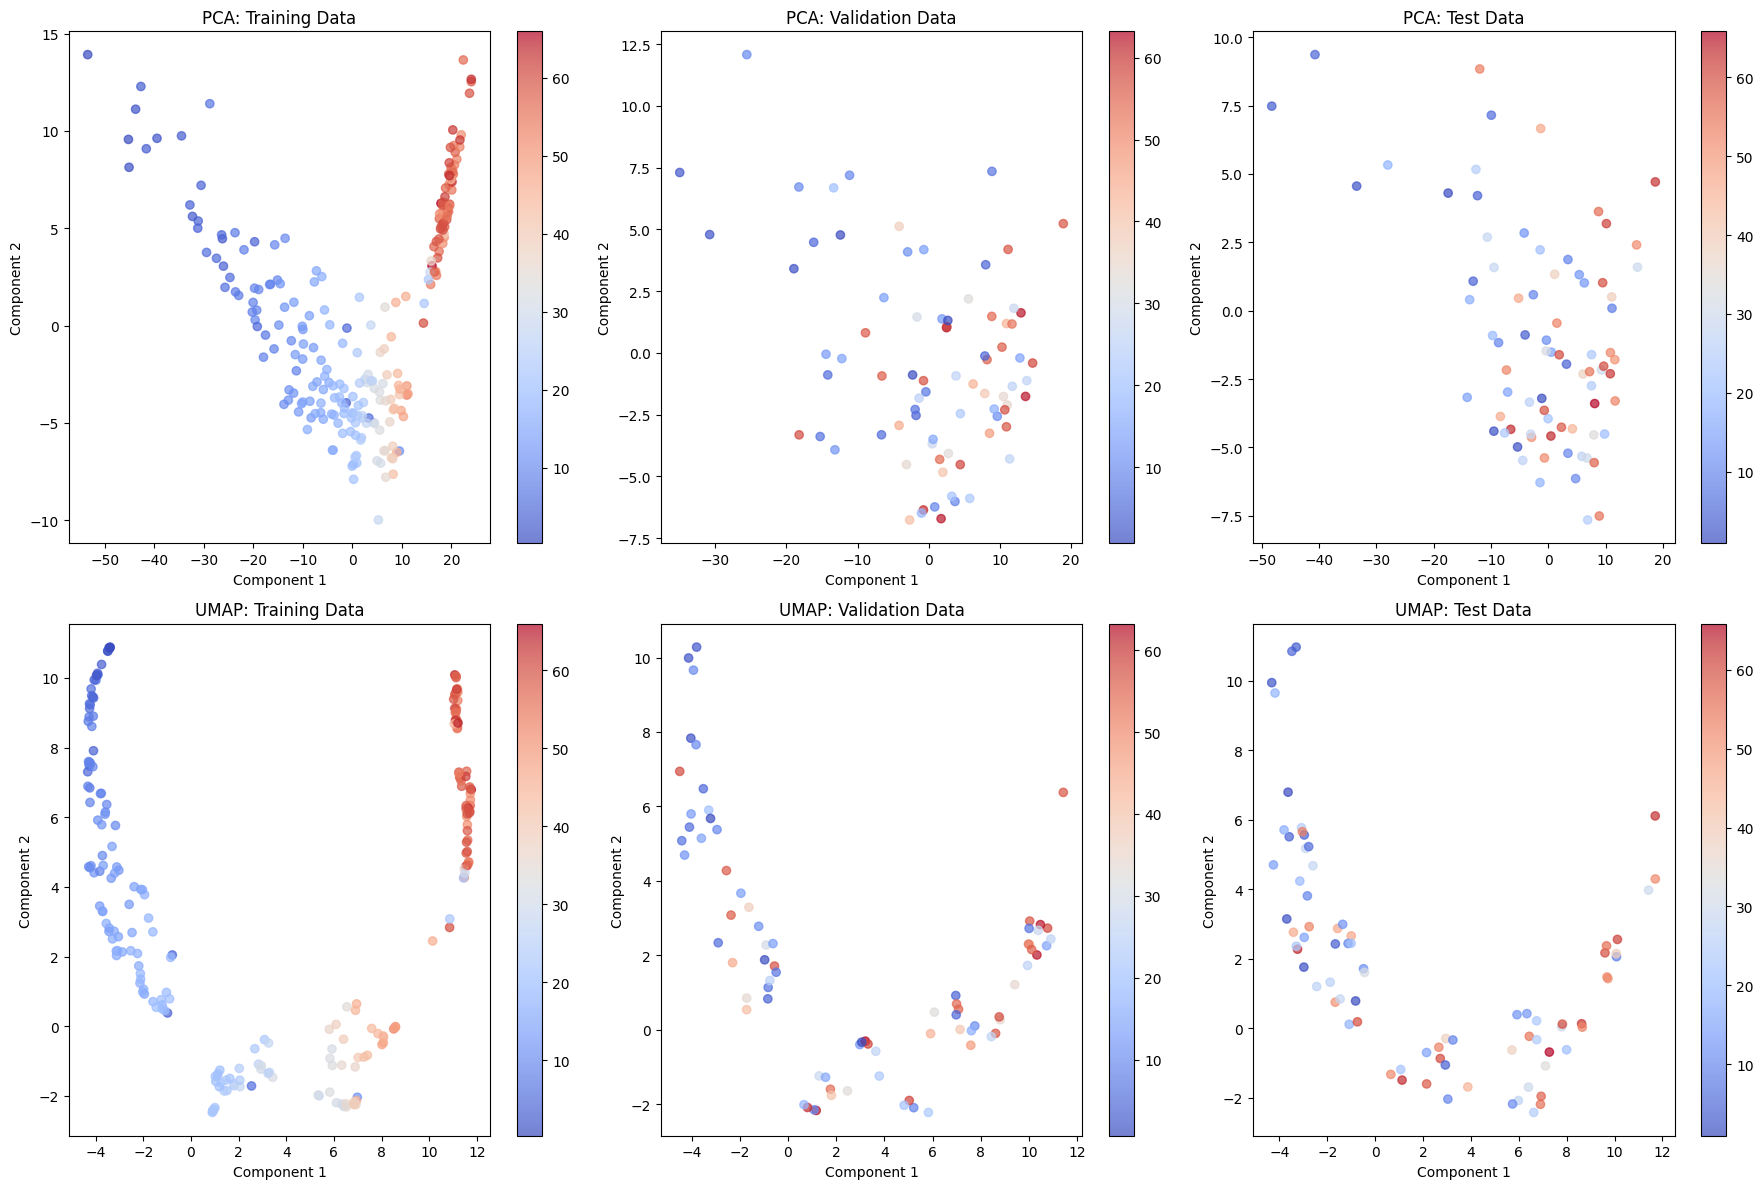

In [97]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval_cox
importlib.reload(best_finetune_model_test_eval_cox)
from best_finetune_model_test_eval_cox import best_model_latent_plot

fig, axes= best_model_latent_plot(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task, task_event)

plt.show()

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



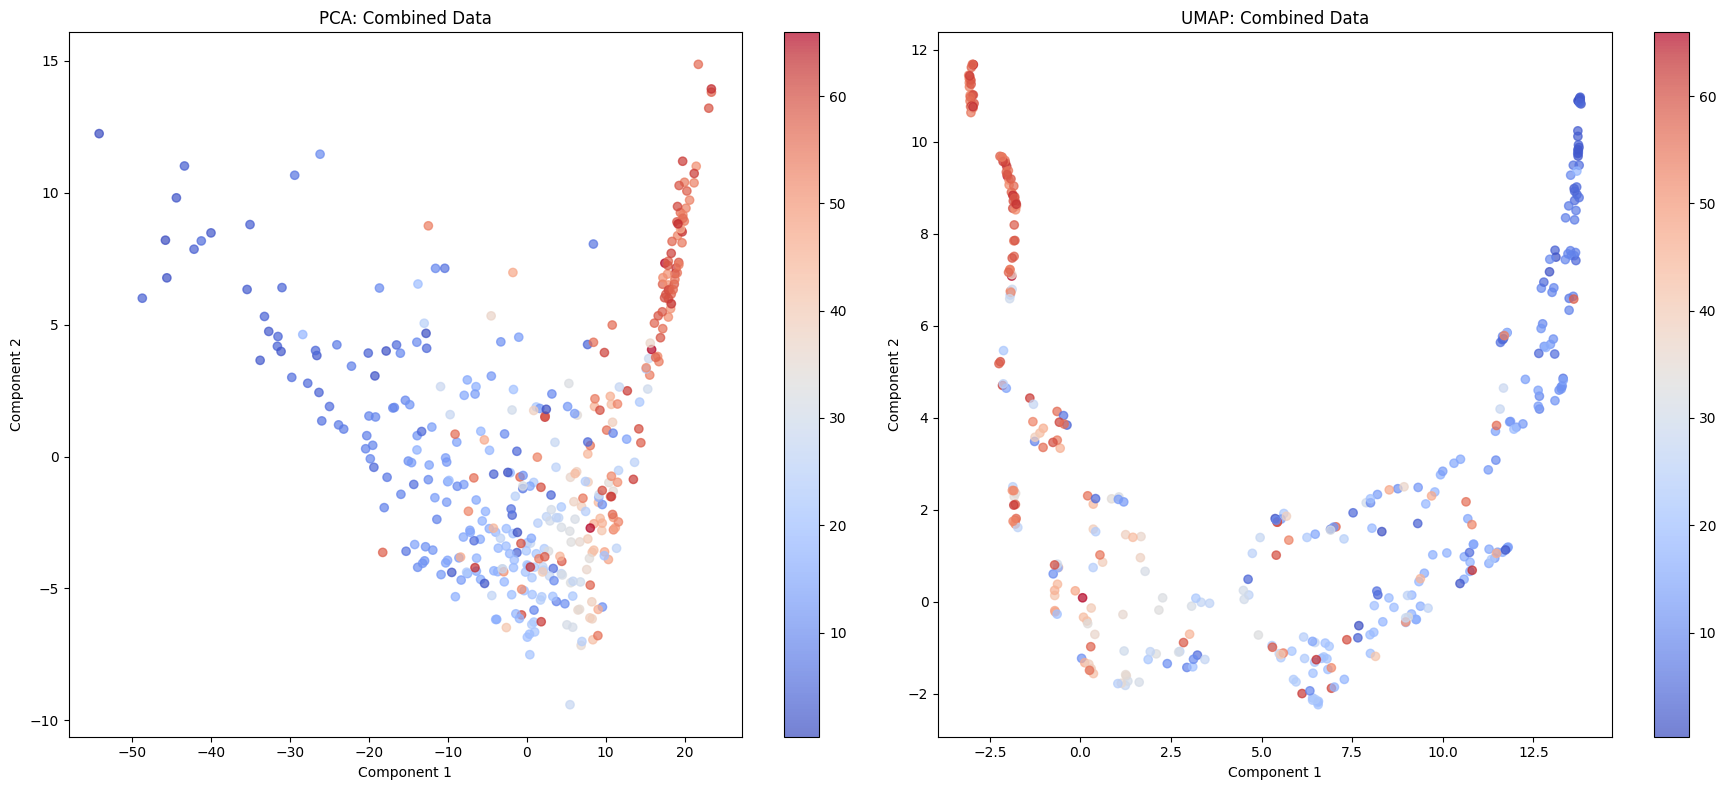

In [98]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval_cox
importlib.reload(best_finetune_model_test_eval_cox)
from best_finetune_model_test_eval_cox import best_model_latent_plot_combined

fig, axes= best_model_latent_plot_combined(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task, task_event)

plt.show()